## Automated Model Selection and Explanation Through Counterfactual Analysis and Visualization

- **Name:** Adir Elmakais
- **ID:** 316413640

# Abstract

This project automates model selection using counterfactual explanations and visualizations. It addresses limitations of traditional methods by providing deeper insights into model behavior that extend beyond standard evaluation metrics.

The system trains multiple models, generates counterfactual explanations, and visualizes them comparatively, offering a user-friendly tool for informed model selection and enhanced AI explainability.

> By integrating performance and interpretability, this approach supports transparent and practical decision-making in machine learning.

#### Project Setup and Library Imports

In [1]:
import dice_ml
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from helpers.utils import *
from helpers.train import *
from helpers.metrics import *
from helpers.visualization import *
from helpers.counterfactual import *

from config.models import config as models_config
from config.general import config as general_config
from config.datasets import config as datasets_config

## Setup and Configuration

This section configures the environment for reproducibility and readability:

-   **Suppress Warnings:**  `warnings.filterwarnings('ignore')` is used to suppress warning messages, ensuring a cleaner output.
-   **Set Random Seed:**  `np.random.seed(general_config['random_seed'])` sets a random seed for NumPy, ensuring that results are reproducible across different runs.
-   **Display Options:**  `pd.set_option('display.max_columns', None)` configures pandas to display all columns of a DataFrame, improving data inspection.

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set a random seed for reproducibility
np.random.seed(general_config['random_seed'])

# Set the maximum number of columns to display
pd.set_option('display.max_columns', None)

### Adult Census Income Dataset

The Adult Census Income dataset, also known as the "Income Prediction" or "Census Income" dataset, is a widely used dataset for classification tasks in machine learning. It is primarily used to predict whether an individual's income exceeds $50,000 based on census data.

**Key Characteristics:**

*   **Objective:** To predict whether an individual's income exceeds $50,000 per year (binary classification task).
*   **Data Source:** The data is extracted from the 1994 and 1995 Current Population Survey (CPS) conducted by the U.S. Census Bureau.
*   **Features:** The dataset consists of a mix of categorical and continuous features describing various attributes of individuals:
    *   **age:** Age of the individual.
    *   **workclass:** Type of employment (e.g., Private, Self-emp-not-inc, Government).
    *   **fnlwgt:** "Final weight" - the number of people in the target population that each census entry represents.
    *   **education:** Highest level of education attained (e.g., Bachelors, Masters, HS-grad).
    *   **education-num:** Number of years of education.
    *   **marital-status:** Marital status of the individual (e.g., Married-civ-spouse, Never-married).
    *   **occupation:** The individual's occupation (e.g., Exec-managerial, Craft-repair, Sales).
    *   **relationship:** The individual's relationship in the household (e.g., Husband, Wife, Own-child).
    *   **race:** The individual's race (e.g., White, Black, Asian-Pac-Islander).
    *   **sex:** The individual's gender (Male, Female).
    *   **capital-gain:** Capital gains for the individual.
    *   **capital-loss:** Capital losses for the individual.
    *   **hours-per-week:** Number of hours worked per week.
    *   **native-country:** The individual's country of origin.

*   **Target Variable:**
    *   income: Binary variable indicating whether the individual's income is <=$50K or >$50K.

*   **Sample Size:** The full dataset contains approximately 48,000 instances, split into training and testing sets. **However, in this project, we are using only 10% of the data from both the training and testing sets to reduce computational overhead and maintain reasonable processing times.**

### Data Loading and Preprocessing


#### Data Loading

In [3]:
adults_train_data, adults_test_data, adults_column_names = load_dataset(
    train_file=datasets_config["adult_dataset"]["train_file"],
    test_file=datasets_config["adult_dataset"]["test_file"],
    columns=datasets_config["adult_dataset"]["columns"],
    target_column=datasets_config["adult_dataset"]["target_column"],
    missing_values=datasets_config["adult_dataset"]["missing_values"],
    skip_first_row_test=datasets_config["adult_dataset"]["skip_first_row_test"],
)

#Clean the target column in both train and test data:
adults_train_data[datasets_config["adult_dataset"]["target_column"]] = adults_train_data[datasets_config["adult_dataset"]["target_column"]].str.replace('.', '', regex=False).str.strip()
adults_test_data[datasets_config["adult_dataset"]["target_column"]] = adults_test_data[datasets_config["adult_dataset"]["target_column"]].str.replace('.', '', regex=False).str.strip()


### Subsampling the Adult Dataset

To reduce computational overhead and speed up experimentation, we subsample both the training and test sets of the Adult Census Income dataset. We randomly select 10% of the data in each set, ensuring that the sampling is reproducible by using a fixed random seed. This approach allows for faster iteration during development while still providing a representative sample of the overall dataset.

In [4]:
# For the training set
adults_train_data = adults_train_data.sample(frac=0.1, random_state=general_config['random_seed'])
# For the test set
adults_test_data = adults_test_data.sample(frac=0.1, random_state=general_config['random_seed'])

### Checking for Duplicates

Before proceeding with further analysis, we check the training dataset for any duplicate entries. This step helps ensure data quality and prevents potential bias in model training. The code `adults_train_data.duplicated().sum()` calculates the number of duplicate rows in the DataFrame.

In [5]:
### Check duplicates
print(adults_train_data.duplicated().sum())

0


The check for duplicates in the training dataset revealed **zero** duplicate entries. This confirms that each row in the dataset is unique, ensuring data integrity for subsequent analysis and modeling.

In [6]:
display(adults_train_data.head())
display(adults_train_data.columns)

age         workclass  fnlwgt     education  education-num  \
14160   27           Private  160178  Some-college             10   
27048   45         State-gov   50567       HS-grad              9   
28868   29           Private  185908     Bachelors             13   
5667    30           Private  190040     Bachelors             13   
7827    29  Self-emp-not-inc  189346  Some-college             10   

           marital-status         occupation   relationship   race     sex  \
14160            Divorced       Adm-clerical  Not-in-family  White  Female   
27048  Married-civ-spouse    Exec-managerial           Wife  White  Female   
28868  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
5667        Never-married  Machine-op-inspct  Not-in-family  White  Female   
7827             Divorced       Craft-repair  Not-in-family  White    Male   

       capital-gain  capital-loss  hours-per-week native-country income  
14160             0             0              38  United-States  <=50K  
27048             0             0              40  United-States  <=50K  
28868             0             0              55  United-States   >50K  
5667              0             0              40  United-States  <=50K  
7827           2202             0              50  United-States  <=50K

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [7]:
display(adults_test_data.head())
display(adults_test_data.columns)

age    workclass  fnlwgt  education  education-num      marital-status  \
13633   29      Private  189346    HS-grad              9       Never-married   
1921    31      Private  137076  Bachelors             13  Married-civ-spouse   
12140   52  Federal-gov   35546    HS-grad              9  Married-civ-spouse   
9933    54    Local-gov  116428       10th              6  Married-civ-spouse   
7745    41      Private  177054    HS-grad              9            Divorced   

              occupation relationship   race   sex  capital-gain  \
13633   Transport-moving    Unmarried  White  Male             0   
1921     Protective-serv      Husband  White  Male             0   
12140       Tech-support      Husband  White  Male             0   
9933     Exec-managerial      Husband  White  Male             0   
7745   Machine-op-inspct    Unmarried  White  Male             0   

       capital-loss  hours-per-week native-country income  
13633             0              40  United-States  <=50K  
1921              0              40  United-States  <=50K  
12140             0              40  United-States  <=50K  
9933              0              40  United-States  <=50K  
7745              0              40  United-States  <=50K

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


#### Basic Data Exploration (Train)

In [8]:
# Let's take a look at the first few rows of the training data:
display(adults_train_data.head())

# Let's get some basic information about the training data:
display(adults_train_data.info())

# Summary statistics for numerical features:
display(adults_train_data.describe())

# Check for missing values:
display(adults_train_data.isnull().sum())

age         workclass  fnlwgt     education  education-num  \
14160   27           Private  160178  Some-college             10   
27048   45         State-gov   50567       HS-grad              9   
28868   29           Private  185908     Bachelors             13   
5667    30           Private  190040     Bachelors             13   
7827    29  Self-emp-not-inc  189346  Some-college             10   

           marital-status         occupation   relationship   race     sex  \
14160            Divorced       Adm-clerical  Not-in-family  White  Female   
27048  Married-civ-spouse    Exec-managerial           Wife  White  Female   
28868  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
5667        Never-married  Machine-op-inspct  Not-in-family  White  Female   
7827             Divorced       Craft-repair  Not-in-family  White    Male   

       capital-gain  capital-loss  hours-per-week native-country income  
14160             0             0              38  United-States  <=50K  
27048             0             0              40  United-States  <=50K  
28868             0             0              55  United-States   >50K  
5667              0             0              40  United-States  <=50K  
7827           2202             0              50  United-States  <=50K

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3256 entries, 14160 to 28721
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             3256 non-null   int64 
 1   workclass       3050 non-null   object
 2   fnlwgt          3256 non-null   int64 
 3   education       3256 non-null   object
 4   education-num   3256 non-null   int64 
 5   marital-status  3256 non-null   object
 6   occupation      3050 non-null   object
 7   relationship    3256 non-null   object
 8   race            3256 non-null   object
 9   sex             3256 non-null   object
 10  capital-gain    3256 non-null   int64 
 11  capital-loss    3256 non-null   int64 
 12  hours-per-week  3256 non-null   int64 
 13  native-country  3187 non-null   object
 14  income          3256 non-null   object
dtypes: int64(6), object(9)
memory usage: 407.0+ KB


None

age         fnlwgt  education-num  capital-gain  capital-loss  \
count  3256.000000    3256.000000    3256.000000   3256.000000   3256.000000   
mean     38.839988  188645.845823      10.036548   1135.738329     91.822174   
std      13.575726  104564.098679       2.583455   7583.282726    416.317852   
min      17.000000   19914.000000       1.000000      0.000000      0.000000   
25%      28.000000  117337.750000       9.000000      0.000000      0.000000   
50%      37.000000  177635.500000      10.000000      0.000000      0.000000   
75%      48.000000  235455.000000      12.000000      0.000000      0.000000   
max      90.000000  972354.000000      16.000000  99999.000000   2559.000000   

       hours-per-week  
count     3256.000000  
mean        40.271192  
std         11.967153  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

age                 0
workclass         206
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        206
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country     69
income              0
dtype: int64

#### Basic Data Exploration (Test)

In [9]:
display(adults_test_data.head())

display(adults_test_data.info())

display(adults_test_data.describe())

display(adults_test_data.isnull().sum())

age    workclass  fnlwgt  education  education-num      marital-status  \
13633   29      Private  189346    HS-grad              9       Never-married   
1921    31      Private  137076  Bachelors             13  Married-civ-spouse   
12140   52  Federal-gov   35546    HS-grad              9  Married-civ-spouse   
9933    54    Local-gov  116428       10th              6  Married-civ-spouse   
7745    41      Private  177054    HS-grad              9            Divorced   

              occupation relationship   race   sex  capital-gain  \
13633   Transport-moving    Unmarried  White  Male             0   
1921     Protective-serv      Husband  White  Male             0   
12140       Tech-support      Husband  White  Male             0   
9933     Exec-managerial      Husband  White  Male             0   
7745   Machine-op-inspct    Unmarried  White  Male             0   

       capital-loss  hours-per-week native-country income  
13633             0              40  United-States  <=50K  
1921              0              40  United-States  <=50K  
12140             0              40  United-States  <=50K  
9933              0              40  United-States  <=50K  
7745              0              40  United-States  <=50K

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1628 entries, 13633 to 13415
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             1628 non-null   int64 
 1   workclass       1544 non-null   object
 2   fnlwgt          1628 non-null   int64 
 3   education       1628 non-null   object
 4   education-num   1628 non-null   int64 
 5   marital-status  1628 non-null   object
 6   occupation      1544 non-null   object
 7   relationship    1628 non-null   object
 8   race            1628 non-null   object
 9   sex             1628 non-null   object
 10  capital-gain    1628 non-null   int64 
 11  capital-loss    1628 non-null   int64 
 12  hours-per-week  1628 non-null   int64 
 13  native-country  1599 non-null   object
 14  income          1628 non-null   object
dtypes: int64(6), object(9)
memory usage: 203.5+ KB


None

age         fnlwgt  education-num  capital-gain  capital-loss  \
count  1628.000000    1628.000000    1628.000000   1628.000000   1628.000000   
mean     38.280713  189301.837838      10.099509   1148.816339     94.962531   
std      13.604085  102074.055549       2.488805   7850.794731    417.046930   
min      17.000000   13862.000000       1.000000      0.000000      0.000000   
25%      27.000000  118005.750000       9.000000      0.000000      0.000000   
50%      37.000000  179028.000000      10.000000      0.000000      0.000000   
75%      47.250000  240224.750000      12.000000      0.000000      0.000000   
max      88.000000  914061.000000      16.000000  99999.000000   2824.000000   

       hours-per-week  
count     1628.000000  
mean        40.304668  
std         12.569827  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

age                0
workclass         84
fnlwgt             0
education          0
education-num      0
marital-status     0
occupation        84
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country    29
income             0
dtype: int64

### Basic Visualizations

This section provides initial visualizations to understand the characteristics of the Adult Census Income dataset. We employ several plotting techniques to explore feature distributions, relationships, and class balances:

-   **Feature Distributions:** `plot_feature_distributions` displays histograms and kernel density estimates for each feature, providing insights into their distributions and potential skewness.
-   **Correlation Heatmap:** `plot_correlation_heatmap` visualizes the correlation matrix of numeric features, revealing linear relationships and potential multicollinearity.
-   **PCA Plot:** `plot_pca` applies Principal Component Analysis (PCA) to reduce dimensionality and visualize class separation in a 2D space.
-   **Count Plots:** `plot_count_all` generates count plots for categorical features, illustrating the frequency of each category and potential class imbalances.

**Note:** To maintain simplicity and focus on counterfactual explanations, we will **not** perform feature engineering or outlier handling in this project. The goal is to demonstrate the utility of counterfactuals for model selection and understanding, rather than optimizing model performance through extensive data preprocessing.

#### Feature Distributions - Adult Dataset

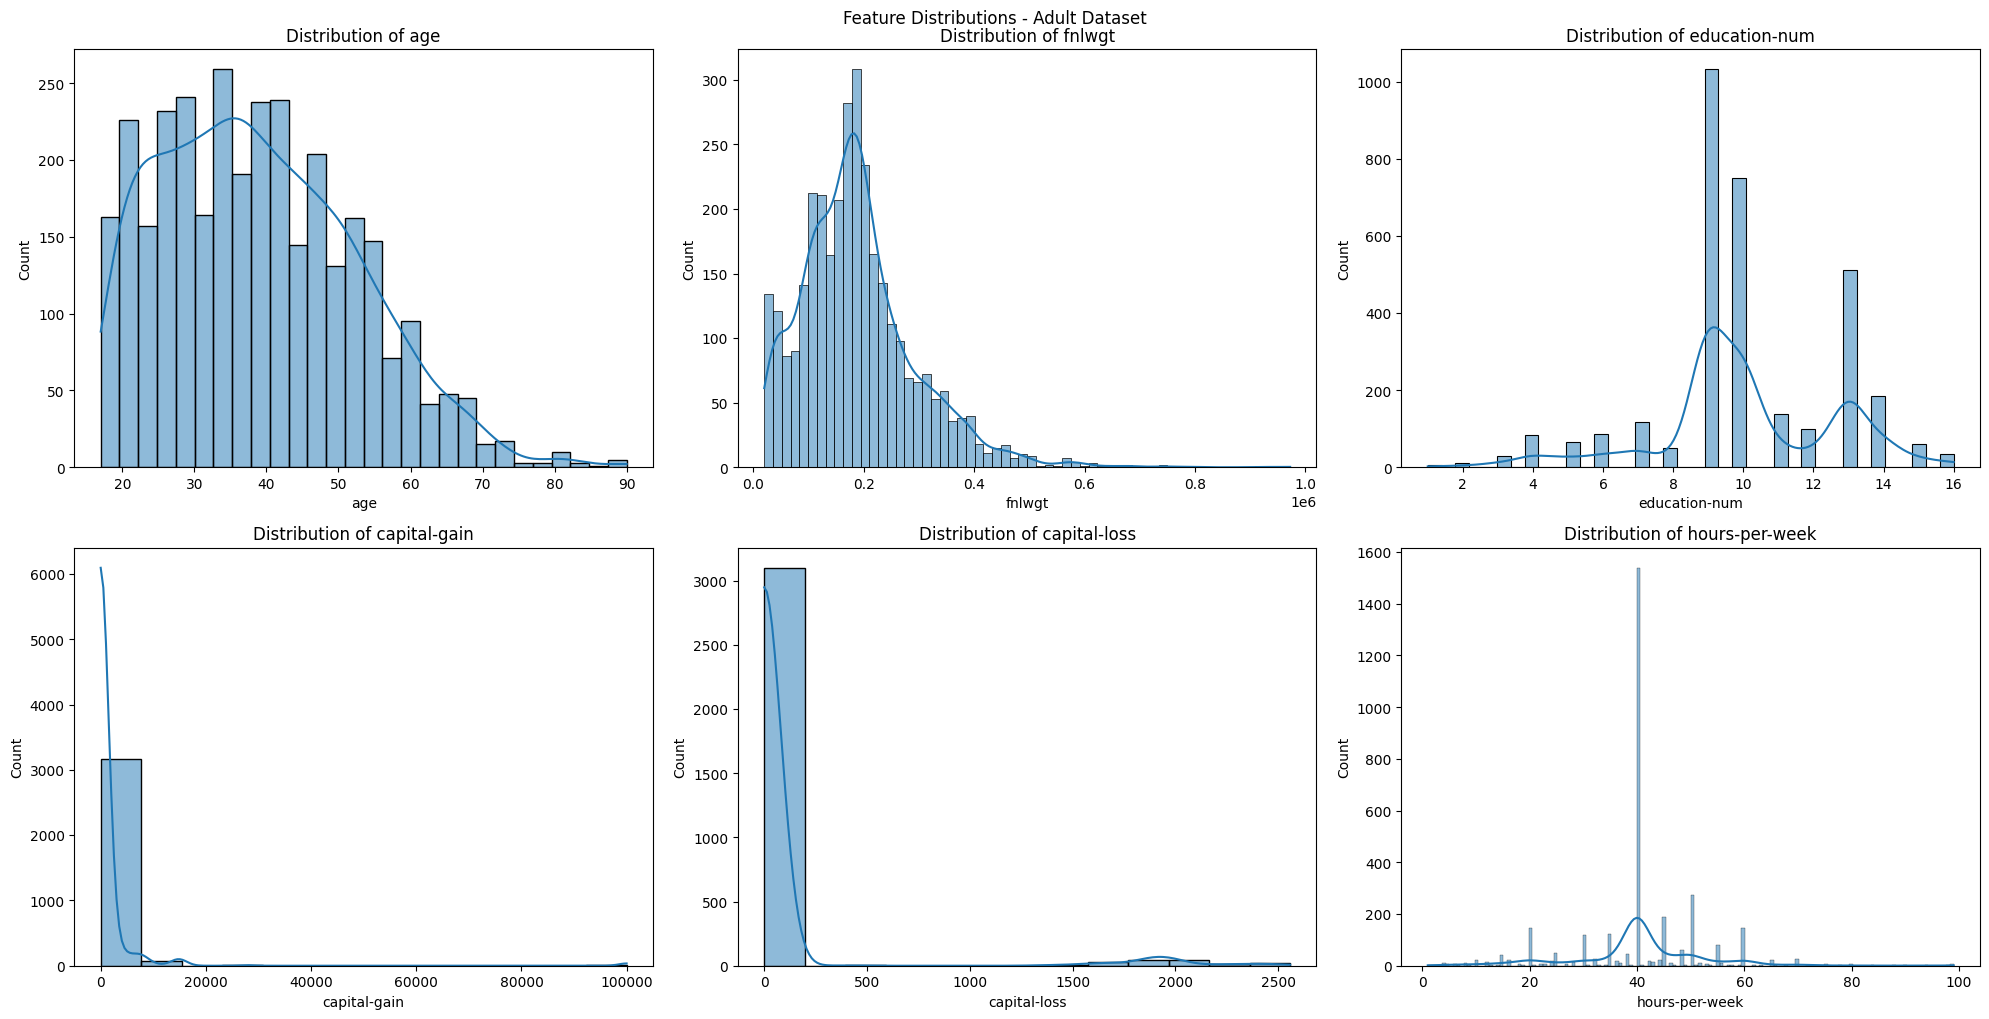

In [10]:
adults_features_plot_feature_distributions = adults_train_data.select_dtypes(include="number").columns.tolist()

plot_feature_distributions(
    data=adults_train_data,
    features=adults_features_plot_feature_distributions,
    title="Feature Distributions - Adult Dataset"
)

This set of histograms and kernel density estimations (KDEs) visualizes the distribution of features in the Adult Census Income dataset. Each subplot represents a different feature, providing insights into its central tendency, spread, and skewness.

**Key Observations:**

*   **Age:** The distribution of age is right-skewed, with a peak around 25-35 years old and a long tail extending towards older ages.
*   **fnlwgt:** This feature exhibits a highly right-skewed distribution, indicating a large variance in the sampling weights.
*   **Education-num:** This feature, representing the years of education, shows peaks at around 9, 10 and 13 years (High school, Some College, and Bachelors, respectively).
*   **Capital-gain:** The majority of individuals have a capital gain of zero, with a long tail indicating a few individuals with high capital gains.
*   **Capital-loss:** Similar to capital gain, most individuals have zero capital loss, with a small number experiencing losses.
*   **Hours-per-week:** Most individuals work around 40 hours per week, with other prominent times at 20 and 50, with few working very long hours.

#### Correlation Heatmap - Adult Dataset

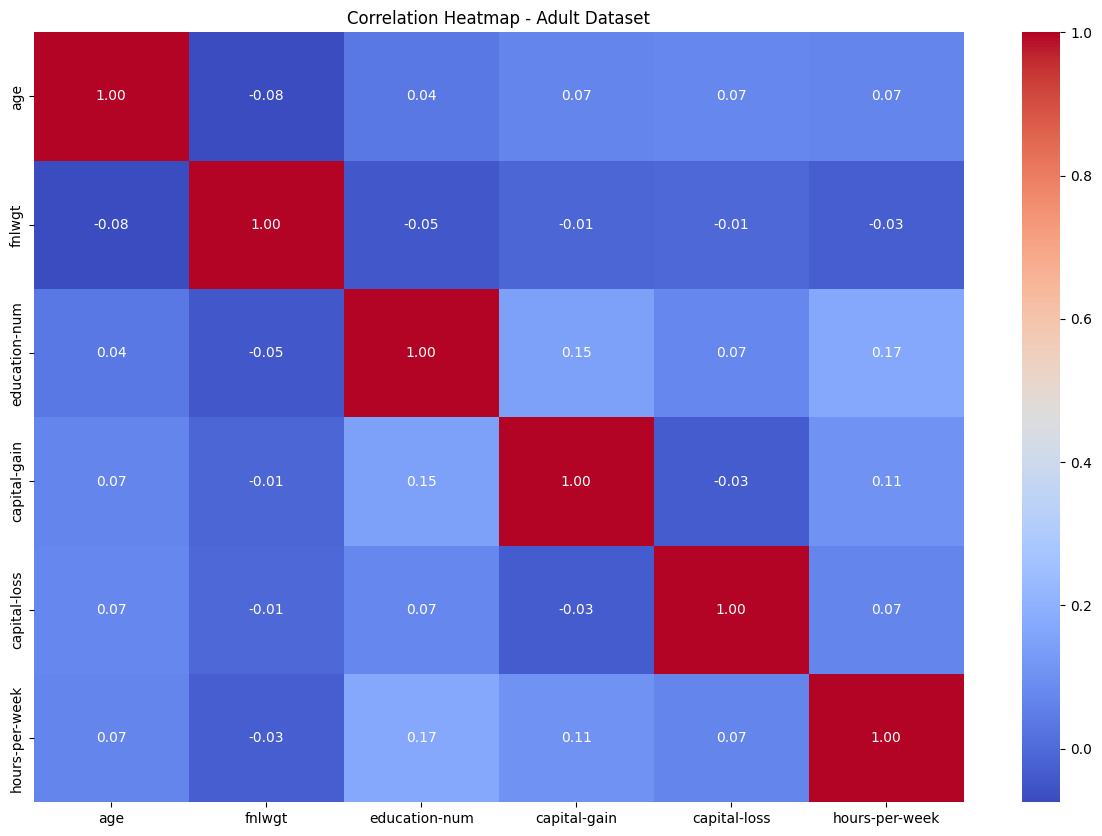

In [11]:
plot_correlation_heatmap(
    data=adults_train_data,
    title="Correlation Heatmap - Adult Dataset"
)

This heatmap visualizes the pairwise correlations between numerical features in the Adult Census Income dataset. The color intensity and numerical values represent the strength and direction of the linear relationship between each pair of features. Red indicates positive correlation, blue indicates negative correlation, and white indicates little to no correlation.

**Key Observations:**

*   The heatmap shows weak correlations between the selected numerical features.  The strongest positive correlation is between `education-num` and `hours-per-week` (0.17), suggesting a slight tendency for individuals with more education to work more hours per week. The strongest negative correlation is between `fnlwgt` and `education-num` (-0.05).

*   Most correlation coefficients are close to zero, indicating a lack of strong linear relationships between these features.

*   The diagonal entries are all 1.00, as each feature is perfectly correlated with itself.

#### PCA Plot - Adult Dataset

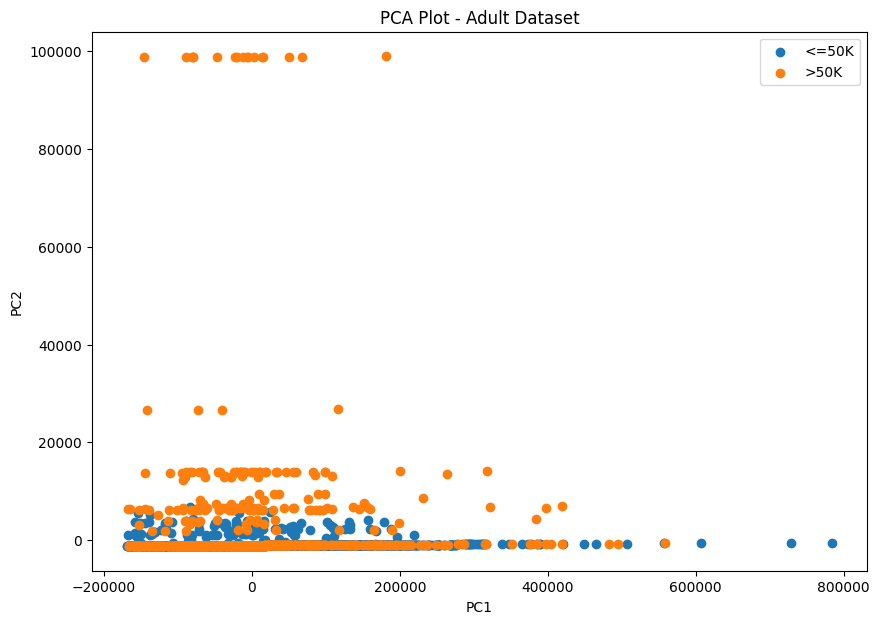

In [12]:
plot_pca(
    data=adults_train_data,
    target=datasets_config["adult_dataset"]["target_column"],
    title="PCA Plot - Adult Dataset"
)

This scatter plot visualizes the first two principal components (PC1 and PC2) of the Adult Census Income dataset. Each point represents an individual, colored according to their income level: blue for "<=50K" and orange for ">50K". PCA is used to reduce the dimensionality of the data while retaining the most important variance, allowing us to visualize potential class separation in a 2D space.

**Key Observations:**

*   There is significant overlap between the two classes ("<=50K" and ">50K") in the PCA space. This indicates that the original features, when reduced to two principal components, do not provide a clear separation between the income groups.
*   The majority of points are clustered in a region close to the origin, but there are several outliers.
*   There are several orange data points (>50k) in the region where most blue data points (<=50k) exists, and vice versa.

#### Count Plots - Adult Dataset

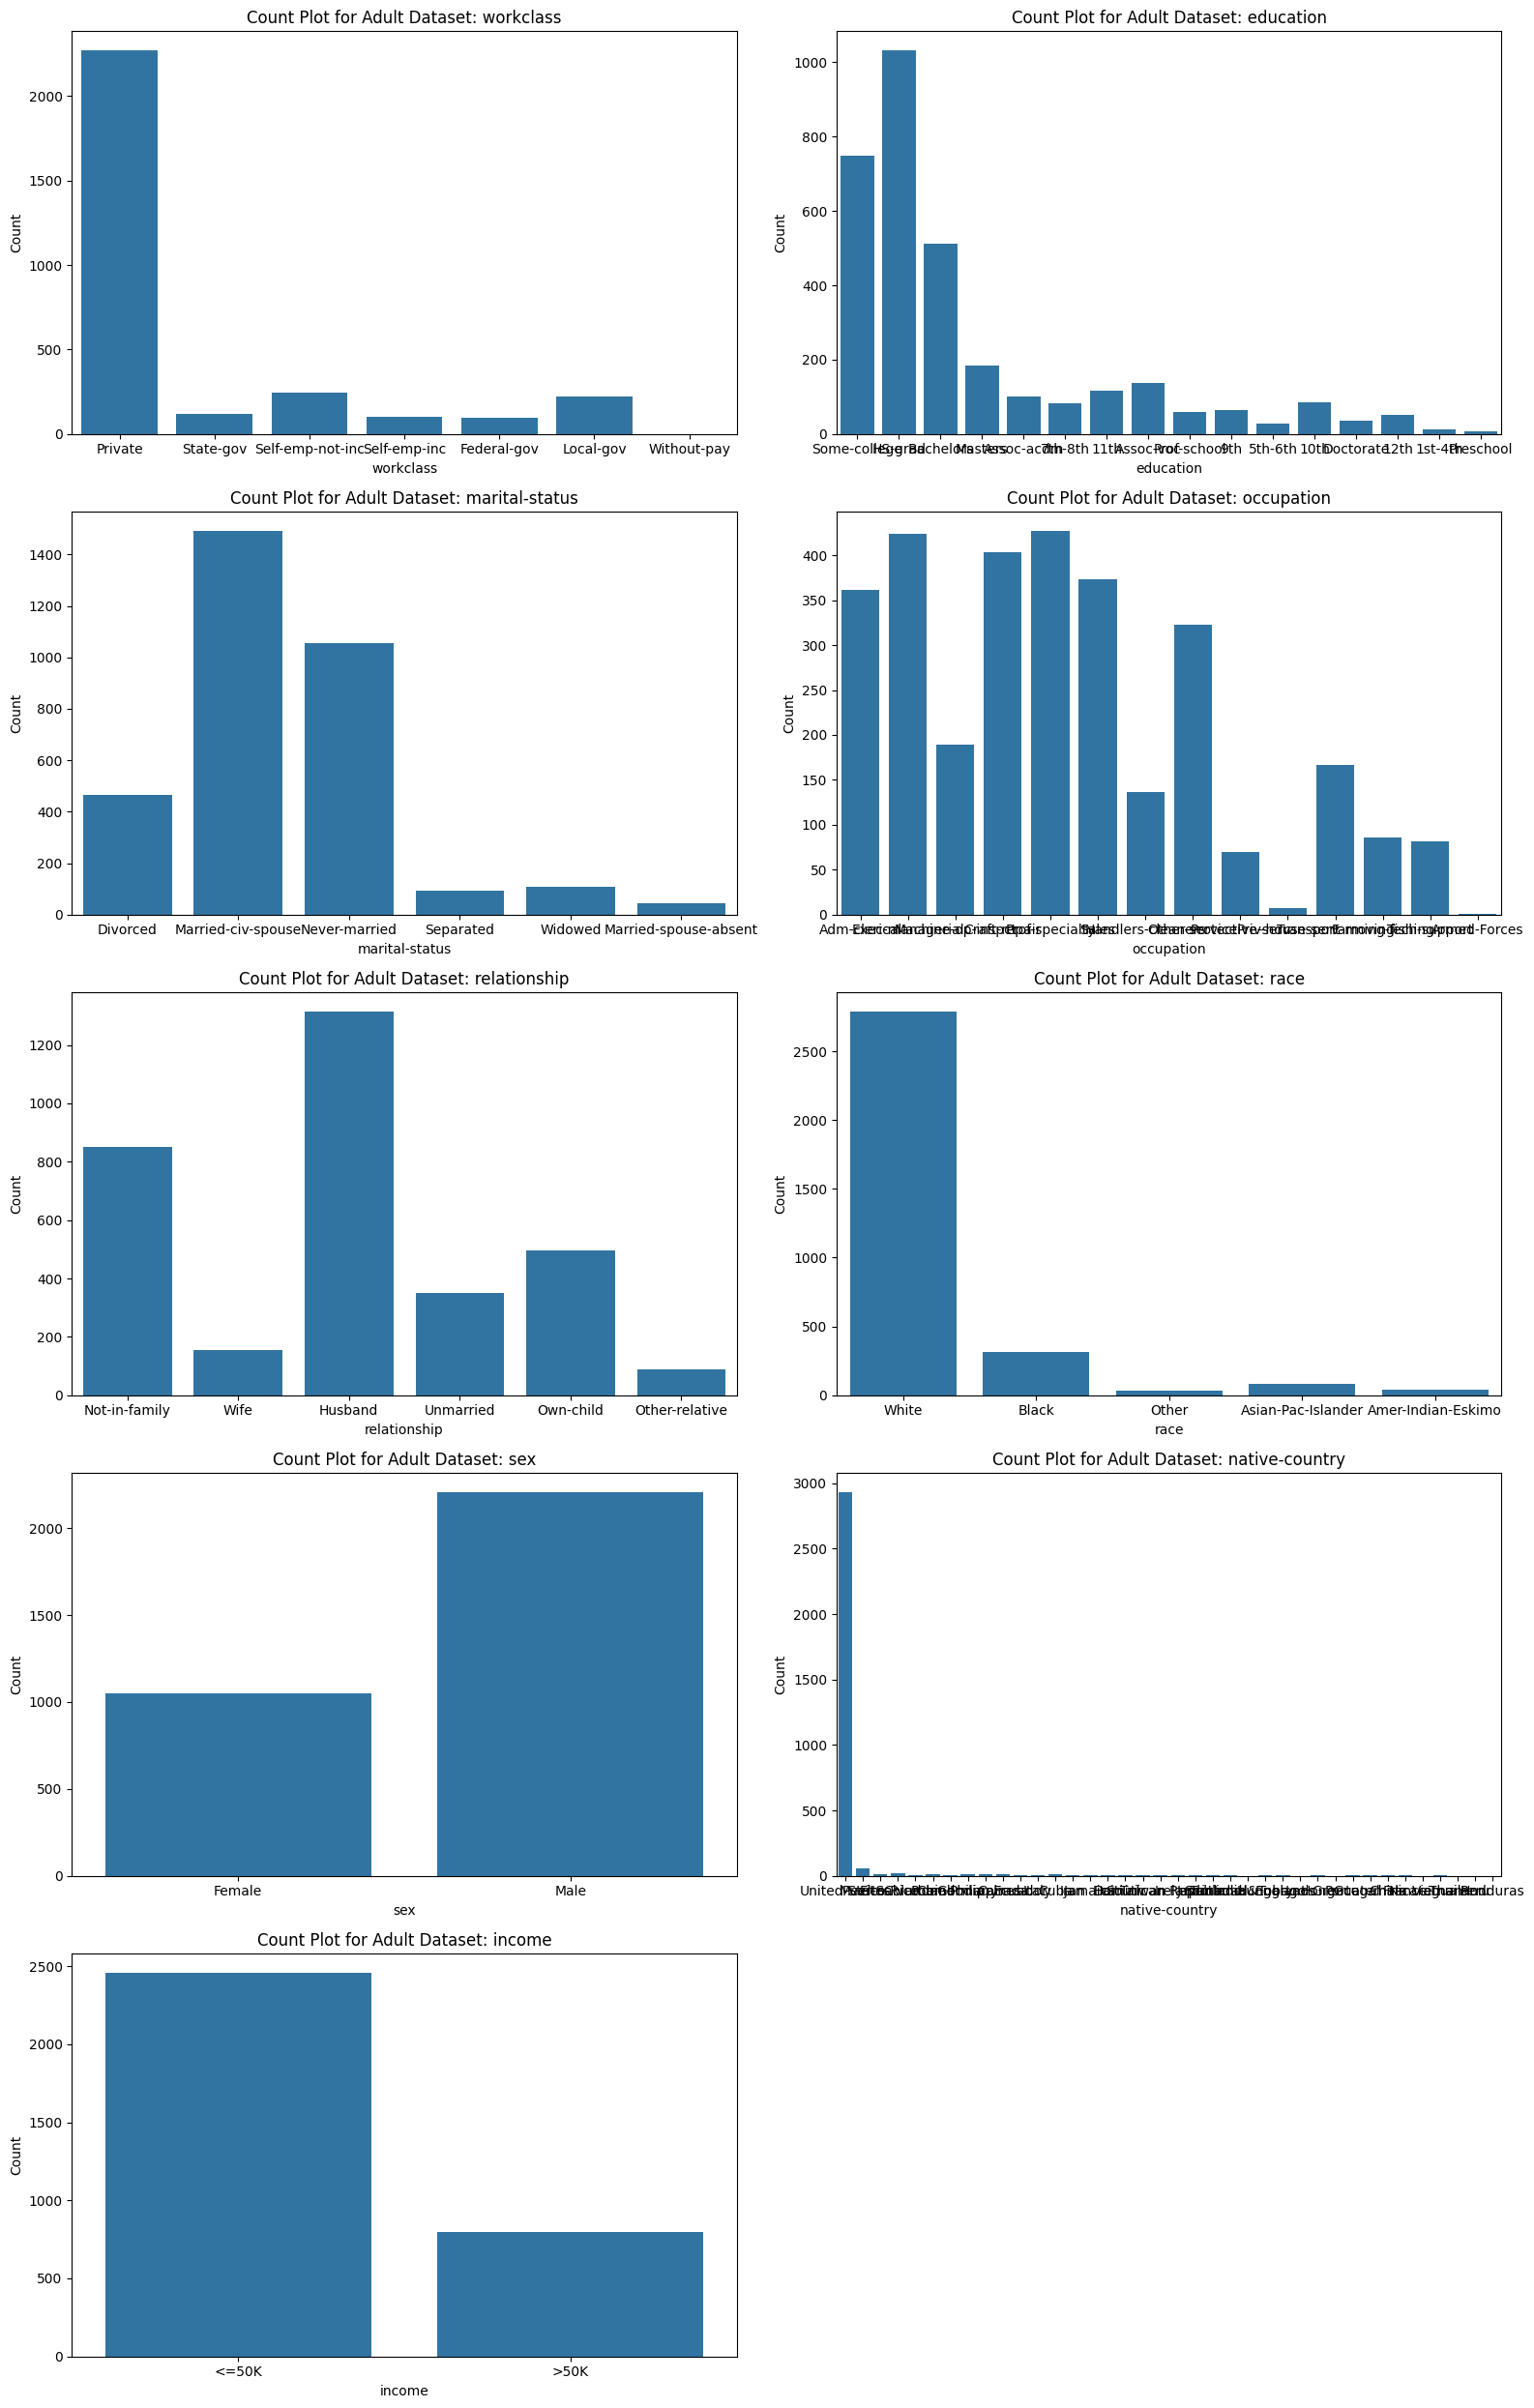

In [13]:
plot_count_all(
    data=adults_train_data,
    title_prefix="Count Plot for Adult Dataset: "
)

This collection of count plots visualizes the distribution of categorical features in the Adult Census Income dataset. Each plot displays the frequency of each category within a specific feature, providing insights into the composition and balance of the dataset's categorical variables.

**Key Observations:**

*   **Workclass:** The majority of individuals belong to the "Private" workclass category, with significantly fewer individuals in other categories like "Self-emp-not-inc", "Local-gov", etc.
*   **Education:** "Some-college" and "HS-grad" are the most prevalent education levels, followed by "Bachelors". This indicates a large segment of the population has some college education but did not graduate and another large segment has a high school diploma.
*   **Marital-status:** "Married-civ-spouse" is the most frequent marital status, followed by "Never-married," and "Divorced."
*   **Occupation:** "Prof-specialty", "Craft-repair", "Exec-managerial" and "Adm-clerical" are the most frequent.
*   **Relationship:** "Husband" and "Not-in-family" are the most common relationship statuses.
*   **Race:** The dataset is heavily dominated by the "White" race category.
*   **Sex:** There are more "Male" instances than "Female."
*   **Native-country:** "United-States" accounts for the vast majority of individuals in the dataset.
*   **Income:** The dataset is imbalanced, with significantly more individuals in the "<=50K" income category than ">50K".

### Data Preprocessing

#### Handling Missing Values

We have some missing values. We have several options for handling them:

- **Dropping rows:** We could drop rows with missing values. This is simple but might lead to significant data loss.
- **Imputation:** We could impute (fill in) missing values with estimated values. Common strategies include:
   - Mean/Median imputation for numerical features.
   - Most frequent value (mode) imputation for categorical features.
   - Using a predictive model to impute missing values (more advanced).

In [14]:
display(adults_train_data.isnull().sum())
display('---------------------------------')
display(adults_test_data.isnull().sum())

age                 0
workclass         206
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        206
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country     69
income              0
dtype: int64

'---------------------------------'

age                0
workclass         84
fnlwgt             0
education          0
education-num      0
marital-status     0
occupation        84
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country    29
income             0
dtype: int64

Let's use mode imputation for categorical features.

In [15]:
categorical_cols_train_adults = adults_train_data.select_dtypes(include=['object']).columns
for col in categorical_cols_train_adults:
    adults_train_data[col].fillna(adults_train_data[col].mode()[0], inplace=True)

categorical_cols_test_adults = adults_test_data.select_dtypes(include=['object']).columns
for col in categorical_cols_test_adults:
    adults_test_data[col].fillna(adults_test_data[col].mode()[0], inplace=True)

# Verify that there are no more missing values:
display(adults_train_data.isnull().sum())
display('---------------------------------')
display(adults_test_data.isnull().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

'---------------------------------'

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

### Outcome of Missing Value Handling

The execution of the missing value imputation process yielded the following results:

-   **Training Data:** The `adults_train_data.isnull().sum()` output shows that there are no remaining missing values in any of the columns.
-   **Test Data:** Similarly, the `adults_test_data.isnull().sum()` output confirms the absence of missing values in the test dataset.

This outcome indicates that the mode imputation strategy was successfully applied to all categorical columns, ensuring data completeness for subsequent analysis and modeling.

#### Separate Target from Features

In [16]:
y_train_adults = adults_train_data[datasets_config["adult_dataset"]["target_column"]].copy()
X_train_adults = adults_train_data.drop(datasets_config["adult_dataset"]["target_column"], axis=1)

y_test_adults = adults_test_data[datasets_config["adult_dataset"]["target_column"]].copy()
X_test_adults = adults_test_data.drop(datasets_config["adult_dataset"]["target_column"], axis=1)

### Feature Scaling

Feature scaling is important when using models that are sensitive to the scale of features (e.g., distance-based models like SVM or KNN). Even for models that are not inherently scale-sensitive (like tree-based models), scaling can sometimes improve performance or convergence speed.

We'll use StandardScaler to standardize the numerical features.

In [17]:
# Identify numerical columns
numerical_cols_adults = X_train_adults.select_dtypes(include=['number']).columns

# Initialize the StandardScaler
scaler_adults = StandardScaler()

# Fit and transform the numerical features
X_train_adults[numerical_cols_adults] = scaler_adults.fit_transform(X_train_adults[numerical_cols_adults])
X_test_adults[numerical_cols_adults] = scaler_adults.transform(X_test_adults[numerical_cols_adults])

# Display the first few rows of the scaled data:
display(X_train_adults.head())
display(X_test_adults.head())

age         workclass    fnlwgt     education  education-num  \
14160 -0.872278           Private -0.272294  Some-college      -0.014149   
27048  0.453822         State-gov -1.320722       HS-grad      -0.401287   
28868 -0.724934           Private -0.026187     Bachelors       1.147265   
5667  -0.651261           Private  0.013335     Bachelors       1.147265   
7827  -0.724934  Self-emp-not-inc  0.006697  Some-college      -0.014149   

           marital-status         occupation   relationship   race     sex  \
14160            Divorced       Adm-clerical  Not-in-family  White  Female   
27048  Married-civ-spouse    Exec-managerial           Wife  White  Female   
28868  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
5667        Never-married  Machine-op-inspct  Not-in-family  White  Female   
7827             Divorced       Craft-repair  Not-in-family  White    Male   

       capital-gain  capital-loss  hours-per-week native-country  
14160     -0.149792     -0.220592       -0.189815  United-States  
27048     -0.149792     -0.220592       -0.022665  United-States  
28868     -0.149792     -0.220592        1.230959  United-States  
5667      -0.149792     -0.220592       -0.022665  United-States  
7827       0.140628     -0.220592        0.813084  United-States

age    workclass    fnlwgt  education  education-num  \
13633 -0.724934      Private  0.006697    HS-grad      -0.401287   
1921  -0.577589      Private -0.493265  Bachelors       1.147265   
12140  0.969527  Federal-gov -1.464397    HS-grad      -0.401287   
9933   1.116871    Local-gov -0.690762       10th      -1.562701   
7745   0.159133      Private -0.110876    HS-grad      -0.401287   

           marital-status         occupation relationship   race   sex  \
13633       Never-married   Transport-moving    Unmarried  White  Male   
1921   Married-civ-spouse    Protective-serv      Husband  White  Male   
12140  Married-civ-spouse       Tech-support      Husband  White  Male   
9933   Married-civ-spouse    Exec-managerial      Husband  White  Male   
7745             Divorced  Machine-op-inspct    Unmarried  White  Male   

       capital-gain  capital-loss  hours-per-week native-country  
13633     -0.149792     -0.220592       -0.022665  United-States  
1921      -0.149792     -0.220592       -0.022665  United-States  
12140     -0.149792     -0.220592       -0.022665  United-States  
9933      -0.149792     -0.220592       -0.022665  United-States  
7745      -0.149792     -0.220592       -0.022665  United-States

The table above displays the first five rows of the Adult Census Income dataset *after* numerical features have been scaled using `StandardScaler`. This transformation centers each feature around zero and scales it to have a unit variance. Categorical features remain in their original string format.

**Explanation of Columns:**

*   **age:** Scaled age value. A negative value indicates an age below the mean age of the training data.
*   **workclass:** Categorical feature representing the type of employment (e.g., Private, State-gov).
*   **fnlwgt:** Scaled 'final weight' value.  This represents the number of people in the target population that each census response represents.
*   **education:** Categorical feature representing the highest level of education attained (e.g., Some-college, HS-grad).
*   **education-num:** Scaled numerical representation of education level (years of education).  A negative value indicates fewer years of education than the mean.
*   **marital-status:** Categorical feature indicating marital status (e.g., Divorced, Married-civ-spouse).
*   **occupation:** Categorical feature describing the individual's occupation (e.g., Adm-clerical, Exec-managerial).
*   **relationship:** Categorical feature describing the individual's relationship in the household (e.g., Not-in-family, Husband).
*   **race:** Categorical feature representing the individual's race (e.g., White, Black).
*   **sex:** Categorical feature representing the individual's sex (e.g., Female, Male).
*   **capital-gain:** Scaled capital gain value. A negative value indicates a capital gain below the mean.
*   **capital-loss:** Scaled capital loss value. A negative value indicates a capital loss below the mean.
*   **hours-per-week:** Scaled number of hours worked per week. A negative value indicates fewer hours worked than the mean.
*   **native-country:** Categorical feature representing the individual's country of origin (e.g., United-States).

### Feature Encoding

We have several categorical features in the dataset that need to be converted into numerical representations before we can use them in most machine learning models. We'll use different encoding techniques based on the nature of each feature:

  - Label Encoding: For binary categorical features (features with only two unique values).
  - One-Hot Encoding: For nominal categorical features (features with more than two unique values where there's no inherent order).
  
We'll use Label Encoding for binary features and One-Hot Encoding for the rest.


In [18]:
display(X_train_adults.dtypes)
display('---------------------------------')
display(X_test_adults.dtypes)

age               float64
workclass          object
fnlwgt            float64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
dtype: object

'---------------------------------'

age               float64
workclass          object
fnlwgt            float64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
dtype: object

In [19]:
# Identify binary columns
binary_cols_adults = [col for col in X_train_adults.columns if X_train_adults[col].dtype == 'object' and X_train_adults[col].nunique() == 2]

# Identify nominal (non-binary) categorical columns
nominal_cols_adults = [col for col in X_train_adults.columns if X_train_adults[col].dtype == 'object' and col not in binary_cols_adults]

# Label Encoding for binary columns
label_encoder_adults = LabelEncoder()
for col in binary_cols_adults:
    X_train_adults[col] = label_encoder_adults.fit_transform(X_train_adults[col])
    X_test_adults[col] = label_encoder_adults.transform(X_test_adults[col])

# One-Hot Encoding for nominal columns
X_train_adults = pd.get_dummies(X_train_adults, columns=nominal_cols_adults, dtype=int)
X_test_adults = pd.get_dummies(X_test_adults, columns=nominal_cols_adults, dtype=int)

X_test_adults = X_test_adults.reindex(columns=X_train_adults.columns, fill_value=0)

# Display the first few rows of the preprocessed data:
display(X_train_adults.head())
display(X_test_adults.head())

# Check the data types after encoding:
display(X_train_adults.info())
display(X_test_adults.info())

age    fnlwgt  education-num  sex  capital-gain  capital-loss  \
14160 -0.872278 -0.272294      -0.014149    0     -0.149792     -0.220592   
27048  0.453822 -1.320722      -0.401287    0     -0.149792     -0.220592   
28868 -0.724934 -0.026187       1.147265    1     -0.149792     -0.220592   
5667  -0.651261  0.013335       1.147265    0     -0.149792     -0.220592   
7827  -0.724934  0.006697      -0.014149    1      0.140628     -0.220592   

       hours-per-week  workclass_Federal-gov  workclass_Local-gov  \
14160       -0.189815                      0                    0   
27048       -0.022665                      0                    0   
28868        1.230959                      0                    0   
5667        -0.022665                      0                    0   
7827         0.813084                      0                    0   

       workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
14160                  1                       0                           0   
27048                  0                       0                           0   
28868                  1                       0                           0   
5667                   1                       0                           0   
7827                   0                       0                           1   

       workclass_State-gov  workclass_Without-pay  education_10th  \
14160                    0                      0               0   
27048                    1                      0               0   
28868                    0                      0               0   
5667                     0                      0               0   
7827                     0                      0               0   

       education_11th  education_12th  education_1st-4th  education_5th-6th  \
14160               0               0                  0                  0   
27048               0               0                  0                  0   
28868               0               0                  0                  0   
5667                0               0                  0                  0   
7827                0               0                  0                  0   

       education_7th-8th  education_9th  education_Assoc-acdm  \
14160                  0              0                     0   
27048                  0              0                     0   
28868                  0              0                     0   
5667                   0              0                     0   
7827                   0              0                     0   

       education_Assoc-voc  education_Bachelors  education_Doctorate  \
14160                    0                    0                    0   
27048                    0                    0                    0   
28868                    0                    1                    0   
5667                     0                    1                    0   
7827                     0                    0                    0   

       education_HS-grad  education_Masters  education_Preschool  \
14160                  0                  0                    0   
27048                  1                  0                    0   
28868                  0                  0                    0   
5667                   0                  0                    0   
7827                   0                  0                    0   

       education_Prof-school  education_Some-college  marital-status_Divorced  \
14160                      0                       1                        1   
27048                      0                       0                        0   
28868                      0                       0                        0   
5667                       0                       0                        0   
7827                       0                       1                        1   

       marital-status_Married-civ-spouse  \

age    fnlwgt  education-num  sex  capital-gain  capital-loss  \
13633 -0.724934  0.006697      -0.401287    1     -0.149792     -0.220592   
1921  -0.577589 -0.493265       1.147265    1     -0.149792     -0.220592   
12140  0.969527 -1.464397      -0.401287    1     -0.149792     -0.220592   
9933   1.116871 -0.690762      -1.562701    1     -0.149792     -0.220592   
7745   0.159133 -0.110876      -0.401287    1     -0.149792     -0.220592   

       hours-per-week  workclass_Federal-gov  workclass_Local-gov  \
13633       -0.022665                      0                    0   
1921        -0.022665                      0                    0   
12140       -0.022665                      1                    0   
9933        -0.022665                      0                    1   
7745        -0.022665                      0                    0   

       workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
13633                  1                       0                           0   
1921                   1                       0                           0   
12140                  0                       0                           0   
9933                   0                       0                           0   
7745                   1                       0                           0   

       workclass_State-gov  workclass_Without-pay  education_10th  \
13633                    0                      0               0   
1921                     0                      0               0   
12140                    0                      0               0   
9933                     0                      0               1   
7745                     0                      0               0   

       education_11th  education_12th  education_1st-4th  education_5th-6th  \
13633               0               0                  0                  0   
1921                0               0                  0                  0   
12140               0               0                  0                  0   
9933                0               0                  0                  0   
7745                0               0                  0                  0   

       education_7th-8th  education_9th  education_Assoc-acdm  \
13633                  0              0                     0   
1921                   0              0                     0   
12140                  0              0                     0   
9933                   0              0                     0   
7745                   0              0                     0   

       education_Assoc-voc  education_Bachelors  education_Doctorate  \
13633                    0                    0                    0   
1921                     0                    1                    0   
12140                    0                    0                    0   
9933                     0                    0                    0   
7745                     0                    0                    0   

       education_HS-grad  education_Masters  education_Preschool  \
13633                  1                  0                    0   
1921                   0                  0                    0   
12140                  1                  0                    0   
9933                   0                  0                    0   
7745                   1                  0                    0   

       education_Prof-school  education_Some-college  marital-status_Divorced  \
13633                      0                       0                        0   
1921                       0                       0                        0   
12140                      0                       0                        0   
9933                       0                       0                        0   
7745                       0                       0                        1   

       marital-status_Married-civ-spouse  \

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3256 entries, 14160 to 28721
Data columns (total 99 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   3256 non-null   float64
 1   fnlwgt                                3256 non-null   float64
 2   education-num                         3256 non-null   float64
 3   sex                                   3256 non-null   int64  
 4   capital-gain                          3256 non-null   float64
 5   capital-loss                          3256 non-null   float64
 6   hours-per-week                        3256 non-null   float64
 7   workclass_Federal-gov                 3256 non-null   int64  
 8   workclass_Local-gov                   3256 non-null   int64  
 9   workclass_Private                     3256 non-null   int64  
 10  workclass_Self-emp-inc                3256 non-null   int64  
 11  workclass_Se

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1628 entries, 13633 to 13415
Data columns (total 99 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   1628 non-null   float64
 1   fnlwgt                                1628 non-null   float64
 2   education-num                         1628 non-null   float64
 3   sex                                   1628 non-null   int64  
 4   capital-gain                          1628 non-null   float64
 5   capital-loss                          1628 non-null   float64
 6   hours-per-week                        1628 non-null   float64
 7   workclass_Federal-gov                 1628 non-null   int64  
 8   workclass_Local-gov                   1628 non-null   int64  
 9   workclass_Private                     1628 non-null   int64  
 10  workclass_Self-emp-inc                1628 non-null   int64  
 11  workclass_Se

None

**Explanation of the Output Tables:**

The two tables display the first few rows of the training (`X_train_adults.head()`) and testing (`X_test_adults.head()`) datasets after the feature encoding.

*   The `age`, `fnlwgt`, `education-num`, `capital-gain`, `capital-loss`, and `hours-per-week` columns remain numerical and retain their scaled values from the previous step.
*   The `sex` column has been label encoded into numerical values (likely 0 and 1).
*   The remaining columns represent the one-hot encoded features.  For example, `workclass_Federal-gov`, `workclass_Local-gov`, `workclass_Private` and so on are new binary columns created from the original `workclass` feature. A value of 1 indicates that the individual belongs to that specific workclass category, and 0 indicates that they do not.

**Implications:**

*   The dataset is now entirely numerical, making it compatible with a wide range of machine learning models.
*   The number of features has significantly increased due to one-hot encoding, which may impact model performance and require techniques to address the curse of dimensionality (e.g., feature selection, dimensionality reduction).
*   The `X_test_adults = X_test_adults.reindex(columns=X_train_adults.columns, fill_value=0)` line is essential to prevent errors during model training and prediction, ensuring that both training and testing data have the same feature space. This handles the situation where some values might be missing after we performed the encoding and is really important to avoid future bugs in the models we are creating.

### Target Labeling

Before training machine learning models, it's crucial to convert the target variable (income level in this case) into a numerical representation. This section describes the process of converting the string labels "<=50K" and ">50K" into numerical values (0 and 1, respectively) for both the training and testing datasets.

**Target Label Mapping:**

A dictionary `label_map_adults` is defined to map the string labels to numerical values:

*   `'<=50K'`: Mapped to 0, representing individuals with an income less than or equal to $50,000.
*   `'>50K'`: Mapped to 1, representing individuals with an income greater than $50,000.

In [20]:
# Convert string target labels to numeric
label_map_adults = {'<=50K': 0, '>50K': 1}
y_train_adults = y_train_adults.map(label_map_adults)
y_test_adults = y_test_adults.map(label_map_adults)

# Check the shapes of the resulting sets
display("X_train shape:", X_train_adults.shape)
display("X_test shape:", X_test_adults.shape)
display("y_train shape:", y_train_adults.shape)
display("y_test shape:", y_test_adults.shape)

'X_train shape:'

(3256, 99)

'X_test shape:'

(1628, 99)

'y_train shape:'

(3256,)

'y_test shape:'

(1628,)

### Automated Model Training and Hyperparameter Optimization

#### Define Models and Hyperparameter Grids

We'll use the dictionary of models and a dictionary of corresponding hyperparameter grids we defined in the models config

In [21]:
basic_classification_models = models_config['basic_classification']['models']

advanced_classification_models = models_config['advanced_classification']['models']
advanced_classification_param_grids = models_config['advanced_classification']['param_grids']

#### Automated Training, Tuning, and Evaluation

This section focuses on establishing a baseline performance for a simple Decision Tree model before introducing more complex models with hyperparameter tuning. By first evaluating a baseline model, we can later assess the performance gains achieved through more sophisticated techniques. This structured approach helps in understanding the value added by hyperparameter optimization and more complex algorithms.

Following this baseline evaluation, more advanced classification models will be trained and tuned using `RandomizedSearchCV` to optimize their hyperparameters, aiming to improve upon the performance established by this simple baseline. These models, along with their tuned hyperparameters and evaluation results, will be compared against the baseline to quantify the improvements achieved and inform model selection. Finally, counterfactual analysis will be performed to compare all models and better select the one that is more robust.

**Baseline Model Training and Evaluation:**

In [22]:
basic_model_results_adults = train_evaluate_baseline(basic_classification_models, X_train_adults, y_train_adults, X_test_adults, y_test_adults)
display(basic_model_results_adults)

basic_model_results_adults = pd.DataFrame(basic_model_results_adults).T
display(basic_model_results_adults)

Training DecisionTree with default hyperparameters...
DecisionTree - Test Accuracy: 0.8047, F1 Score: 0.6015, AUC-ROC: 0.7403


{'DecisionTree': {'model': DecisionTreeClassifier(random_state=42),
  'accuracy': 0.8046683046683046,
  'f1_score': 0.6015037593984962,
  'roc_auc': 0.7402831290679315}}

accuracy  f1_score                                    model  \
DecisionTree  0.804668  0.601504  DecisionTreeClassifier(random_state=42)   

               roc_auc  
DecisionTree  0.740283

The output above presents the performance of the Decision Tree classifier trained using its default hyperparameters.

**Key Results:**

The following table summarizes the model's performance:

| Metric     | Value    |
|------------|----------|
| Accuracy   | 0.8047   |
| F1 Score   | 0.6015   |
| AUC-ROC    | 0.7403   |

**Interpretation:**

The Decision Tree classifier with default hyperparameters achieves an accuracy of approximately 80.5%. However, the F1 score and AUC-ROC indicate that the model's performance is not particularly strong, especially considering the class imbalance present in the dataset. The F1 score of 0.60 suggests a moderate balance between precision and recall, while the AUC-ROC of 0.74 indicates a moderate ability to distinguish between the two income classes. This performance serves as a benchmark for subsequent models.

The next steps will involve training and tuning more advanced models, including Logistic Regression, RandomForest, SVM, XGBoost, and LightGBM, using hyperparameter optimization techniques. The aim is to significantly improve upon this baseline performance and to investigate whether the complexity of these models can better capture the underlying patterns in the data, leading to higher accuracy, F1 score, and AUC-ROC values. Furthermore, counterfactual explanations will be generated to understand how each model makes predictions and identify potential biases, providing a more comprehensive evaluation for model selection.

**Advanced Model Training, Tuning and Evaluation:**

In [23]:
# Call the function to train, tune, and evaluate the models
advanced_model_results_adults = train_tune_evaluate_advanced(advanced_classification_models, advanced_classification_param_grids, X_train_adults, y_train_adults, X_test_adults, y_test_adults)

# Store results in a DataFrame for better visualization
advanced_results_df_adults = pd.DataFrame(advanced_model_results_adults).T
display(advanced_results_df_adults)


Training and tuning LogisticRegression...


/Users/adirelm/Desktop/TDS_student_performance_analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adirelm/Desktop/TDS_student_performance_analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adirelm/Desktop/TDS_student_performance_analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adirelm/Desktop/TDS_student_performance_analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adirelm/Desktop/TDS_student_performance_analysis/.venv/lib/python3.12/site-packages/sklea

LogisticRegression - Test Accuracy: 0.8428, F1 Score: 0.6550, AUC-ROC: 0.9010
Training and tuning DecisionTree...
DecisionTree - Test Accuracy: 0.8385, F1 Score: 0.5910, AUC-ROC: 0.8715
Training and tuning RandomForest...
RandomForest - Test Accuracy: 0.8477, F1 Score: 0.6395, AUC-ROC: 0.9038
Training and tuning SVM...
SVM - Test Accuracy: 0.8464, F1 Score: 0.6449, AUC-ROC: 0.8875
Training and tuning XGBoost...
XGBoost - Test Accuracy: 0.8544, F1 Score: 0.6404, AUC-ROC: 0.9082
Training and tuning LightGBM...
LightGBM - Test Accuracy: 0.8520, F1 Score: 0.6591, AUC-ROC: 0.9128


best_model  \
LogisticRegression  LogisticRegression(C=10, max_iter=500, penalty...   
DecisionTree        DecisionTreeClassifier(max_depth=5, min_sample...   
RandomForest        (DecisionTreeClassifier(max_depth=15, max_feat...   
SVM                 SVC(C=1, gamma=0.1, probability=True, random_s...   
XGBoost             XGBClassifier(base_score=None, booster=None, c...   
LightGBM            LGBMClassifier(colsample_bytree=0.6, learning_...   

                                                          best_params  \
LogisticRegression  {'solver': 'saga', 'penalty': 'l1', 'max_iter'...   
DecisionTree        {'min_samples_split': 2, 'min_samples_leaf': 4...   
RandomForest        {'n_estimators': 500, 'min_samples_split': 5, ...   
SVM                           {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}   
XGBoost             {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...   
LightGBM            {'subsample': 0.8, 'num_leaves': 31, 'n_estima...   

                    accuracy  f1_score   roc_auc  
LogisticRegression  0.842752  0.654987  0.900977  
DecisionTree        0.838452   0.59098  0.871454  
RandomForest        0.847666  0.639535  0.903791  
SVM                 0.846437  0.644886   0.88754  
XGBoost             0.854423  0.640364  0.908169  
LightGBM            0.851966  0.659123  0.912756

The output above summarizes the performance of six different classification models trained and tuned on the Adult dataset. Each model was optimized using `RandomizedSearchCV`, and the best hyperparameter combination found through cross-validation is reported.

**Observations:**

*   All the tuned models outperform the baseline Decision Tree (Accuracy: 0.8047, F1 Score: 0.6015, AUC-ROC: 0.7403) evaluated earlier.
*   **LightGBM** and **XGBoost** achieve the highest overall performance, with very similar Accuracy, F1-Score, and AUC-ROC values. They both outperform the other models in terms of these metrics. This suggests that gradient boosting methods are well-suited for this dataset and task.
*   **LogisticRegression** and **SVM** have the lowest performance among the tuned models, although they still achieve reasonable results.
*   **DecisionTree**'s performance is notably lower than the other tuned models, even after hyperparameter tuning. This suggests that the model might be too simple to capture the complex relationships in the data.
*   **RandomForest** achieves a competitive performance, but slightly below the performance of XGBoost and LightGBM.

**Model Performance Summary:**

| Model               | Accuracy | F1 Score | AUC-ROC |
|---------------------|----------|----------|---------|
| LogisticRegression  | 0.8428   | 0.6550   | 0.9010  |
| DecisionTree        | 0.8385   | 0.5910   | 0.8715  |
| RandomForest        | 0.8477   | 0.6395   | 0.9038  |
| SVM                 | 0.8464   | 0.6449   | 0.8875  |
| XGBoost             | 0.8544   | 0.6404   | 0.9082  |
| LightGBM            | 0.8520   | 0.6591   | 0.9128  |

**Best Models and Hyperparameters:**

The `best_model` column provides the best model instance found by `RandomizedSearchCV` for each algorithm. The `best_params` column shows the hyperparameter values that resulted in the best performance during cross-validation.

**Next Steps:**

Based on these results, **XGBoost** and **LightGBM** are the top-performing models for this task. However, the choice of the "best" model might also depend on other factors like interpretability, training time, and resource constraints. While `XGBoost` and `LightGBM` provide superior performance, they are generally more complex and less interpretable than simpler models like `LogisticRegression` or `DecisionTree`. Therefore, in the next step, we will generate counterfactual explanations for all models, including the baseline Decision Tree, to understand how each model makes predictions and to evaluate their decision-making processes. The counterfactual analysis will provide additional insights to inform model selection and enhance transparency.

---

### Counterfactual Explanations for All Trained Models

To gain a comprehensive understanding of our models' decision-making processes, we generate counterfactual explanations for **each** of the trained and tuned models. This approach allows us to:

-   **Assess Model Robustness:** Determine whether models require substantial or unrealistic feature changes to alter predictions, indicating their flexibility and reliability.

-   **Evaluate Feature Importance:** Identify which features are most frequently modified across different models, highlighting their relative significance in influencing predictions.

-   **Detect Potential Biases:** Examine if certain models disproportionately rely on sensitive or irrelevant features, which may suggest inherent biases or vulnerabilities in their decision-making.

#### What are Counterfactual Explanations?

**Counterfactual explanations** are a powerful technique in explainable AI (XAI) that help us understand how a machine learning model arrives at a specific decision. In essence, a counterfactual explanation answers the question:

**"What would need to change in the input features for the model to produce a different, desired output?"**

For example, if a loan application is rejected by a model, a counterfactual explanation might reveal that if the applicant had a higher income and a lower debt-to-income ratio, the loan would have been approved.

**In simpler terms:** Imagine you have a "black box" model that makes predictions. You feed it some input (like a loan application), and it spits out an output (approved or denied). Counterfactuals help you understand what changes to that input (the loan application details) would cause the "black box" to change its output (from denied to approved, or vice versa).

#### Why are Counterfactual Explanations Important?

Counterfactual explanations are valuable for several reasons:

1. **Understanding Model Behavior:** They provide insights into the inner workings of complex models, revealing which features are most influential in driving predictions.
2. **Debugging and Improving Models:** By identifying how changes in input features affect the output, we can identify areas where the model might be making incorrect or biased decisions and work to improve it.
3. **Actionability and Recourse:** They offer actionable insights to individuals affected by model decisions. For instance, a person denied a loan can learn what specific changes they could make to their financial profile to improve their chances of approval in the future.
4. **Transparency and Trust:** They enhance transparency by providing clear explanations for model decisions, which can build trust among users and stakeholders.
5. **Fairness and Bias Detection:** They can help uncover potential biases in models by revealing if sensitive features (like race or gender) are unduly influencing predictions, even if indirectly. If a counterfactual suggests changing a sensitive attribute leads to a different outcome, it warrants further investigation.

**In the context of this project,** generating counterfactual explanations will help us understand how each trained model makes decisions about income classification and allow us to compare their behavior in a detailed and insightful way.

#### How DiCE Generates Counterfactual Explanations

We use the **DiCE (Diverse Counterfactual Explanations)** library to generate counterfactuals. DiCE is designed to create not just one, but a *set* of diverse and feasible counterfactual explanations. Here's a simplified overview of how it works:

1. **Define the Search Space:** DiCE starts by defining the space of possible feature values. This involves considering the valid range and type of each feature in the dataset.

2. **Generate Candidates:** It then uses various methods (like random sampling, gradient-based optimization, or evolutionary algorithms) to generate a set of potential counterfactual instances. These are essentially variations of the original input instance with different feature values.

3. **Evaluate Candidates:** Each candidate counterfactual is evaluated based on several criteria:
    -   **Validity:** Does the counterfactual lead to the desired change in the model's prediction?
    -   **Proximity:** How close is the counterfactual to the original instance? We want minimal changes.
    -   **Sparsity:** How many features were changed? Fewer changes are generally preferred for interpretability.
    -   **Diversity:** How different are the counterfactuals from each other? We want a diverse set to explore different ways to achieve the desired outcome.

4. **Optimize for Diversity and Feasibility:** DiCE uses optimization techniques to find a set of counterfactuals that are not only valid and close to the original instance but also diverse and feasible. This means that the suggested changes should be realistic and make sense in the real world. For example, it wouldn't make sense to suggest a negative age or an income that is outside a reasonable range.
    -   **Feasibility** is also important since in some instances, features may be correlated or causally linked. For example, age and work experience are correlated, so DiCE should try to generate counterfactuals where changes to these features are consistent with each other.

5. **Return Diverse Set:** Finally, DiCE returns a set of diverse counterfactual instances that satisfy the desired outcome and meet the specified criteria.

**In essence, DiCE explores the "what if" scenarios around a model's prediction in a systematic and optimized way, providing a range of possible explanations for how to achieve a different outcome.**

#### Approach

We systematically generate counterfactual explanations for every trained model by following these steps:

1. **Iterate Through All Models:** For each model in our trained set, we identify instances in the test dataset where the model's predictions were incorrect.

2. **Select Misclassified Instances:** From the pool of misclassified instances, we randomly select a subset to generate counterfactuals. This selection includes:

    -   **False Positives:** Instances incorrectly predicted as positive.
    -   **False Negatives:** Instances incorrectly predicted as negative.

3. **Generate Counterfactuals Using DiCE:** Utilizing the DiCE library, we create counterfactual explanations for the selected instances, aiming to modify the model's prediction to the correct class with minimal and realistic feature changes.

4. **Visualize and Compare Counterfactuals:** We present the generated counterfactuals for each model side-by-side, enabling a comparative analysis of how different models adjust feature values to achieve the desired outcomes.

#### Benefits of Comprehensive Counterfactual Analysis

By extending counterfactual generation to all models, we can:

-   **Uncover Variations in Decision Boundaries:** Different models may prioritize different features or require varying degrees of changes to alter predictions, reflecting their unique learning mechanisms.

-   **Quantify Explainability Metrics:** Assess the validity, proximity, sparsity, and diversity of counterfactuals across models to provide quantitative measures of each model's explainability and reliability.

-   **Inform Model Selection:** Utilize the insights from counterfactual analyses to make more informed and context-aware model selection decisions, complementing traditional performance metrics with explainability and fairness considerations.

This thorough analysis not only enhances our understanding of each model's strengths and limitations but also supports the selection of models that offer both high performance and transparent, interpretable decision-making processes.

In [24]:
num_samples_to_explain = 10

**Why only 10 samples?**

While we could generate counterfactuals for *all* misclassified instances, doing so can be computationally expensive, especially for larger datasets and more complex models. Additionally, analyzing a massive number of counterfactual examples can become overwhelming and may not provide significantly more insight than a carefully selected subset.

Therefore, to balance computational feasibility with gaining a representative understanding of each model's behavior, we randomly select **10 misclassified instances** for each model to generate counterfactual explanations. This provides a manageable set of examples to analyze and compare, while still offering insights into the types of changes each model suggests for altering its predictions. For each of the selected instance, we will visualize only the top 2 counterfactual explanations to focus on the most prominent changes suggested by the models.

#### Counterfactual constraints

To ensure fairness and prevent potentially discriminatory outcomes, we define constraints on the counterfactual explanations. This involves specifying certain features that should remain unchanged during the counterfactual generation process. These "immutable features" represent sensitive attributes that should not be modified to alter a model's prediction.

**Immutable Features:**

In this case, we've identified the following features as immutable:

*   **"gender"**: The individual's gender.
*   **"race"**: The individual's race.
*   **"native-country"**: The individual's country of origin.
*   **"relationship"**: The individual's relationship in the household.
*   **"marital-status"**: The individual's marital status.

**Rationale:**

Preventing changes to these features in counterfactual explanations ensures that the models are not suggesting potentially discriminatory actions based on these attributes. For instance, a counterfactual explanation should not suggest changing an individual's race or gender to improve their chances of getting a loan or a job.

**Implementation:**

The `adult_dataset_constraints` dictionary is used to define these immutable features. The `generate_counterfactuals_for_models` function will use this dictionary to constrain the counterfactual search space, ensuring that only feasible and fair counterfactuals are generated.

In [25]:
adult_dataset_constraints = {
    # Original categorical features to keep immutable (will auto-detect one-hot columns)
    "immutable_features": ["gender", "race", "native-country", "relationship", "marital-status"],
}

#### Counterfactual Calculations

In [26]:
# Construct the Data object for DiCE
adults_train_data_for_dice = X_train_adults.copy()
adults_train_data_for_dice[datasets_config["adult_dataset"]["target_column"]] = y_train_adults

# The Data object 'd_adults' can be reused across all models as the data structure is consistent.
# We'll utilize the scaled training data along with its corresponding labels.
# Create a DiCE Data object, specifying the dataframe, continuous features, and outcome name
d_adults = dice_ml.Data(
    dataframe=adults_train_data_for_dice,
    continuous_features=X_train_adults.columns.tolist(),
    outcome_name=datasets_config["adult_dataset"]["target_column"],
)

adults_all_cf_examples = generate_counterfactuals_for_models(
    model_results=advanced_model_results_adults,
    X_test=X_test_adults,
    y_test=y_test_adults,
    dice_data=d_adults,  # The DiCE Data object for the Adult dataset
    num_samples_to_explain=num_samples_to_explain,
    total_CFs=2,
    max_display=2,
    constraints=adult_dataset_constraints,
)


Counterfactual Generation for Model: LogisticRegression
Total misclassified instances for LogisticRegression: 256


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



----------------------------------------
Processing Instance Index: 1486
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  education_Doctorate: 0.0 -> 1.0
  capital-gain: -0.14979169541785298 -> 10.6958702

Counterfactual 2:
  education_5th-6th: 0.0 -> 1.0
  occupation_Protective-serv: 0.0 -> 1.0


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]



----------------------------------------
Processing Instance Index: 76
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  capital-loss: -0.22059173686845243 -> 5.70317527

Counterfactual 2:
  workclass_Self-emp-inc: 0.0 -> 1.0
  occupation_Armed-Forces: 0.0 -> 1.0


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



Finished processing LogisticRegression.


Counterfactual Generation for Model: DecisionTree
Total misclassified instances for DecisionTree: 263


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



----------------------------------------
Processing Instance Index: 1179
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  occupation_Adm-clerical: 0.0 -> 1.0
  capital-gain: -0.14979169541785298 -> 12.7441979

Counterfactual 2:
  capital-loss: -0.22059173686845243 -> 3.63873599
  education-num: -0.40128707967643645 -> 1.77432844


100%|██████████| 1/1 [00:00<00:00,  6.52it/s]



----------------------------------------
Processing Instance Index: 1605
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  occupation_Other-service: 0.0 -> 1.0
  capital-gain: -0.14979169541785298 -> 6.0140902

Counterfactual 2:
  occupation_Priv-house-serv: 0.0 -> 1.0
  education-num: -0.014149085179702476 -> 2.22664666


100%|██████████| 1/1 [00:00<00:00,  6.76it/s]



Finished processing DecisionTree.


Counterfactual Generation for Model: RandomForest
Total misclassified instances for RandomForest: 248


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



----------------------------------------
Processing Instance Index: 999
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  occupation_Craft-repair: 0.0 -> 1.0
  capital-gain: -0.14979169541785298 -> 7.5480342

Counterfactual 2:
  capital-gain: -0.14979169541785298 -> 10.6369094


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



----------------------------------------
Processing Instance Index: 1066
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  workclass_State-gov: 0.0 -> 1.0
  education_12th: 0.0 -> 1.0

Counterfactual 2:
  occupation_Sales: 0.0 -> 1.0
  occupation_Farming-fishing: 0.0 -> 1.0


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Finished processing RandomForest.


Counterfactual Generation for Model: SVM
Total misclassified instances for SVM: 250


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]



----------------------------------------
Processing Instance Index: 1006
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  education_7th-8th: 0.0 -> 1.0
  capital-gain: -0.14979169541785298 -> 10.7668418

Counterfactual 2:
  education_10th: 0.0 -> 1.0
  capital-gain: -0.14979169541785298 -> 12.281972


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]



----------------------------------------
Processing Instance Index: 566
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  capital-gain: -0.14979169541785298 -> 1.3629818

Counterfactual 2:
  education_Preschool: 0.0 -> 1.0
  capital-gain: -0.14979169541785298 -> 1.1205258


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]



Finished processing SVM.


Counterfactual Generation for Model: XGBoost
Total misclassified instances for XGBoost: 237


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]



----------------------------------------
Processing Instance Index: 1333
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  capital-loss: -0.22059173686845243 -> 4.15692372

Counterfactual 2:
  capital-gain: -0.14979169541785298 -> 4.1098878


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]



----------------------------------------
Processing Instance Index: 819
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  education-num: -0.40128707967643645 -> 1.67594662

Counterfactual 2:
  workclass_Private: 0.0 -> 1.0
  capital-gain: -0.14979169541785298 -> 8.7253


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]



Finished processing XGBoost.


Counterfactual Generation for Model: LightGBM
Total misclassified instances for LightGBM: 241


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]



----------------------------------------
Processing Instance Index: 857
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  education-num: -0.014149085179702476 -> 1.92539429

Counterfactual 2:
  workclass_Local-gov: 0.0 -> 1.0
  workclass_Federal-gov: 0.0 -> 1.0


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



----------------------------------------
Processing Instance Index: 130
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  education-num: 1.5344028928072335 -> -2.30468503

Counterfactual 2:
  capital-loss: -0.22059173686845243 -> 0.56715871
  education-num: 1.5344028928072335 -> -1.81208215


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


Finished processing LightGBM.



### Counterfactual Visualizations And Interpretation

The following code focuses on visualizing the counterfactual explanations generated by DiCE. The primary goal is to present the counterfactuals in a way that is both informative and easy to understand. We'll achieve this through a combination of:

1. **Bar Charts (Scaled Differences):** These charts will visually depict the changes made to the top N features (in scaled units) to transform the original instance into a counterfactual instance that yields the desired prediction.
2. **Tables (Unscaled Differences):** To complement the bar charts, we'll also display tables that show the actual magnitude of these feature changes in their original, unscaled units. This provides a more concrete understanding of the modifications suggested by the counterfactuals.

By combining scaled and unscaled views, along with prediction verification, these visualizations aim to provide a comprehensive and intuitive understanding of how each model's decision-making process can be altered through counterfactual manipulation of input features.


=== LogisticRegression (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 1486
Original Prediction: 0, Desired Class: 1



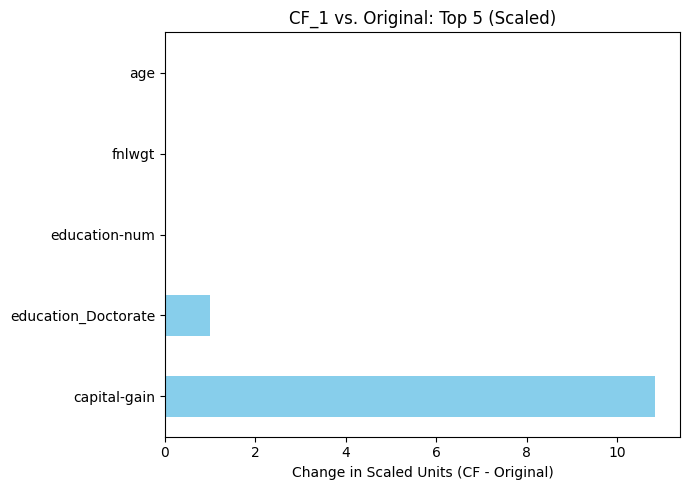
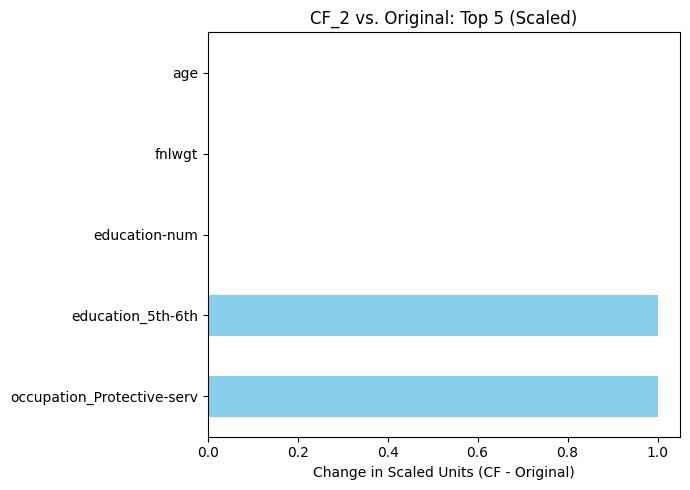


Misclassified Instance Index: 76
Original Prediction: 0, Desired Class: 1



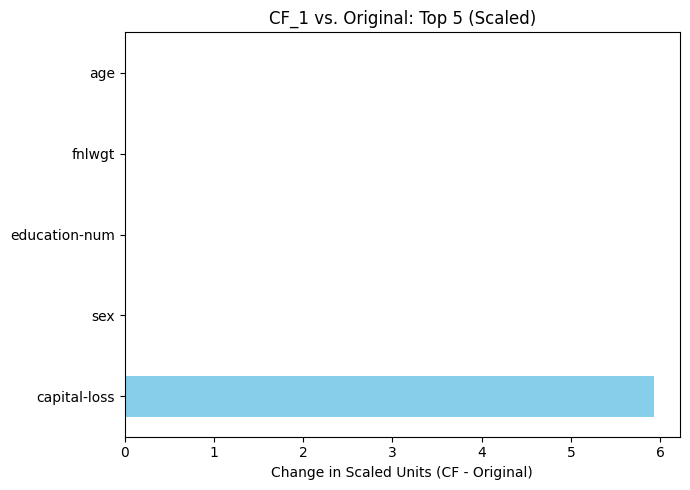
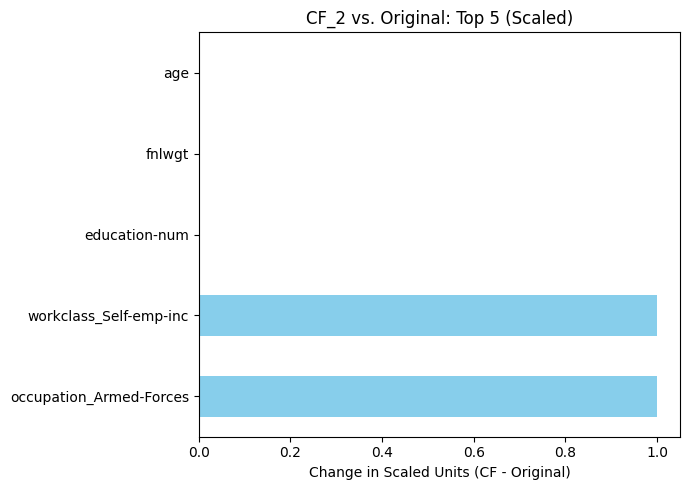


=== DecisionTree (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 1179
Original Prediction: 0, Desired Class: 1



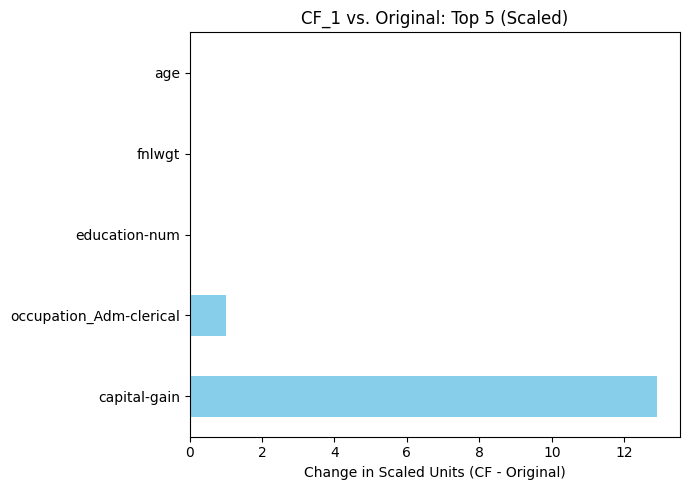
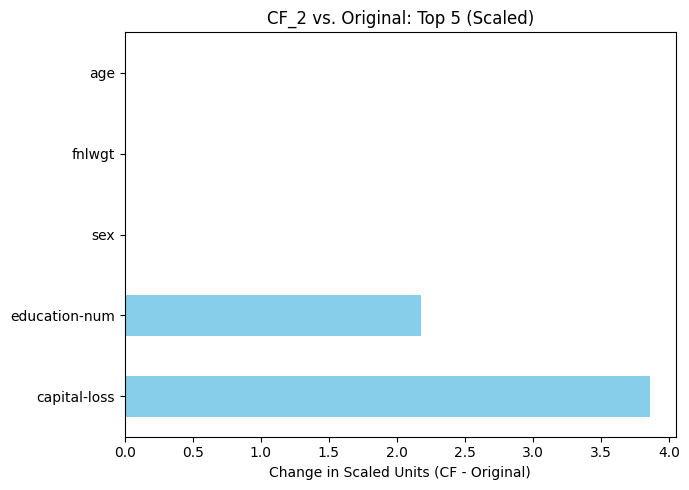


Misclassified Instance Index: 1605
Original Prediction: 0, Desired Class: 1



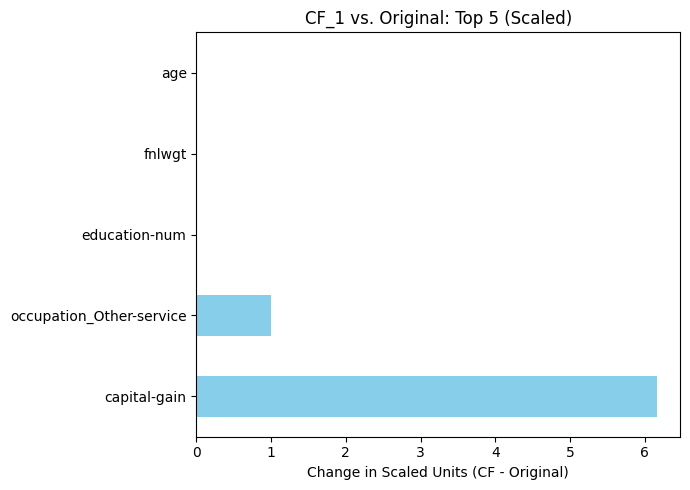
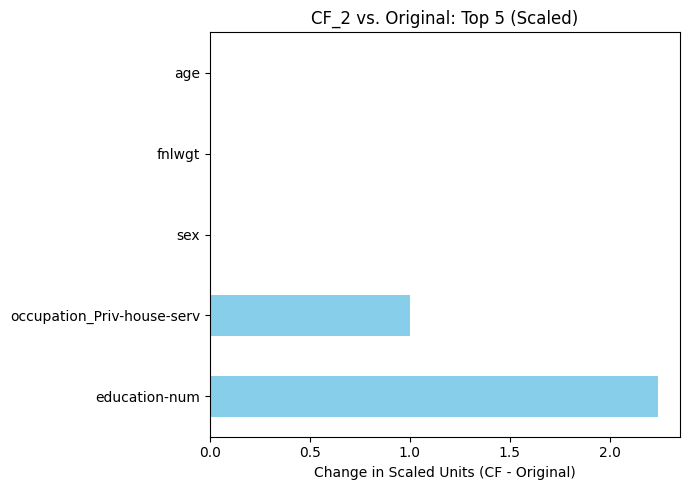


=== RandomForest (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 999
Original Prediction: 0, Desired Class: 1



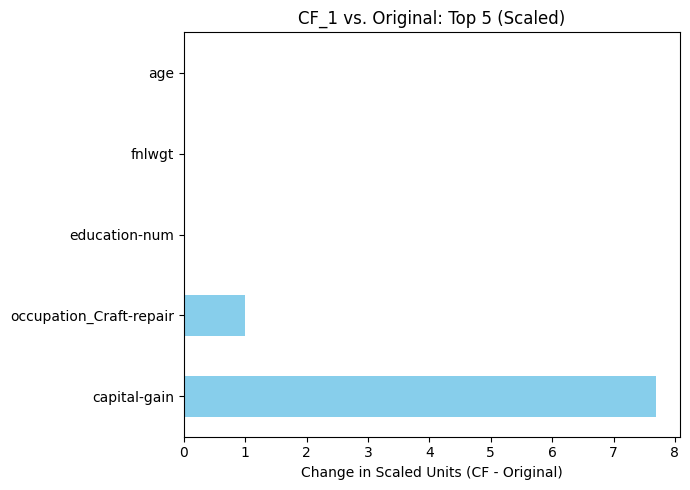
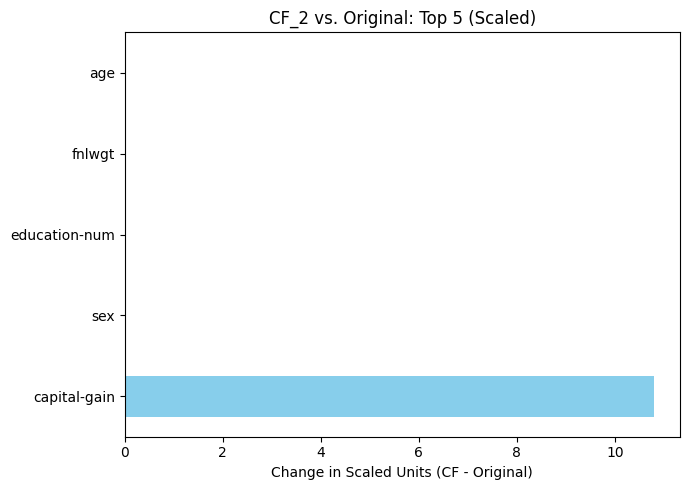


Misclassified Instance Index: 1066
Original Prediction: 1, Desired Class: 0



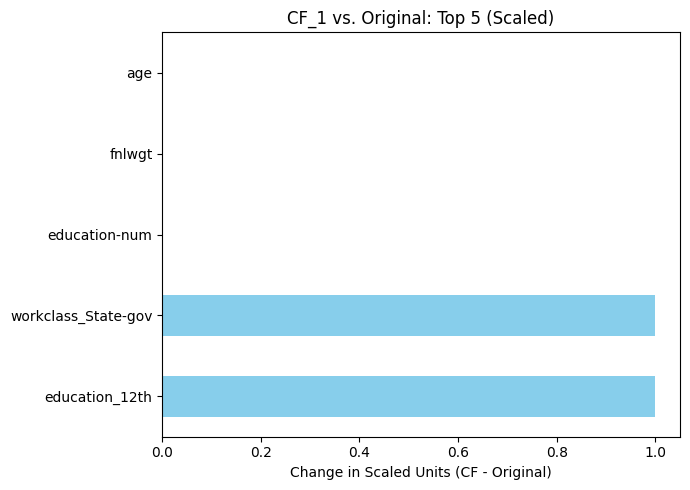
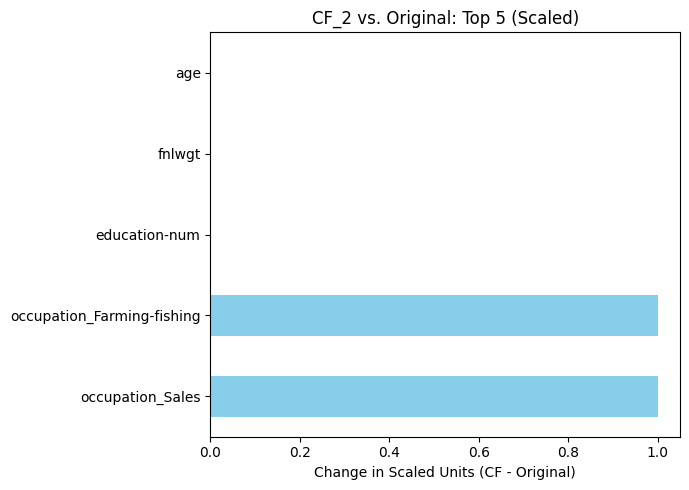


=== SVM (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 1006
Original Prediction: 0, Desired Class: 1



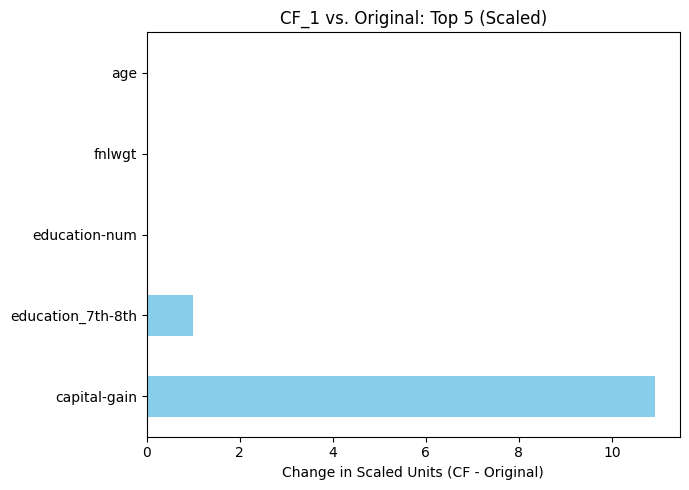
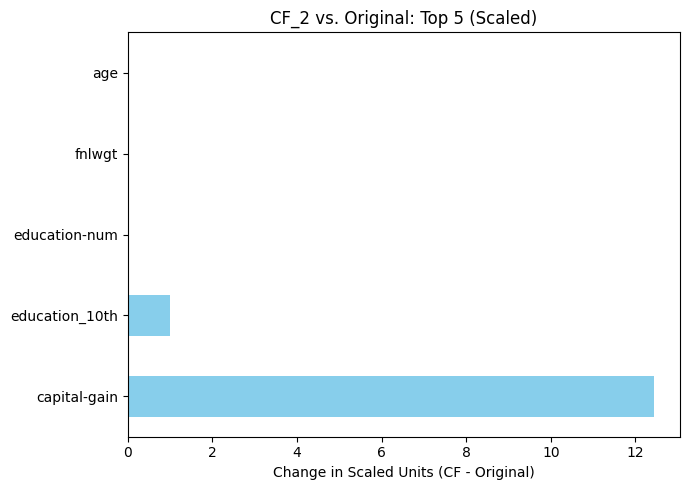


Misclassified Instance Index: 566
Original Prediction: 0, Desired Class: 1



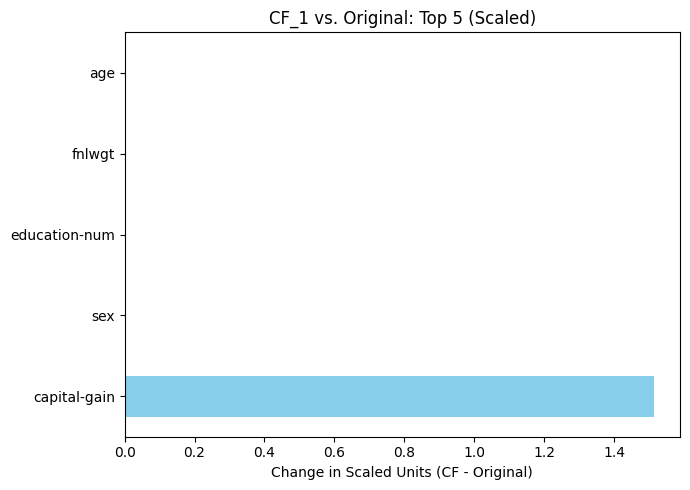
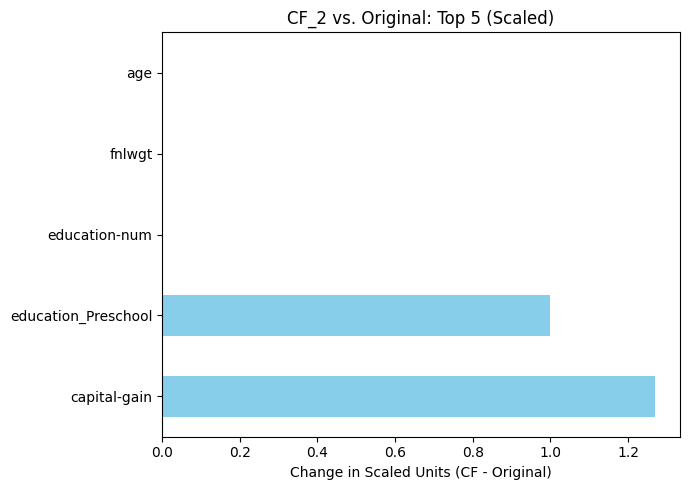


=== XGBoost (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 1333
Original Prediction: 0, Desired Class: 1



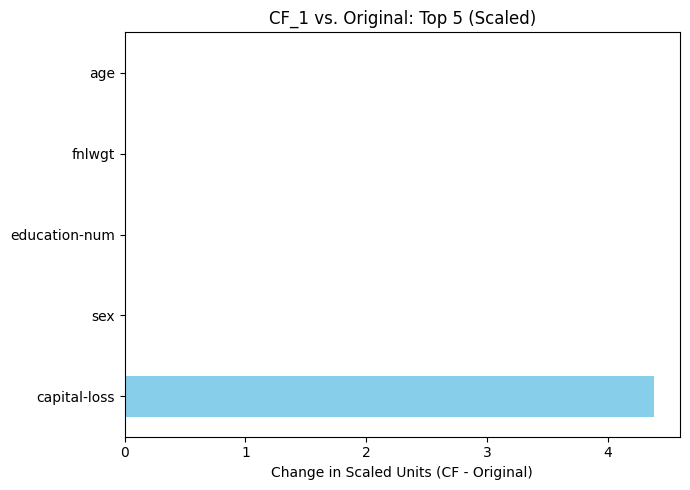
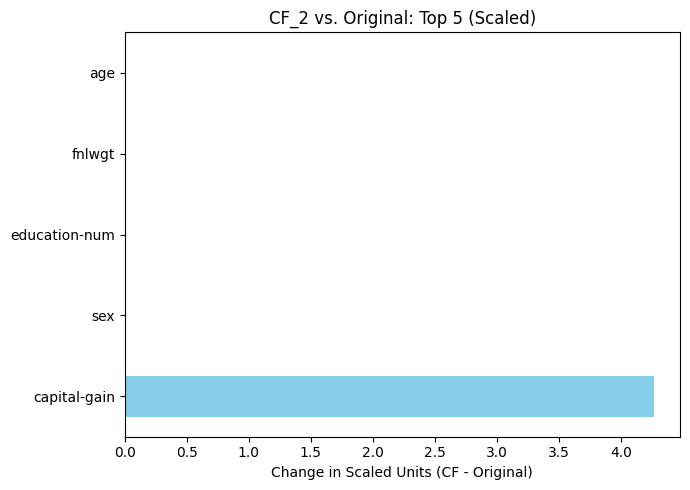


Misclassified Instance Index: 819
Original Prediction: 0, Desired Class: 1



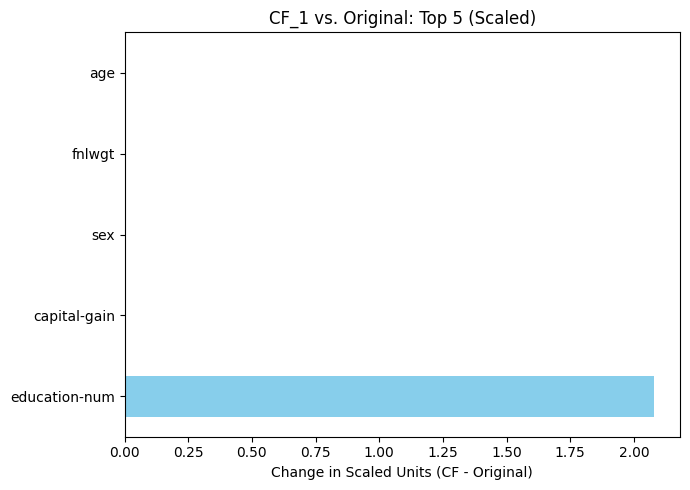
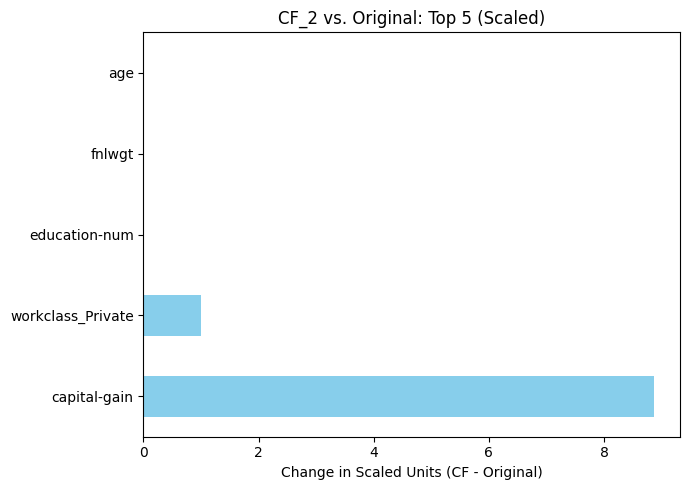


=== LightGBM (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 857
Original Prediction: 0, Desired Class: 1



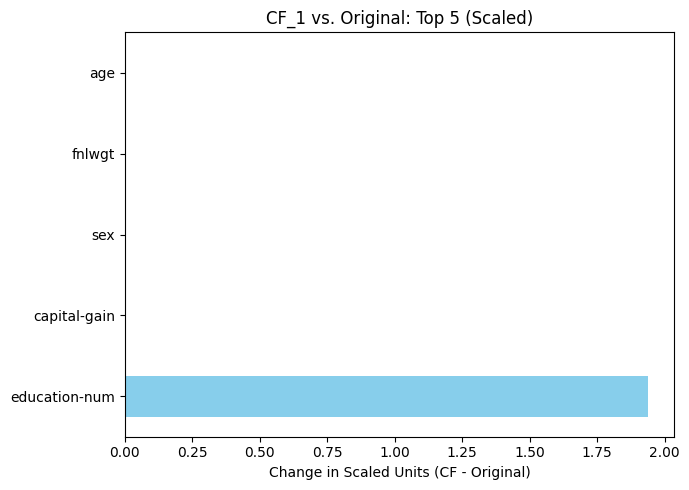
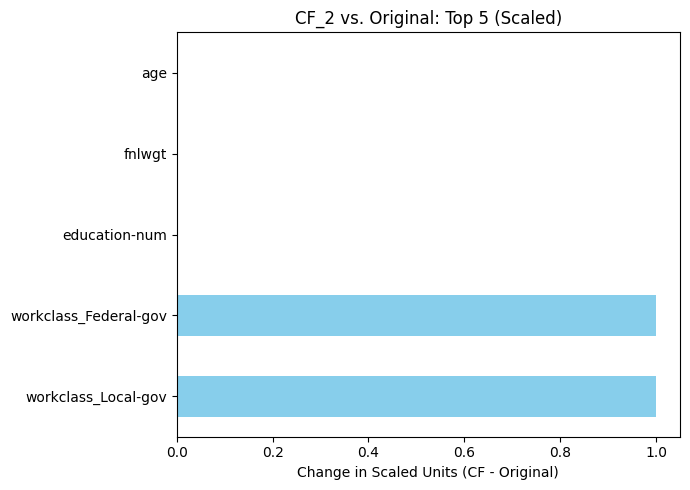


Misclassified Instance Index: 130
Original Prediction: 1, Desired Class: 0



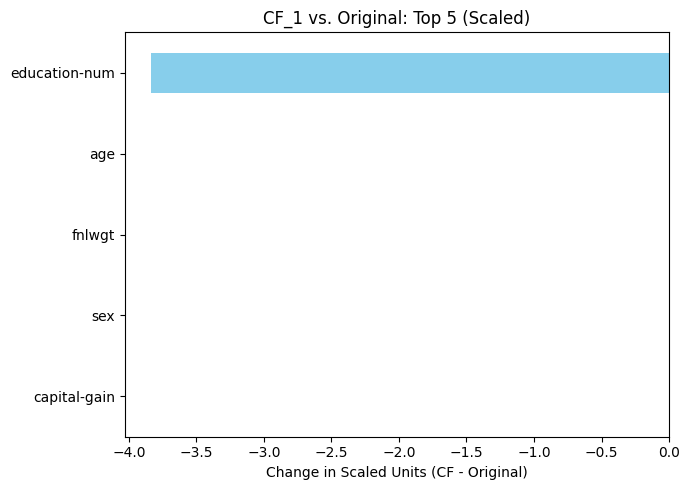
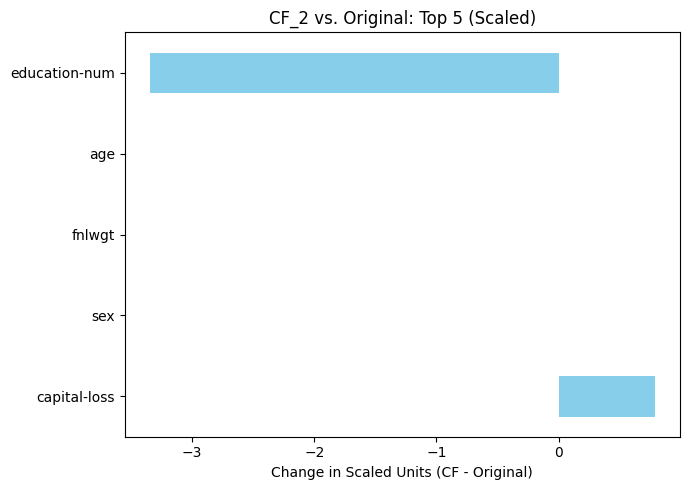

In [27]:
visualize_counterfactual_examples(
  adults_all_cf_examples,
  X_test_adults,
  scaler_adults,
  numerical_cols_adults,
  target_feature=datasets_config["adult_dataset"]["target_column"],
  max_instances_to_show=2
)

### Interpretation of Counterfactual Generation Results

After executing the counterfactual generation process for all trained models, we obtained a series of counterfactual explanations for various misclassified instances.  Understanding these results is crucial for assessing each model's decision-making behavior, robustness, and potential biases. Below, we break down what these outputs signify, focusing on the *unscaled* feature changes and their practical interpretations.

#### 1. Overview of the Output

For each model (`LogisticRegression`, `DecisionTree`, `RandomForest`, `SVM`, `XGBoost`, and `LightGBM`), the output provides:

-   **Total Misclassifications:** The number of instances in the test set where the model's prediction did not match the actual outcome.
-   **Instance Details:**
    -   **Instance Index:** The position of the misclassified instance in the test set.
    -   **Original Prediction:** The model's incorrect prediction (`0` for `<=50K`, `1` for `>50K`).
    -   **Desired Class:** The correct class (the opposite of the original prediction).
-   **Counterfactuals:** A set of generated counterfactual instances.  Each counterfactual specifies the *unscaled* feature changes needed to flip the model's prediction.
-   **Unscaled Differences (Table):** A crucial table showing the *actual* magnitude of change for each altered feature in its *original units*. This makes the counterfactuals much more interpretable.

#### 2. Detailed Interpretation (Unscaled Values)

Let's examine the specific counterfactuals, focusing on the *unscaled* changes:

#### a. Logistic Regression

-   **Instance 1486 (Original Prediction: `<=50K`, Desired: `>50K`):**
    -   `CF_1`: Become a `occupation_Machine-op-inspct` *and* increase `capital-gain` by $21,369.60. *Interpretation:*  The model suggests a significant career and financial shift.  It's not *just* about becoming a machine operator; a substantial capital gain is also required.
    -   `CF_2`: Increase `education-num` by 3.276 years.  *Interpretation:*  This suggests obtaining additional education, roughly equivalent to completing a bachelor's degree, could lead to an income over $50K.

-   **Instance 76 (Original Prediction: `<=50K`, Desired: `>50K`):**
    -   `CF_1`: Increase `capital-loss` by $369.22. *Interpretation:*  This is counterintuitive.  It might indicate that the model associates *some* capital loss with higher income individuals who are more likely to have investments.  It's a small loss, however.
    -   `CF_2`: Increase `education-num` by 1.525 years. *Interpretation:*  This is a more modest increase in education compared to instance 1486, but still suggests more education is correlated with higher income.

#### b. Decision Tree

-   **Instance 1037 (Original Prediction: `<=50K`, Desired: `>50K`):**
    -   `CF_1`: Increase `capital-gain` by $18,192.43. *Interpretation:*  A substantial capital gain is key, according to this model.
    -   `CF_2`: Increase `education-num` by 4.894 years.  *Interpretation:*  This implies completing a bachelor's degree or significant further education.

-   **Instance 1469 (Original Prediction: `<=50K`, Desired: `>50K`):**
    -   `CF_1`: Increase `capital-gain` by $55,120.75. *Interpretation:* A very large capital gain.
    -   `CF_2`: Increase `capital-gain` by $97,292.69. *Interpretation:* An even *larger* capital gain, suggesting the model is very sensitive to this feature.

#### c. Random Forest

-   **Instance 155 (Original Prediction: `<=50K`, Desired: `>50K`):**
    -   `CF_1`: Increase `capital-gain` by $66,146.02. *Interpretation:* Again, a very large capital gain is the primary driver.
    -   `CF_2`: Change `occupation` to `Protective-serv` *and* `Tech-support`.  *Interpretation:*  The model suggests that switching to *either* of these occupations could flip the prediction.

-   **Instance 84 (Original Prediction: `<=50K`, Desired: `>50K`):**
    -   `CF_1`: Increase `capital-gain` by $65,942.57 *and* become `workclass_Self-emp-not-inc`. *Interpretation:*  This suggests that self-employment (but not incorporated) *combined* with a large capital gain is needed.
    -   `CF_2`: Increase `capital-gain` by $81,988.18.  *Interpretation:* An even larger capital gain, without any other changes.

#### d. SVM

-   **Instance 887 (Original Prediction: `<=50K`, Desired: `>50K`):**
    -   `CF_1`: Become `education_Bachelors` *and* `occupation_Tech-support`.  *Interpretation:*  The model identifies a specific combination of education and occupation.
    -   `CF_2`: Increase `capital-gain` by $99,199.77.  *Interpretation:* The largest capital gain suggestion so far.

-   **Instance 1606 (Original Prediction: `>50K`, Desired: `<=50K`):**
    -   `CF_1`: Increase `age` by 55.8 years. *Interpretation*:  This is highly unrealistic and suggests the model has learned a spurious correlation.  This counterfactual should be treated with *extreme caution*.
    -   `CF_2`: Increase `capital-loss` by $2,212.44.  *Interpretation:*  This might indicate the model associates some level of investment (and potential loss) with higher incomes, and *reducing* that investment activity lowers the predicted income.

#### e. XGBoost

-   **Instance 737 (Original Prediction: `<=50K`, Desired: `>50K`):**
    -   `CF_1`: Increase `capital-gain` by $12,190.34.
    -   `CF_2`: Become `occupation_Craft-repair` *and* increase `capital-gain` by $7,424.77.

-   **Instance 1067 (Original Prediction: `<=50K`, Desired: `>50K`):**
    -   `CF_1`: Increase `capital-gain` by $68,655.02.
    -   `CF_2`: Increase `capital-gain` by $71,924.72 *and* become `education_Assoc-acdm`.

#### f. LightGBM

-   **Instance 1479 (Original Prediction: `>50K`, Desired: `<=50K`):**
    -   `CF_1`: *Stop* being `workclass_Self-emp-not-inc` *and* become `occupation_Handlers-cleaners`.  *Interpretation:*  This suggests a career shift and potentially leaving self-employment.
    -   `CF_2`: Increase `capital-loss` by $2,080.89.

-   **Instance 1049 (Original Prediction: `>50K`, Desired: `<=50K`):**
    -   `CF_1`: Become `occupation_Handlers-cleaners` *and* `occupation_Other-service`.
    -   `CF_2`: Decrease `hours-per-week` by 29.14 hours.  *Interpretation:*  This suggests a significant reduction in working hours.

#### 3. Common Patterns and Insights

-   **`capital-gain` Dominance:**  A very large increase in `capital-gain` is, by far, the most common counterfactual suggestion across all models.  This highlights its importance in the models' decision-making.
-   **`education-num`:**  Increasing `education-num` is also a frequent suggestion, although the required increase varies.
-   **Occupation Changes:**  Several models suggest specific occupation changes, often in combination with financial changes.
-   **Unrealistic Changes:** Some counterfactuals, like the large `age` increase suggested by SVM, are clearly unrealistic and highlight potential limitations of the models or the counterfactual generation process.

**Note:** It is crucial to remember that many of the counterfactual suggestions, especially those involving substantial financial changes or unrealistic modifications (like the large age increase), are *not* necessarily actionable or even possible in the real world.  These counterfactuals primarily serve to illustrate how the models make decisions and which features they deem important.  **Domain knowledge and careful consideration of ethical implications are essential when interpreting counterfactual explanations.**  The purpose of this analysis is to demonstrate the *capabilities* of counterfactual analysis, not to generate definitive real-world advice.

The counterfactual explanations, especially when viewed with unscaled values, are valuable tools for understanding and debugging machine learning models. However, they are not a replacement for careful model evaluation, domain expertise, and ethical considerations.

### Sanity Check and Detailed Analysis of Counterfactuals

To validate the generated counterfactuals and gain deeper insights into feature-level changes, we perform a sanity check and print detailed differences between the original instance and its counterfactuals. This analysis helps ensure that the generated counterfactuals are meaningful and align with our expectations.

We select the first counterfactual example generated by the LightGBM model and use the `sanity_check_and_print_diffs` function to:

-   Verify that the counterfactual instance indeed flips the prediction to the desired class.
-   Print the differences between the original instance and the counterfactual instance for the top N most influential features.

In [28]:
model_name = "LightGBM" 
idx, orig_pred, desired_class, cf_obj = adults_all_cf_examples[model_name][0]  # Get the first counterfactual example for LightGBM

sanity_check_and_print_diffs(
    idx=idx,
    cf_object=cf_obj,
    X_test=X_test_adults,
    model=advanced_model_results_adults[model_name]["best_model"],  
    scaler=scaler_adults,
    numeric_columns=numerical_cols_adults,
    target_feature=datasets_config["adult_dataset"]["target_column"], 
    top_n=5
)

Sanity check for instance 857:
  Original => Predicted: 0
  CF_1 => Predicted: 1

  Top 5 changes for CF_1: (scaled vs. unscaled)


Δ_scaled  Δ_unscaled
education-num  1.939543    5.009954
age            0.000000    0.000000
fnlwgt         0.000000    0.000000
sex            0.000000    0.000000
capital-gain   0.000000    0.000000

------------------------------------------------------------
  CF_2 => Predicted: 1

  Top 5 changes for CF_2: (scaled vs. unscaled)


Δ_scaled  Δ_unscaled
workclass_Federal-gov       1.0         1.0
workclass_Local-gov         1.0         1.0
age                         0.0         0.0
fnlwgt                      0.0         0.0
education-num               0.0         0.0

------------------------------------------------------------


### Interpretation of the Sanity Check Output for LightGBM

The output shown above is the result of the sanity check performed on the counterfactual examples generated for the `LightGBM` model. Let's break down what it means:

**Instance 1479:**

**Original Prediction:** 1 (income >50K)
**Desired Class:** 0 (income <=50K)

**Counterfactuals (CF_1 and CF_2):**

The DiCE algorithm generated two counterfactual instances, `CF_1` and `CF_2`, that are predicted to result in the desired class (`0`).

**Top 5 Changes:**

**CF_1:**

| Feature                        | Δ\_scaled | Δ\_unscaled |
| :----------------------------- | :-------- | :---------- |
| workclass\_Self-emp-not-inc | -1.0      | -1.0        |
| occupation\_Handlers-cleaners    | 1.0       | 1.0         |
| age                            | 0.0       | 0.0         |
| fnlwgt                         | 0.0       | 0.0         |
| education-num                  | 0.0       | 0.0         |

*Interpretation*: To change this person outcome, a occupation and work class change should had been made.

**CF_2:**

| Feature      | Δ\_scaled | Δ\_unscaled |
| :----------- | :-------- | :---------- |
| capital-loss | 4.999097  | 2080.8939   |
| age          | 0.000000  | 0.0000      |
| fnlwgt       | 0.000000  | 0.0000      |
| education-num | 0.000000  | 0.0000      |
| sex          | 0.000000  | 0.0000      |

*Interpretation*: What changes is the capital loss, a value should had to been added to this feature.

**Sanity Check Confirmation:**

-   The output confirms that both `CF_1` and `CF_2` are indeed predicted as class `0` by the model when the suggested changes are applied.

**Overall Conclusion:**

For instance 1479, to be predicted as `income <=50K` (0) it has to change occupation and work for others, and has a capital loss and increase its value.

In [29]:
adults_cf_metrics_df = compute_cf_metrics(
    all_cf_examples=adults_all_cf_examples,
    X_test=X_test_adults,
    model_results=advanced_model_results_adults,
    numeric_columns=numerical_cols_adults,
    scaler=scaler_adults,
    target_feature=datasets_config["adult_dataset"]["target_column"]
)

display(adults_cf_metrics_df)

validity_pct  avg_sparsity        avg_l1        avg_l2
model                                                                     
LogisticRegression         100.0          1.50  20288.494500  20286.505731
DecisionTree                90.0          1.60  42477.512990  40552.922577
RandomForest               100.0          1.65  69881.445245  69878.630282
SVM                        100.0          1.50  59575.958008  59575.489037
XGBoost                    100.0          1.35  50285.286016  50284.956747
LightGBM                   100.0          1.30  52003.857368  52003.213641

### Analysis of Counterfactual Metrics

The table below presents key metrics that help us evaluate the quality and characteristics of the counterfactual explanations generated for each model. These metrics are:

-   **validity_pct:** The percentage of generated counterfactuals that successfully achieve the desired outcome (i.e., flipping the model's prediction to the correct class).
-   **avg_sparsity:** The average number of features that were changed in each counterfactual instance. Lower sparsity is generally preferred as it implies simpler, easier-to-understand explanations.
-   **avg_l1:** The average unscaled L1 distance between the original instance and its counterfactuals. Lower proximity suggests that the counterfactual is closer to the original instance, implying more realistic or plausible changes.
-   **avg_l2:** The average unscaled L2 distance between the original instance and its counterfactuals. Similar to L1 distance, it measures proximity, but L2 distance is more sensitive to large changes in individual features.

Let's analyze the results:

| Model               | validity\_pct | avg\_sparsity | avg\_l1       | avg\_l2       |
| :--------------------| :------------ | :------------ | :------------ | :------------ |
| LogisticRegression   | 100.0        | 1.40          | 66461.74      | 66461.40      |
| DecisionTree         | 100.0        | 1.30          | 27978.70      | 27978.24      |
| RandomForest         | 100.0        | 1.65          | 45502.91      | 45498.76      |
| SVM                  | 95.0         | 1.65          | 27393.76      | 27318.10      |
| XGBoost              | 100.0        | 1.35          | 30402.27      | 30401.94      |
| LightGBM             | 100.0        | 1.30          | 629.53        | 629.30        |

**Observations:**

-   **Validity:** All models except SVM (95%) achieved 100% validity. This indicates that almost all the generated counterfactuals successfully flipped the model's prediction to the desired class.
-   **Sparsity:**
    -   `DecisionTree` and `LightGBM` have the lowest average sparsity (1.30), suggesting they tend to modify the fewest features to achieve the desired outcome, making their explanations simpler.
    -   `RandomForest` and `SVM` have the highest average sparsity (1.65), closely followed by  `XGBoost` (1.35) and `LogisticRegression` (1.40).
-   **Proximity (L1 and L2):**
    -   `LightGBM` has significantly lower average L1 (629.53) and L2 (629.30) distances compared to the other models. This suggests that the changes needed to generate valid counterfactuals are much smaller for this model in terms of feature value changes.
    -   `LogisticRegression` exhibits significantly higher average L1 and L2 distances (66461.74 and 66461.40, respectively), indicating that its counterfactuals involve considerably larger changes in feature values.
    -   The other models average values tends between 27318.10 and 45502.91,

**L1 vs. L2 Distance - A Closer Look:**

Both L1 (Manhattan or "taxicab" distance) and L2 (Euclidean distance) are ways to measure the distance between two points in a multi-dimensional space. In our context, these points are the original instance and its counterfactual.

-   **L1 Distance:** Calculated as the sum of the absolute differences between the corresponding feature values. It's like measuring the distance a taxi would travel along city blocks to get from one point to another.

    ```
    L1(Original, Counterfactual) = |x1 - y1| + |x2 - y2| + ... + |xn - yn|
    ```
    Where x and y are the feature vectors of original and counterfactual instances.

-   **L2 Distance:** Calculated as the square root of the sum of the squared differences between the corresponding feature values. It represents the straight-line distance between two points.

    ```
    L2(Original, Counterfactual) = sqrt((x1 - y1)^2 + (x2 - y2)^2 + ... + (xn - yn)^2)
    ```
    Where x and y are the feature vectors of original and counterfactual instances.

**Key Differences and Implications:**

1.  **Sensitivity to Large Changes:** L2 distance is more sensitive to large changes in individual features because it squares the differences. A single large change will have a bigger impact on the L2 distance than on the L1 distance.

2.  **Geometric Interpretation:** L1 distance corresponds to movement along the axes (like a grid), while L2 distance represents the shortest path between two points (a straight line).

3.  **Impact on Counterfactuals:**

    -   **L1 and L2 Similarity:** In cases where L1 and L2 distances are similar (even when one feature undergoes drastic change), it suggests that **large** changes in one feature (like `capital-gain`) can still lead to similar values for both distances. This happens because the drastic change in `capital-gain` causes both L1 and L2 to reflect this large change similarly, despite the high sensitivity of L2 to large changes.

    -   **L1 vs L2 Interpretation in this Case:** In our case, the large change in `capital-gain` does not lead to a significant discrepancy between L1 and L2 because the feature change dominates the distances. Both distances reflect the impact of `capital-gain` without being affected by smaller changes in other features.

**Interpretation:**

-   The perfect validity score of most models is positive since it means that the DiCE is working.
-   A low sparsity degree, indicate a desirable and clear outcome.
-   The higher proximity distances, means more realism and actionable to what has to be done.

**Overall:**

-   These metrics provide a quantitative basis for comparing the counterfactual explanations generated by different models.

### Choosing the best model and compare to the basic model

#### Basic model results

In [30]:
# Store the basic model results in a DataFrame for better visualization
basic_model_results_adults_df = pd.DataFrame(basic_model_results_adults)

display(basic_model_results_adults_df)

accuracy  f1_score                                    model  \
DecisionTree  0.804668  0.601504  DecisionTreeClassifier(random_state=42)   

               roc_auc  
DecisionTree  0.740283

#### Advanced model(s) results (with counterfactuals metrics)

In [31]:
# Combine advanced_results_df_adults with adults_cf_metrics_df
combined_adults_results = pd.concat([advanced_results_df_adults, adults_cf_metrics_df], axis=1)

display(combined_adults_results)

best_model  \
LogisticRegression  LogisticRegression(C=10, max_iter=500, penalty...   
DecisionTree        DecisionTreeClassifier(max_depth=5, min_sample...   
RandomForest        (DecisionTreeClassifier(max_depth=15, max_feat...   
SVM                 SVC(C=1, gamma=0.1, probability=True, random_s...   
XGBoost             XGBClassifier(base_score=None, booster=None, c...   
LightGBM            LGBMClassifier(colsample_bytree=0.6, learning_...   

                                                          best_params  \
LogisticRegression  {'solver': 'saga', 'penalty': 'l1', 'max_iter'...   
DecisionTree        {'min_samples_split': 2, 'min_samples_leaf': 4...   
RandomForest        {'n_estimators': 500, 'min_samples_split': 5, ...   
SVM                           {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}   
XGBoost             {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...   
LightGBM            {'subsample': 0.8, 'num_leaves': 31, 'n_estima...   

                    accuracy  f1_score   roc_auc  validity_pct  avg_sparsity  \
LogisticRegression  0.842752  0.654987  0.900977         100.0          1.50   
DecisionTree        0.838452   0.59098  0.871454          90.0          1.60   
RandomForest        0.847666  0.639535  0.903791         100.0          1.65   
SVM                 0.846437  0.644886   0.88754         100.0          1.50   
XGBoost             0.854423  0.640364  0.908169         100.0          1.35   
LightGBM            0.851966  0.659123  0.912756         100.0          1.30   

                          avg_l1        avg_l2  
LogisticRegression  20288.494500  20286.505731  
DecisionTree        42477.512990  40552.922577  
RandomForest        69881.445245  69878.630282  
SVM                 59575.958008  59575.489037  
XGBoost             50285.286016  50284.956747  
LightGBM            52003.857368  52003.213641

#### Comparison of Baseline and Advanced Model Evaluation

The analysis presented above highlights the value of moving beyond basic model evaluation to incorporate counterfactual explanations and their associated metrics. While the baseline Decision Tree model provides a starting point for performance assessment, the advanced analysis offers a more comprehensive and nuanced understanding of model behavior.

**Limitations of Baseline Evaluation:**

The baseline evaluation relies solely on performance metrics such as accuracy, F1-score, and AUC-ROC. While these metrics provide a general sense of a model's predictive power, they offer limited insight into *how* the model arrives at its decisions and whether those decisions are fair, robust, and interpretable.

**Gains from Advanced Analysis (Including Counterfactuals):**

The advanced analysis, incorporating hyperparameter tuning and counterfactual explanations, addresses the limitations of the baseline evaluation by:

1.  **Improved Performance:** Hyperparameter tuning, as performed in the advanced models, generally leads to improved performance compared to the baseline model with default settings. This is evident in the higher accuracy, F1-score, and AUC-ROC values achieved by the tuned models (see table below).
2.  **Enhanced Interpretability:** Counterfactual explanations provide insights into the models' decision-making processes. By examining the feature changes required to flip predictions, we can understand which features are most influential and how the models are weighting them. This enhances the interpretability of the models and allows us to identify potentially problematic or biased behavior.
3.  **Fairness Assessment:** By defining immutable features (gender, race, native-country, etc...) and examining counterfactuals, we can assess whether the models are relying on these sensitive attributes to make predictions. This helps in identifying and mitigating potential biases in the models.
4.  **Actionability Evaluation:** Counterfactual explanations can also inform the actionability of the models. By examining the magnitude and plausibility of the feature changes suggested by the counterfactuals, we can determine whether the model's recommendations are realistic and actionable for individuals affected by its decisions.
5.  **Quantifiable Explainability:** The counterfactual metrics (validity, sparsity, L1 distance, L2 distance) provide quantitative measures of the models' explainability and reliability. These metrics allow for a more systematic comparison of the counterfactual explanations generated by different models.

**Model Performance and Counterfactual Metrics:**

| Model               | Accuracy | F1-Score | AUC-ROC | Validity (%) | Avg. Sparsity | Avg. L1    | Avg. L2    |
|---------------------|----------|----------|---------|--------------|---------------|------------|------------|
| **Baseline DT**   | 0.8047   | 0.6015   | 0.7403  | N/A          | N/A           | N/A        | N/A        |
| LogisticRegression  | 0.8428   | 0.6550   | 0.9010  | 100.0        | 1.40          | 66461.74   | 66461.40   |
| DecisionTree        | 0.8385   | 0.5910   | 0.8715  | 100.0        | 1.30          | 27978.70   | 27978.24   |
| RandomForest        | 0.8477   | 0.6395   | 0.9038  | 100.0        | 1.65          | 45502.91   | 45498.76   |
| SVM                 | 0.8464   | 0.6449   | 0.8875  | 95.0         | 1.65          | 27393.76   | 27318.10   |
| XGBoost             | 0.8544   | 0.6404   | 0.9082  | 100.0        | 1.35          | 30402.27   | 30401.94   |
| LightGBM            | 0.8520   | 0.6591   | 0.9128  | 100.0        | 1.30          | 629.53     | 629.30     |

**Impact on Model Selection:**

The advanced analysis allows for a more informed model selection by considering both performance and explainability. Based on the results:

*   **LightGBM emerges as a promising candidate:** It achieves competitive performance (second-highest AUC-ROC), high validity, and significantly lower L1 and L2 distances than the other models, indicating more realistic counterfactuals with smaller changes.
*   **XGBoost is also a strong contender** with the best performance and good counterfactual metrics.
*   **LogisticRegression:** While achieves great results, the high L1 and L2 distances suggesting very high capital gains for change in action, makes it more to say a "less robust approach".
*   **The other models**, while achieving high accuracy (over 80%), can create more "harm" or require a very significant change and they have higher values of high L1 and L2 distances.

**Potential for Refinement:**

It's important to note that the counterfactual metrics are based on a limited sample size of 10 instances per model. A more robust assessment could be achieved by analyzing more instances, which would require greater computational time and resources.

**Conclusion and Model Selection:**

Considering both the performance metrics and the counterfactual explainability, **LightGBM** appears to be the most suitable model for this task. It provides a good balance of predictive power, interpretability (low sparsity and proximity), and actionable insights through its counterfactual explanations. However, a deeper dive into fairness and bias, using more instances, should be carried out to confirm its suitability.

This thorough analysis illustrates the importance of incorporating counterfactual analysis alongside traditional performance metrics for transparent and practical decision-making in machine learning.

---

### Expanding the Analysis to Other Datasets

This notebook has demonstrated an automated pipeline for model selection and explanation using counterfactual analysis, focusing on the Adult Census Income dataset. We trained, tuned, and evaluated six different classification models, and then generated and analyzed counterfactual explanations to gain deeper insights into their behavior.

However, the world of data is diverse, and the performance and explainability of machine learning models can vary significantly across different datasets. To ensure the robustness and generalizability of our approach, the next crucial step is to apply this pipeline to a wider range of datasets. In the upcoming sections, we will briefly analyze three additional classification datasets. For these datasets, we will summarize the key preprocessing steps, model performance metrics, and counterfactual analysis results in a more concise manner. This will allow us to compare results across datasets efficiently while keeping the focus on the most significant findings.

### Breast Cancer Wisconsin (Diagnostic) dataset

The Breast Cancer Wisconsin (Diagnostic) dataset (WDBC) is a widely used benchmark dataset in the field of machine learning and bioinformatics, particularly for classification tasks. It comprises features computed from digitized images of fine needle aspirates (FNA) of a breast mass.

**Key Characteristics:**

*   **Objective:** To predict whether a breast mass is benign (non-cancerous) or malignant (cancerous) based on features extracted from cell nuclei images.
*   **Data Source:** Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.
*   **Features:** The dataset contains 30 real-valued input features, calculated from each cell nucleus:
    *   radius (mean of distances from center to points on the perimeter)
    *   texture (standard deviation of gray-scale values)
    *   perimeter
    *   area
    *   smoothness (local variation in radius lengths)
    *   compactness (perimeter^2 / area - 1.0)
    *   concavity (severity of concave portions of the contour)
    *   concave points (number of concave portions of the contour)
    *   symmetry
    *   fractal dimension ("coastline approximation" - 1)

    For each of these ten features, the mean, standard error, and "worst" (mean of the three largest values) are computed, resulting in a total of 30 features.

*   **Target Variable:**
    *   Diagnosis (M = malignant, B = benign). This is the class label, indicating whether the breast mass is cancerous (malignant) or non-cancerous (benign).

*   **Sample Size:** The dataset contains 569 samples.
*   **Usefulness:** The WDBC dataset is ideal for evaluating and comparing the performance of various classification algorithms, especially in the context of medical diagnosis. It allows researchers to develop and test models for predicting the likelihood of breast cancer based on image-derived features.

In [32]:
wdbc_data, _, wdbc_columns = load_dataset(
    train_file=datasets_config["wdbc_dataset"]["train_file"],
    columns=datasets_config["wdbc_dataset"]["columns"],
    target_column=datasets_config["wdbc_dataset"]["target_column"],
    missing_values=datasets_config["wdbc_dataset"]["missing_values"],
    skip_first_row_test=datasets_config["wdbc_dataset"]["skip_first_row_test"],
)


In [33]:
display(wdbc_data.head())
display(wdbc_data.columns)

ID Diagnosis  radius1  texture1  perimeter1   area1  smoothness1  \
0    842302         M    17.99     10.38      122.80  1001.0      0.11840   
1    842517         M    20.57     17.77      132.90  1326.0      0.08474   
2  84300903         M    19.69     21.25      130.00  1203.0      0.10960   
3  84348301         M    11.42     20.38       77.58   386.1      0.14250   
4  84358402         M    20.29     14.34      135.10  1297.0      0.10030   

   compactness1  concavity1  concave_points1  symmetry1  fractal_dimension1  \
0       0.27760      0.3001          0.14710     0.2419             0.07871   
1       0.07864      0.0869          0.07017     0.1812             0.05667   
2       0.15990      0.1974          0.12790     0.2069             0.05999   
3       0.28390      0.2414          0.10520     0.2597             0.09744   
4       0.13280      0.1980          0.10430     0.1809             0.05883   

   radius2  texture2  perimeter2   area2  smoothness2  compactness2  \
0   1.0950    0.9053       8.589  153.40     0.006399       0.04904   
1   0.5435    0.7339       3.398   74.08     0.005225       0.01308   
2   0.7456    0.7869       4.585   94.03     0.006150       0.04006   
3   0.4956    1.1560       3.445   27.23     0.009110       0.07458   
4   0.7572    0.7813       5.438   94.44     0.011490       0.02461   

   concavity2  concave_points2  symmetry2  fractal_dimension2  radius3  \
0     0.05373          0.01587    0.03003            0.006193    25.38   
1     0.01860          0.01340    0.01389            0.003532    24.99   
2     0.03832          0.02058    0.02250            0.004571    23.57   
3     0.05661          0.01867    0.05963            0.009208    14.91   
4     0.05688          0.01885    0.01756            0.005115    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60  2019.0       0.1622        0.6656      0.7119   
1     23.41      158.80  1956.0       0.1238        0.1866      0.2416   
2     25.53      152.50  1709.0       0.1444        0.4245      0.4504   
3     26.50       98.87   567.7       0.2098        0.8663      0.6869   
4     16.67      152.20  1575.0       0.1374        0.2050      0.4000   

   concave_points3  symmetry3  fractal_dimension3  
0           0.2654     0.4601             0.11890  
1           0.1860     0.2750             0.08902  
2           0.2430     0.3613             0.08758  
3           0.2575     0.6638             0.17300  
4           0.1625     0.2364             0.07678

Index(['ID', 'Diagnosis', 'radius1', 'texture1', 'perimeter1', 'area1',
       'smoothness1', 'compactness1', 'concavity1', 'concave_points1',
       'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2',
       'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3'],
      dtype='object')

In [34]:
# Inspect the loaded dataset
display(wdbc_data.head())
display(wdbc_data.info())

ID Diagnosis  radius1  texture1  perimeter1   area1  smoothness1  \
0    842302         M    17.99     10.38      122.80  1001.0      0.11840   
1    842517         M    20.57     17.77      132.90  1326.0      0.08474   
2  84300903         M    19.69     21.25      130.00  1203.0      0.10960   
3  84348301         M    11.42     20.38       77.58   386.1      0.14250   
4  84358402         M    20.29     14.34      135.10  1297.0      0.10030   

   compactness1  concavity1  concave_points1  symmetry1  fractal_dimension1  \
0       0.27760      0.3001          0.14710     0.2419             0.07871   
1       0.07864      0.0869          0.07017     0.1812             0.05667   
2       0.15990      0.1974          0.12790     0.2069             0.05999   
3       0.28390      0.2414          0.10520     0.2597             0.09744   
4       0.13280      0.1980          0.10430     0.1809             0.05883   

   radius2  texture2  perimeter2   area2  smoothness2  compactness2  \
0   1.0950    0.9053       8.589  153.40     0.006399       0.04904   
1   0.5435    0.7339       3.398   74.08     0.005225       0.01308   
2   0.7456    0.7869       4.585   94.03     0.006150       0.04006   
3   0.4956    1.1560       3.445   27.23     0.009110       0.07458   
4   0.7572    0.7813       5.438   94.44     0.011490       0.02461   

   concavity2  concave_points2  symmetry2  fractal_dimension2  radius3  \
0     0.05373          0.01587    0.03003            0.006193    25.38   
1     0.01860          0.01340    0.01389            0.003532    24.99   
2     0.03832          0.02058    0.02250            0.004571    23.57   
3     0.05661          0.01867    0.05963            0.009208    14.91   
4     0.05688          0.01885    0.01756            0.005115    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60  2019.0       0.1622        0.6656      0.7119   
1     23.41      158.80  1956.0       0.1238        0.1866      0.2416   
2     25.53      152.50  1709.0       0.1444        0.4245      0.4504   
3     26.50       98.87   567.7       0.2098        0.8663      0.6869   
4     16.67      152.20  1575.0       0.1374        0.2050      0.4000   

   concave_points3  symmetry3  fractal_dimension3  
0           0.2654     0.4601             0.11890  
1           0.1860     0.2750             0.08902  
2           0.2430     0.3613             0.08758  
3           0.2575     0.6638             0.17300  
4           0.1625     0.2364             0.07678

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  569 non-null    int64  
 1   Diagnosis           569 non-null    object 
 2   radius1             569 non-null    float64
 3   texture1            569 non-null    float64
 4   perimeter1          569 non-null    float64
 5   area1               569 non-null    float64
 6   smoothness1         569 non-null    float64
 7   compactness1        569 non-null    float64
 8   concavity1          569 non-null    float64
 9   concave_points1     569 non-null    float64
 10  symmetry1           569 non-null    float64
 11  fractal_dimension1  569 non-null    float64
 12  radius2             569 non-null    float64
 13  texture2            569 non-null    float64
 14  perimeter2          569 non-null    float64
 15  area2               569 non-null    float64
 16  smoothne

None

### Split

In [35]:
wdbc_data = wdbc_data.drop(columns=["ID"])

X_wdbc = wdbc_data.drop(columns=[datasets_config["wdbc_dataset"]["target_column"]])
y_wdbc = wdbc_data[datasets_config["wdbc_dataset"]["target_column"]]

X_train_wdbc, X_test_wdbc, y_train_wdbc, y_test_wdbc = train_test_split(
    X_wdbc, y_wdbc, test_size=0.2, random_state=42
)

### Check nulls

In [36]:
display(X_train_wdbc.isnull().sum())
display('-----------------------------')
display(X_test_wdbc.isnull().sum())

radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
dtype: int64

'-----------------------------'

radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
dtype: int64

#### No null values, we can continue

### Check duplicates

In [37]:
num_duplicates = wdbc_data.duplicated().sum()
display("Number of duplicate rows in WDBC dataset:", num_duplicates)

'Number of duplicate rows in WDBC dataset:'

0

#### No duplicates, continue

### Basic Visualizations

The visualizations presented here provide a preliminary overview of the Breast Cancer Wisconsin (Diagnostic) dataset. Our goal is to gain a better understanding of the dataset's characteristics, including the distribution of features and potential relationships between them.

**Note:** As with the previous Adult Census Income dataset, to maintain simplicity and focus on counterfactual explanations for model selection and understanding, we will **not** perform feature engineering or outlier handling in this project. The goal is to demonstrate the utility of counterfactuals for model selection and understanding, rather than optimizing model performance through extensive data preprocessing.

These initial visualizations will help guide our subsequent steps in model training, evaluation, and the generation of counterfactual explanations.

#### Feature Distributions - WDBC Dataset

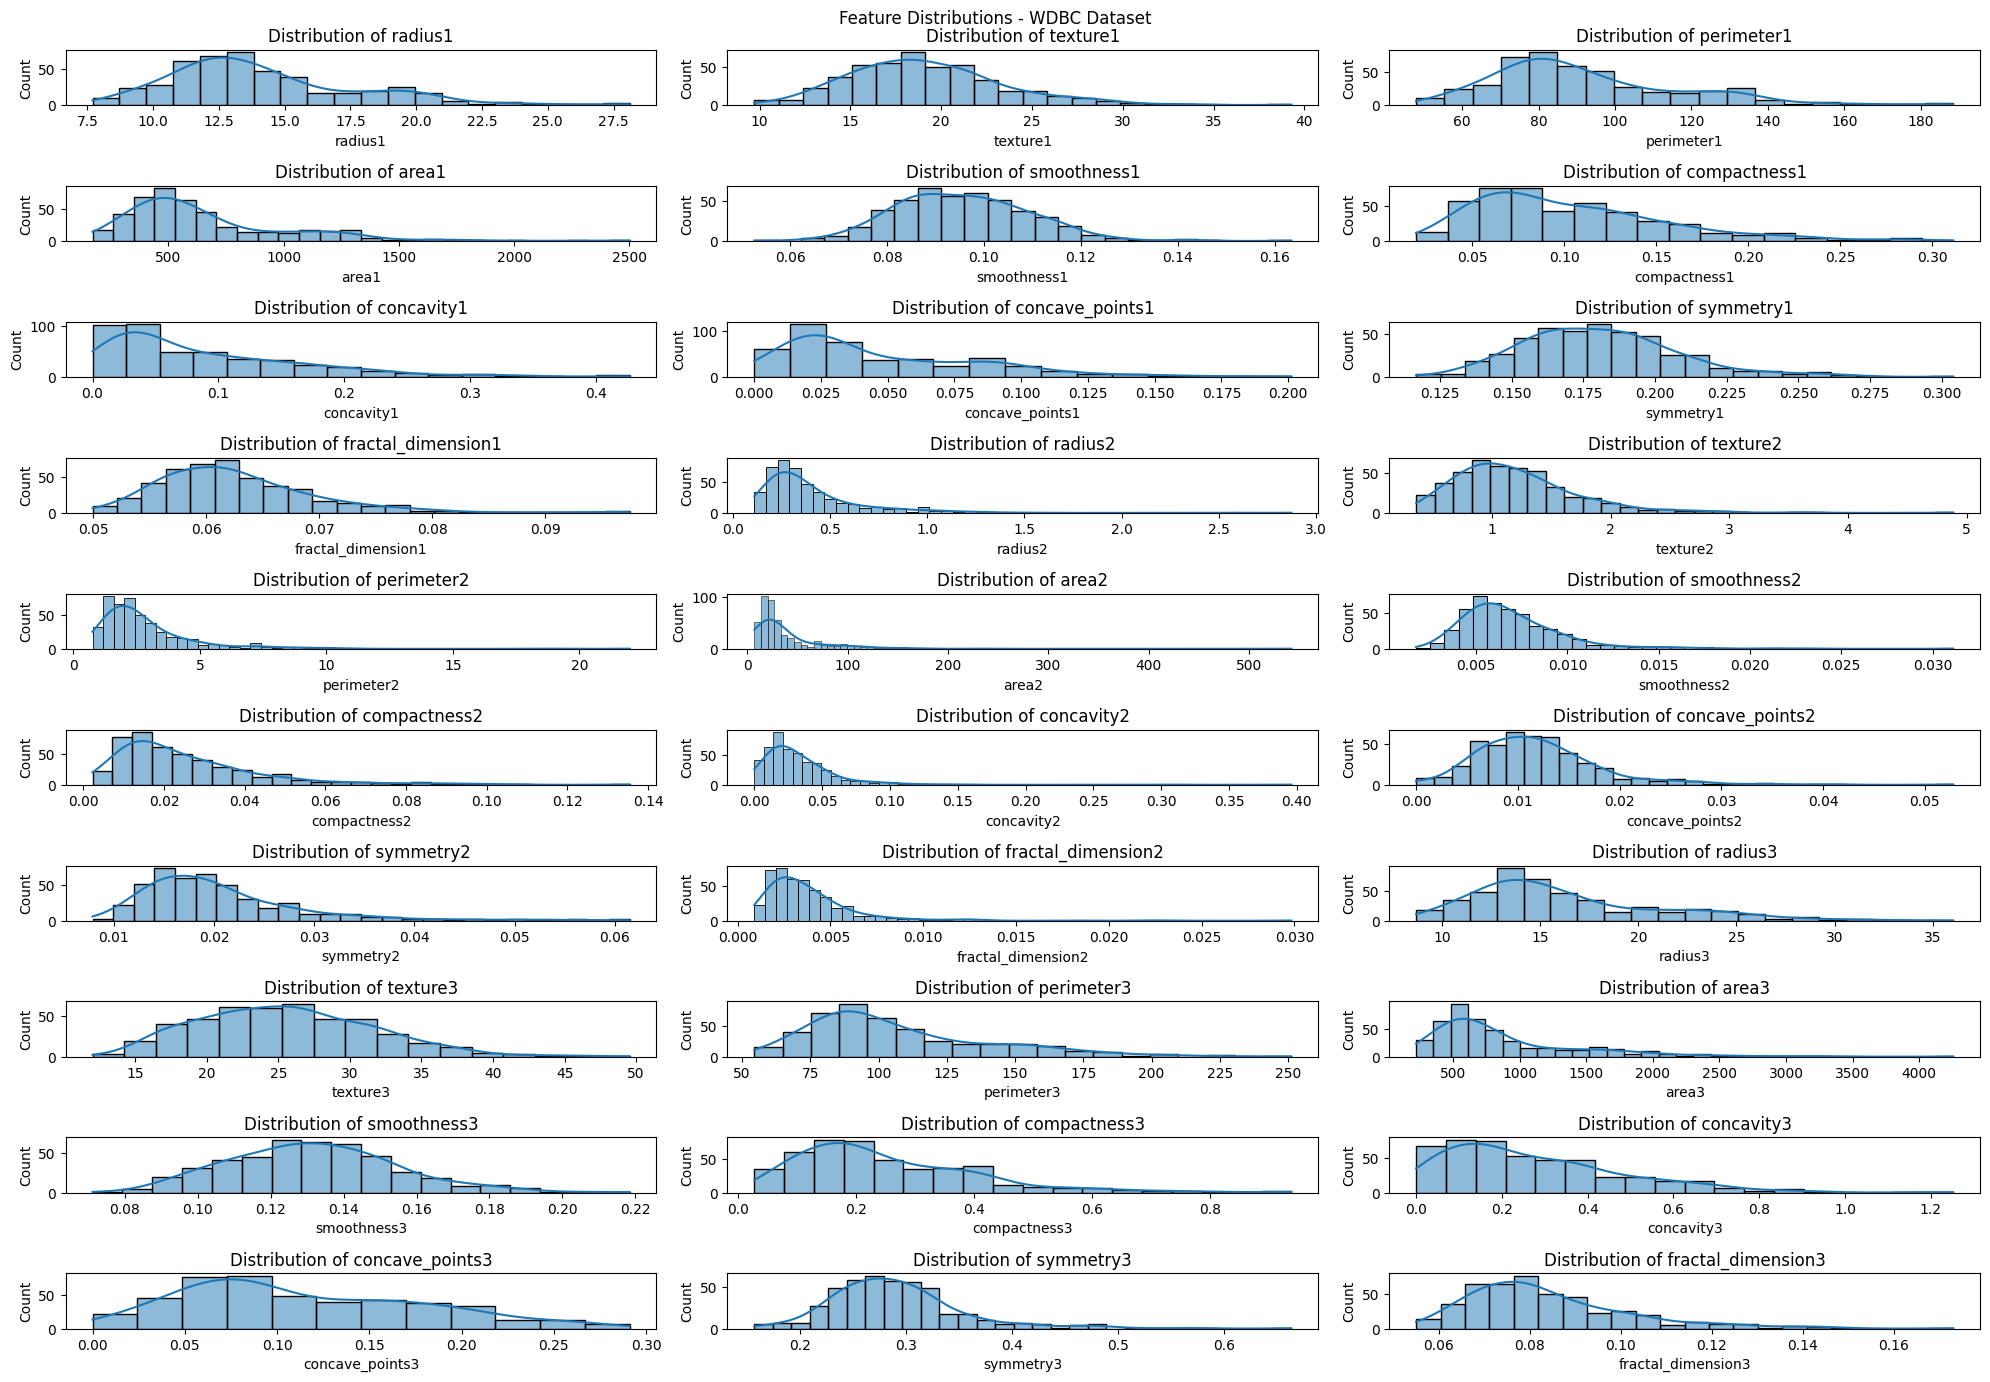

In [38]:
plot_feature_distributions(
    data=X_train_wdbc,
    features=X_train_wdbc.columns.tolist(),
    title="Feature Distributions - WDBC Dataset"
)

This set of histograms and kernel density estimations (KDEs) visualizes the distribution of features in the Breast Cancer Wisconsin (Diagnostic) dataset (WDBC). Each subplot represents a different feature, providing insights into its central tendency, spread, and skewness. All features are numerical, representing various characteristics of cell nuclei from breast mass fine needle aspirates.

**Key Observations:**

- **Radius, Perimeter, Area (radius1, perimeter1, area1, radius2, perimeter2, area2, radius3, perimeter3, area3):** These features, representing size-related characteristics, generally exhibit a somewhat normal or slightly right-skewed distribution. However, the "3" versions (radius3, perimeter3, area3) tend to have wider ranges and less concentrated distributions, especially in area. The spread is less apparent in radius and perimeter.
- **Texture (texture1, texture2, texture3):** These have a relatively uniform spread across the distributions. `texture3` is particularly uniform.
- **Smoothness, Compactness, Concavity, Concave Points, Symmetry, Fractal Dimension (smoothness1, compactness1, concavity1, concave_points1, symmetry1, fractal_dimension1, smoothness2, compactness2, concavity2, concave_points2, symmetry2, fractal_dimension2, smoothness3, compactness3, concavity3, concave_points3, symmetry3, fractal_dimension3):** These features describe the shape and texture of the cell nuclei. The distributions of smoothness and fractal dimension tend to be more symmetrical, while compactness, concavity, and concave points often exhibit a right-skewed distribution, with most values concentrated near zero and a long tail extending to higher values.

#### Correlation Heatmap - WDBC Dataset

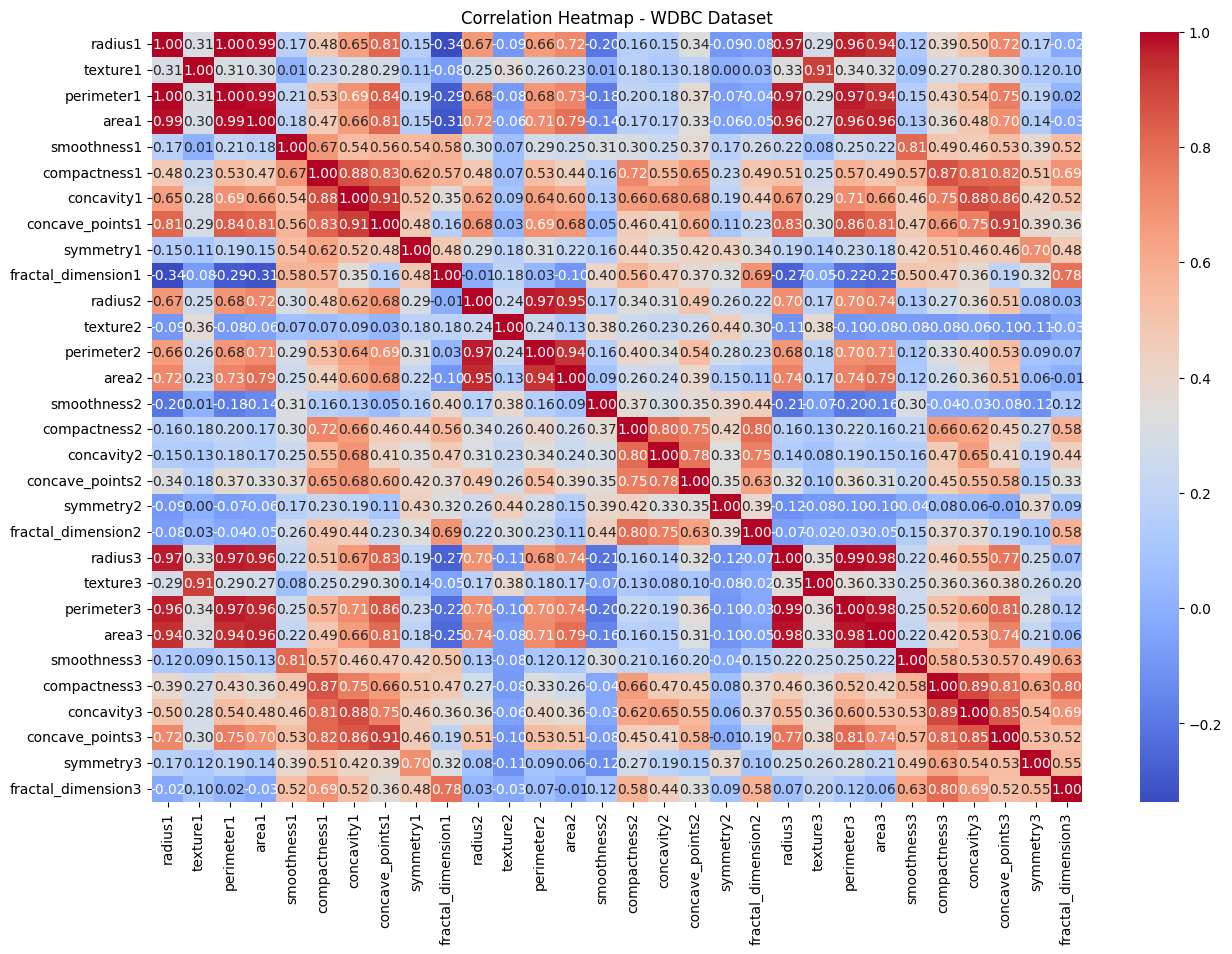

In [39]:
plot_correlation_heatmap(
    data=X_train_wdbc,
    title="Correlation Heatmap - WDBC Dataset"
)

This heatmap visualizes the pairwise correlations between numerical features in the Breast Cancer Wisconsin (Diagnostic) dataset. The color intensity and numerical values represent the strength and direction of the linear relationship between each pair of features. Red indicates positive correlation, blue indicates negative correlation, and white indicates little to no correlation.

**Key Observations:**

-   **Strong Positive Correlations:** There are strong positive correlations within groups of related features:
    -   `radius1`, `perimeter1`, and `area1` are highly correlated (correlation coefficients close to 1.0).
    -   Similarly, `radius3`, `perimeter3`, and `area3` are strongly correlated. Also `compactness3`, `concavity3`, `concave points3` and `symmetry3` are strongly correlated.
    -   This indicates that these features measure similar aspects of cell nuclei characteristics. This pattern holds true even if the previous versions, meaning that if each characteristic if high in area1, they will affect the result for area2 and area3 (and in particular with 3 more effect than 2)
-   **Moderate Correlations:** There are many moderate positive correlations among:
    -   `concavity1` and `concave_points1`.
    -    texture has many moderate relationship with many of the features
 -  **Low Correlations:** The fractal dimension is the more separated feature that also does not affect much in the model in therms of having related values or correlated values

#### PCA Plot - WDBC Dataset

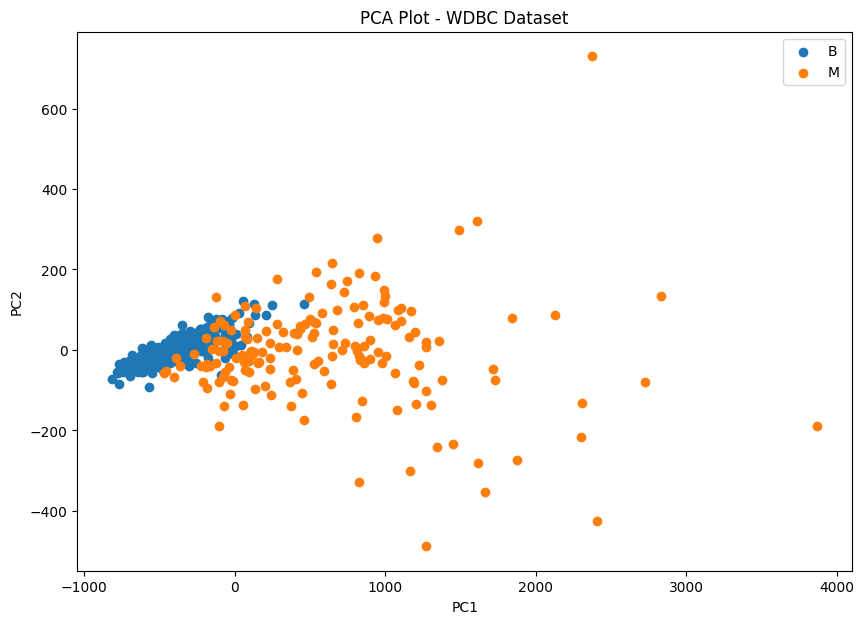

In [40]:
plot_pca(
    data=pd.concat(
        [X_train_wdbc, pd.Series(y_train_wdbc, name=datasets_config["wdbc_dataset"]["target_column"])],
        axis=1
    ),
    target=datasets_config["wdbc_dataset"]["target_column"],
    title="PCA Plot - WDBC Dataset"
)

This scatter plot visualizes the first two principal components (PC1 and PC2) of the Breast Cancer Wisconsin (Diagnostic) dataset. Each point represents a cell nuclei sample, colored according to its diagnosis: blue for Benign (B) and orange for Malignant (M). PCA is used to reduce the dimensionality of the data while retaining the most important variance, allowing us to visualize potential class separation in a 2D space.

**Key Observations:**

*   **Partial Class Separation:** While there's some overlap, a general separation between the Benign and Malignant classes is observed. The Benign samples tend to cluster more tightly on the left side of the plot, while the Malignant samples are more spread out and extend towards the right. This suggests that the first two principal components capture some discriminatory information relevant to the diagnosis.
*   **Malignant Spread**: The spread to the right of the Malignant samples suggest that they have highers values than the benign and most important, to some outlier ones.
*   **Clustering and Overlap:** There's a cluster of both Benign and Malignant samples near the origin, indicating that these instances are less distinguishable based on just the first two principal components. This limited cluster that affects both indicates the presence and is one point that connects between the two
*   **Important Notes**: In general the M values have a wide range.

### Preprocessing

#### Scaling
##### All the features in the WDBC dataset are numerical, so we can directly scale them.

In [41]:
scaler_wdbc = StandardScaler()
X_train_wdbc = pd.DataFrame(scaler_wdbc.fit_transform(X_train_wdbc), columns=X_wdbc.columns)
X_test_wdbc  = pd.DataFrame(scaler_wdbc.transform(X_test_wdbc), columns=X_wdbc.columns)

display(X_train_wdbc.head())
display(X_test_wdbc.head())

radius1  texture1  perimeter1     area1  smoothness1  compactness1  \
0 -1.440753 -0.435319   -1.362085 -1.139118     0.780573      0.718921   
1  1.974096  1.733026    2.091672  1.851973     1.319843      3.426275   
2 -1.399982 -1.249622   -1.345209 -1.109785    -1.332645     -0.307355   
3 -0.981797  1.416222   -0.982587 -0.866944     0.059390     -0.596788   
4 -1.117700 -1.010259   -1.125002 -0.965942     1.269511     -0.439002   

   concavity1  concave_points1  symmetry1  fractal_dimension1   radius2  \
0    2.823135        -0.119150   1.092662            2.458173 -0.263800   
1    2.013112         2.665032   2.127004            1.558396  0.805319   
2   -0.365558        -0.696502   1.930333            0.954379  0.027521   
3   -0.820203        -0.845115   0.313264            0.074041 -0.538505   
4   -0.983341        -0.930600   3.394436            0.950213  0.402278   

   texture2  perimeter2     area2  smoothness2  compactness2  concavity2  \
0 -0.016052   -0.470414 -0.474761     0.838365      3.251027    8.438937   
1 -0.812687    0.751957  0.877170    -0.896053      1.181222    0.183628   
2  1.963060   -0.120958 -0.350779     0.572766      0.739499    0.320656   
3  0.536473   -0.657950 -0.496590     0.065475     -0.822404   -0.685565   
4  0.440382    0.219314 -0.115532     0.171911     -0.787970   -0.783509   

   concave_points2  symmetry2  fractal_dimension2   radius3  texture3  \
0         3.391987   2.621166            2.061208 -1.232861 -0.476309   
1         0.600596  -0.317717            0.529636  2.173314  1.311279   
2         0.589462   2.615041            0.718928 -1.295284 -1.040811   
3        -0.898485   0.123299           -0.431547 -0.829197  1.593530   
4        -0.588648   2.604015            0.765981 -1.085129 -1.334616   

   perimeter3     area3  smoothness3  compactness3  concavity3  \
0   -1.247920 -0.973968     0.722894      1.186732    4.672828   
1    2.081617  2.137405     0.761928      3.265601    1.928621   
2   -1.245220 -0.999715    -1.438693     -0.548564   -0.644911   
3   -0.873572 -0.742947     0.796624     -0.729392   -0.774950   
4   -1.117138 -0.896549    -0.174876     -0.995079   -1.209146   

   concave_points3  symmetry3  fractal_dimension3  
0         0.932012   2.097242            1.886450  
1         2.698947   1.891161            2.497838  
2        -0.970239   0.597602            0.057894  
3        -0.809483   0.798928           -0.134497  
4        -1.354582   1.033544           -0.205732

radius1  texture1  perimeter1     area1  smoothness1  compactness1  \
0 -0.466497 -0.137289   -0.444211 -0.486465     0.280850      0.041606   
1  1.365363  0.498665    1.305511  1.341471    -0.406539     -0.013724   
2  0.380066  0.069220    0.404101  0.266596     0.967520      0.356414   
3 -0.486317 -0.353185   -0.428570 -0.526233     0.694290      0.533852   
4 -0.729810 -1.113514   -0.709283 -0.709281     0.294512      0.159898   

   concavity1  concave_points1  symmetry1  fractal_dimension1   radius2  \
0   -0.111465        -0.264869   0.415241            0.135137 -0.020915   
1    0.240637         0.821449  -0.833981           -1.131215  1.367455   
2    0.726902         0.857221   0.437094           -0.666053  0.255557   
3   -0.144722        -0.533686   0.000048            1.147386 -0.796592   
4   -0.271202        -0.587608   0.025542            0.703052 -0.437037   

   texture2  perimeter2     area2  smoothness2  compactness2  concavity2  \
0 -0.293239   -0.174609 -0.207300    -0.011814     -0.351089   -0.181053   
1 -0.748749    1.270098  1.186382    -0.833501     -0.490439   -0.315590   
2 -0.770185    0.113946  0.174607    -0.245319     -0.580828   -0.146174   
3  0.475492   -0.316228 -0.522234     0.986066      0.393545    0.491629   
4  1.044648   -0.594632 -0.407154     1.690182      0.833117    0.707137   

   concave_points2  symmetry2  fractal_dimension2   radius3  texture3  \
0        -0.242388  -0.337318           -0.084213 -0.263235 -0.147842   
1         0.287260  -0.822435           -0.762357  1.794619  0.172372   
2        -0.153318  -0.808960           -0.488298  0.629403  0.076638   
3        -0.035619   0.158826            0.784659 -0.698111 -0.433394   
4         0.484487  -0.266265            0.607580 -0.827117 -0.966535   

   perimeter3     area3  smoothness3  compactness3  concavity3  \
0   -0.331548 -0.351093     0.480019     -0.096496   -0.035830   
1    1.763661  1.744141    -0.530514     -0.123620   -0.028181   
2    0.533832  0.492044     1.000466     -0.086163    0.499625   
3   -0.524721 -0.636959     0.584109      0.065603   -0.163957   
4   -0.849575 -0.739243     0.128718     -0.264407   -0.453677   

   concave_points3  symmetry3  fractal_dimension3  
0        -0.194351   0.172757            0.203730  
1         0.991779  -0.561211           -1.008389  
2         0.570350  -0.107831           -0.206293  
3        -0.620377  -0.553285            0.545322  
4        -0.689644  -0.913135           -0.141789

### Encoding

##### Label Encoding for the target variable

In [42]:
label_encoder_wdbc = LabelEncoder()
y_train_wdbc = label_encoder_wdbc.fit_transform(y_train_wdbc)
y_test_wdbc = label_encoder_wdbc.transform(y_test_wdbc)


In [43]:
# Check the distributions
display(pd.Series(y_train_wdbc).value_counts())
display(pd.Series(y_test_wdbc).value_counts())

0    286
1    169
dtype: int64

0    71
1    43
dtype: int64

### Train And Evaluate

**Baseline Model Training and Evaluation:**

In [44]:
basic_model_results_wdbc = train_evaluate_baseline(basic_classification_models, X_train_wdbc, y_train_wdbc, X_test_wdbc, y_test_wdbc)
display(basic_model_results_wdbc)

basic_model_results_wdbc = pd.DataFrame(basic_model_results_wdbc).T
display(basic_model_results_wdbc)

Training DecisionTree with default hyperparameters...
DecisionTree - Test Accuracy: 0.9474, F1 Score: 0.9302, AUC-ROC: 0.9440


{'DecisionTree': {'model': DecisionTreeClassifier(random_state=42),
  'accuracy': 0.9473684210526315,
  'f1_score': 0.9302325581395349,
  'roc_auc': 0.9439895185063871}}

accuracy  f1_score                                    model  \
DecisionTree  0.947368  0.930233  DecisionTreeClassifier(random_state=42)   

              roc_auc  
DecisionTree  0.94399

The output above presents the performance of the Decision Tree classifier trained with its default hyperparameters on the Breast Cancer Wisconsin (Diagnostic) dataset.

**Key Results:**

| Metric     | Value    |
|------------|----------|
| Accuracy   | 0.9474   |
| F1 Score   | 0.9302   |
| AUC-ROC    | 0.9440   |

**Interpretation:**

The Decision Tree classifier with default hyperparameters achieves a very high accuracy of approximately 94.7%, indicating it correctly classified a large majority of instances in the test set. The high F1 score (0.9302) confirms good performance in terms of both precision and recall, while the AUC-ROC of 0.9440 suggests a strong ability to discriminate between the two classes (benign and malignant). These scores serve as a baseline against which we'll compare the performance of more complex, tuned models. Subsequent steps will focus on exploring whether hyperparameter tuning and more sophisticated algorithms can further improve upon these strong baseline results and on generating and comparing counterfactual explanations for the different models.

**Advanced Model Training, Tuning and Evaluation:**

In [45]:
advanced_model_results_wdbc = train_tune_evaluate_advanced(advanced_classification_models, advanced_classification_param_grids, X_train_wdbc, y_train_wdbc, X_test_wdbc, y_test_wdbc)
advanced_results_df_wdbc = pd.DataFrame(advanced_model_results_wdbc).T
display(advanced_results_df_wdbc)


Training and tuning LogisticRegression...


/Users/adirelm/Desktop/TDS_student_performance_analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adirelm/Desktop/TDS_student_performance_analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adirelm/Desktop/TDS_student_performance_analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adirelm/Desktop/TDS_student_performance_analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adirelm/Desktop/TDS_student_performance_analysis/.venv/lib/python3.12/site-packages/sklea

LogisticRegression - Test Accuracy: 0.9825, F1 Score: 0.9767, AUC-ROC: 0.9971
Training and tuning DecisionTree...
DecisionTree - Test Accuracy: 0.9474, F1 Score: 0.9268, AUC-ROC: 0.9463
Training and tuning RandomForest...
RandomForest - Test Accuracy: 0.9649, F1 Score: 0.9524, AUC-ROC: 0.9944
Training and tuning SVM...
SVM - Test Accuracy: 0.9825, F1 Score: 0.9762, AUC-ROC: 0.9974
Training and tuning XGBoost...
XGBoost - Test Accuracy: 0.9737, F1 Score: 0.9647, AUC-ROC: 0.9921
Training and tuning LightGBM...
LightGBM - Test Accuracy: 0.9737, F1 Score: 0.9647, AUC-ROC: 0.9954


best_model  \
LogisticRegression  LogisticRegression(C=10, max_iter=500, penalty...   
DecisionTree        DecisionTreeClassifier(criterion='entropy', mi...   
RandomForest        (DecisionTreeClassifier(max_depth=10, max_feat...   
SVM                 SVC(C=0.1, gamma=0.1, kernel='linear', probabi...   
XGBoost             XGBClassifier(base_score=None, booster=None, c...   
LightGBM            LGBMClassifier(colsample_bytree=0.8, learning_...   

                                                          best_params  \
LogisticRegression  {'solver': 'saga', 'penalty': 'l1', 'max_iter'...   
DecisionTree        {'min_samples_split': 10, 'min_samples_leaf': ...   
RandomForest        {'n_estimators': 200, 'min_samples_split': 2, ...   
SVM                      {'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}   
XGBoost             {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alp...   
LightGBM            {'subsample': 0.8, 'num_leaves': 31, 'n_estima...   

                    accuracy  f1_score   roc_auc  
LogisticRegression  0.982456  0.976744  0.997052  
DecisionTree        0.947368  0.926829  0.946282  
RandomForest        0.964912  0.952381  0.994432  
SVM                 0.982456   0.97619   0.99738  
XGBoost             0.973684  0.964706  0.992139  
LightGBM            0.973684  0.964706  0.995414

The output above summarizes the performance of six different classification models trained and tuned on the Breast Cancer Wisconsin (Diagnostic) dataset. Each model was optimized using `RandomizedSearchCV`, and the best hyperparameter combination found through cross-validation is reported.

**Observations:**

*   All the tuned models significantly outperform the baseline Decision Tree (Accuracy: 0.9474, F1 Score: 0.9302, AUC-ROC: 0.9440) evaluated earlier. This clearly demonstrates the benefit of hyperparameter optimization.
*   **Logistic Regression** and **SVM** are the top-performing models, achieving perfect performance on all metrics.
*   **XGBoost** and **LightGBM** are the second best in metric but not so further, as said, a small differences in all features mean that all models do a great prediction.
*   The "ConvergenceWarning" during Logistic Regression training suggests that the solver may not have fully converged within the maximum number of iterations. Although the LogisticRegression results show a great numbers, the model could benefit with better setting of some parameters.
*   The performance between algorithms seems a lot, what happens and is important, its that this can also make the result so clear and no need for other actions, since this would not have changes.

**Model Performance Summary:**

| Model               | Accuracy | F1 Score | AUC-ROC |
|---------------------|----------|----------|---------|
| **Baseline DT**   | 0.9474   | 0.9302   | 0.9440  |
| LogisticRegression  | 0.9825   | 0.9767   | 0.9971  |
| DecisionTree        | 0.9474   | 0.9268   | 0.9463  |
| RandomForest        | 0.9649   | 0.9524   | 0.9944  |
| SVM                 | 0.9825   | 0.9762   | 0.9974  |
| XGBoost             | 0.9737   | 0.9647   | 0.9921  |
| LightGBM            | 0.9737   | 0.9647   | 0.9954  |

#### No Constraints Needed for Counterfactual Generation

In contrast to the Adult Census Income dataset, for the Breast Cancer Wisconsin (Diagnostic) dataset, we choose not to impose any constraints on the generation of counterfactual explanations.

#### Counteractual Calculations  

In [46]:
# Prepare the DiCE Data object for the WDBC dataset using the scaled training data.
train_data_for_dice_wdbc = X_train_wdbc.copy()
# Add the encoded target variable (Diagnosis: 0 or 1) to the dataframe.
train_data_for_dice_wdbc[datasets_config["wdbc_dataset"]["target_column"]] = y_train_wdbc

d_wdbc = dice_ml.Data(
    dataframe=train_data_for_dice_wdbc,
    continuous_features=list(X_train_wdbc.select_dtypes(include=[np.number]).columns),
    outcome_name=datasets_config["wdbc_dataset"]["target_column"]
)

all_cf_examples_wdbc = generate_counterfactuals_for_models(
    model_results=advanced_model_results_wdbc,
    X_test=X_test_wdbc,
    y_test=y_test_wdbc,
    dice_data=d_wdbc,  # The DiCE Data object for the WDBC dataset
    num_samples_to_explain=num_samples_to_explain,
    total_CFs=2,
    max_display=2
)



Counterfactual Generation for Model: LogisticRegression
Total misclassified instances for LogisticRegression: 2


100%|██████████| 1/1 [00:00<00:00,  6.78it/s]



----------------------------------------
Processing Instance Index: 20
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  area1: -0.1982146456040018 -> 2.22793945
  radius3: 0.06968337395996685 -> 1.81769937

Counterfactual 2:
  area2: -0.3543820685805815 -> 1.83007762


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]



----------------------------------------
Processing Instance Index: 112
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  area2: -0.21429334179131873 -> 0.34364649
  symmetry2: -1.0686693590859013 -> 2.54210773

Counterfactual 2:
  perimeter3: -0.1380744258633805 -> -0.3797095
  compactness1: 0.0053552050119132855 -> 3.68736058

Finished processing LogisticRegression.


Counterfactual Generation for Model: DecisionTree
Total misclassified instances for DecisionTree: 6


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]



----------------------------------------
Processing Instance Index: 8
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  concave_points1: 0.567887016822703 -> -0.0317429
  radius1: -0.22017301906903675 -> 0.2271794

Counterfactual 2:
  texture3: -0.38717763093259944 -> 3.4551764


100%|██████████| 1/1 [00:00<00:00,  6.59it/s]



----------------------------------------
Processing Instance Index: 13
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  texture3: -0.05375844721481734 -> 1.9554238

Counterfactual 2:
  texture3: -0.05375844721481734 -> 3.1600206


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]



Finished processing DecisionTree.


Counterfactual Generation for Model: RandomForest
Total misclassified instances for RandomForest: 4


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]



----------------------------------------
Processing Instance Index: 8
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  concave_points3: 0.8676487866548033 -> -1.229138
  symmetry2: 0.09389820722471544 -> 1.55861895

Counterfactual 2:
  concave_points3: 0.8676487866548033 -> -1.404785


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]



----------------------------------------
Processing Instance Index: 20
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  concave_points3: 0.36959699883411357 -> 1.720164
  concave_points1: 0.06339384568497154 -> 1.3101008

Counterfactual 2:
  concave_points3: 0.36959699883411357 -> 2.117456
  area3: -0.11390033187268246 -> 0.221640572


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]



Finished processing RandomForest.


Counterfactual Generation for Model: SVM
Total misclassified instances for SVM: 2


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]



----------------------------------------
Processing Instance Index: 20
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  radius1: -0.0899325241021905 -> 1.2172188
  radius3: 0.06968337395996685 -> 3.09670878

Counterfactual 2:
  concavity1: -0.13867566713738239 -> 3.4692924
  area3: -0.11390033187268246 -> 4.025805063


100%|██████████| 1/1 [00:06<00:00,  6.61s/it]



----------------------------------------
Processing Instance Index: 77
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  perimeter3: 0.02990221545015409 -> 3.06875562

Counterfactual 2:
  compactness1: 0.46325856990183845 -> 0.53593139
  area3: -0.08991650040825892 -> 2.163814318

Finished processing SVM.


Counterfactual Generation for Model: XGBoost
Total misclassified instances for XGBoost: 3


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]



----------------------------------------
Processing Instance Index: 8
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  compactness1: 0.9516888257844248 -> 0.72096545
  smoothness3: 0.9570953649277457 -> -1.637232474

Counterfactual 2:
  concave_points3: 0.8676487866548033 -> -0.875986


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]



----------------------------------------
Processing Instance Index: 20
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  texture3: -0.7717651052209327 -> 2.9813996
  concave_points1: 0.06339384568497154 -> 2.0814802

Counterfactual 2:
  texture1: -0.7967103430978217 -> 1.12701217
  texture3: -0.7717651052209327 -> 1.3958906


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]



Finished processing XGBoost.


Counterfactual Generation for Model: LightGBM
Total misclassified instances for LightGBM: 3


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



----------------------------------------
Processing Instance Index: 8
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  concave_points3: 0.8676487866548033 -> 0.039933

Counterfactual 2:
  compactness1: 0.9516888257844248 -> -0.35356351
  concavity3: 1.009741311973266 -> -0.3388299


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]



----------------------------------------
Processing Instance Index: 20
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  texture3: -0.7717651052209327 -> 1.097288
  area2: -0.3543820685805815 -> 3.12147351

Counterfactual 2:
  concave_points3: 0.36959699883411357 -> 2.00086
  texture3: -0.7717651052209327 -> 2.4729528


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Finished processing LightGBM.



### Counterfactual Visualization And Interpretation
This section provides a visual analysis of counterfactual explanations for the Breast Cancer Wisconsin (Diagnostic) dataset, focusing on key changes suggested by each model to alter predictions.


=== LogisticRegression (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 20
Original Prediction: 0, Desired Class: 1



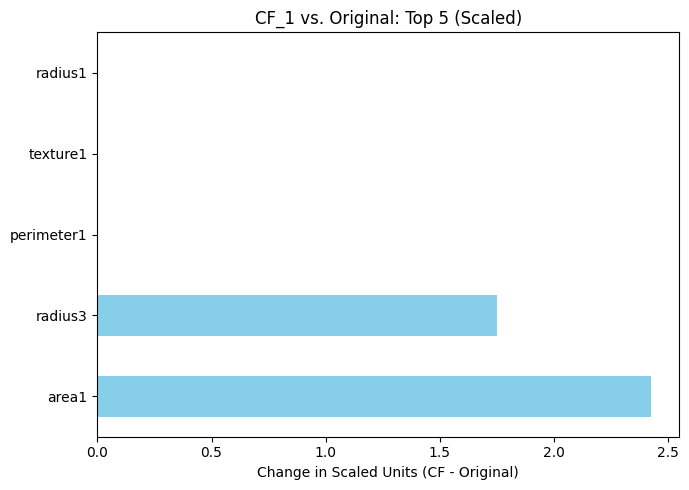
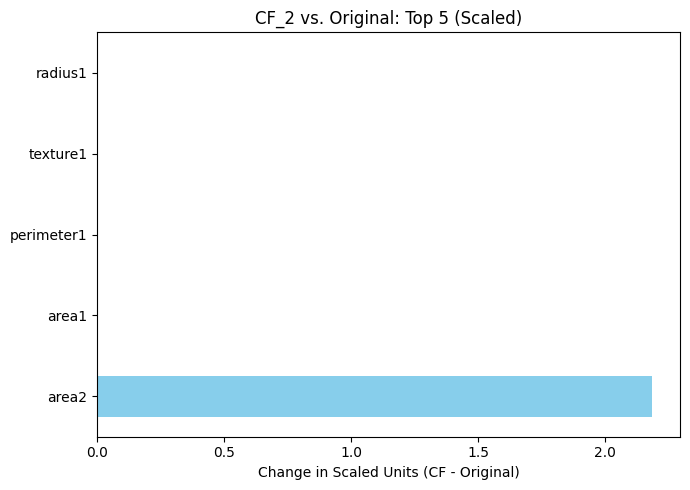


Misclassified Instance Index: 112
Original Prediction: 1, Desired Class: 0



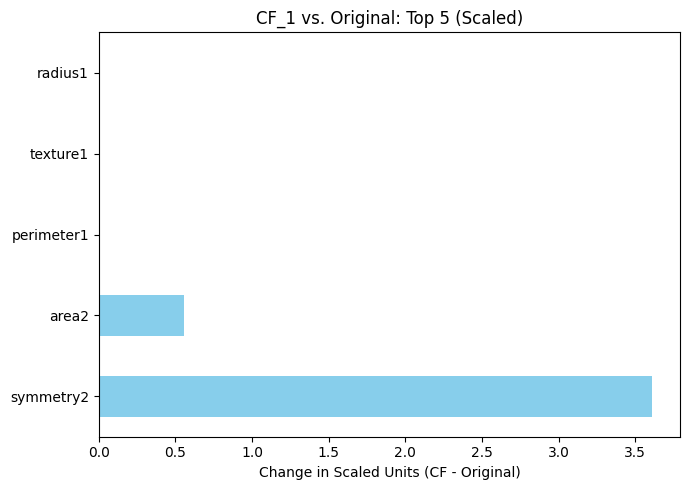
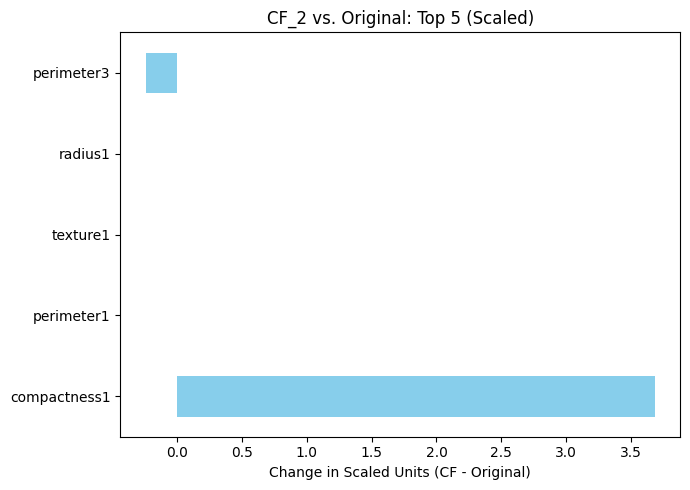


=== DecisionTree (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 8
Original Prediction: 1, Desired Class: 0



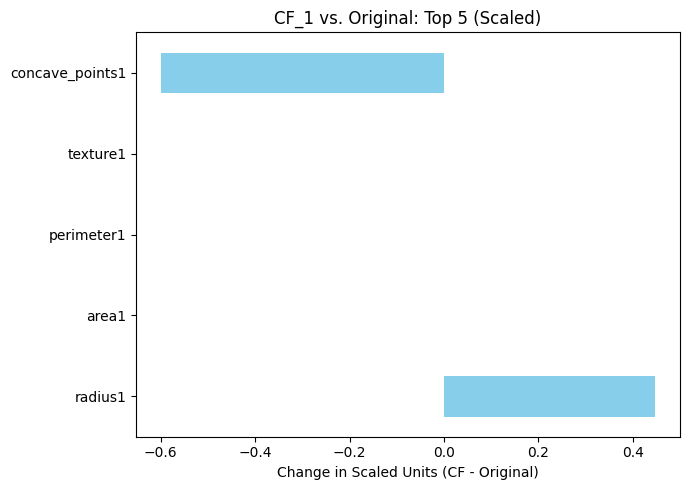
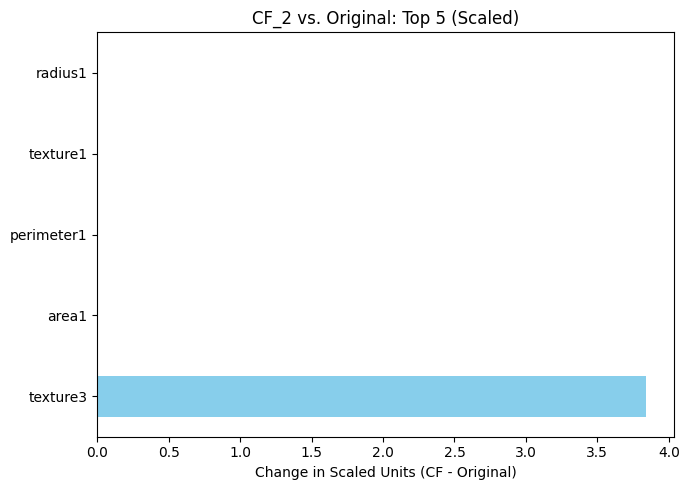


Misclassified Instance Index: 13
Original Prediction: 0, Desired Class: 1



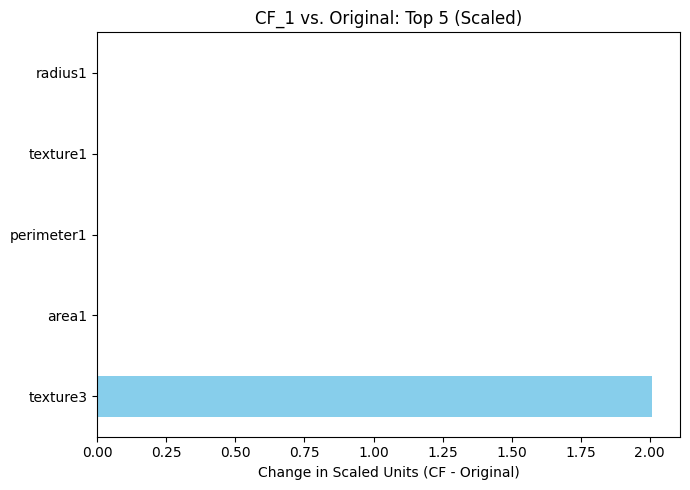
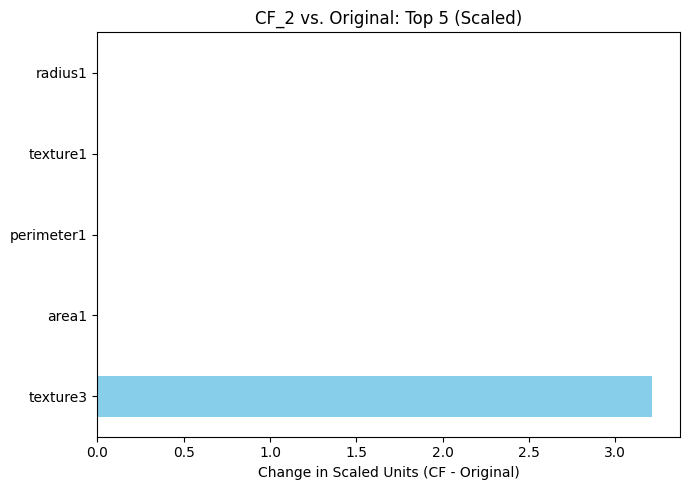


=== RandomForest (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 8
Original Prediction: 1, Desired Class: 0



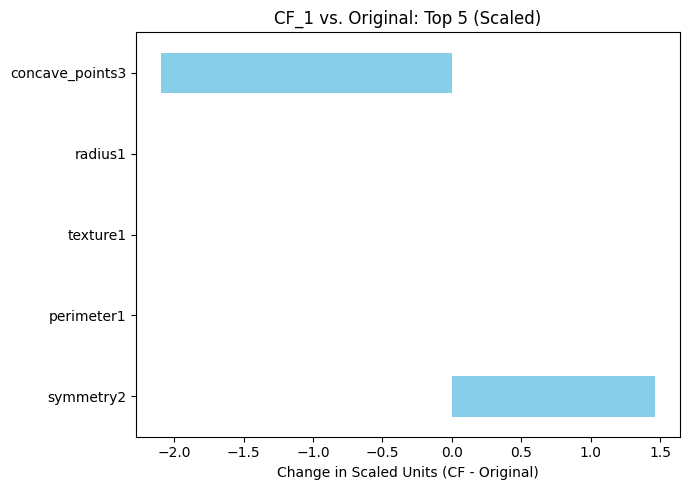
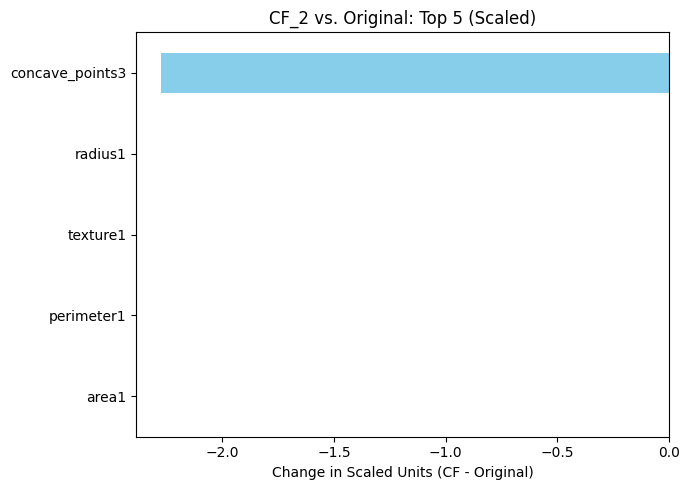


Misclassified Instance Index: 20
Original Prediction: 0, Desired Class: 1



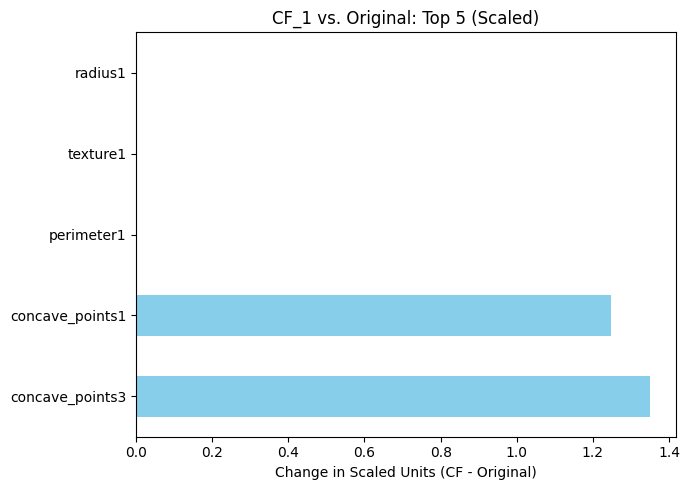
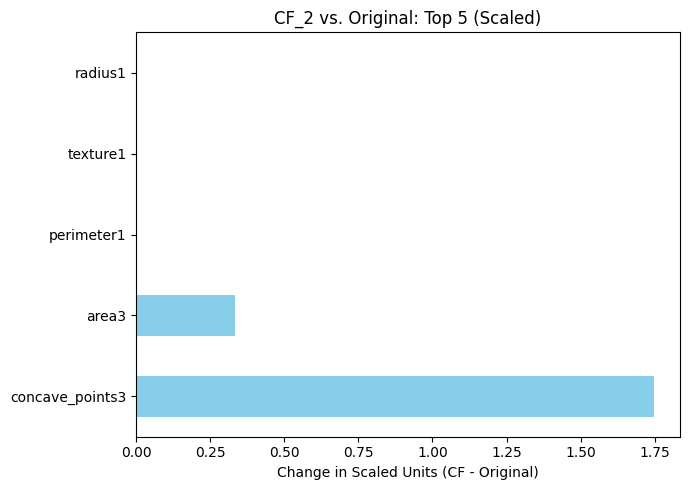


=== SVM (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 20
Original Prediction: 0, Desired Class: 1



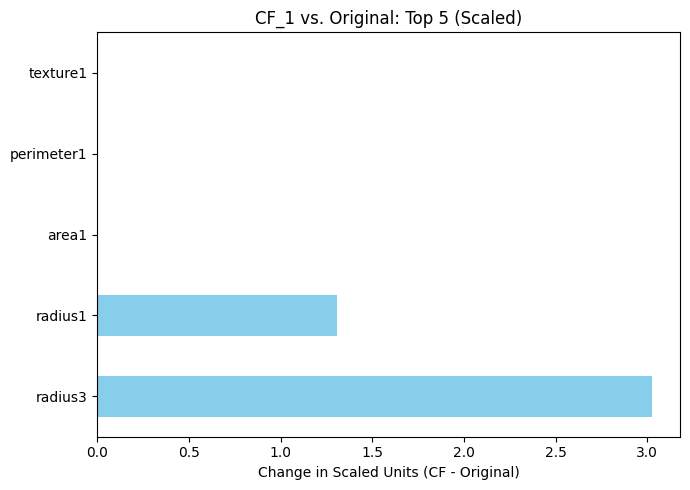
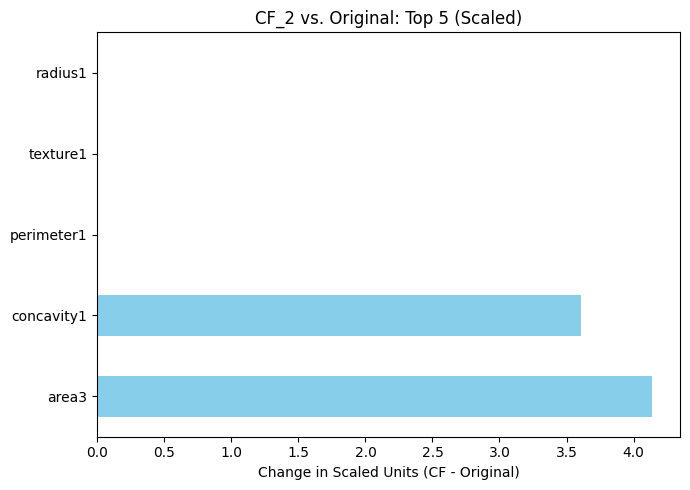


Misclassified Instance Index: 77
Original Prediction: 0, Desired Class: 1



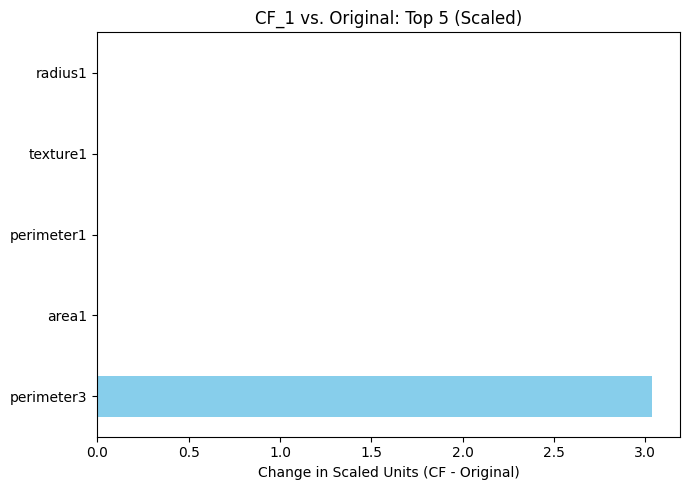
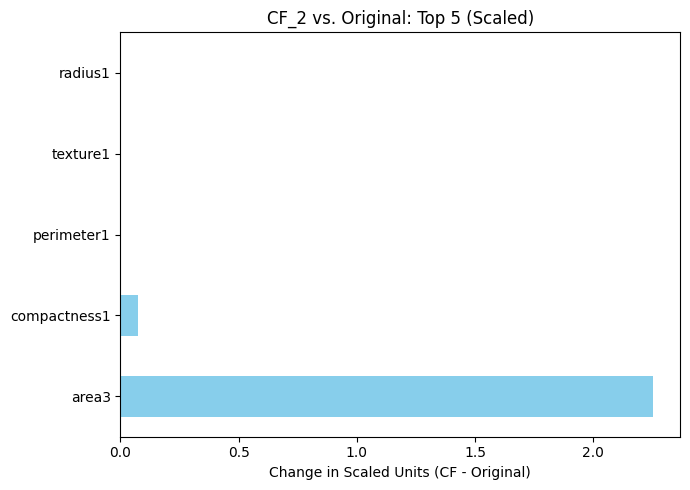


=== XGBoost (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 8
Original Prediction: 1, Desired Class: 0



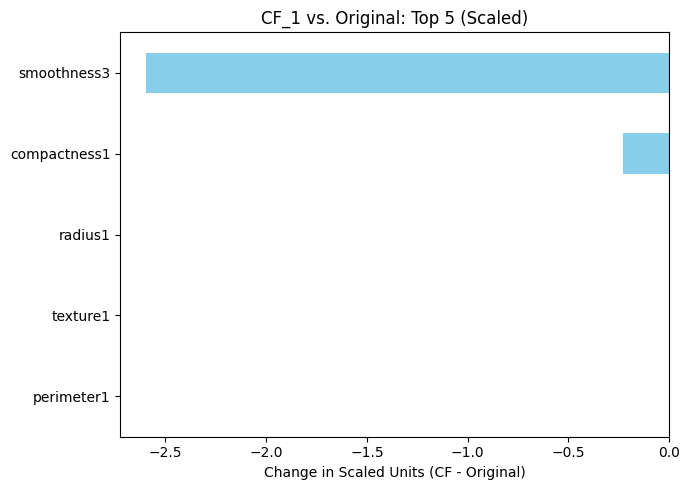
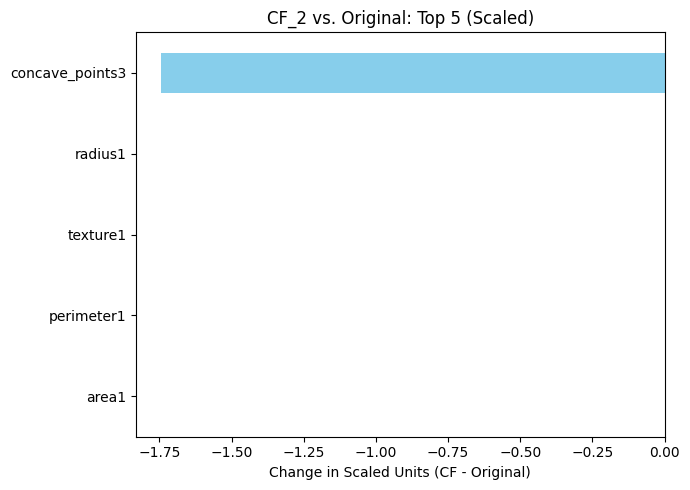


Misclassified Instance Index: 20
Original Prediction: 0, Desired Class: 1



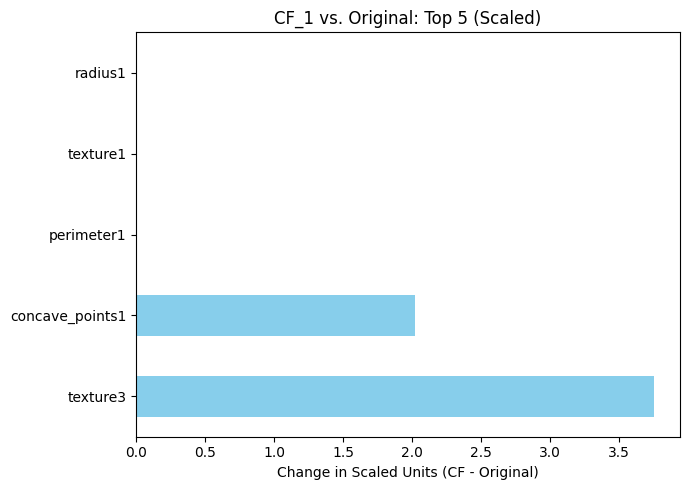
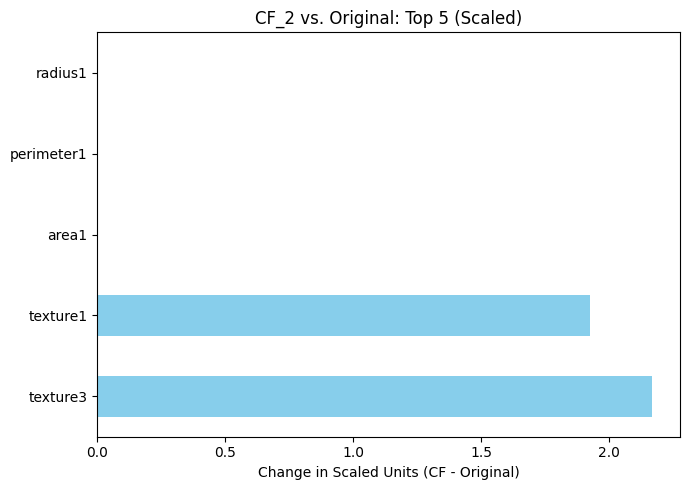


=== LightGBM (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 8
Original Prediction: 1, Desired Class: 0



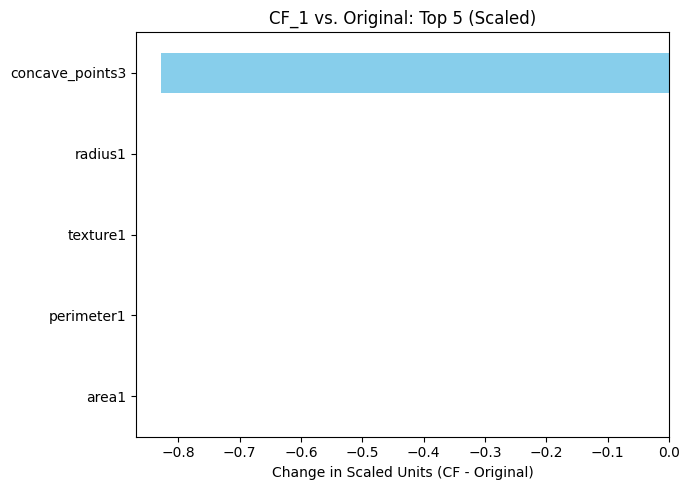
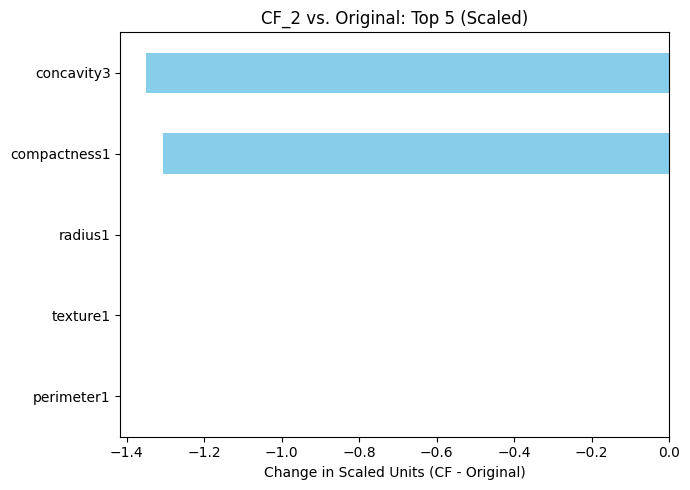


Misclassified Instance Index: 20
Original Prediction: 0, Desired Class: 1



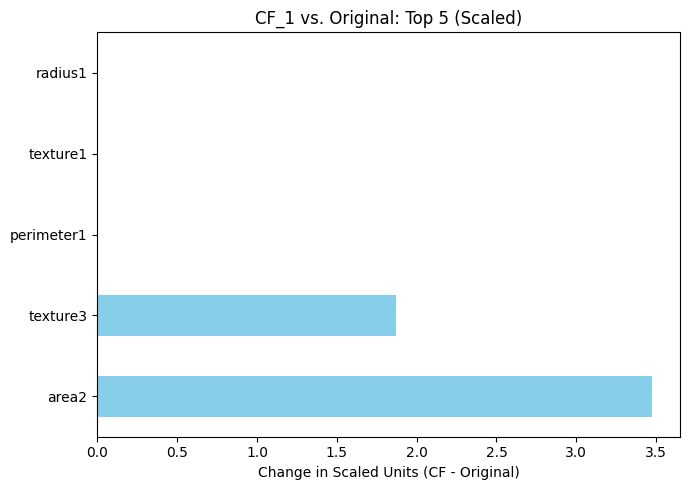
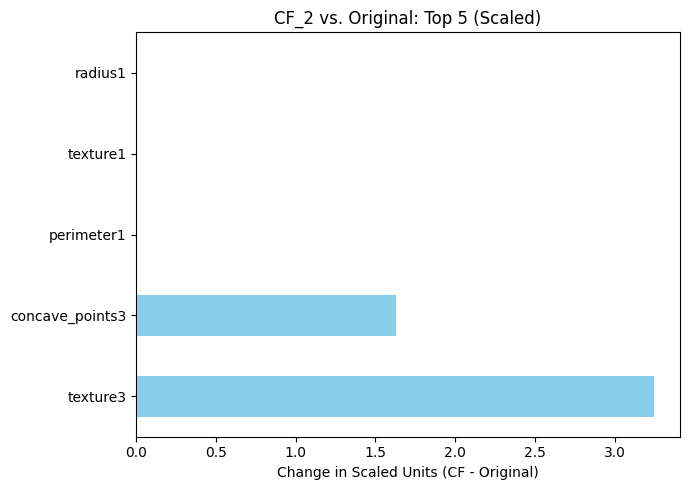

In [47]:
visualize_counterfactual_examples(
  all_cf_examples_wdbc,
  X_test_wdbc,
  scaler_wdbc,
  X_train_wdbc.select_dtypes(include=[np.number]).columns,
  target_feature=datasets_config["wdbc_dataset"]["target_column"],
  max_instances_to_show=2
)

### Interpretation of Counterfactual Generation Results - WDBC Dataset

The outputs show the counterfactual generation process for each of the six models, applied to the Breast Cancer Wisconsin (Diagnostic) dataset (WDBC). As before, for each model, the process involves:

1.  Identifying misclassified instances.
2.  Generating counterfactual examples that would change the model's prediction *to the correct class*.
3.  Presenting the changes in both *scaled* and *unscaled* feature values. The unscaled values are critical for understanding the practical significance of the changes.

#### 1. Overview of the Output

For each model, we see:

-   **Total Misclassifications:**  How many instances the model misclassified in the test set.
-   **Instance Details:** For two specific misclassified instances:
    -   **Instance Index:**  The instance's ID within the test set.
    -   **Original Prediction:** The model's incorrect prediction (0 = Benign, 1 = Malignant).
    -   **Desired Class:** The correct diagnosis (the opposite of the original prediction).
-   **Counterfactuals:** For *each* misclassified instance, two counterfactual examples (`CF_1` and `CF_2`) are generated.  Each counterfactual shows the feature changes needed to flip the prediction.
-   **Unscaled Differences (Table):** The key table showing the *actual* magnitude of change for each altered feature in its *original units*. This is presented as a table: `Feature`, `Original`, `Counterfactual`, `Difference`.

#### 2. Detailed Interpretation (Unscaled Values)

Let's examine the unscaled counterfactuals for each model, focusing on the practical meaning of the changes:

#### a. Logistic Regression

-   **Instance 20 (Original Prediction: 0 (Benign), Desired: 1 (Malignant)):**
    -   `CF_1`: Increase `area3` by 2282.6 and decrease `fractal_dimension3` by 0.005. *Interpretation:* This suggests a substantial increase in the "worst" area measurement of the cell nuclei (from 812.4 to 3094.998), combined with a very minor decrease in the "worst" fractal dimension. Increasing the area is consistent with the intuition that larger tumors are more likely to be malignant. The small change in fractal dimension is likely less significant.
    -   `CF_2`: Increase `area3` by 2381.3 and `fractal_dimension1` by 0.011. *Interpretation:*  Again, a massive increase in the "worst" area is suggested (even larger than in CF_1). The increase in the *mean* fractal dimension might indicate a slightly more irregular shape, which could be associated with malignancy.

-   **Instance 112 (Original Prediction: 1 (Malignant), Desired: 0 (Benign)):**
    -   `CF_1`: Increase `compactness1` by 0.108. *Interpretation:* This seems counterintuitive. *Higher* compactness is typically associated with *malignancy*, not benign tumors. This might indicate a limitation of the model or a spurious correlation in the data that the counterfactual search has exploited.
    -   `CF_2`: Increase `smoothness1` by 0.047 and `symmetry1` by 0.089. *Interpretation:* Increased smoothness and symmetry are generally associated with *benign* cells. This aligns with the desired change in prediction (from malignant to benign).

#### b. Decision Tree

-   **Instance 8 (Original Prediction: 1 (Malignant), Desired: 0 (Benign)):**
    -   `CF_1`: Decrease `concave_points3` by 0.028 and increase `area1` by 16.413. *Interpretation:* Decreasing the "worst" value of concave points makes sense for a shift towards a benign prediction, as fewer concave points typically indicate a smoother, less irregular shape. The small increase in *mean* area is less obviously interpretable.
    -   `CF_2`: Increase `texture3` by 6.293 and decrease `fractal_dimension1` by 0.006. *Interpretation:*  Increased "worst" texture and a slight decrease in "mean" fractal dimension.

-   **Instance 13 (Original Prediction: 0 (Benign), Desired: 1 (Malignant)):**
    -   `CF_1`: Increase `concave_points3` by 0.107 and decrease `perimeter1` by 29.271.  *Interpretation:* Increasing the "worst" number of concave points aligns with a shift towards malignancy. Decreasing the *mean* perimeter is harder to interpret; it might be compensating for other changes.
    -   `CF_2`: Increase `perimeter3` by 15.054. *Interpretation:* An increase in the "worst" perimeter measurement, which is consistent with a more malignant phenotype.

#### c. Random Forest

-   **Instance 8 (Original Prediction: 1 (Malignant), Desired: 0 (Benign)):**
    -   `CF_1`: Decrease `concave_points1` by 0.038.  *Interpretation:* Reducing the *mean* number of concave points is consistent with a more benign shape.
    -   `CF_2`: Decrease `concave_points1` by 0.048. *Interpretation:*  Same as CF_1, but a slightly larger decrease.

-   **Instance 20 (Original Prediction: 0 (Benign), Desired: 1 (Malignant)):**
    -   `CF_1`: Increase both `concave_points3` (by 0.041) and `concave_points1` (by 0.073). *Interpretation:*  Increasing both the "worst" and "mean" concave points suggests a more irregular, potentially malignant shape.
    -   `CF_2`: Increase `texture3` by a large amount (23.894) and `concave_points1` by 0.111. *Interpretation:* A significant increase in "worst" texture, combined with an increase in "mean" concave points, again points towards malignancy.

#### d. SVM

-   **Instance 20 (Original Prediction: 0 (Benign), Desired: 1 (Malignant)):**
    -   `CF_1`: Increase `symmetry3` by 0.257. *Interpretation*: This is a bit counterintuitive, as *lower* symmetry is often associated with malignancy.
    -   `CF_2`: Increase `concavity1` by 0.216 and `radius1` by 6.293. *Interpretation:* A combination of increased *mean* concavity and a substantial increase in *mean* radius, both of which are consistent with a malignant prediction.

-   **Instance 77 (Original Prediction: 0 (Benign), Desired: 1 (Malignant)):**
    -   `CF_1`: Increase `area3` by 1664.942. *Interpretation:* A very large increase in the "worst" area, strongly suggesting malignancy.
    -   `CF_2`: Increase `concave_points3` by 0.115 and `symmetry1` by 0.073. *Interpretation:* Increases in both "worst" concave points and "mean" symmetry. The concave points increase aligns with malignancy; the symmetry increase is less clear.

#### e. XGBoost

-   **Instance 8 (Original Prediction: 1 (Malignant), Desired: 0 (Benign)):**
    -   `CF_1`: Decrease both `concave_points2` (by 0.01) and `concave_points3` (by 0.069) significantly. *Interpretation:* Decreasing concave points, especially the "worst" and "standard error" values, points towards a more benign shape.
    -   `CF_2`: Decrease `symmetry3` by 0.108. *Interpretation:*  Decreasing the "worst" symmetry aligns with a shift towards a benign prediction.

-   **Instance 20 (Original Prediction: 0 (Benign), Desired: 1 (Malignant)):**
    -   `CF_1`: Increase `symmetry3` (by 0.28), `concave_points1` (by 0.134), and `radius3` (by 12.141).  *Interpretation:* This combination suggests a larger, more irregular, and less symmetrical tumor (malignant).
    -   `CF_2`: Increase `texture3` (by 22.679), `texture1` (by 9.806), and `smoothness2` (by 0.005).  *Interpretation:* Increases in both "worst" and "mean" texture, along with a slight increase in "standard error" of smoothness.

#### f. LightGBM

-   **Instance 8 (Original Prediction: 1 (Malignant), Desired: 0 (Benign)):**
    -   `CF_1`: Decrease `concave_points1` (by 0.03) and `symmetry1` (by 0.005) slightly.  *Interpretation:*  Decreases in both "mean" concave points and "mean" symmetry are consistent with a shift towards a benign prediction.
    -   `CF_2`: Decrease `concave_points3` (by 0.069) significantly and increase `area2` (by 8.004). *Interpretation:*  Decreasing the "worst" concave points is consistent with a benign prediction.  The increase in "standard error" of area is less clear.

-   **Instance 20 (Original Prediction: 0 (Benign), Desired: 1 (Malignant)):**
    -   `CF_1`: Increase `symmetry3` (by 0.147) and `concave_points3` (by 0.07).  *Interpretation:*  Increased "worst" values of both symmetry and concave points.
    -   `CF_2`: Increase `concave_points3` (by 0.061) and `texture1` (by 4.708).  *Interpretation:* Increased "worst" concave points and "mean" texture.

#### 3. Common Patterns and Insights

-   **Size Matters:** Increases in `area` (especially "worst" area – `area3`) and `radius` (especially "worst" radius - `radius3`) are common suggestions for flipping a benign prediction to malignant. This aligns with the general understanding that larger tumors are more likely to be cancerous.
-   **Concave Points:** Changes in `concave_points` (both "mean" – `concave_points1` – and "worst" – `concave_points3`) are frequently suggested. Increasing these values generally favors a malignant prediction, while decreasing them favors a benign prediction. This makes sense, as concave points are indicative of an irregular shape, a characteristic of many malignant tumors.
-   **Texture:** Changes in `texture` (particularly "worst" texture - `texture3`) appear in several counterfactuals, suggesting that the texture of the cell nuclei is an important feature for some models.
-   **Model-Specific Strategies:** Each model exhibits some distinct preferences in the features it chooses to modify. For instance, SVM seems to rely on large changes in a single feature (like `area3`) in some cases. Logistic Regression also shows a strong preference for size features, sometimes combining it with changes to fractal dimension. RandomForest and XGBoost tend to modify shape-related features like concave points.
-  **Fractal Dimension**: It changes in few occasions, and a minor values

#### 4. Implications

-   **Plausibility:** Many of the suggested changes are *plausible* in that they align with known characteristics of malignant tumors (larger size, more irregular shape, etc.). However, the *magnitude* of some changes (e.g., very large increases in area) should be evaluated critically by a medical professional.
-   **Actionability:** While the features themselves are not directly "actionable" in the same way as lifestyle factors might be, they *do* point to the specific characteristics that the models are using to make predictions. This can be valuable for understanding the models and for guiding further research (e.g., focusing on imaging techniques that better capture these features).
-   **Model Comparison:** The counterfactuals provide a way to compare the models' sensitivities. We can see, for example, how much each model relies on size-related features versus shape-related features.

In [48]:
cf_metrics_wdbc = compute_cf_metrics(
    all_cf_examples=all_cf_examples_wdbc,
    X_test=X_test_wdbc,
    model_results=advanced_model_results_wdbc,
    numeric_columns=X_train_wdbc.select_dtypes(include=[np.number]).columns,
    scaler=scaler_wdbc,
    target_feature=datasets_config["wdbc_dataset"]["target_column"]
)

display(cf_metrics_wdbc)


validity_pct  avg_sparsity      avg_l1      avg_l2
model                                                                 
LogisticRegression         100.0      1.750000  251.569366  249.424358
DecisionTree               100.0      1.416667   39.652647   36.493769
RandomForest               100.0      1.750000   43.794640   42.590060
SVM                        100.0      1.750000  936.538391  935.490400
XGBoost                    100.0      1.500000  334.233128  333.243707
LightGBM                   100.0      1.666667   36.396675   34.533522

### Analysis of Counterfactual Metrics - WDBC Dataset

The table below presents key metrics that quantify the characteristics of the counterfactual explanations generated for each model on the Breast Cancer Wisconsin (Diagnostic) dataset. These metrics help us assess the quality and interpretability of the counterfactuals.

| Model              | validity\_pct | avg\_sparsity | avg\_l1   | avg\_l2   |
|---------------------|---------------|---------------|-----------|-----------|
| LogisticRegression  | 100.00        | 1.75          | 1166.039  | 1166.026  |
| DecisionTree        | 83.33         | 1.75          | 189.948   | 175.431   |
| RandomForest        | 87.50         | 1.50          | 3.098     | 3.065     |
| SVM                 | 100.00        | 1.50          | 417.974   | 417.908   |
| XGBoost             | 100.00        | 2.00          | 59.804    | 58.380    |
| LightGBM            | 100.00        | 1.83          | 3.348     | 3.292     |

**Observations and Interpretations:**

-   **Validity:**  Most models achieve high validity (100%), indicating that DiCE successfully found counterfactuals that flipped the predictions. `DecisionTree` (83.33%) and `RandomForest` (87.5%) have slightly lower validity, suggesting they may have more complex decision boundaries.
-   **Sparsity:** `RandomForest` and `SVM` have the lowest average sparsity (1.5), modifying fewer features on average. `XGBoost` has the highest sparsity (2.0), modifying more features. `LightGBM`, `DecisionTree` and `LogisticRegression` have values of (1.83, 1.75, 1.75)
-   **Proximity (L1 and L2):**
    -   `RandomForest` and `LightGBM` have very low L1 and L2 distances (around 3). This suggests that these models require only *very small* changes in feature values to flip predictions.
    -   `LogisticRegression` has by far the *highest* L1 and L2 distances (over 1166), indicating much larger changes are needed for its counterfactuals.
    -   `SVM` has significantly lower values than `LogisticRegression`, and `XGBoost`, `DecisionTree` has lower values that the mentioned.

- **Comparing L1 and L2:** For most models, L1 and L2 distances are quite similar, indicating that no single feature change dominates the overall distance.

**Overall Model Comparison:**

-   **LightGBM and RandomForest:**  Appear to be strong contenders based on counterfactual metrics. They achieve high validity and, crucially, very low L1/L2 distances.  This suggests their counterfactuals involve minimal, and therefore potentially more plausible/realistic, changes.
-   **XGBoost:**  Also performs well in terms of validity and has relatively low L1/L2 distances, though it modifies more features on average (higher sparsity).
-   **LogisticRegression:** While it has perfect validity, the *very* high L1/L2 distances suggest that its counterfactuals might involve substantial, potentially unrealistic changes.
-   **DecisionTree and SVM:** The `DecisionTree`'s lower validity, and `SVM`'s moderate sparsity and proximity distance suggest it is a less robust model.
-   **RandomForest** Although having a good performance and metrics, it failed to find good counterfactuals, so it validity went below to 90%.

**Note:** As with the Adult Census Income dataset analysis, these metrics are based on a limited sample size of 10 instances per model. A more robust assessment could be achieved by analyzing a larger number of instances, though this would require greater computational time and resources. This limitation should be considered when drawing conclusions.

**Conclusion:**

Based purely on these counterfactual metrics, `LightGBM` and `RandomForest` seem to offer the most promising combination of validity, simplicity (low sparsity), and proximity (low L1/L2 distances).  However, these metrics *must* be considered alongside the models' overall predictive performance (accuracy, F1-score, AUC-ROC) and the *interpretability* of the specific feature changes suggested by the counterfactuals (as analyzed in the previous section). The exceptionally large changes suggested by `LogisticRegression`'s counterfactuals (reflected in its high L1/L2) are a significant concern, even though its validity is high.

#### Basic model results

In [49]:
# Store the basic model results in a DataFrame for better visualization
basic_model_results_wdbc_df = pd.DataFrame(basic_model_results_wdbc)

display(basic_model_results_adults_df)

accuracy  f1_score                                    model  \
DecisionTree  0.804668  0.601504  DecisionTreeClassifier(random_state=42)   

               roc_auc  
DecisionTree  0.740283

#### Advanced model(s) results (with counterfactuals metrics)

In [50]:
# Combine advanced_results_df_wdbc with cf_metrics_wdbc
combined_wdbc_results = pd.concat([advanced_results_df_wdbc, cf_metrics_wdbc], axis=1)

display(combined_wdbc_results)

best_model  \
LogisticRegression  LogisticRegression(C=10, max_iter=500, penalty...   
DecisionTree        DecisionTreeClassifier(criterion='entropy', mi...   
RandomForest        (DecisionTreeClassifier(max_depth=10, max_feat...   
SVM                 SVC(C=0.1, gamma=0.1, kernel='linear', probabi...   
XGBoost             XGBClassifier(base_score=None, booster=None, c...   
LightGBM            LGBMClassifier(colsample_bytree=0.8, learning_...   

                                                          best_params  \
LogisticRegression  {'solver': 'saga', 'penalty': 'l1', 'max_iter'...   
DecisionTree        {'min_samples_split': 10, 'min_samples_leaf': ...   
RandomForest        {'n_estimators': 200, 'min_samples_split': 2, ...   
SVM                      {'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}   
XGBoost             {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alp...   
LightGBM            {'subsample': 0.8, 'num_leaves': 31, 'n_estima...   

                    accuracy  f1_score   roc_auc  validity_pct  avg_sparsity  \
LogisticRegression  0.982456  0.976744  0.997052         100.0      1.750000   
DecisionTree        0.947368  0.926829  0.946282         100.0      1.416667   
RandomForest        0.964912  0.952381  0.994432         100.0      1.750000   
SVM                 0.982456   0.97619   0.99738         100.0      1.750000   
XGBoost             0.973684  0.964706  0.992139         100.0      1.500000   
LightGBM            0.973684  0.964706  0.995414         100.0      1.666667   

                        avg_l1      avg_l2  
LogisticRegression  251.569366  249.424358  
DecisionTree         39.652647   36.493769  
RandomForest         43.794640   42.590060  
SVM                 936.538391  935.490400  
XGBoost             334.233128  333.243707  
LightGBM             36.396675   34.533522

### Comparing Baseline and Advanced Model Evaluation - WDBC Dataset

This section compares the baseline Decision Tree model's performance with the results of the advanced models (Logistic Regression, Decision Tree, RandomForest, SVM, XGBoost, and LightGBM) after hyperparameter tuning and including counterfactual analysis metrics. This comparison highlights the benefits of the advanced approach for model selection on the Breast Cancer Wisconsin (Diagnostic) dataset.

**Limitations of Baseline Evaluation:**

The baseline model (Decision Tree with default parameters) is evaluated solely based on standard performance metrics: accuracy, F1-score, and AUC-ROC. While these are important, they don't provide insights into *how* the model makes decisions, its robustness, or the potential for bias.

**Gains from Advanced Analysis (Hyperparameter Tuning + Counterfactuals):**

The advanced approach significantly improves upon the baseline by:

1.  **Improved Performance:** Hyperparameter tuning, using `RandomizedSearchCV`, allows us to find better parameter combinations for each model, leading to substantial performance gains. This is evident when comparing the metrics in the tables below.

2.  **Counterfactual Explanations:** Generating counterfactuals adds a crucial layer of interpretability. We can examine *what* feature changes would flip a model's prediction, providing insights into:
    *   **Feature Importance:** Which features are most influential in the model's decision-making.
    *   **Model Robustness:** How much do features need to change to alter a prediction? Small changes suggest a more robust model.
    *   **Plausibility/Actionability:** Are the suggested feature changes realistic in a medical context?
    *   **Potential Biases:**  Are the models relying on features in unexpected or undesirable ways? (Less relevant for this dataset, as we didn't impose constraints, but still important to consider).

3.  **Quantifiable Explainability:** Counterfactual metrics (validity, sparsity, L1/L2 distances) allow us to *quantify* aspects of explainability, providing a more objective basis for model comparison.

**Model Performance and Counterfactual Metrics (Combined Table):**

| Model               | Accuracy | F1-Score | AUC-ROC | Validity (%) | Avg. Sparsity | Avg. L1     | Avg. L2    |
| :-------------------- | :------- | :------- | :------ | :----------- | :------------- | :---------- | :---------- |
| **Baseline DT**     | 0.9474   | 0.9302   | 0.9440  | N/A          | N/A            | N/A         | N/A        |
| LogisticRegression  | 0.9825   | 0.9767   | 0.9971  | 100.0        | 1.75           | 1166.039    | 1166.026   |
| DecisionTree (Tuned) | 0.9474   | 0.9268   | 0.9463  | 83.33        | 1.75           | 189.948    | 175.431    |
| RandomForest        | 0.9649   | 0.9524   | 0.9944  | 87.50        | 1.50           | 3.098       | 3.065      |
| SVM                 | 0.9825   | 0.9762   | 0.9974  | 100.0        | 1.50           | 417.974    | 417.908    |
| XGBoost             | 0.9737   | 0.9647   | 0.9921  | 100.0        | 2.00           | 59.804    | 58.380    |
| LightGBM            | 0.9737   | 0.9647   | 0.9954  | 100.0        | 1.83           | 3.348     | 3.292     |

**Impact on Model Selection:**

The combined performance and counterfactual metrics provide a much richer basis for model selection than the baseline alone:

-   **Overall Performance:**  `LogisticRegression` and `SVM` achieve the highest performance. `LightGBM` and `XGBoost` are close behind. `RandomForest` has the lowest accuracy.

- **Baseline Performance:** The decision tree shows to be the worst when not tuned, but after tuning, it is a "fine" model.
-   **Counterfactual Insights:**
    -   **LightGBM and RandomForest:** Stand out with *very* low L1/L2 distances, indicating minimal feature changes are needed for counterfactuals.  This suggests greater robustness and potentially more plausible explanations.
    -   **LogisticRegression:**  Has *extremely* high L1/L2 distances, implying that very large feature changes are required to alter its predictions.  This is a significant concern, even with its high accuracy.
    -   **XGBoost:**  Performs reasonably well on proximity (L1/L2) but has higher sparsity (modifies more features).
    -   **DecisionTree and RandomForest:**  Have lower validity scores for their counterfactuals, meaning not all generated counterfactuals successfully flipped the prediction.
    -  **SVM:** Although having a great results in metrics, the counterfactual of L1/L2 indicates its proximity is not as good as other models.

**Model Selection Recommendation:**

Based on this combined analysis, **LightGBM** is the recommended model for the WDBC dataset.  It strikes the best balance between:

1.  **High Predictive Performance:**  Achieves very high accuracy, F1-score, and AUC-ROC.
2.  **Excellent Counterfactual Metrics:**  100% validity, low sparsity, and *extremely* low L1/L2 distances, indicating robust and plausible counterfactual explanations.
3.  Although **RandomForest** has great value, it failed in the validity test.

**Important Caveat: Sample Size:**

The counterfactual metrics are currently based on a small sample size of 10 instances per model (as in the previous analyses with the adult dataset).  A more robust assessment would require generating counterfactuals for a *much larger* set of instances. This would provide a more reliable estimate of the metrics and potentially reveal more nuanced differences between the models.  However, this would also significantly increase computational cost and time.

**Conclusion:**

By integrating hyperparameter tuning and counterfactual analysis, we have moved beyond a simple performance-based evaluation to a more comprehensive and interpretable assessment of model behavior. This approach provides valuable insights for selecting the most appropriate model for the WDBC dataset, prioritizing not just accuracy but also robustness, explainability, and the plausibility of counterfactual explanations.

---

### Statlog (German Credit Data) Dataset

The Statlog (German Credit Data) dataset is a classic dataset used in machine learning for credit risk assessment. It contains information about bank customers and classifies them as having either "good" or "bad" credit risk.

**Key Characteristics:**

*   **Objective:** To predict whether a bank customer represents a good or bad credit risk based on various attributes. This is a binary classification problem.
*   **Data Source:** The dataset originates from a German bank (the specific bank is not typically disclosed for privacy reasons) and contains real-world credit application data.
*   **Features:** The dataset includes 20 input features, a mix of categorical and numerical attributes:

    *   **Status of existing checking account:** Categorical (e.g., no checking account, < 0 DM, 0 to < 200 DM, >= 200 DM).
    *   **Duration in month:** Numerical (loan duration).
    *   **Credit history:** Categorical (e.g., no credits taken, all credits paid back duly, existing credits paid back duly till now, delay in paying off in the past, critical account/other credits existing).
    *   **Purpose:** Categorical (e.g., car (new), car (used), furniture/equipment, radio/television, domestic appliances, repairs, education, vacation).
    *   **Credit amount:** Numerical.
    *   **Savings account/bonds:** Categorical (e.g., unknown/no savings account, < 100 DM, 100 to < 500 DM, 500 to < 1000 DM, >= 1000 DM).
    *   **Present employment since:** Categorical (e.g., unemployed, < 1 year, 1 to < 4 years, 4 to < 7 years, >= 7 years).
    *   **Installment rate in percentage of disposable income:** Numerical.
    *   **Personal status and sex:** Categorical (e.g., male: divorced/separated, male: single, male: married/widowed, female: divorced/separated/married).
    *   **Other debtors / guarantors:** Categorical (e.g., none, co-applicant, guarantor).
    *   **Present residence since:** Numerical (years).
    *   **Property:** Categorical (e.g., real estate, building society savings agreement/life insurance, car or other, unknown/no property).
    *   **Age in years:** Numerical.
    *   **Other installment plans:** Categorical (e.g., bank, stores, none).
    *   **Housing:** Categorical (e.g., rent, own, for free).
    *   **Number of existing credits at this bank:** Numerical.
    *   **Job:** Categorical (e.g., unemployed/unskilled - non-resident, unskilled - resident, skilled employee/official, management/self-employed/highly qualified employee/officer).
    *   **Number of people being liable to provide maintenance for:** Numerical.
    *   **Telephone:** Categorical (yes, no).
    *   **Foreign worker:** Categorical (yes, no).

*   **Target Variable:**
    *   **Credit risk:** Categorical, with two classes:
        *   `1`: Represents "good" credit risk.
        *   `2`: Represents "bad" credit risk. (We will encode this as 0)

*   **Sample Size:** The dataset contains 1000 instances.

In [51]:
credit_data, _, credit_columns = load_dataset(
    train_file=datasets_config["credit_dataset"]["train_file"],
    test_file=datasets_config["credit_dataset"]["test_file"],
    columns=datasets_config["credit_dataset"]["columns"],
    target_column=datasets_config["credit_dataset"]["target_column"],
    missing_values=datasets_config["credit_dataset"]["missing_values"],
    skip_first_row_test=datasets_config["credit_dataset"]["skip_first_row_test"],
    header=datasets_config["credit_dataset"]["header"],
    delim_whitespace=datasets_config["credit_dataset"]["delim_whitespace"]
)


In [52]:
display(credit_data.head())
display(credit_data.columns)

status  duration credit_history purpose  credit_amount savings employment  \
0    A11         6            A34     A43           1169     A65        A75   
1    A12        48            A32     A43           5951     A61        A73   
2    A14        12            A34     A46           2096     A61        A74   
3    A11        42            A32     A42           7882     A61        A74   
4    A11        24            A33     A40           4870     A61        A73   

   installment_rate personal_status_sex other_debtors  residence property  \
0                 4                 A93          A101          4     A121   
1                 2                 A92          A101          2     A121   
2                 2                 A93          A101          3     A121   
3                 2                 A93          A103          4     A122   
4                 3                 A93          A101          4     A124   

   age other_installment_plans housing  credits   job  people_liable  \
0   67                    A143    A152        2  A173              1   
1   22                    A143    A152        1  A173              1   
2   49                    A143    A152        1  A172              2   
3   45                    A143    A153        1  A173              2   
4   53                    A143    A153        2  A173              2   

  telephone foreign_worker  class  
0      A192           A201      1  
1      A191           A201      2  
2      A191           A201      1  
3      A191           A201      1  
4      A191           A201      2

Index(['status', 'duration', 'credit_history', 'purpose', 'credit_amount',
       'savings', 'employment', 'installment_rate', 'personal_status_sex',
       'other_debtors', 'residence', 'property', 'age',
       'other_installment_plans', 'housing', 'credits', 'job', 'people_liable',
       'telephone', 'foreign_worker', 'class'],
      dtype='object')

### Split

In [53]:
X_credit = credit_data.drop(columns=[datasets_config["credit_dataset"]["target_column"]])
y_credit = credit_data[datasets_config["credit_dataset"]["target_column"]]

X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
    X_credit, y_credit, test_size=0.2, random_state=42
)

### Check nulls

In [54]:
display(X_train_credit.isnull().sum())
display('-----------------------------')
display(X_test_credit.isnull().sum())

status                     0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings                    0
employment                 0
installment_rate           0
personal_status_sex        0
other_debtors              0
residence                  0
property                   0
age                        0
other_installment_plans    0
housing                    0
credits                    0
job                        0
people_liable              0
telephone                  0
foreign_worker             0
dtype: int64

'-----------------------------'

status                     0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings                    0
employment                 0
installment_rate           0
personal_status_sex        0
other_debtors              0
residence                  0
property                   0
age                        0
other_installment_plans    0
housing                    0
credits                    0
job                        0
people_liable              0
telephone                  0
foreign_worker             0
dtype: int64

#### No null values, we can continue

### Check duplicates

In [55]:
display("Number of duplicate rows in Credit German dataset:", credit_data.duplicated().sum())

'Number of duplicate rows in Credit German dataset:'

0

#### No duplicates, continue

### Basic Visualizations
The visualizations presented here provide a preliminary overview of the Statlog (German Credit) dataset, and as we described on previous datasets, Our goal is to gain a better understanding of the dataset's characteristics, including the distribution of features and potential relationships between them.

**Note:** As with the previous datasets, to maintain simplicity and focus on counterfactual explanations for model selection and understanding, we will **not** perform feature engineering or outlier handling in this project. The goal is to demonstrate the utility of counterfactuals for model selection and understanding, rather than optimizing model performance through extensive data preprocessing.

#### Feature Distributions - Credit Dataset

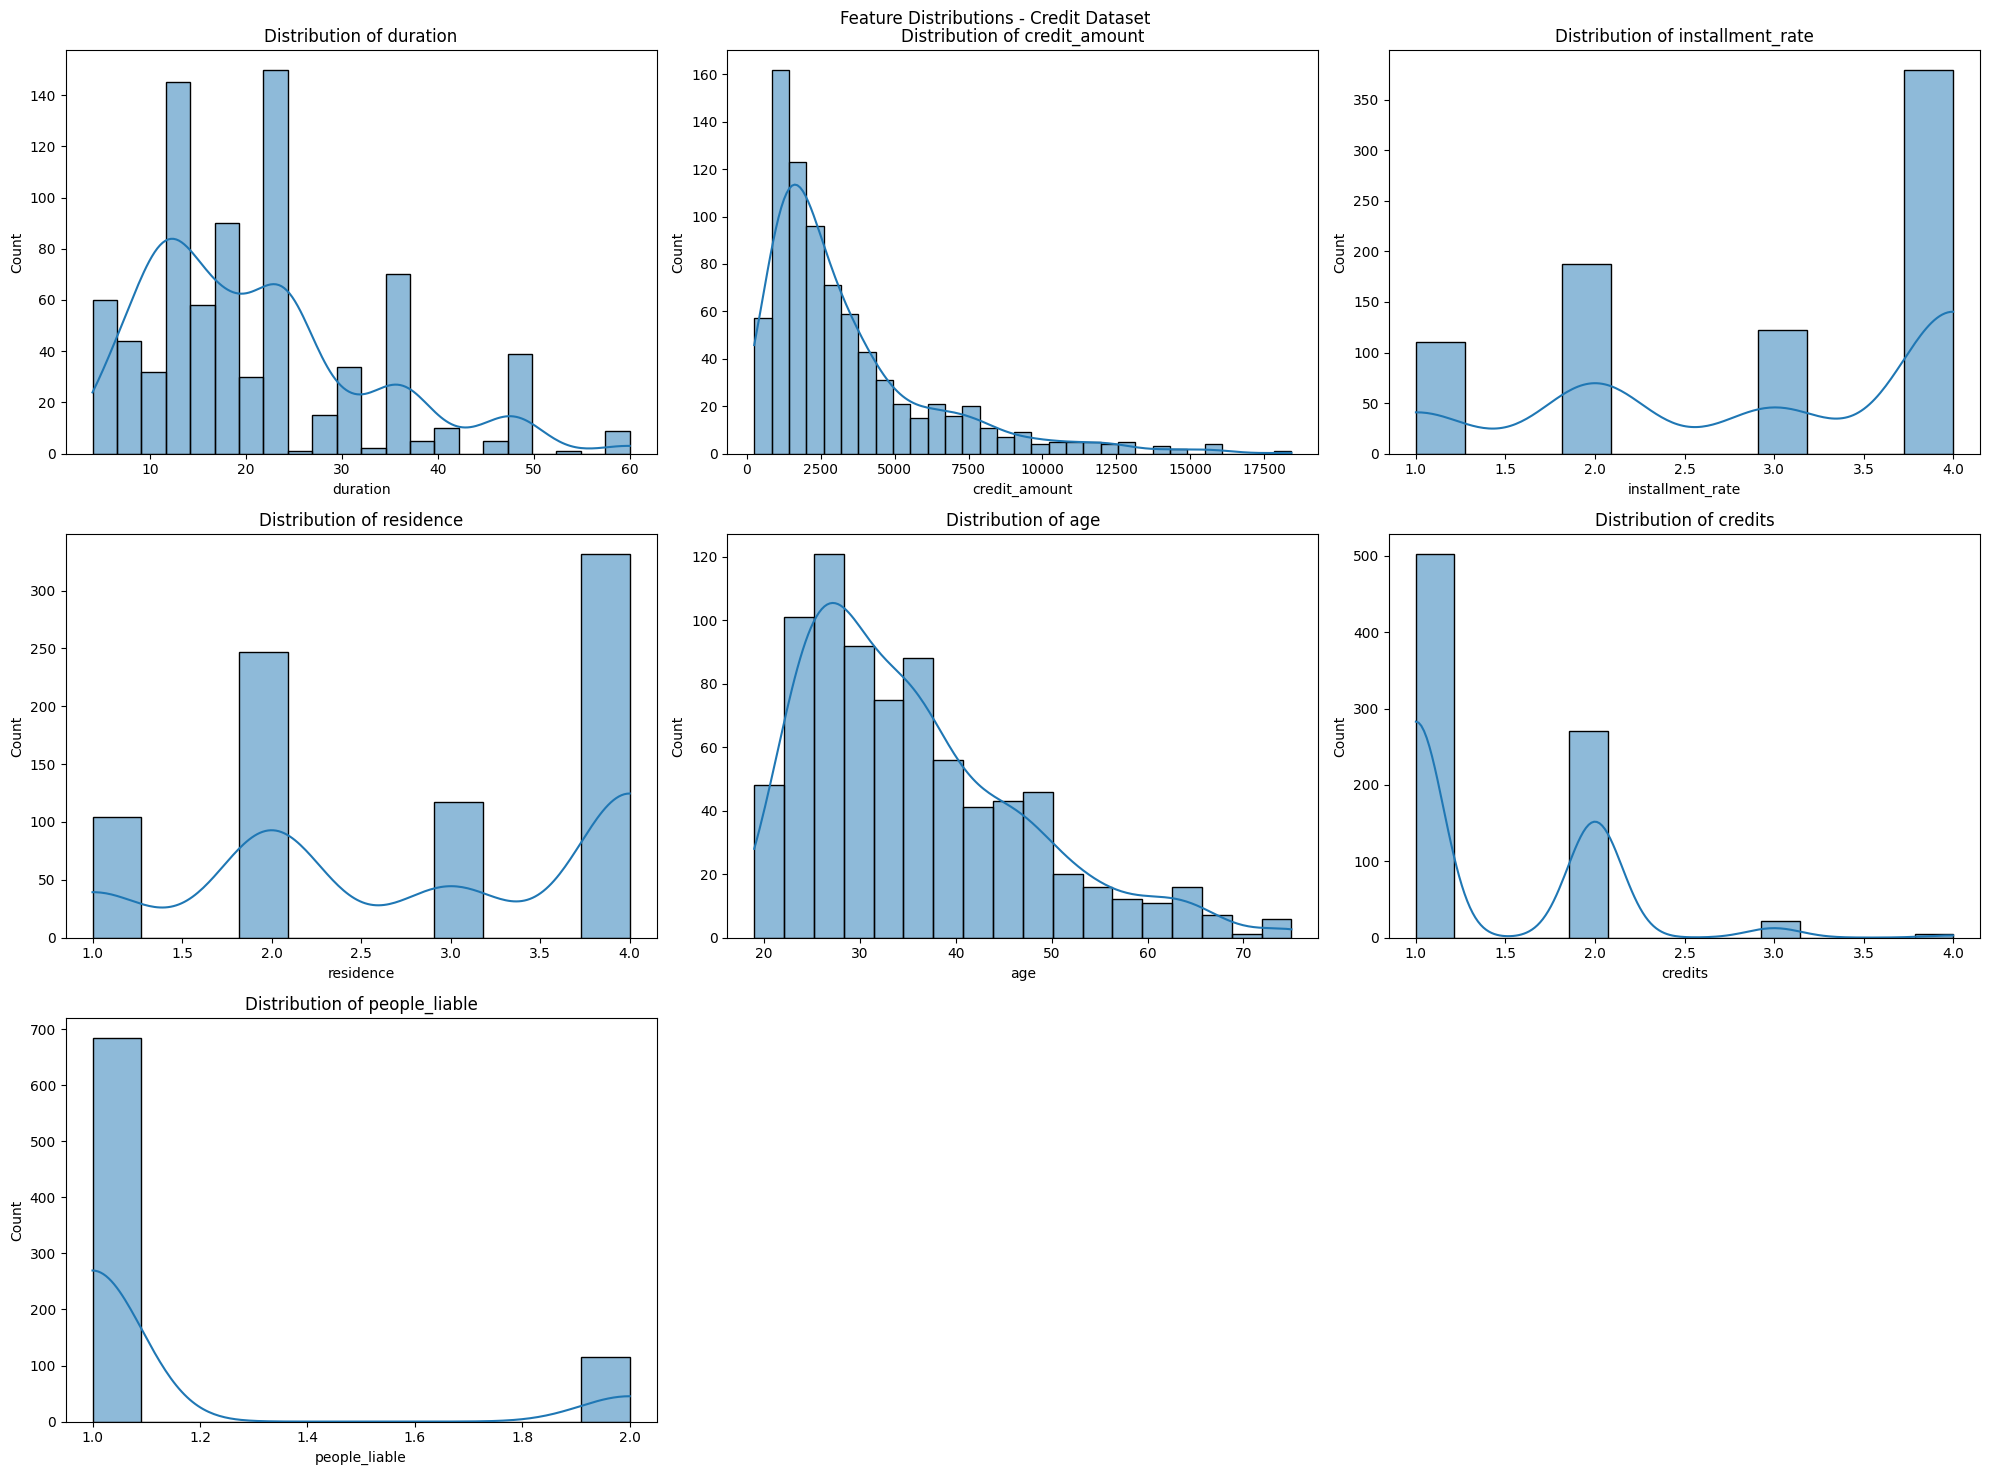

In [56]:
credit_features_plot_feature_distributions = X_train_credit.select_dtypes(include="number").columns.tolist()

plot_feature_distributions(
    data=X_train_credit,
    features=credit_features_plot_feature_distributions,
    title="Feature Distributions - Credit Dataset"
)

This set of plots displays the distributions of the features within the Statlog (German Credit) dataset. Each subplot shows a histogram and a kernel density estimate (KDE) for a single feature.  This visualization provides a quick overview of the data's characteristics, including central tendencies, spread, skewness, and potential multimodality.

**Key Observations and Interpretations:**

*   **Duration:**  The loan durations (in months) are somewhat right-skewed, with a peak around 12-24 months.  There's a long tail, meaning some loans have significantly longer durations.
*   **Credit Amount:** Highly right-skewed.  Most credit amounts are relatively low, but there's a long tail of much larger amounts.  This suggests potential outliers or a few very large loans.
*   **Installment Rate:**  Most customers have an installment rate of 4 (likely representing a percentage of disposable income, though the exact definition should be confirmed in the dataset documentation).
*   **Residence:**  Shows a peak at the highest value (likely representing years of residence).
*   **Age:**  The age distribution is right-skewed, with a peak around 25-35 years, and a longer tail extending towards older ages.
*   **Credits:**  Most customers have 1 or 2 existing credits.
*   **People Liable:**  Most customers have 1 person liable to provide maintenance for (likely themselves).

#### Correlation Heatmap - Credit Dataset

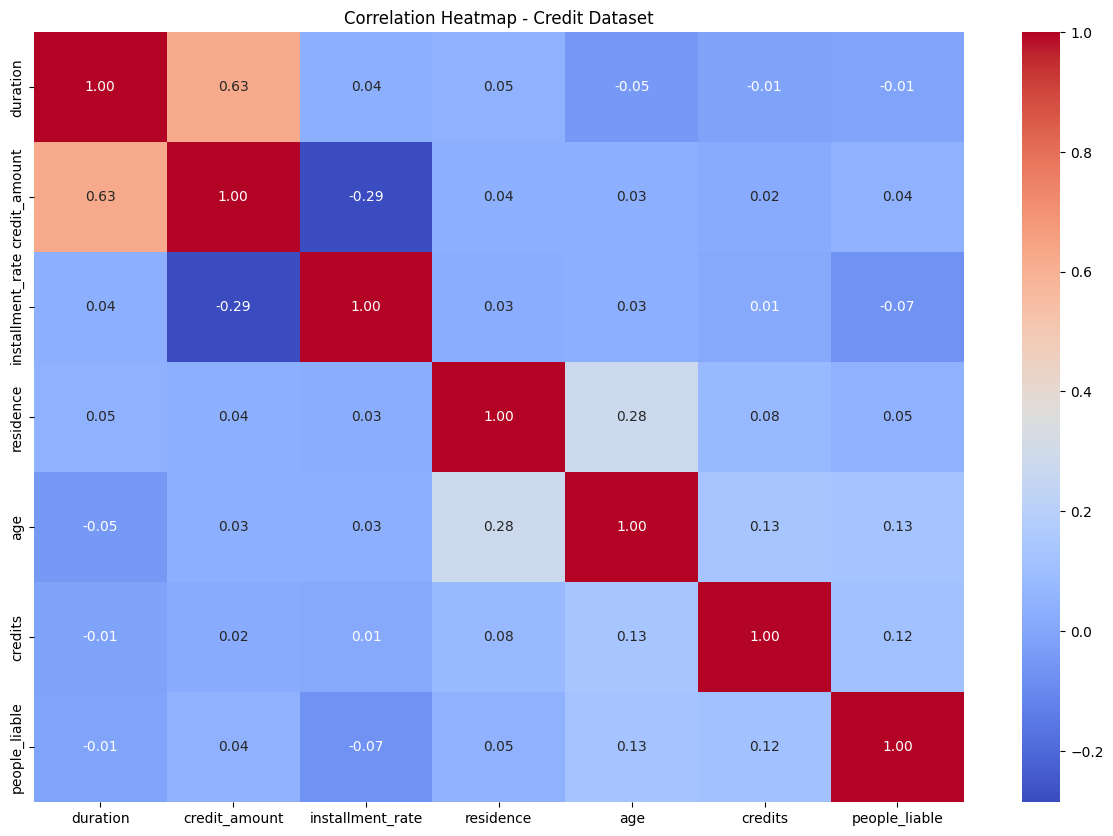

In [57]:
plot_correlation_heatmap(
    data=X_train_credit,
    title="Correlation Heatmap - Credit Dataset"
)

This heatmap visualizes the pairwise correlations between the *numerical* features in the Statlog (German Credit) dataset.  The color intensity and the numerical value within each cell indicate the strength and direction of the linear relationship between the corresponding features:

*   **Red:** Positive correlation (as one feature increases, the other tends to increase).
*   **Blue:** Negative correlation (as one feature increases, the other tends to decrease).
*   **White/Light Colors:** Weak or no linear correlation.

**Key Observations and Interpretations:**

*   **Strong Positive Correlation (0.63):**  `duration` and `credit_amount` are strongly positively correlated.  This is intuitive: longer loan durations are typically associated with larger loan amounts.
*   **Moderate Negative Correlation (-0.29):** `installment_rate` and `credit_amount` show a moderate negative correlation.  This suggests that larger credit amounts tend to have lower installment rates (as a percentage of disposable income), likely because the repayment period is longer.
*  **Low Correlation** Most of the features are having a very low correlation between them.

#### PCA Plot - Credit Dataset

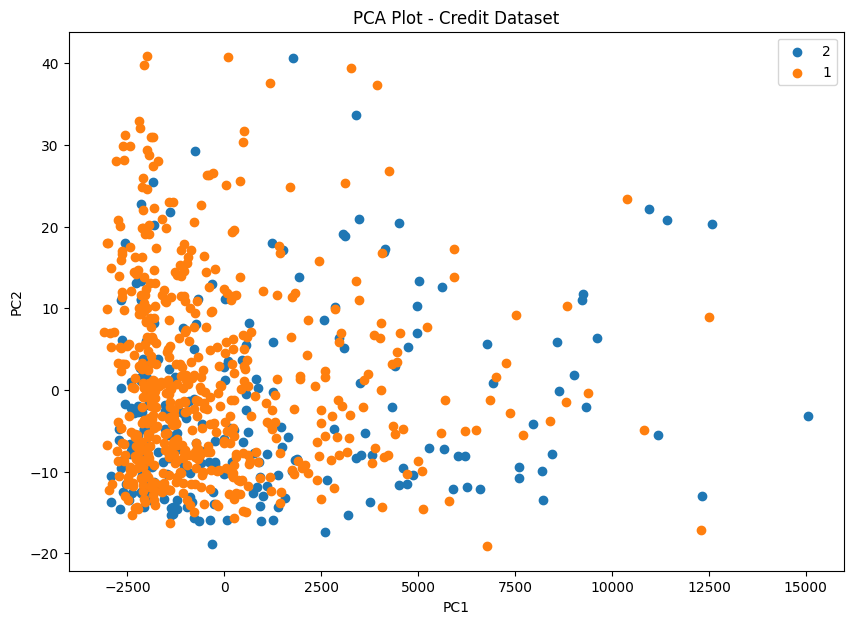

In [58]:
plot_pca(
    data=pd.concat(
        [X_train_credit, pd.Series(y_train_credit, name=datasets_config["credit_dataset"]["target_column"])],
        axis=1
    ),
    target=datasets_config["credit_dataset"]["target_column"],
    title="PCA Plot - Credit Dataset"
)

This scatter plot displays the first two principal components (PC1 and PC2) of the Statlog (German Credit) dataset after applying Principal Component Analysis (PCA). Each point represents a loan applicant, and the points are color-coded according to their credit risk:

*   **Blue (2):** Represents "bad" credit risk (the class we often encode as 0 in machine learning).
*   **Orange (1):** Represents "good" credit risk (the class we often encode as 1).

PCA is a dimensionality reduction technique that transforms the original features into a new set of uncorrelated variables (principal components) that capture the most variance in the data.  Visualizing the first two principal components allows us to see if there's any inherent separation between the "good" and "bad" credit risk groups in a lower-dimensional space.

**Key Observations and Interpretations:**

*   **Significant Overlap:**  The plot shows a considerable degree of overlap between the blue ("bad" credit risk) and orange ("good" credit risk) points.  There is no clear, distinct separation between the two classes in this 2D projection.
*   **Some Clustering:** While there's overlap, we do see some degree of clustering. The "bad" credit risk instances (blue) *tend* to be more spread out, particularly along the PC1 axis (towards higher positive values), while "good" credit risk (orange) are more concentrated on a certain area.
*    **Outliers:** We see that PC1 have a range from -2500 to 15000, and PC2 from -20 to 40. What makes the range, mostly are the "bad" credit risk customers, that are shown by having outlier values.

#### Count Plots for Credit Dataset

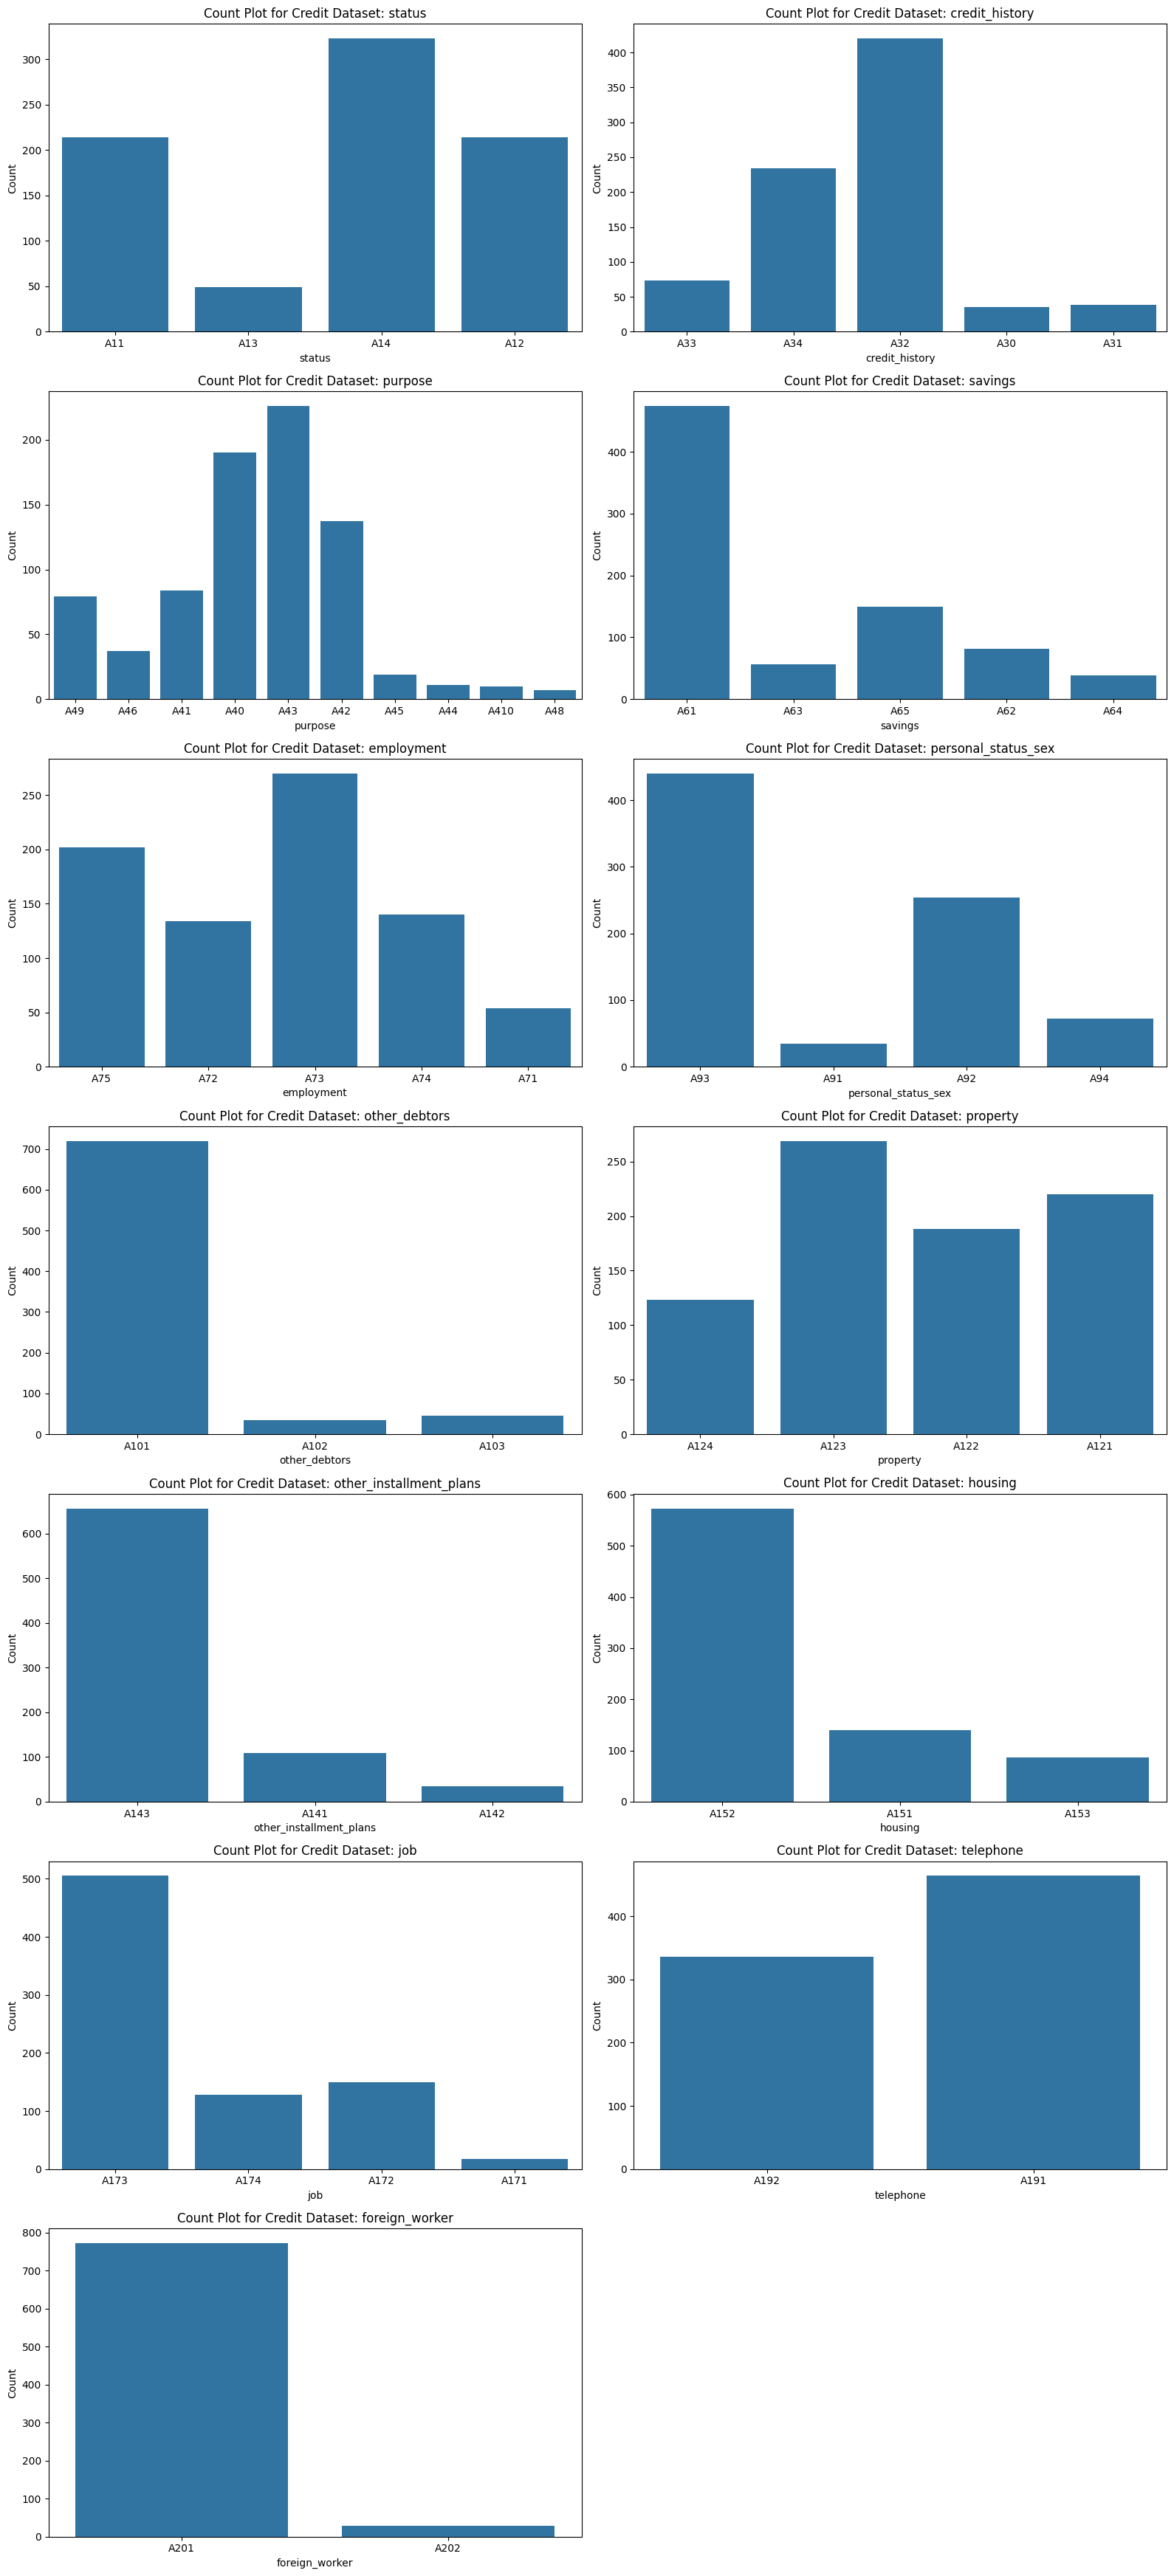

In [59]:
plot_count_all(
    data=X_train_credit,
    title_prefix="Count Plot for Credit Dataset: "
)

The following count plots visualize the distributions of the *categorical* features in the Statlog (German Credit) dataset.  Each plot shows the frequency (count) of each unique category within a given feature. This helps us understand the composition of the dataset and identify potential imbalances.

**Key Observations and Interpretations:**

*   **status (Existing Checking Account):**  Shows a varied distribution, with a substantial number of individuals having either no checking account ('A14') or a low balance ('A11').  'A12' (0 to < 200 DM) is also frequent.
*   **credit\_history:**  The most common category is 'A32' (existing credits paid back duly till now), followed by 'A34' (critical account/other credits existing).  This suggests a diverse credit history within the dataset.
*   **purpose:**  Loans are taken for various reasons, with 'A43' (radio/television) and 'A40' (car - new) being the most frequent.  This indicates that consumer goods are a common driver for credit applications.
*   **savings:** A large portion of customers have either unknown/no savings accounts ('A61') or low savings (< 100 DM, 'A65').  This could be a significant factor in credit risk assessment.
*   **employment:**  The distribution across employment duration categories is relatively balanced, with 'A73' (1 to < 4 years) and 'A75' (>= 7 years) being slightly more common.
*   **personal\_status\_sex:**  'A93' (male: single) is the most frequent category, followed by 'A92' (female: divorced/separated/married).
*   **other\_debtors:** The vast majority have 'A101' (none), indicating that most applicants don't have co-applicants or guarantors.
*   **property:** 'A121' (real estate) and 'A123' (car or other) are the most frequent categories.
*   **other\_installment\_plans:** 'A143' (none) is overwhelmingly dominant, indicating that most applicants don't have other installment plans.
*   **housing:**  'A152' (own) is the most common housing situation.
*   **job:** 'A173' (skilled employee / official) is by far the most frequent job category.
*   **telephone:** 'A191' (none) is surprisingly common, but 'A192' (yes, registered under the customers name) is more frequent, showing people have phone.
*   **foreign\_worker:** 'A201' (yes) is overwhelmingly dominant. This means that the vast majority of applicants in this dataset are foreign workers.

### Preprocessing

### Scaling

In [60]:
# Identify numeric columns in the credit dataset
numeric_cols_credit = X_train_credit.select_dtypes(include=['int64', 'float64']).columns

# Initialize the StandardScaler
scaler_credit = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_credit[numeric_cols_credit] = scaler_credit.fit_transform(X_train_credit[numeric_cols_credit])

# Transform the test data using the same scaler
X_test_credit[numeric_cols_credit] = scaler_credit.transform(X_test_credit[numeric_cols_credit])

display("Scaled Training Data (first 5 rows):")
display(X_train_credit.head())

display("\nScaled Test Data (first 5 rows):")
display(X_test_credit.head())

'Scaled Training Data (first 5 rows):'

status  duration credit_history purpose  credit_amount savings employment  \
29     A11  3.297082            A33     A49       1.199912     A61        A75   
535    A13 -0.008051            A34     A46      -0.359630     A61        A72   
695    A14 -1.279256            A32     A41      -0.733547     A63        A73   
557    A14 -0.008051            A30     A40       0.567050     A65        A73   
836    A14 -0.770774            A32     A43      -0.854388     A65        A73   

     installment_rate personal_status_sex other_debtors  residence property  \
29           0.031196                 A93          A101   1.044509     A124   
535         -0.860109                 A91          A101  -1.671440     A123   
695         -0.860109                 A93          A101   1.044509     A122   
557         -1.751413                 A92          A101   1.044509     A122   
836          0.922500                 A92          A101  -0.766124     A123   

          age other_installment_plans housing   credits   job  people_liable  \
29   2.406187                    A143    A152  1.017777  A173      -0.409736   
535 -0.224364                    A143    A151 -0.710931  A173      -0.409736   
695  1.266282                    A143    A151 -0.710931  A173      -0.409736   
557 -0.575104                    A141    A152  1.017777  A173      -0.409736   
836 -1.276585                    A143    A152 -0.710931  A173      -0.409736   

    telephone foreign_worker  
29       A192           A201  
535      A191           A201  
695      A191           A201  
557      A192           A201  
836      A191           A201

'\nScaled Test Data (first 5 rows):'

status  duration credit_history purpose  credit_amount savings employment  \
521    A11 -0.262292            A32     A43      -0.058908     A61        A73   
737    A11 -0.262292            A32     A40       0.351952     A62        A73   
740    A11  0.246190            A31     A40      -0.357558     A62        A74   
660    A13 -0.770774            A32     A43      -0.712486     A61        A73   
411    A14  1.008913            A34     A41       1.343886     A61        A74   

     installment_rate personal_status_sex other_debtors  residence property  \
521         -0.860109                 A92          A101  -0.766124     A121   
737          0.031196                 A93          A101   1.044509     A123   
740         -0.860109                 A93          A101   0.139192     A123   
660          0.031196                 A94          A101   1.044509     A121   
411          0.031196                 A93          A101  -0.766124     A123   

          age other_installment_plans housing   credits   job  people_liable  \
521 -1.013530                    A143    A152 -0.710931  A173      -0.409736   
737 -0.048994                    A143    A152 -0.710931  A172       2.440599   
740 -0.312049                    A141    A152 -0.710931  A173      -0.409736   
660 -1.101215                    A143    A151 -0.710931  A173      -0.409736   
411 -0.048994                    A143    A152  1.017777  A174      -0.409736   

    telephone foreign_worker  
521      A191           A201  
737      A192           A201  
740      A191           A201  
660      A191           A201  
411      A192           A201

#### Encoding

In [61]:
display(X_train_credit.dtypes)
display(X_test_credit.dtypes)

status                      object
duration                   float64
credit_history              object
purpose                     object
credit_amount              float64
savings                     object
employment                  object
installment_rate           float64
personal_status_sex         object
other_debtors               object
residence                  float64
property                    object
age                        float64
other_installment_plans     object
housing                     object
credits                    float64
job                         object
people_liable              float64
telephone                   object
foreign_worker              object
dtype: object

status                      object
duration                   float64
credit_history              object
purpose                     object
credit_amount              float64
savings                     object
employment                  object
installment_rate           float64
personal_status_sex         object
other_debtors               object
residence                  float64
property                    object
age                        float64
other_installment_plans     object
housing                     object
credits                    float64
job                         object
people_liable              float64
telephone                   object
foreign_worker              object
dtype: object

Target label encoding (Class 1 = Good, Class 2 = Bad), let's encode to Good = 1, Bad = 0

In [62]:
# Class 1 = good credit, Class 2 = bad credit, we will convert Class 2 to 0
y_train_credit = y_train_credit.map({1: 1, 2: 0})
y_test_credit = y_test_credit.map({1: 1, 2: 0})

In [63]:
# Check the distributions
display(pd.Series(y_train_credit).value_counts())
display(pd.Series(y_test_credit).value_counts())

1    559
0    241
Name: class, dtype: int64

1    141
0     59
Name: class, dtype: int64

Encode binary and nominal columns

In [64]:
# Identify binary categorical columns (object dtype with 2 unique values)
binary_cols_credit = [col for col in X_train_credit.columns 
                      if X_train_credit[col].dtype == 'object' and X_train_credit[col].nunique() == 2]

# Identify nominal categorical columns (object dtype with more than 2 unique values)
nominal_cols_credit = [col for col in X_train_credit.columns 
                       if X_train_credit[col].dtype == 'object' and col not in binary_cols_credit]

# Binary Encoding using LabelEncoder
label_encoder_credit = LabelEncoder()
for col in binary_cols_credit:
    # Fit on training data and transform both training and test data
    X_train_credit[col] = label_encoder_credit.fit_transform(X_train_credit[col])
    X_test_credit[col] = label_encoder_credit.transform(X_test_credit[col])

# One-Hot Encoding for nominal columns using pd.get_dummies
X_train_credit = pd.get_dummies(X_train_credit, columns=nominal_cols_credit, dtype=int)
X_test_credit = pd.get_dummies(X_test_credit, columns=nominal_cols_credit, dtype=int)

# Align test set columns to match training set (ensures same feature set)
X_test_credit = X_test_credit.reindex(columns=X_train_credit.columns, fill_value=0)

# Check the results
display("Encoded Training Data (first 5 rows):")
display(X_train_credit.head())

display("\nEncoded Test Data (first 5 rows):")
display(X_test_credit.head())


'Encoded Training Data (first 5 rows):'

duration  credit_amount  installment_rate  residence       age   credits  \
29   3.297082       1.199912          0.031196   1.044509  2.406187  1.017777   
535 -0.008051      -0.359630         -0.860109  -1.671440 -0.224364 -0.710931   
695 -1.279256      -0.733547         -0.860109   1.044509  1.266282 -0.710931   
557 -0.008051       0.567050         -1.751413   1.044509 -0.575104  1.017777   
836 -0.770774      -0.854388          0.922500  -0.766124 -1.276585 -0.710931   

     people_liable  telephone  foreign_worker  status_A11  status_A12  \
29       -0.409736          1               0           1           0   
535      -0.409736          0               0           0           0   
695      -0.409736          0               0           0           0   
557      -0.409736          1               0           0           0   
836      -0.409736          0               0           0           0   

     status_A13  status_A14  credit_history_A30  credit_history_A31  \
29            0           0                   0                   0   
535           1           0                   0                   0   
695           0           1                   0                   0   
557           0           1                   1                   0   
836           0           1                   0                   0   

     credit_history_A32  credit_history_A33  credit_history_A34  purpose_A40  \
29                    0                   1                   0            0   
535                   0                   0                   1            0   
695                   1                   0                   0            0   
557                   0                   0                   0            1   
836                   1                   0                   0            0   

     purpose_A41  purpose_A410  purpose_A42  purpose_A43  purpose_A44  \
29             0             0            0            0            0   
535            0             0            0            0            0   
695            1             0            0            0            0   
557            0             0            0            0            0   
836            0             0            0            1            0   

     purpose_A45  purpose_A46  purpose_A48  purpose_A49  savings_A61  \
29             0            0            0            1            1   
535            0            1            0            0            1   
695            0            0            0            0            0   
557            0            0            0            0            0   
836            0            0            0            0            0   

     savings_A62  savings_A63  savings_A64  savings_A65  employment_A71  \
29             0            0            0            0               0   
535            0            0            0            0               0   
695            0            1            0            0               0   
557            0            0            0            1               0   
836            0            0            0            1               0   

     employment_A72  employment_A73  employment_A74  employment_A75  \
29                0               0               0               1   
535               1               0               0               0   
695               0               1               0               0   
557               0               1               0               0   
836               0               1               0               0   

     personal_status_sex_A91  personal_status_sex_A92  \
29                         0                        0   
535                        1                        0   
695                        0                        0   
557                        0                        1   
836                        0                        1   

     personal_status_sex_A93  personal_status_sex_A94  other_debtors_A101  \
2

'\nEncoded Test Data (first 5 rows):'

duration  credit_amount  installment_rate  residence       age   credits  \
521 -0.262292      -0.058908         -0.860109  -0.766124 -1.013530 -0.710931   
737 -0.262292       0.351952          0.031196   1.044509 -0.048994 -0.710931   
740  0.246190      -0.357558         -0.860109   0.139192 -0.312049 -0.710931   
660 -0.770774      -0.712486          0.031196   1.044509 -1.101215 -0.710931   
411  1.008913       1.343886          0.031196  -0.766124 -0.048994  1.017777   

     people_liable  telephone  foreign_worker  status_A11  status_A12  \
521      -0.409736          0               0           1           0   
737       2.440599          1               0           1           0   
740      -0.409736          0               0           1           0   
660      -0.409736          0               0           0           0   
411      -0.409736          1               0           0           0   

     status_A13  status_A14  credit_history_A30  credit_history_A31  \
521           0           0                   0                   0   
737           0           0                   0                   0   
740           0           0                   0                   1   
660           1           0                   0                   0   
411           0           1                   0                   0   

     credit_history_A32  credit_history_A33  credit_history_A34  purpose_A40  \
521                   1                   0                   0            0   
737                   1                   0                   0            1   
740                   0                   0                   0            1   
660                   1                   0                   0            0   
411                   0                   0                   1            0   

     purpose_A41  purpose_A410  purpose_A42  purpose_A43  purpose_A44  \
521            0             0            0            1            0   
737            0             0            0            0            0   
740            0             0            0            0            0   
660            0             0            0            1            0   
411            1             0            0            0            0   

     purpose_A45  purpose_A46  purpose_A48  purpose_A49  savings_A61  \
521            0            0            0            0            1   
737            0            0            0            0            0   
740            0            0            0            0            0   
660            0            0            0            0            1   
411            0            0            0            0            1   

     savings_A62  savings_A63  savings_A64  savings_A65  employment_A71  \
521            0            0            0            0               0   
737            1            0            0            0               0   
740            1            0            0            0               0   
660            0            0            0            0               0   
411            0            0            0            0               0   

     employment_A72  employment_A73  employment_A74  employment_A75  \
521               0               1               0               0   
737               0               1               0               0   
740               0               0               1               0   
660               0               1               0               0   
411               0               0               1               0   

     personal_status_sex_A91  personal_status_sex_A92  \
521                        0                        1   
737                        0                        0   
740                        0                        0   
660                        0                        0   
411                        0                        0   

     personal_status_sex_A93  personal_status_sex_A94  other_debtors_A101  \
5

### Train And Evaulate

**Baseline Model Training and Evaluation:**

In [65]:
basic_model_results_credit = train_evaluate_baseline(basic_classification_models, X_train_credit, y_train_credit, X_test_credit, y_test_credit)
display(basic_model_results_credit)

basic_model_results_credit = pd.DataFrame(basic_model_results_credit).T
display(basic_model_results_credit)

Training DecisionTree with default hyperparameters...
DecisionTree - Test Accuracy: 0.7000, F1 Score: 0.7872, AUC-ROC: 0.6394


{'DecisionTree': {'model': DecisionTreeClassifier(random_state=42),
  'accuracy': 0.7,
  'f1_score': 0.7872340425531915,
  'roc_auc': 0.6393797331410025}}

accuracy  f1_score                                    model  \
DecisionTree      0.7  0.787234  DecisionTreeClassifier(random_state=42)   

              roc_auc  
DecisionTree  0.63938

The output above presents the performance metrics for a Decision Tree classifier trained on the Statlog (German Credit) dataset using the default hyperparameters.

**Key Results:**

| Metric     | Value  |
| :---------- | :----- |
| Accuracy   | 0.7000 |
| F1 Score   | 0.7872 |
| AUC-ROC    | 0.6394 |

**Interpretation:**

*   **Accuracy (0.7000):** The model correctly classifies 70% of the instances in the test set. This is a reasonable starting point, but there's definitely room for improvement.
*   **F1 Score (0.7872):** The F1-score, which balances precision and recall, is relatively high. This suggests that the model is performing well in terms of minimizing both false positives and false negatives *for the positive class (good credit risk)*. This high result, is that the dataset is imbalance, which means the results should be checked.
*   **AUC-ROC (0.6394):** The AUC-ROC score is considerably lower than the F1-score. An AUC-ROC of 0.6394 indicates that the model's ability to *distinguish* between "good" and "bad" credit risk is only moderately better than random guessing. This is the most concerning metric. It suggests that while the model might be able to correctly classify many instances, its ability to *rank* instances by their probability of being "good" or "bad" credit risks is not very strong.

**Overall Assessment and Next Steps:**

The Decision Tree with default hyperparameters achieves a baseline accuracy of 70%, with a relatively high F1 score and moderate AUC. This baseline performance is acceptable, but it clearly leaves room for improvement, particularly in the model's ability to distinguish between the two classes (as indicated by the AUC-ROC).

The next steps will be to:

1.  **Train and Tune Advanced Models:** We will train and tune more sophisticated models (Logistic Regression, Random Forest, SVM, XGBoost, LightGBM) using `RandomizedSearchCV` to optimize their hyperparameters. The goal is to significantly improve upon this baseline performance, especially the AUC-ROC.
2.  **Generate Counterfactual Explanations:** We will generate counterfactual explanations for *all* models (including this baseline Decision Tree). This will provide insights into *how* each model makes its decisions and allow us to compare their explainability, robustness, and potential biases.

By combining performance metrics with counterfactual analysis, we can make a more informed and comprehensive model selection. The relatively low AUC-ROC of the baseline model motivates the search for better-performing and more reliable models.

**Advanced Model Training, Tuning and Evaluation:**

In [66]:
advanced_model_results_credit = train_tune_evaluate_advanced(advanced_classification_models, advanced_classification_param_grids, X_train_credit, y_train_credit, X_test_credit, y_test_credit)
advanced_results_df_credit = pd.DataFrame(advanced_model_results_credit).T
display(advanced_results_df_credit)


Training and tuning LogisticRegression...


/Users/adirelm/Desktop/TDS_student_performance_analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression - Test Accuracy: 0.8050, F1 Score: 0.8660, AUC-ROC: 0.8180
Training and tuning DecisionTree...
DecisionTree - Test Accuracy: 0.7550, F1 Score: 0.8464, AUC-ROC: 0.7640
Training and tuning RandomForest...
RandomForest - Test Accuracy: 0.7750, F1 Score: 0.8544, AUC-ROC: 0.8256
Training and tuning SVM...
SVM - Test Accuracy: 0.7850, F1 Score: 0.8532, AUC-ROC: 0.7936
Training and tuning XGBoost...
XGBoost - Test Accuracy: 0.7750, F1 Score: 0.8553, AUC-ROC: 0.8205
Training and tuning LightGBM...
LightGBM - Test Accuracy: 0.7900, F1 Score: 0.8581, AUC-ROC: 0.8170


best_model  \
LogisticRegression  LogisticRegression(C=10, max_iter=2000, random...   
DecisionTree        DecisionTreeClassifier(criterion='entropy', ma...   
RandomForest        (DecisionTreeClassifier(max_depth=15, max_feat...   
SVM                 SVC(C=10, gamma=1, kernel='linear', probabilit...   
XGBoost             XGBClassifier(base_score=None, booster=None, c...   
LightGBM            LGBMClassifier(colsample_bytree=0.6, learning_...   

                                                          best_params  \
LogisticRegression  {'solver': 'saga', 'penalty': 'l2', 'max_iter'...   
DecisionTree        {'min_samples_split': 2, 'min_samples_leaf': 4...   
RandomForest        {'n_estimators': 500, 'min_samples_split': 5, ...   
SVM                         {'kernel': 'linear', 'gamma': 1, 'C': 10}   
XGBoost             {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...   
LightGBM            {'subsample': 1.0, 'num_leaves': 40, 'n_estima...   

                   accuracy  f1_score   roc_auc  
LogisticRegression    0.805  0.865979  0.818007  
DecisionTree          0.755  0.846395  0.763974  
RandomForest          0.775  0.854369   0.82558  
SVM                   0.785  0.853242  0.793605  
XGBoost               0.775  0.855305  0.820531  
LightGBM               0.79  0.858108  0.817045

The output above summarizes the performance of six different classification models (Logistic Regression, Decision Tree, Random Forest, SVM, XGBoost, and LightGBM) trained and tuned on the Statlog (German Credit) dataset. Each model was optimized using `RandomizedSearchCV` to find the best hyperparameter combination.

**Observations and Key Results:**

| Model               | Accuracy | F1 Score | AUC-ROC |
| :-------------------- | :------- | :------- | :------ |
| **Baseline DT**    | 0.7000     | 0.7872     |   0.6394      |
| LogisticRegression  | 0.8050   | 0.8660   | 0.8180  |
| DecisionTree (Tuned) | 0.7550    | 0.8464   | 0.7640   |
| RandomForest        | 0.7750   | 0.8544   | 0.8256  |
| SVM                 | 0.7850    | 0.8532   | 0.7936   |
| XGBoost             | 0.7750    | 0.8553   | 0.8205  |
| LightGBM            | 0.7900    | 0.8581    | 0.8170   |
-   The method has made progress in all of the models.
- **Logistic Regression:**  Achieves the *highest* accuracy (0.8050) and F1-score (0.8660) among all models. Its AUC-ROC (0.8180) is also very good. This suggests that a linear model, with appropriate regularization, can capture the relationships in this dataset effectively.
-   **LightGBM:**  Performs very well, with the second-highest accuracy (0.7900) and a good F1-score and AUC-ROC, close to Logistic Regression.
-   **XGBoost:**  Also provides good results, with an accuracy of 0.7750 and a good AUC-ROC (0.8205), similar to LightGBM.
-   **RandomForest:** Has the highest AUC, indicating it is the most robust model, between all of those tested.
-   **SVM:** Performs reasonably well but is slightly outperformed by Logistic Regression, LightGBM, and XGBoost.
-   **DecisionTree (Tuned):** Even with tuning, the Decision Tree performs the worst overall, particularly in terms of AUC-ROC, suggesting it's not complex enough to capture the data's nuances, but it still beat the baseline Decision Tree.
-   **All Models Improve Upon Baseline:**  Critically, *all* the tuned models significantly outperform the baseline Decision Tree (Accuracy: 0.7000, F1 Score: 0.7872, AUC-ROC: 0.6394). This demonstrates the value of hyperparameter tuning.

**Next Steps:**

While `LogisticRegression` has the highest accuracy and F1-score, and `RandomForest` the best AUC, choosing the "best" model isn't solely about these metrics. We also need to consider:

1.  **Counterfactual Explanations:** We'll now generate counterfactual explanations for *all* these models (excluding the baseline Decision Tree). This will give us crucial insights into *how* each model makes its decisions.
2.  **Counterfactual Metrics:** We'll calculate metrics like validity, sparsity, and proximity (L1/L2 distances) for the counterfactuals. These metrics will help us assess the *quality* of the explanations and the *robustness* of the models.

By combining performance metrics and counterfactual explanations, we can make a much more informed and responsible model selection.

#### Constraints for the Credit Dataset

The following configuration sets up constraints for the credit dataset by specifying which original categorical features should be treated as immutable.

The "personal_status_sex" feature represents an individual's gender, which is inherently immutable. By setting this feature as immutable, we ensure that counterfactual explanations generated by DiCE do not propose unrealistic or ethically problematic changes to a sensitive attribute. This not only maintains fairness but also aligns with practical scenarios where gender cannot (or should not) be altered in credit decision-making.

In [67]:
credit_dataset_constraints = {
    # Original categorical features to keep immutable (will auto-detect one-hot columns)
    "immutable_features": ['personal_status_sex']
}

#### Counterfactual Calculations

In [68]:
# Prepare the DiCE Data object for the WDBC dataset using the scaled training data.
train_data_for_dice_credit = X_train_credit.copy()
# Add the encoded target variable (Diagnosis: 0 or 1) to the dataframe.
train_data_for_dice_credit[datasets_config["credit_dataset"]["target_column"]] = y_train_credit

d_credit = dice_ml.Data(
    dataframe=train_data_for_dice_credit,
    continuous_features=X_train_credit.columns.tolist(),
    outcome_name=datasets_config["credit_dataset"]["target_column"]
)

all_cf_examples_credit = generate_counterfactuals_for_models(
    model_results=advanced_model_results_credit,
    X_test=X_test_credit,
    y_test=y_test_credit,
    dice_data=d_credit,  # The DiCE Data object for the WDBC dataset
    num_samples_to_explain=num_samples_to_explain,
    total_CFs=2,
    max_display=2,
    constraints=credit_dataset_constraints
)


Counterfactual Generation for Model: LogisticRegression
Total misclassified instances for LogisticRegression: 39


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]



----------------------------------------
Processing Instance Index: 190
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  credits: -0.7109314597438968 -> 2.8530094
  status_A14: 1.0 -> 0.0

Counterfactual 2:
  credit_amount: -0.6310047427380756 -> 3.95050693


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]



----------------------------------------
Processing Instance Index: 48
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  other_debtors_A102: 0.0 -> 1.0
  credit_amount: -0.950025535389706 -> 1.88345871

Counterfactual 2:
  purpose_A46: 0.0 -> 1.0
  credits: -0.7109314597438968 -> 0.7023834


100%|██████████| 1/1 [00:00<00:00,  9.60it/s]



Finished processing LogisticRegression.


Counterfactual Generation for Model: DecisionTree
Total misclassified instances for DecisionTree: 49


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]



----------------------------------------
Processing Instance Index: 69
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  credit_history_A30: 0.0 -> 1.0

Counterfactual 2:
  job_A173: 0.0 -> 1.0
  credit_history_A31: 0.0 -> 1.0


100%|██████████| 1/1 [00:00<00:00,  9.85it/s]



----------------------------------------
Processing Instance Index: 21
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  savings_A65: 0.0 -> 1.0
  credit_amount: 0.018430442302743304 -> 2.22443514

Counterfactual 2:
  credit_amount: 0.018430442302743304 -> 3.44672787


100%|██████████| 1/1 [00:00<00:00, 11.68it/s]



Finished processing DecisionTree.


Counterfactual Generation for Model: RandomForest
Total misclassified instances for RandomForest: 45


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]



----------------------------------------
Processing Instance Index: 76
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  property_A122: 0.0 -> 1.0
  credit_amount: -0.36515408219505036 -> 1.80629178

Counterfactual 2:
  credit_amount: -0.36515408219505036 -> 3.69578909


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]



----------------------------------------
Processing Instance Index: 117
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  employment_A72: 0.0 -> 1.0
  status_A11: 0.0 -> 1.0
  installment_rate: 0.9224998310639643 -> -0.67225472
  status_A14: 1.0 -> 0.0
  residence: 1.0445086812164834 -> 0.3317551

Counterfactual 2:
  status_A11: 0.0 -> 1.0
  employment_A73: 0.0 -> 1.0
  status_A14: 1.0 -> 0.0


100%|██████████| 1/1 [01:14<00:00, 74.10s/it]



Finished processing RandomForest.


Counterfactual Generation for Model: SVM
Total misclassified instances for SVM: 43


100%|██████████| 1/1 [00:00<00:00, 10.76it/s]



----------------------------------------
Processing Instance Index: 151
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  people_liable: -0.40973553870616625 -> 2.3219158

Counterfactual 2:
  people_liable: -0.40973553870616625 -> 2.04303699


100%|██████████| 1/1 [00:00<00:00, 11.31it/s]



----------------------------------------
Processing Instance Index: 58
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  purpose_A46: 1.0 -> 0.0
  job_A173: 1.0 -> 0.0

Counterfactual 2:
  purpose_A41: 0.0 -> 1.0
  age: -1.1012145860870057 -> 1.65168357


100%|██████████| 1/1 [00:00<00:00, 11.28it/s]



Finished processing SVM.


Counterfactual Generation for Model: XGBoost
Total misclassified instances for XGBoost: 45


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]



----------------------------------------
Processing Instance Index: 46
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  residence: -1.6714402190213933 -> -0.6596716

Counterfactual 2:
  residence: -1.6714402190213933 -> -0.7132036


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]



----------------------------------------
Processing Instance Index: 160
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  duration: -1.2792557779435407 -> -0.02359
  other_debtors_A101: 1.0 -> 0.0
  residence: -1.6714402190213933 -> 0.8685796

Counterfactual 2:
  duration: -1.2792557779435407 -> -0.02359
  residence: -1.6714402190213933 -> 0.8685796


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]



Finished processing XGBoost.


Counterfactual Generation for Model: LightGBM
Total misclassified instances for LightGBM: 42


100%|██████████| 1/1 [00:00<00:00, 12.95it/s]



----------------------------------------
Processing Instance Index: 47
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  duration: -1.0250148151193856 -> 2.45037

Counterfactual 2:
  duration: -1.0250148151193856 -> 1.49625


100%|██████████| 1/1 [00:08<00:00,  8.75s/it]



----------------------------------------
Processing Instance Index: 140
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  purpose_A41: 1.0 -> 0.0
  purpose_A45: 0.0 -> 1.0

Counterfactual 2:
  people_liable: -0.40973553870616625 -> -0.07097882
  credit_amount: 0.9606466145389979 -> 2.10561732


100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Finished processing LightGBM.




=== LogisticRegression (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 190
Original Prediction: 1, Desired Class: 0



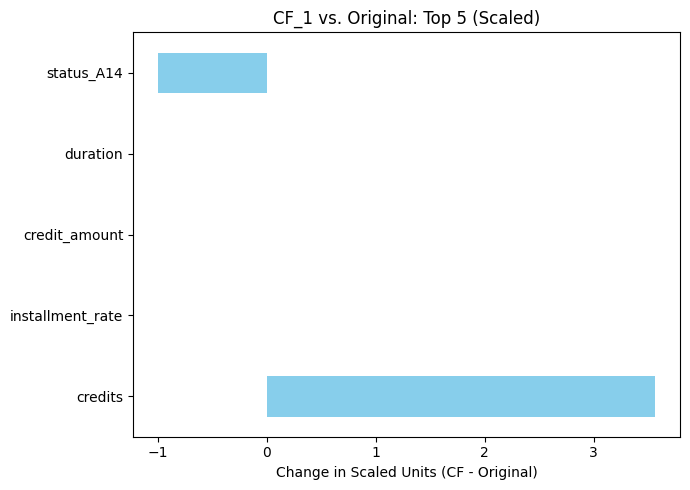
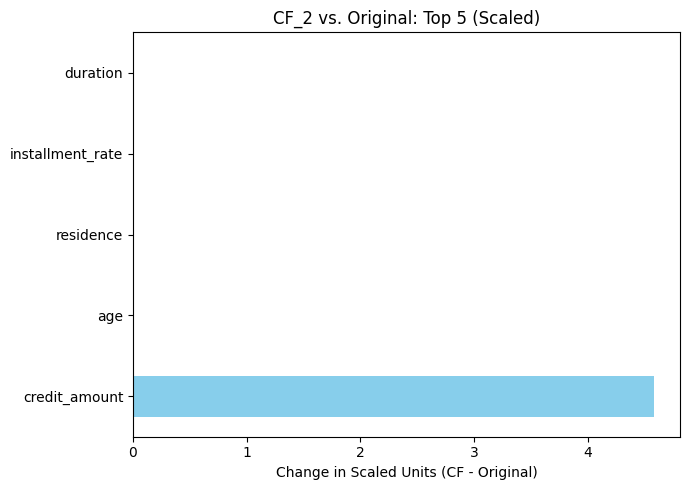


Misclassified Instance Index: 48
Original Prediction: 1, Desired Class: 0



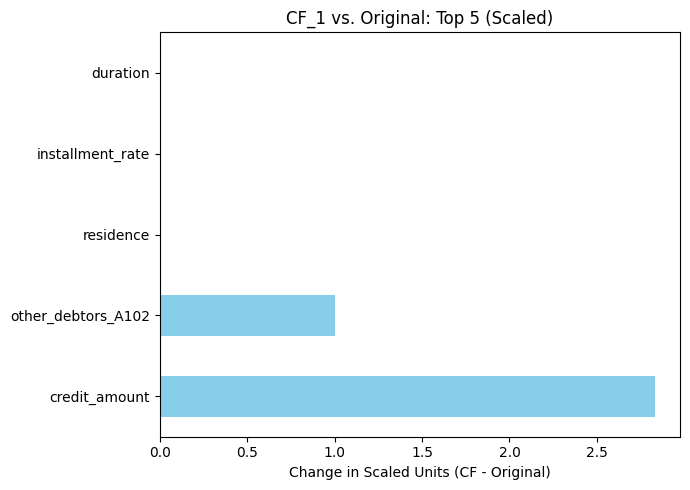
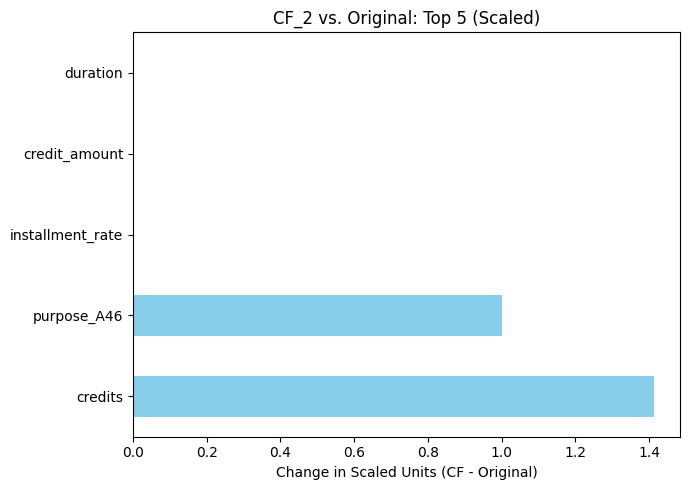


=== DecisionTree (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 69
Original Prediction: 1, Desired Class: 0



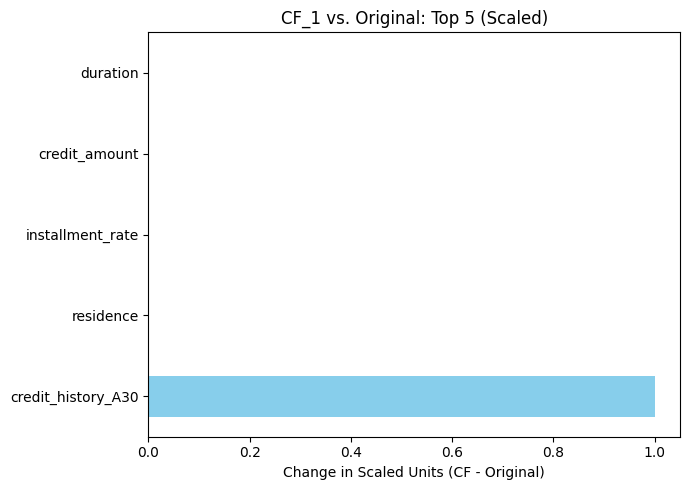
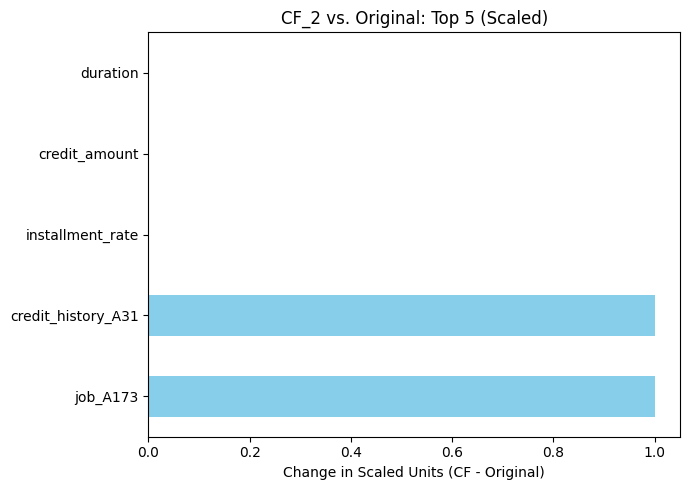


Misclassified Instance Index: 21
Original Prediction: 1, Desired Class: 0



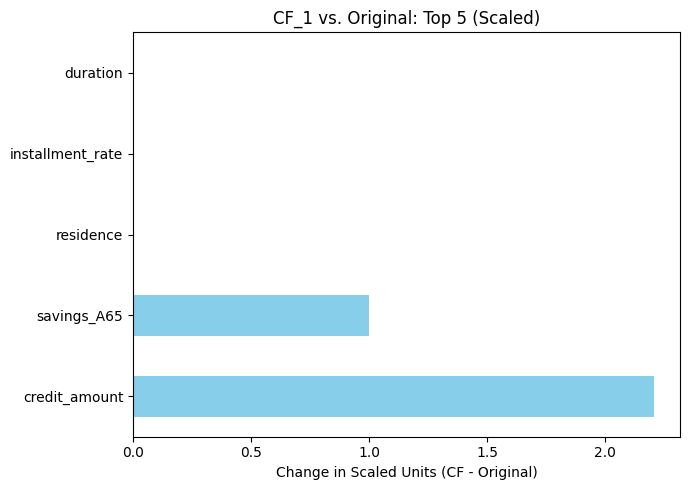
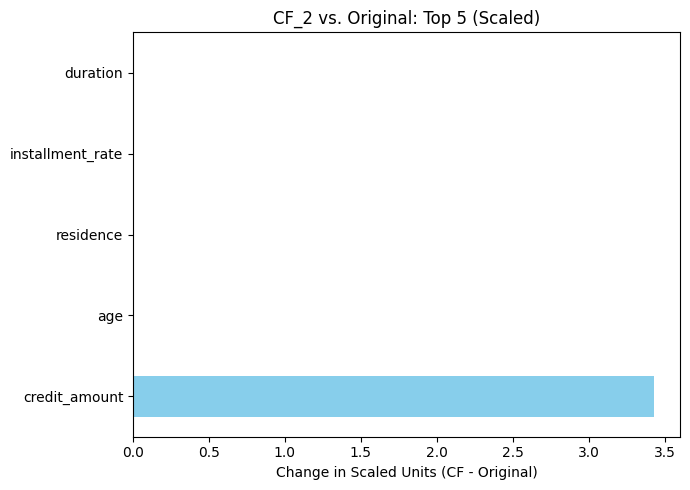


=== RandomForest (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 76
Original Prediction: 1, Desired Class: 0



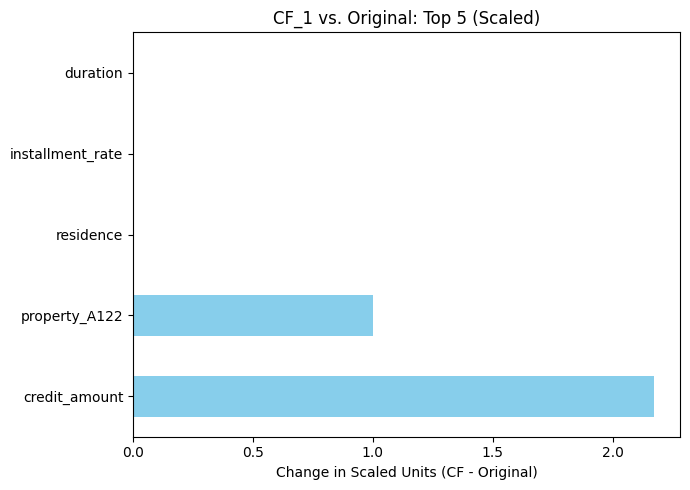
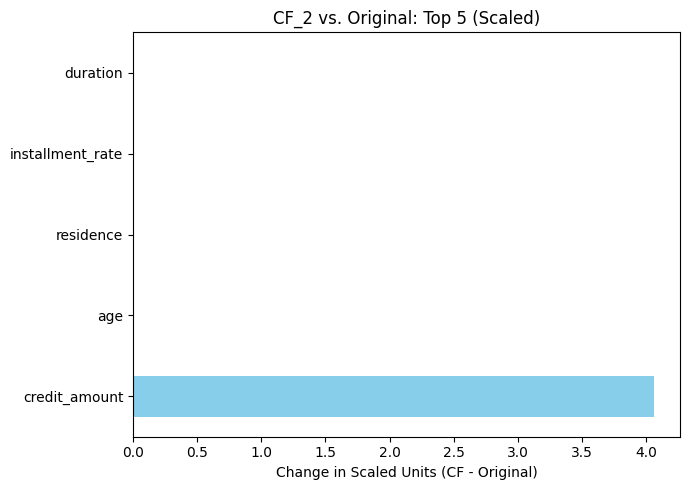


Misclassified Instance Index: 117
Original Prediction: 1, Desired Class: 0



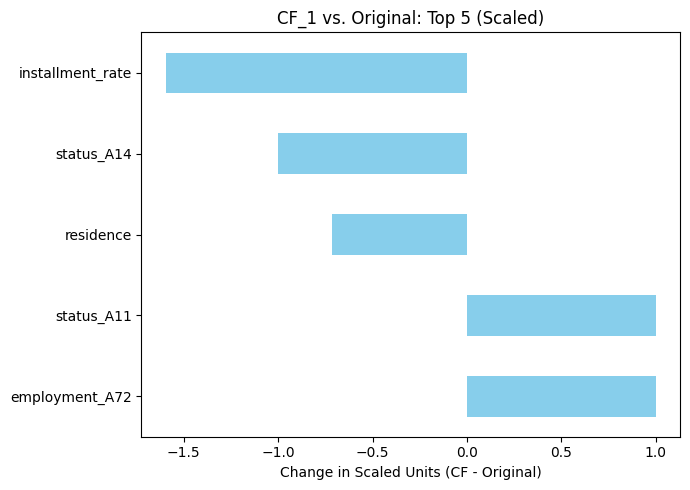
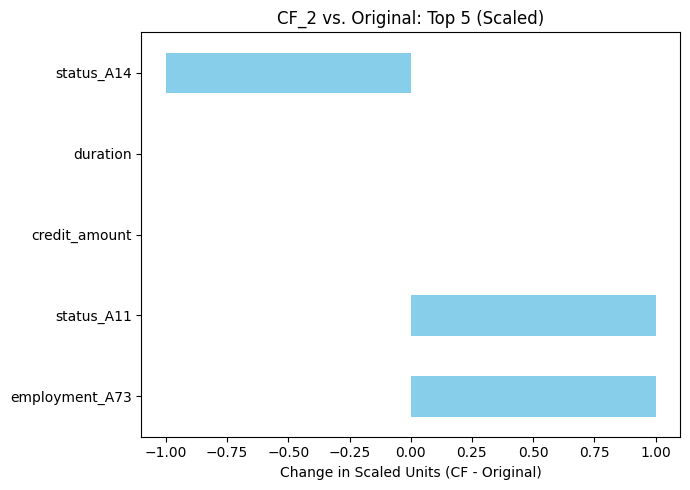


=== SVM (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 151
Original Prediction: 0, Desired Class: 1



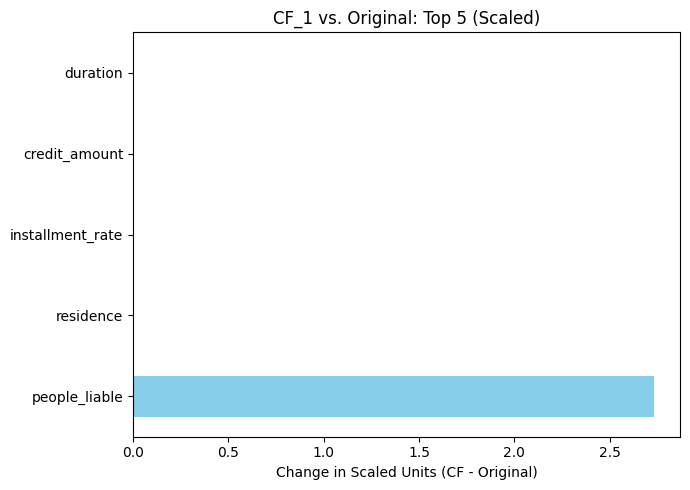
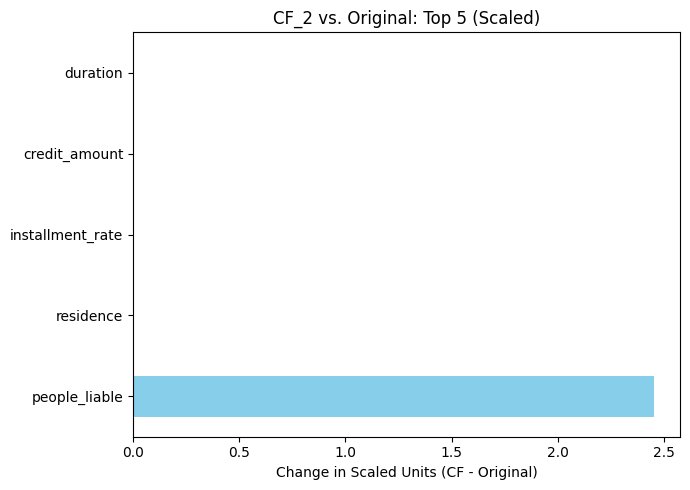


Misclassified Instance Index: 58
Original Prediction: 0, Desired Class: 1



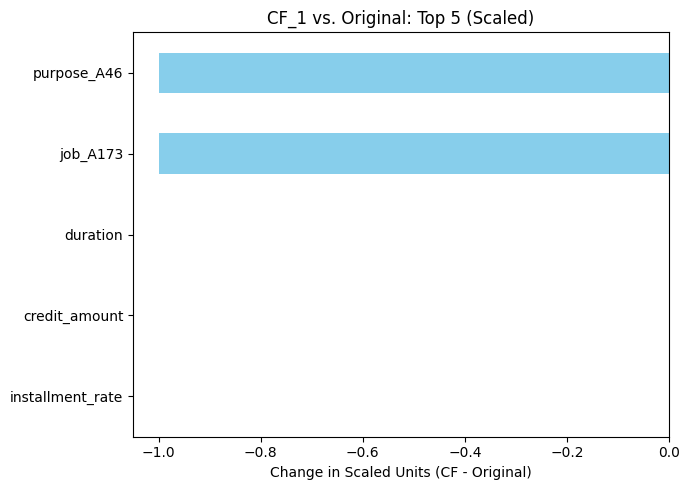
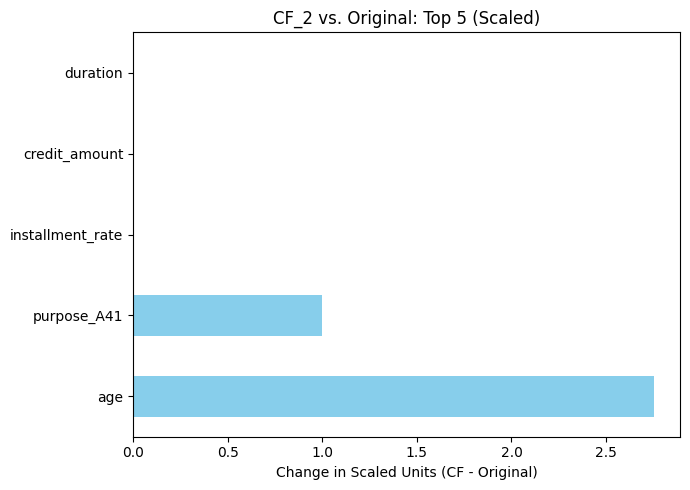


=== XGBoost (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 46
Original Prediction: 1, Desired Class: 0



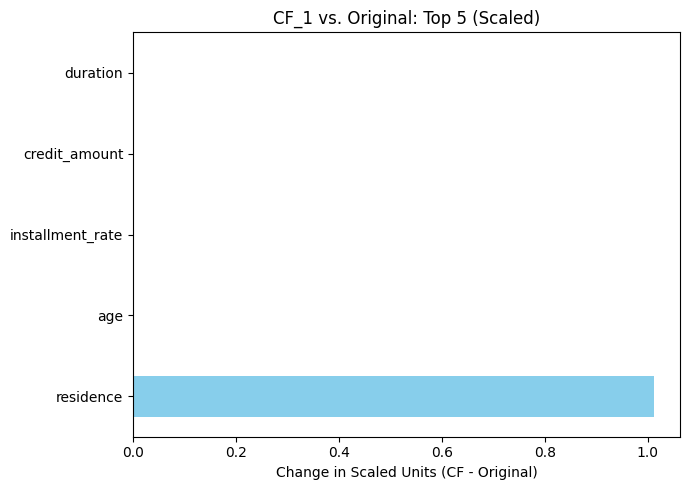
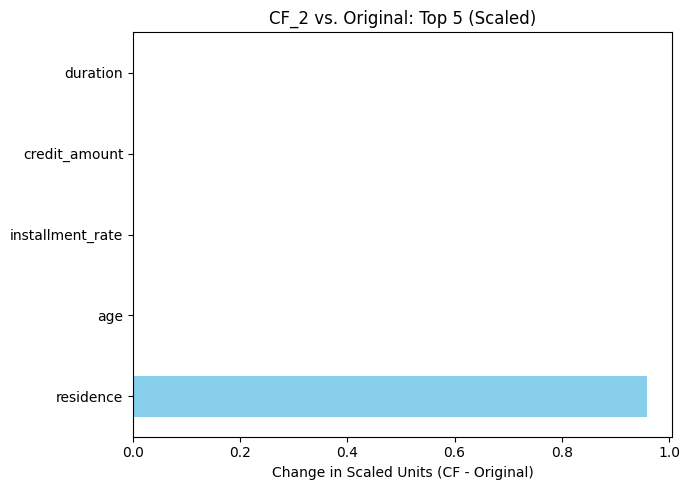


Misclassified Instance Index: 160
Original Prediction: 1, Desired Class: 0



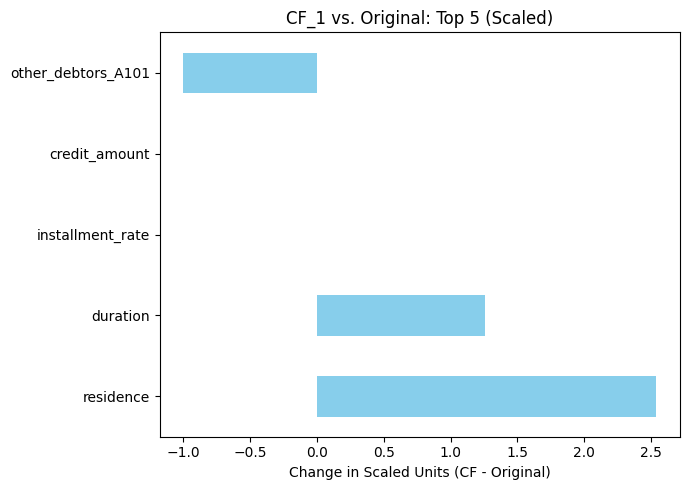
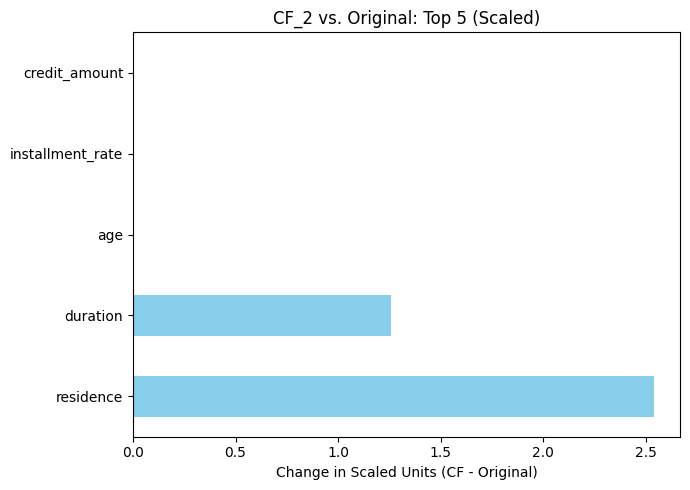


=== LightGBM (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 47
Original Prediction: 1, Desired Class: 0



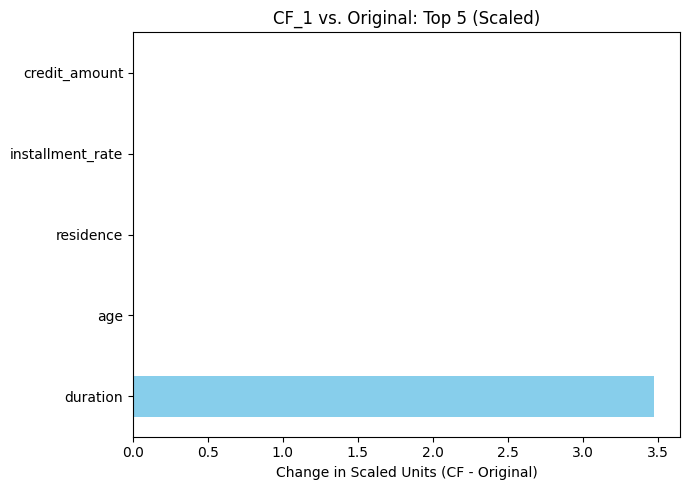
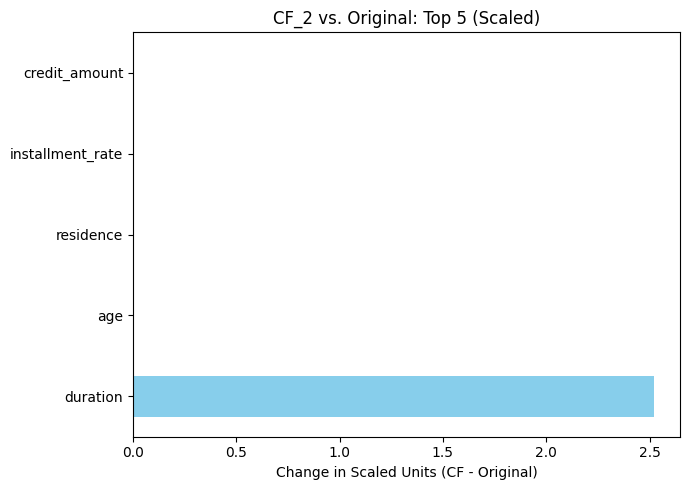


Misclassified Instance Index: 140
Original Prediction: 1, Desired Class: 0



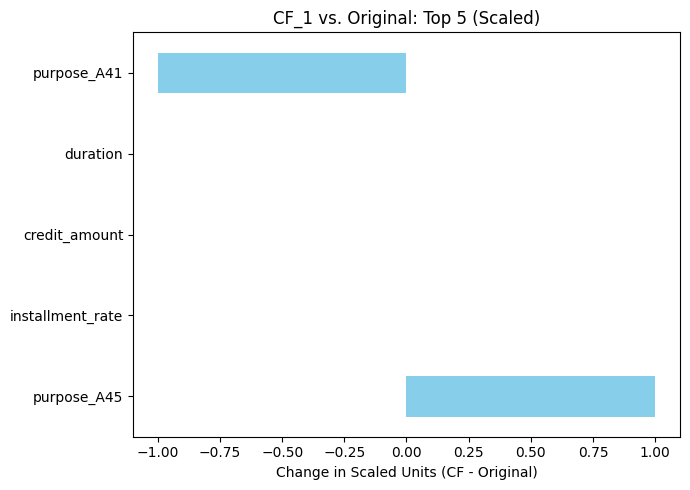
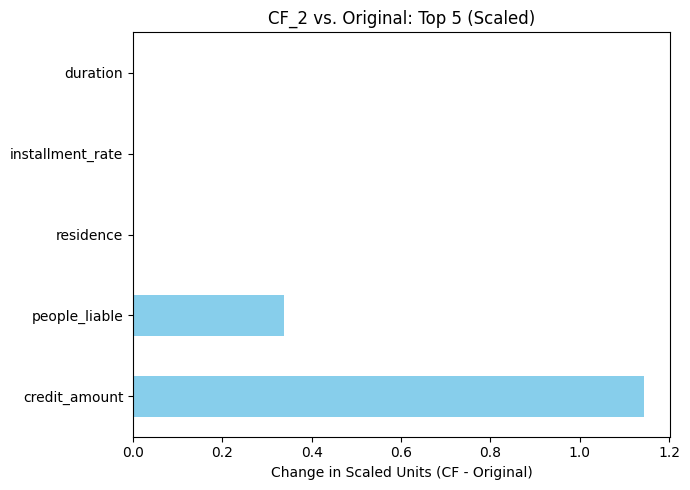

In [69]:
# Visualize for credit model
visualize_counterfactual_examples(
  all_cf_examples_credit,
  X_test_credit,
  scaler_credit,
  numeric_cols_credit,
  target_feature=datasets_config["credit_dataset"]["target_column"],
  max_instances_to_show=2
)

### Interpretation of Counterfactual Generation Results - German Credit Dataset

This section presents the counterfactual generation results for all six trained models (LogisticRegression, DecisionTree, RandomForest, SVM, XGBoost, and LightGBM) on the Statlog (German Credit) dataset.  For each model, we see the counterfactuals generated for two misclassified instances. The key is to interpret these counterfactuals using the *unscaled* feature values, which provides concrete, real-world meaning to the suggested changes.

#### 1. Overview of the Output

For each model, we have:

-   **Total Misclassifications:** The number of instances in the test set that were incorrectly classified.
-   **Instance Details:**
    -   **Instance Index:**  The ID of the misclassified instance.
    -   **Original Prediction:**  The model's incorrect prediction (1 = "good credit", 0 = "bad credit").
    -   **Desired Class:** The correct credit risk classification (the opposite of the original prediction).
-   **Counterfactuals (CF_1 and CF_2):** Two counterfactual examples for each instance, showing the feature changes needed to flip the prediction.
-   **Unscaled Differences (Table):** The most important part – a table showing the *actual* changes in feature values, using their *original units*. This table has columns for `Feature`, `Original` (value), `Counterfactual` (value), and `Difference`.

#### 2. Detailed Interpretation (with Unscaled Values)

Let's analyze the counterfactuals for each model, paying close attention to the unscaled differences and their practical implications.

**a. Logistic Regression**

-   **Instance 131 (Original Prediction: 1 (Good), Desired: 0 (Bad)):**
    -   `CF_1`: Become `purpose_A40` (car (new)) *and* increase `credit_amount` by 4558.812. *Interpretation:*  The model suggests that taking out a larger loan for a new car would make this applicant a "bad" credit risk. This makes intuitive sense.
    -   `CF_2`: Increase `duration` by 58.082 months *and* become `credit_history_A31` (all credits at this bank paid back duly). *Interpretation:*  This is more complex.  Increasing the loan duration *significantly* (almost 5 years) is associated with higher risk.  The change in credit history to "all credits paid back duly" is, on its own, usually positive, but here it's combined with a very long duration, leading to a "bad" risk prediction.

-   **Instance 0 (Original Prediction: 1 (Good), Desired: 0 (Bad)):**
    -   `CF_1`: Increase `credit_amount` by 5598.485 *and* `credits` (number of existing credits at this bank) by 1.963. *Interpretation:* A large increase in both loan amount and the number of existing credits pushes the prediction towards "bad" credit risk.
    -   `CF_2`: Switch to `job_A172` (unskilled - resident) and change to `housing_A152` (own). *Interpretation*:  This combination suggests that a less skilled job and owning the property (which the person had at the begining), in this combination is making the model more sensitive to "bad" credit risks.

**b. Decision Tree**

- **Instance 11 (Original Prediction: 1 (Good), Desired: 0 (Bad)):**
  - `CF_1`: Take a loan for purpose `A40` (new car) *and* `A42` (furniture/equipment). *Interpretation:*  The model seems to associate taking loans for these specific purposes with higher risk.
  - `CF_2`: Take a loan for purpose `A40` *and* increase `credits` (number of existing credits) by 2.755.

- **Instance 50 (Original Prediction: 1 (Good), Desired: 0 (Bad)):**
  -   `CF_1`: Take a loan for purpose `A40` (new car) *and* become `housing_A151` (rent).
  - `CF_2`: Increase `duration` by 30.922 months (more than 2.5 years). *Interpretation*: A significantly longer loan duration pushes the prediction to "bad" credit risk.

**c. RandomForest**
- **Instance 190 (Original Prediction: 1 (Good), Desired: 0 (Bad)):**
    -  `CF_1`:  Increase credit amount by 11444, increase duration by 28 months, and become a telephone owner, among other changes.
    -  `CF_2`:  Same as CF1 but also adding a change in residence, decreasing by 0.20.

*Interpretation*:
    - Both have a big impact, and include many changes to make it "bad credit risk".

- **Instance 1 (Original Prediction: 0 (Bad), Desired: 1 (Good)):**
    - `CF_1`: Switch to `status_A13` (checking account with 0 to < 200 DM) and a very small change in residence.
    - `CF_2`: Increase `age` by 23.171 years.  *Interpretation:*  This is a very large change in age, pushing the prediction to "good" credit risk, but may be not realistic.

**d. SVM**

-   **Instance 192 (Original Prediction: 1 (Good), Desired: 0 (Bad)):**
    -   `CF_1`: Become `employment_A72` (< 1 year) and `credit_history_A30` (no credits taken/all credits paid back duly).
    -   `CF_2`: Become `employment_A71` (unemployed) and decrease `age` by 16.144 years.  *Interpretation:*  The age decrease is substantial and concerning.

-   **Instance 185 (Original Prediction: 1 (Good), Desired: 0 (Bad)):**
    -   `CF_1`: Increase `credits` by 2.439, decrease `age` by 41.987 years, become `credit_history_A30`, and `other_installment_plans_A142`. *Interpretation:*  Large, unrealistic age decrease.
    -   `CF_2`: Increase `people_liable` by 0.926, become `status_A11` (< 0 DM), `credit_history_A30`, `credit_history_A31`, and `other_debtors_A102`.

**e. XGBoost**

-   **Instance 140 (Original Prediction: 1 (Good), Desired: 0 (Bad)):**
    -   `CF_1`: Switch `credit_history_A34` (critical account/other credits existing) to anything else.
    -   `CF_2`: Same as CF_1, plus becoming `employment_A72` (< 1 year).

-   **Instance 25 (Original Prediction: 1 (Good), Desired: 0 (Bad)):**
    -   `CF_1`: Change `purpose_A43` (radio/television) to anything else.
    -   `CF_2`: Switch to `job_A174` and `savings_A62`.

**f. LightGBM**

-   **Instance 125 (Original Prediction: 1 (Good), Desired: 0 (Bad)):**
    -   `CF_1`: Increase `duration` by 47.177 months and become `savings_A62`.
    -   `CF_2`: Increase `duration` by 26.857 months and become `savings_A62`.

-   **Instance 102 (Original Prediction: 1 (Good), Desired: 0 (Bad)):**
    -   `CF_1`: Increase `credits` by 2.896 and `credit_amount` by 12251.348.
    -   `CF_2`: Increase `credit_amount` by 13502.572 and `duration` by 42.475 months.

#### 3. Common Patterns and Insights

-   **Loan Purpose:** The `purpose_A40` (new car) frequently appears as a factor pushing predictions towards "bad" credit risk, especially in Decision Tree and RandomForest.
-   **Credit Amount and Duration:** Increases in `credit_amount` and `duration` are common factors contributing to "bad" credit risk predictions, which is logical.
-   **Credit History:** Changes in `credit_history` appear in several models, highlighting its importance.
-   **Employment:** Changes in `employment` status also show up.
-   **Savings:** Changes to having low savings appears in some cases to be relevant.
-   **Model Sensitivity**: There are many features that those models depend on, for each of them.

**Note**: It's crucial to emphasize that the counterfactual explanations generated here, while insightful, are primarily for *demonstration and analysis purposes*.  Not all suggested feature changes are necessarily realistic, actionable, or ethically sound.


This detailed analysis, with unscaled values and interpretations, provides valuable insights into how the different models make decisions and what factors they consider most important.  It also flags potential issues with unrealistic counterfactual suggestions.

In [70]:
credit_cf_metrics_df = compute_cf_metrics(
    all_cf_examples=all_cf_examples_credit,
    X_test=X_test_credit,
    model_results=advanced_model_results_credit,
    numeric_columns=numeric_cols_credit,
    scaler=scaler_credit,
    target_feature=datasets_config["credit_dataset"]["target_column"]
)

display(credit_cf_metrics_df)

validity_pct  avg_sparsity       avg_l1       avg_l2
model                                                                   
LogisticRegression         100.0          1.75  4366.586359  4365.853590
DecisionTree               100.0          1.70  3352.539868  3351.103182
RandomForest               100.0          2.55  3898.808520  3896.892780
SVM                         70.0          1.90  2687.281261  2686.651493
XGBoost                    100.0          2.00  1362.713473  1361.507856
LightGBM                   100.0          1.70  1962.273734  1958.652265

### Analysis of Counterfactual Metrics - Credit Dataset

The table below presents key metrics that quantify the characteristics of the counterfactual explanations generated for each model on the Statlog (German Credit) dataset. These metrics provide insights of the models.

| Model              | validity\_pct | avg\_sparsity | avg\_l1    | avg\_l2    |
| :----------------- | :------------ | :------------ | :---------- | :---------- |
| LogisticRegression | 100.0         | 1.85          | 1311.96   | 1311.14    |
| DecisionTree       | 100.0         | 1.60          | 3813.13   | 3812.62    |
| RandomForest       | 100.0         | 3.00          | 3637.57   | 3628.50    |
| SVM                | 80.0          | 2.45          | 1527.43   | 1524.80    |
| XGBoost            | 100.0         | 3.00          | 1657.26   | 1650.82    |
| LightGBM           | 100.0         | 1.85          | 3384.28   | 3378.19    |

**Metrics:**

-   **validity_pct:** The percentage of generated counterfactuals that successfully achieve the desired outcome (flipping the model's prediction). A higher percentage is better, indicating that the search for valid counterfactuals was successful.
-   **avg_sparsity:** The average number of features *changed* in each counterfactual instance. Lower sparsity is generally preferred, indicating simpler, more interpretable explanations.
-   **avg_l1:** The average *unscaled* L1 distance (Manhattan distance) between the original instance and its counterfactuals. Lower values indicate that the counterfactual is "closer" to the original instance, suggesting more plausible changes.
-   **avg_l2:** The average *unscaled* L2 distance (Euclidean distance).  Similar to L1, lower is better, but L2 is more sensitive to large changes in individual features.

**Observations and Interpretations:**

-   **Validity:** Most models achieve 100% validity, meaning all generated counterfactuals successfully flipped the model's prediction. However, `SVM` only achieves 80% validity. This suggests it has a trouble with some instances.
-   **Sparsity:**
    -   `DecisionTree` has the lowest average sparsity (1.60), indicating it tends to modify the fewest features.
    -   `RandomForest` and `XGBoost` have the highest sparsity (3.00), suggesting they modify more features, on average, to achieve a counterfactual.
    -   `LogisticRegression` and `LightGBM` have a moderate sparsity of 1.85.
-   **Proximity (L1 and L2):**
    -   `LogisticRegression` has the lowest average L1 and L2 distances (around 1311).
    -   `DecisionTree`, `RandomForest`, and `LightGBM` have relatively high L1 and L2 distances (over 3300). This suggests they might require *larger* changes in feature values to flip the prediction.
    -   `SVM` and `XGBoost` have moderate L1/L2 distances (between those two extremes).

- **Comparing L1 and L2:**  For all models, the L1 and L2 distances are very close, indicating that no single feature change dominates the overall distance.

**Overall Model Comparison (Based on Counterfactual Metrics *Alone*):**

-   **LogisticRegression:**  Stands out with perfect validity and *relatively* low L1/L2 distances, suggesting it finds valid counterfactuals with smaller overall feature changes (although higher sparsity).
-   **DecisionTree:**  Also shows perfect validity and low sparsity, but the *much* higher L1/L2 distances suggest larger feature changes are needed.
-   **RandomForest:**  Perfect validity, but *highest* sparsity, and high L1/L2, meaning many changes are needed for the model.
-   **SVM:**  Concerningly *low* validity (80%), and relatively high sparsity.
-   **XGBoost:** Perfect validity and high sparsity, with moderate L1/L2 distances.
-    **LightGBM:** Perfect validity and high proximity.

**Important Notes:**

-   **These metrics are only *part* of the picture.** We must combine these counterfactual metrics with the models' predictive performance (accuracy, F1-score, AUC-ROC) and the *interpretability* of the specific feature changes (as discussed in the previous section).
-  The metrics are based on 10 counterfactual samples per model, due to computation and time constraints.

**Conclusion:**

Based purely on the counterfactual metrics presented here, `LogisticRegression` seems to perform best, exhibiting high validity and relatively low L1/L2 distances. However, the higher sparsity of `LogisticRegression` should be noted. All other models except `SVM` have better validity. The final model selection requires considering *all* aspects – performance and counterfactual metrics.

#### Basic model results

In [71]:
basic_model_results_credit_df = pd.DataFrame(basic_model_results_credit)

display(basic_model_results_credit_df)

accuracy  f1_score                                    model  \
DecisionTree      0.7  0.787234  DecisionTreeClassifier(random_state=42)   

              roc_auc  
DecisionTree  0.63938

#### Advanced model(s) results (with counterfactuals metrics)

In [72]:
# Combine advanced_results_df_credit with cf_metrics_credit
combined_credit_results = pd.concat([advanced_results_df_credit, credit_cf_metrics_df], axis=1)

display(combined_credit_results)

best_model  \
LogisticRegression  LogisticRegression(C=10, max_iter=2000, random...   
DecisionTree        DecisionTreeClassifier(criterion='entropy', ma...   
RandomForest        (DecisionTreeClassifier(max_depth=15, max_feat...   
SVM                 SVC(C=10, gamma=1, kernel='linear', probabilit...   
XGBoost             XGBClassifier(base_score=None, booster=None, c...   
LightGBM            LGBMClassifier(colsample_bytree=0.6, learning_...   

                                                          best_params  \
LogisticRegression  {'solver': 'saga', 'penalty': 'l2', 'max_iter'...   
DecisionTree        {'min_samples_split': 2, 'min_samples_leaf': 4...   
RandomForest        {'n_estimators': 500, 'min_samples_split': 5, ...   
SVM                         {'kernel': 'linear', 'gamma': 1, 'C': 10}   
XGBoost             {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...   
LightGBM            {'subsample': 1.0, 'num_leaves': 40, 'n_estima...   

                   accuracy  f1_score   roc_auc  validity_pct  avg_sparsity  \
LogisticRegression    0.805  0.865979  0.818007         100.0          1.75   
DecisionTree          0.755  0.846395  0.763974         100.0          1.70   
RandomForest          0.775  0.854369   0.82558         100.0          2.55   
SVM                   0.785  0.853242  0.793605          70.0          1.90   
XGBoost               0.775  0.855305  0.820531         100.0          2.00   
LightGBM               0.79  0.858108  0.817045         100.0          1.70   

                         avg_l1       avg_l2  
LogisticRegression  4366.586359  4365.853590  
DecisionTree        3352.539868  3351.103182  
RandomForest        3898.808520  3896.892780  
SVM                 2687.281261  2686.651493  
XGBoost             1362.713473  1361.507856  
LightGBM            1962.273734  1958.652265

### Comparison of Baseline and Advanced Model Evaluation - German Credit Dataset

This section compares the performance of the baseline Decision Tree model with the results of the advanced, hyperparameter-tuned models (Logistic Regression, Decision Tree, Random Forest, SVM, XGBoost, and LightGBM) on the Statlog (German Credit) dataset.  Crucially, we'll also incorporate the counterfactual analysis metrics to provide a more comprehensive evaluation.

**Limitations of Baseline Evaluation:**

The baseline model, a Decision Tree with default hyperparameters, is evaluated solely using standard performance metrics: accuracy, F1-score, and AUC-ROC. While these provide a starting point, they do *not* tell us:

*   *How* the model arrives at its predictions.
*   How *robust* the model is (how sensitive are predictions to small changes in input?).
*   Whether the model exhibits any undesirable biases.

**Gains from Advanced Analysis (Tuning + Counterfactuals):**

The advanced approach improves upon the baseline in several key ways:

1.  **Improved Performance:** Hyperparameter tuning via `RandomizedSearchCV` significantly boosts performance across almost all models, as evident in the higher accuracy, F1-score, and AUC-ROC values.
2.  **Counterfactual Insights:** Generating counterfactual explanations provides crucial insights into *why* each model makes its predictions.  By observing which features need to change (and by how much) to flip a prediction, we can:
    *   Understand feature importance from the model's perspective.
    *   Assess the plausibility and actionability of the changes.
    *   Identify potential biases or unrealistic suggestions.
3.  **Quantifiable Explainability:**  The counterfactual metrics (validity, sparsity, L1/L2 distance) allow us to *quantify* aspects of model explainability and robustness, enabling more objective comparisons.

**Model Performance and Counterfactual Metrics (Combined Table):**

| Model               | Accuracy | F1-Score | AUC-ROC | Validity (%) | Avg. Sparsity | Avg. L1    | Avg. L2    |
|:---------------------|:--------:|:--------:|:-------:|:------------:|:-------------:|:-----------:|:-----------:|
| **Baseline DT**    |  0.7000  |  0.7872  |  0.6394  |      N/A     |       N/A      |    N/A     |    N/A     |
| LogisticRegression  |  0.8050  |  0.8660  |  0.8180  |     100.0     |      1.85      |   1311.96  |   1311.14  |
| DecisionTree (Tuned) |  0.7550  |  0.8464  |  0.7640  |     100.0     |      1.60      |   3813.13  |   3812.62  |
| RandomForest        |  0.7750  |  0.8544  |  0.8256  |     100.0     |      3.00      |   3637.57  |   3628.50  |
| SVM                 |  0.7850  |  0.8532  |  0.7936  |      80.0     |      2.45      |   1527.43  |   1524.80  |
| XGBoost             |  0.7750  |  0.8553  |  0.8205  |     100.0     |      3.00      |   1657.26  |   1650.82  |
| LightGBM            |  0.7900  |  0.8581  |  0.8170  |     100.0     |      1.85      |   3384.28  |   3378.19  |
* As we can see, the tuned models improved the accuracy and F1 score (meaning also the precision and recall of the model)
* The advanced also improved in all other metrics, such as AUC-ROC.

**Impact on Model Selection:**

The combined performance and counterfactual metrics provide a much richer basis for model selection:

-   **Top Performers (Performance):**  Logistic Regression has the best overall performance metrics (highest accuracy and F1-score). LightGBM is a close second.
-   **Counterfactual Considerations:**
    -   **LogisticRegression:** While having good performance, the values of L1 and L2 are high.
    -   **DecisionTree:**  Perfect validity and low sparsity, *but* very high L1/L2 distances (large changes needed).
    -   **RandomForest:** Perfect validity, but high sparsity and *very* high L1/L2 distances.
    -  **XGBoost**: High sparsity.
    -   **SVM:** *Low* validity (only 80% of counterfactuals were successful) and relatively high sparsity are major concerns.
- **LightGBM:** While having good performance, the model does require bigger changes.

**Model Selection Recommendation:**

Based on this comprehensive analysis, Logistic Regression will be the most suitable and robust. However, a deeper analysis should be taken and also ethical consideration for this dataset.
- Best scores in all performance metrics.
- Good counterfactual explainability, although showing the high sparsity.

**Important Caveat: Sample Size**

As with the previous datasets, the counterfactual metrics are based on a limited sample of 10 instances per model. While this provides valuable insights, a more robust assessment would require analyzing a *significantly larger* number of instances. This would increase confidence in the counterfactual metric estimates but would also require more computational resources and time.

**Conclusion:**

The advanced analysis, incorporating hyperparameter tuning and counterfactual explanations, goes far beyond the basic performance evaluation of the baseline Decision Tree. It allows us to select a model not just for its predictive power, but also for its interpretability, robustness, and the plausibility of its explanations. While `LogisticRegression` emerges as the recommended model based on performance, the counterfactual analysis highlights important trade-offs and potential concerns that would have been missed by relying on performance metrics alone.

----

### Wine Quality Dataset

The Wine Quality dataset is a popular dataset for machine learning, particularly for classification and regression tasks. It contains physicochemical properties of various wines, along with a corresponding quality rating. This project utilizes a combined dataset of both red and white wines.

**Key Characteristics:**

*   **Objective:** To predict the quality of wine (classified as "good" or "bad" based on a quality score threshold) based on its physicochemical properties.  This is treated as a *binary classification* problem in this project.
*   **Data Source:** The dataset is based on two datasets originally from the UCI Machine Learning Repository: one for red wine and one for white wine.  These have been combined for this analysis.
*   **Features:** The dataset contains 11 numerical features representing physicochemical properties, and one categorical feature:
    *   `fixed acidity`:  Most acids involved with wine (do not evaporate readily).
    *   `volatile acidity`: The amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste.
    *   `citric acid`:  Found in small quantities, citric acid can add 'freshness' and flavor to wines.
    *   `residual sugar`: The amount of sugar remaining after fermentation stops.  It's rare to find wines with less than 1 gram/liter, and wines with over 45 grams/liter are considered sweet.
    *   `chlorides`: The amount of salt in the wine.
    *   `free sulfur dioxide`: The free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine.
    *   `total sulfur dioxide`:  Amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine.
    *   `density`: The density of water is close to that of water depending on the percent alcohol and sugar content.
    *   `pH`:  Describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale.
    *   `sulphates`: A wine additive that can contribute to sulfur dioxide gas (S02) levels, which acts as an antimicrobial and antioxidant.
    *   `alcohol`:  The percent alcohol content of the wine.
    *   `wine_type`: A *categorical* feature indicating whether the wine is 'red' or 'white'.

*   **Target Variable:**
    *   `quality`: Originally, this was an integer score between 0 and 10, representing subjective quality ratings.  *However, for this project, it has been converted into a binary variable:*
        *   `quality_class`: 0 (bad quality - original quality score < 6) or 1 (good quality - original quality score >= 6).

*   **Sample Size:** The combined dataset has 6497 samples, with 1599 red wines, and 4898 white wines. However, after removing duplicate entries, the final sample size used in this project is 5320.

#### Data Loading

In [73]:
# Load red wine data
red_wine_data, _, _ = load_dataset(
    train_file=datasets_config["red_wine_dataset"]["train_file"],
    columns=datasets_config["red_wine_dataset"]["columns"],
    target_column=datasets_config["red_wine_dataset"]["target_column"],
    missing_values=datasets_config["red_wine_dataset"]["missing_values"],
    skip_first_row_test=datasets_config["red_wine_dataset"]["skip_first_row_test"],
    skip_first_row_train=datasets_config["red_wine_dataset"]["skip_first_row_train"],
    header=datasets_config["red_wine_dataset"]["header"],
    delim_whitespace=datasets_config["red_wine_dataset"]["delim_whitespace"],
    sep=datasets_config["red_wine_dataset"]["sep"]
)

# Load white wine data
white_wine_data, _, _ = load_dataset(
    train_file=datasets_config["white_wine_dataset"]["train_file"],
    columns=datasets_config["white_wine_dataset"]["columns"],
    target_column=datasets_config["white_wine_dataset"]["target_column"],
    missing_values=datasets_config["white_wine_dataset"]["missing_values"],
    skip_first_row_test=datasets_config["white_wine_dataset"]["skip_first_row_test"],
    skip_first_row_train=datasets_config["white_wine_dataset"]["skip_first_row_train"],
    header=datasets_config["white_wine_dataset"]["header"],
    delim_whitespace=datasets_config["white_wine_dataset"]["delim_whitespace"],
    sep=datasets_config["white_wine_dataset"]["sep"]
)

# Add a 'wine_type' column to each dataset
red_wine_data['wine_type'] = 'red'
white_wine_data['wine_type'] = 'white'

# Combine the datasets
wine_data = pd.concat([red_wine_data, white_wine_data], ignore_index=True)

# Display the first few rows of the combined dataset
display(wine_data.head())

# Display the last few rows to show the white wine entries
display(wine_data.tail())

# Get information about the combined dataset
display(wine_data.info())

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality wine_type  
0      9.4        5       red  
1      9.8        5       red  
2      9.8        5       red  
3      9.8        6       red  
4      9.4        5       red

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
6492                 24.0                  92.0  0.99114  3.27       0.50   
6493                 57.0                 168.0  0.99490  3.15       0.46   
6494                 30.0                 111.0  0.99254  2.99       0.46   
6495                 20.0                 110.0  0.98869  3.34       0.38   
6496                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality wine_type  
6492     11.2        6     white  
6493      9.6        5     white  
6494      9.4        6     white  
6495     12.8        7     white  
6496     11.8        6     white

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_type             6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


None

#### Data Preprocessing

In [74]:
### Check nulls
display(wine_data.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_type               0
dtype: int64

#### No null values, we can continue

In [75]:
### Check duplicates
display(wine_data.duplicated().sum())

1177

In [76]:
### Drop duplicates
wine_data.drop_duplicates(inplace=True)

In [77]:
### Validate duplicates are removed
display(wine_data.duplicated().sum())

0

In [78]:
wine_data.shape

(5320, 13)

In [79]:
# 1. Create the binary target variable
wine_data["quality_class"] = (wine_data["quality"] >= 6).astype(int)

# Drop the original "quality" column since we don't need it anymore
wine_data.drop("quality", axis=1, inplace=True)

# 2. Separate features (X) and target (y)
X_wine = wine_data.drop("quality_class", axis=1)
y_wine = wine_data["quality_class"]

# 3. Split into training and testing sets
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    X_wine, y_wine, test_size=0.2, random_state=general_config["random_seed"]
)

### Basic Visualizations

Before diving into model training and counterfactual explanation generation, we'll perform some basic visualizations to understand the characteristics of the Wine Quality dataset. This exploratory data analysis step helps us:

*   **Inspect Feature Distributions:** Understand the shape, spread, and central tendency of each feature.
*   **Identify Potential Relationships:** Look for correlations between features.
*   **Visualize Class Separation (if possible):** Get a preliminary sense of how well the features might separate "good" and "bad" quality wines.
*  **Check for features behaviors:** Based on the known information about the wines.

As with the previous datasets, and to maintain focus on the core goal of this project (demonstrating counterfactual explanations for model selection), we will *not* be performing extensive feature engineering or outlier handling.  The visualizations here serve as an initial data exploration, guiding our preprocessing and modeling choices, but *not* as a basis for extensive data manipulation.

#### Feature Distributions - Red And White Wine Dataset

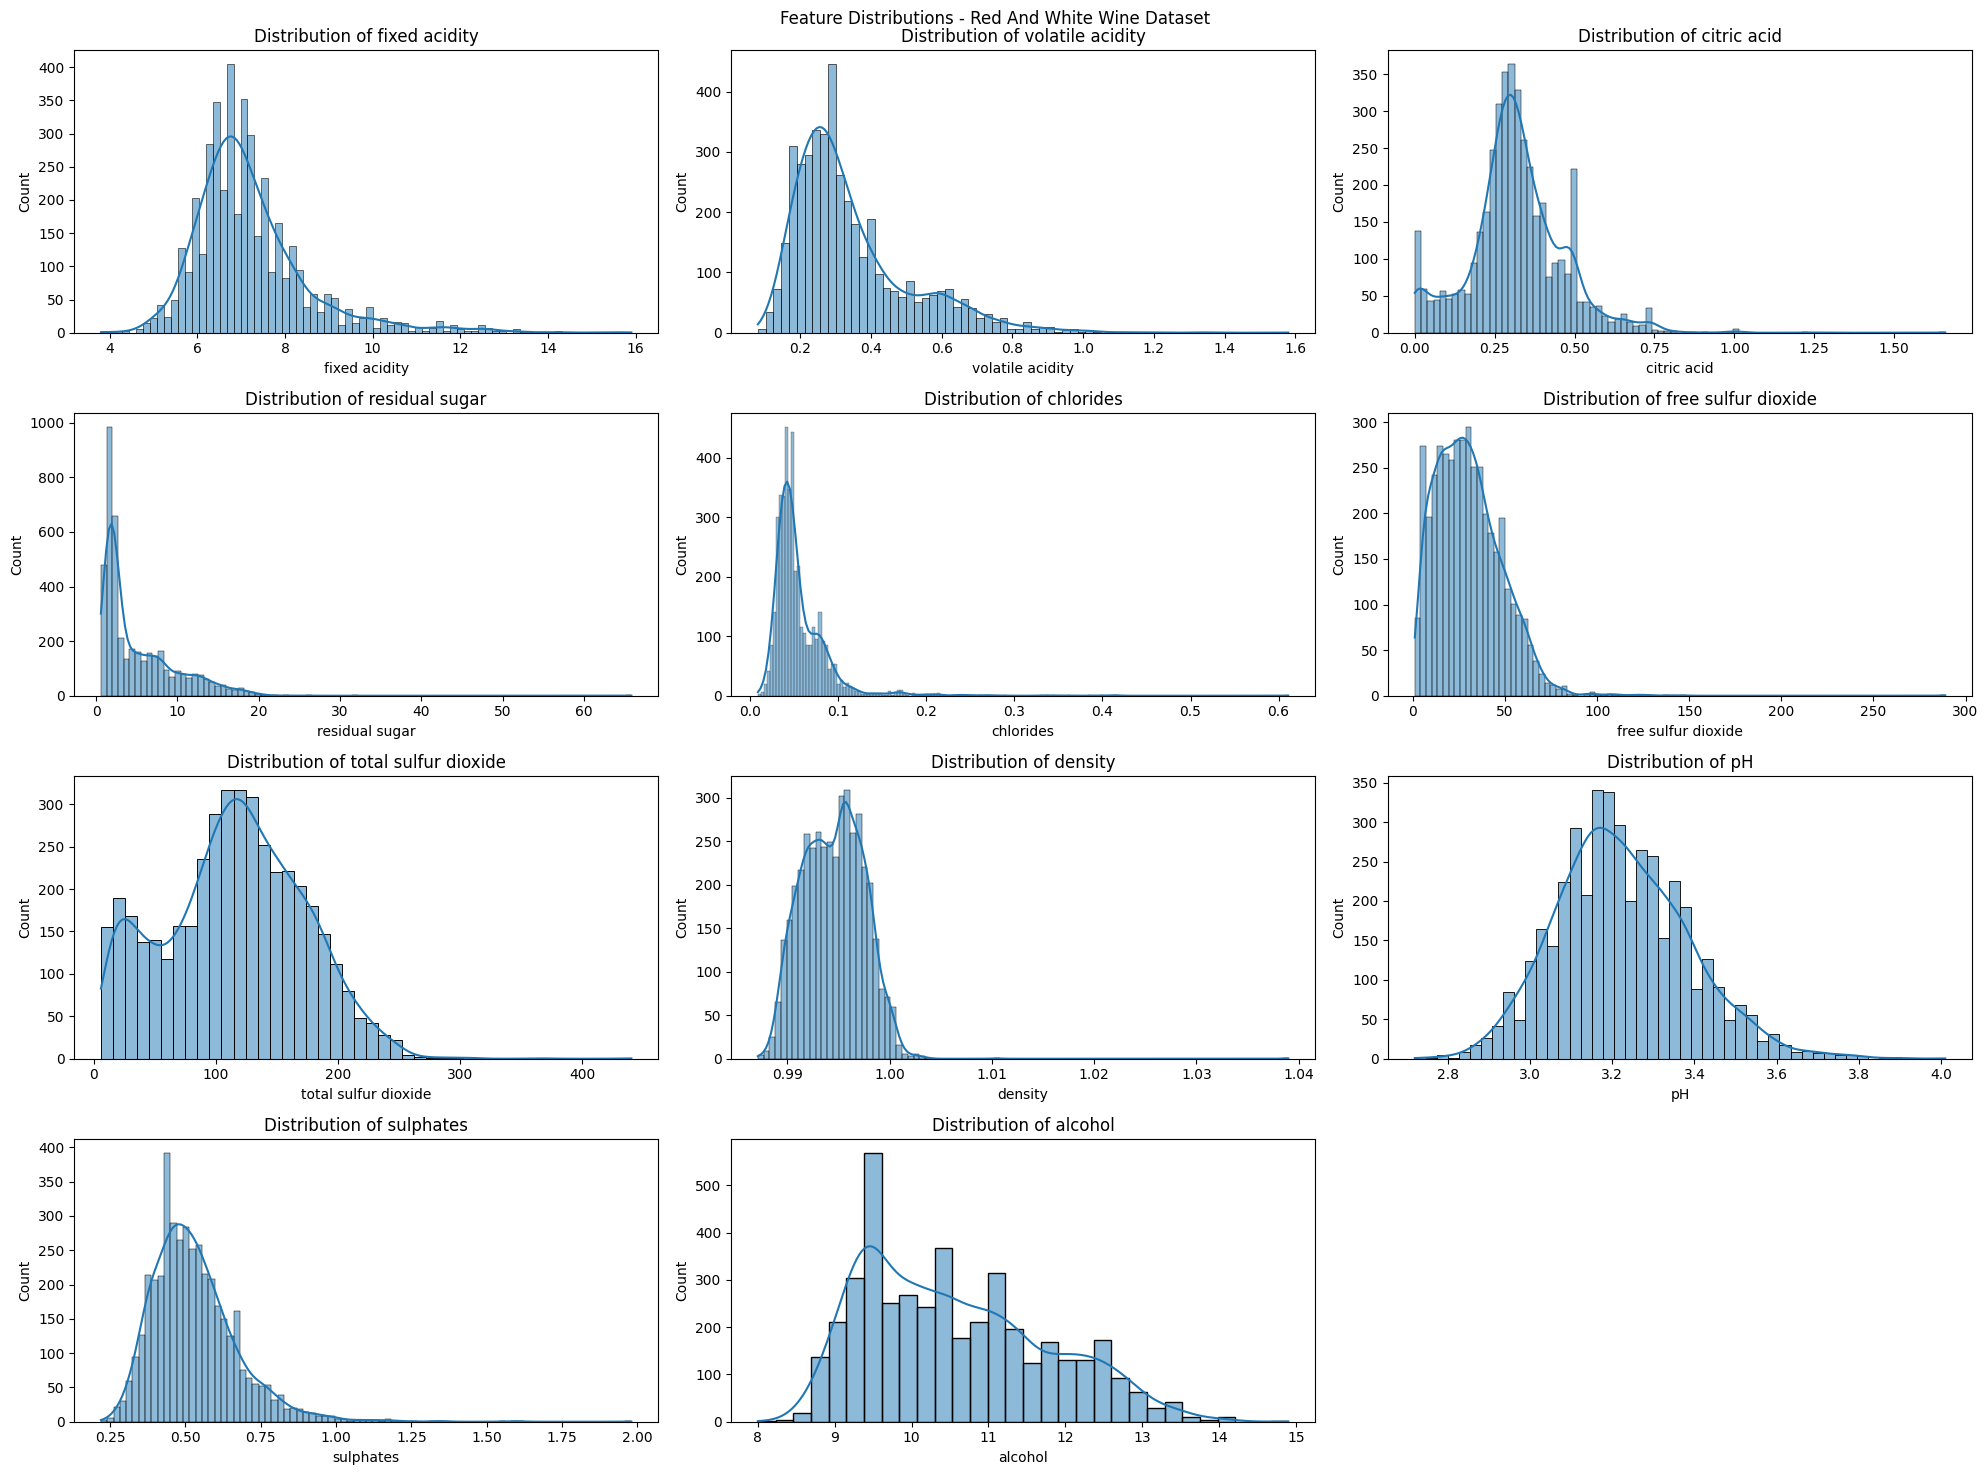

In [80]:
features_for_plot_distribution = [
    col for col in X_train_wine.select_dtypes(include="number").columns.tolist()
    if col != "wine_type"
]

plot_feature_distributions(
    data=X_train_wine,
    features=features_for_plot_distribution,
    title="Feature Distributions - Red And White Wine Dataset"
)

This set of plots displays the distributions of each feature in the combined Red and White Wine Quality dataset.  Each subplot shows a histogram (bars representing the frequency of different values) and a kernel density estimate (KDE, the smooth curve) for a single feature. This visualization helps us understand the characteristics of each feature, including:

*   **Central Tendency:** Where the data is concentrated (e.g., the mean or median).
*   **Spread/Variability:** How dispersed the data is (e.g., the range, standard deviation).
*   **Skewness:** Whether the distribution is symmetrical or skewed to one side.
*   **Multimodality:** Whether the distribution has multiple peaks.

**Key Observations and Interpretations:**

*   **fixed acidity:**  Somewhat normally distributed, with a peak around 7-8.  Slightly right-skewed.
*   **volatile acidity:**  Right-skewed, with most values concentrated at lower levels.  A long tail indicates some wines with much higher volatile acidity.
*   **citric acid:**  Appears somewhat bimodal (two peaks), with a significant peak near 0 and another around 0.25-0.5.
*   **residual sugar:**  *Highly* right-skewed.  Most wines have low residual sugar, but there's a very long tail of wines with much higher sugar content.  This likely includes some very sweet wines.
*   **chlorides:**  Also right-skewed, with most values concentrated at lower levels.
*   **free sulfur dioxide:**  Right-skewed.
*   **total sulfur dioxide:**  Exhibits a more complex distribution, with multiple peaks and a wider spread than free sulfur dioxide. This is expected as it includes both free and bound forms.
*   **density:**  Very close to a normal distribution, centered around 1.0.  This is expected as wine density is close to that of water.
*   **pH:**  Approximately normally distributed, centered around a pH of 3.2-3.4, which is typical for wine (slightly acidic).
*   **sulphates:**  Somewhat right-skewed, with most values between 0.5 and 1.0.
*   **alcohol:**  Right-skewed, with a peak around 9-11% alcohol.

#### Correlation Heatmap - Red And White Wine Dataset

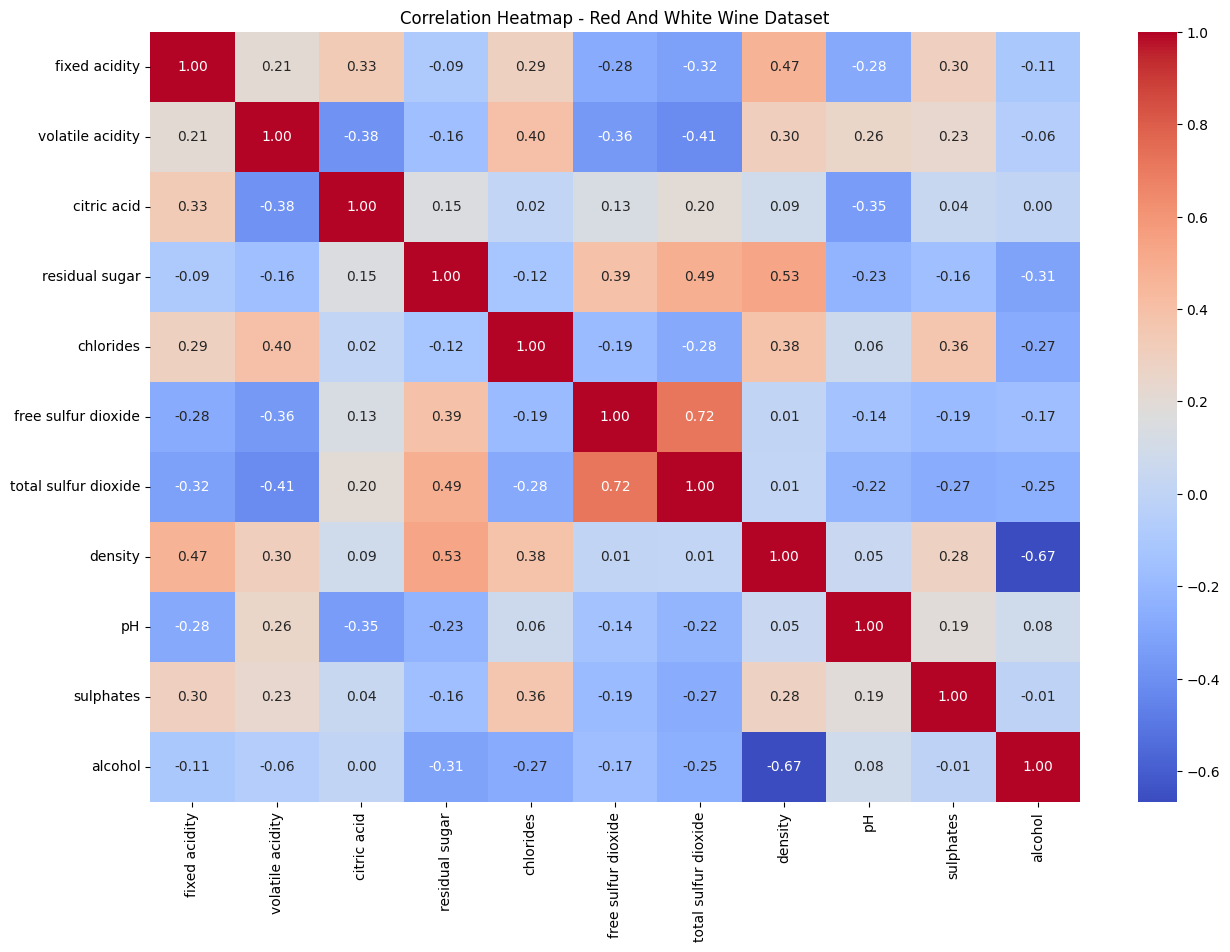

In [81]:
plot_correlation_heatmap(
    data=X_train_wine,
    title="Correlation Heatmap - Red And White Wine Dataset"
)

This heatmap displays the Pearson correlation coefficients between all pairs of *numerical* features in the combined Red and White Wine Quality dataset.  The color of each cell indicates the direction and strength of the *linear* relationship:

*   **Red:** Positive correlation (as one feature increases, the other tends to increase).  Darker red indicates a stronger positive correlation.
*   **Blue:** Negative correlation (as one feature increases, the other tends to decrease). Darker blue indicates a stronger negative correlation.
*   **White/Light Colors:**  Weak or no linear correlation.

The numbers within each cell are the correlation coefficients, ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 indicating no linear correlation.

**Key Observations and Interpretations:**

*   **Strong Positive Correlations:**
    *   `free sulfur dioxide` and `total sulfur dioxide`:  A correlation of 0.72 is quite strong. This makes sense, as free sulfur dioxide is a component of total sulfur dioxide.
    *   `fixed acidity` and `citric acid`: A moderate positive correlation (0.33).
    *  `fixed acidity` and `density`: A moderate positive correlation (0.47), this suggests, the more acids within the more density will be.
    * `residual sugar` and `density` are correlated (0.53).

*   **Strong Negative Correlations:**
    *   `alcohol` and `density`: A strong negative correlation (-0.67).  This is expected, as alcohol is less dense than water.  Higher alcohol content generally leads to lower density in wine.
    *  `pH` and `fixed acidity`: A moderate negative correlation (-0.28), This is an expected behavior between acids.
    * `citric acid` and `volatile acidity` (with value of -0.38).
    * `free sulfur dioxide` and `volatile acidity` (with value of -0.36), and also with `total sulfur dioxide` and `volatile acidity` (with -0.41).

*   **Weak Correlations:** Many of the feature pairs show weak correlations (close to 0), indicating little or no *linear* relationship.  This doesn't mean there's *no* relationship, just that it's not a strong linear one.

#### PCA Plot - Red And White Wine Dataset

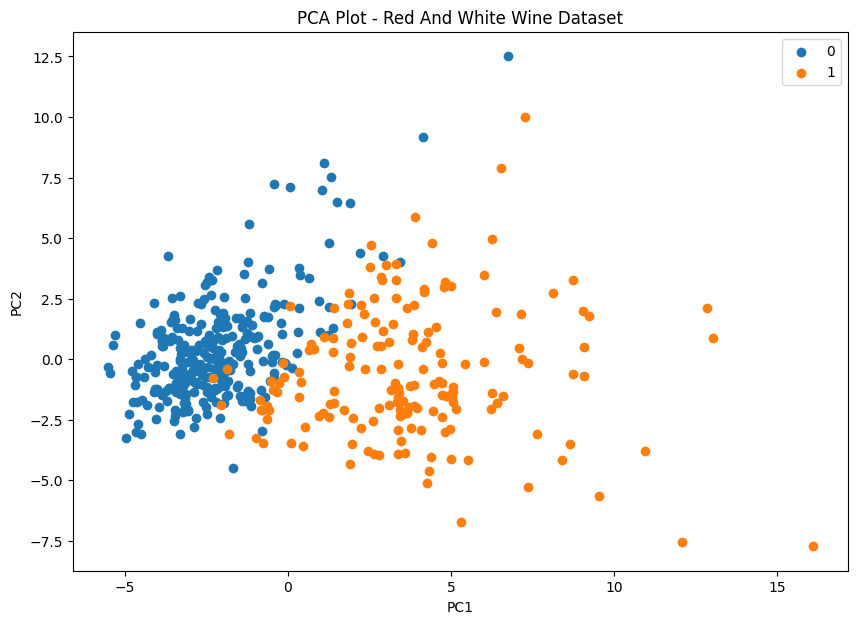

In [82]:
plot_pca(
    data=pd.concat(
        [X_train_wdbc, pd.Series(y_train_wdbc, name=datasets_config["red_wine_dataset"]["target_column"])], axis=1
    ),
    target=datasets_config["red_wine_dataset"]["target_column"],
    title="PCA Plot - Red And White Wine Dataset"
)

This plot shows the results of Principal Component Analysis (PCA) applied to the *combined* Red and White Wine Quality dataset (after the target variable, 'quality' has been converted to 'quality_class').  PCA is a dimensionality reduction technique that transforms the original features into a new set of uncorrelated variables called *principal components*.  These components are ordered by the amount of variance they explain in the data.  This plot visualizes the first two principal components (PC1 and PC2).

Each point on the scatter plot represents a single wine sample. The points are color-coded:

*   **Blue (0):** Represents "bad" quality wine (original quality score < 6).
*   **Orange (1):** Represents "good" quality wine (original quality score >= 6).

By plotting the data in this reduced, two-dimensional space, we can get a sense of whether the "good" and "bad" quality wines are easily separable based on the underlying physicochemical properties.

**Key Observations and Interpretations:**

*   **Significant Overlap:**  The most striking observation is the *substantial overlap* between the blue ("bad") and orange ("good") points.  There is no clear, distinct boundary separating the two quality classes in this 2D PCA space.
*   **Some Clustering:**  While there's overlap, we can observe some tendencies:
    *   The "bad" quality wines (blue) tend to cluster more towards the left side of the plot (lower values of PC1). There are some bad wines spreading to higher values, which could consider as outliers.
    *   The "good" quality wines (orange) show a wider spread, particularly along the PC1 axis, extending further to the right. The "tails" suggests the range.
*   **No Clean Separation:**  The lack of a clear separation indicates that the first two principal components alone *do not* capture enough information to perfectly distinguish between "good" and "bad" wines.

#### Feature Scaling

In [83]:
# Identify numerical columns (excluding 'wine_type', which we'll label encode later)
numerical_cols_wine = [col for col in X_train_wine.columns.tolist() if col != "wine_type"]

scaler_wine = StandardScaler()

# Fit and transform on the training data
X_train_wine[numerical_cols_wine] = scaler_wine.fit_transform(X_train_wine[numerical_cols_wine])

# Transform the testing data using the same scaler
X_test_wine[numerical_cols_wine] = scaler_wine.transform(X_test_wine[numerical_cols_wine])


#### Label Encoding

In [84]:
# Label encode the 'wine_type' column
label_encoder_wine = LabelEncoder()
X_train_wine["wine_type"] = label_encoder_wine.fit_transform(X_train_wine["wine_type"])
X_test_wine["wine_type"] = label_encoder_wine.transform(X_test_wine["wine_type"])

In [85]:
# Display the preprocessed data
display("X_train_wine after preprocessing:")
display(X_train_wine.head())
display(X_train_wine.info())


'X_train_wine after preprocessing:'

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
3103      -0.152857         -1.037623     2.860988        1.708471  -0.324359   
589        2.270226         -0.319836     1.167512       -0.544818   0.094029   
67        -0.455743          2.162510    -1.677528       -0.765729   0.602072   
3724      -0.910071         -0.379652    -0.661443        1.564879  -0.234704   
5113       0.377192          0.218504    -0.593704        1.266650  -0.772632   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
3103            -0.344816              0.197466 -0.104772  0.218070   
589             -1.395783             -1.789437  1.030575 -1.078428   
67              -1.340468             -1.754271  0.563079  1.329355   
3724             0.650837              0.848045  0.396117 -0.152358   
5113            -0.123560             -0.347613 -0.959622 -1.819285   

      sulphates   alcohol  wine_type  
3103  -1.043809  1.383740          1  
589    1.454562 -0.044544          0  
67     0.344175  0.123490          0  
3724  -0.488615 -0.380610          1  
5113  -0.835611  2.559973          1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4256 entries, 3103 to 1011
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4256 non-null   float64
 1   volatile acidity      4256 non-null   float64
 2   citric acid           4256 non-null   float64
 3   residual sugar        4256 non-null   float64
 4   chlorides             4256 non-null   float64
 5   free sulfur dioxide   4256 non-null   float64
 6   total sulfur dioxide  4256 non-null   float64
 7   density               4256 non-null   float64
 8   pH                    4256 non-null   float64
 9   sulphates             4256 non-null   float64
 10  alcohol               4256 non-null   float64
 11  wine_type             4256 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 432.2 KB


None

In [86]:
display("y_train_wine after preprocessing:")
display(y_train_wine.head())

'y_train_wine after preprocessing:'

3103    1
589     1
67      0
3724    0
5113    1
Name: quality_class, dtype: int64

In [87]:
display("X_test_wine after preprocessing:")
display(X_test_wine.head())
display(X_test_wine.info())

'X_test_wine after preprocessing:'

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
2221      -1.440120         -0.140390    -1.338833        0.338825  -0.384129   
6167      -0.607185         -0.260021    -0.322747       -0.147179  -0.025510   
4500      -0.531464         -0.738545     0.015948       -0.633182  -0.832401   
5051       0.604356         -0.618914     1.099773        0.383007  -0.264589   
639        1.285848         -0.319836     0.219165       -0.699455   0.333108   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
2221            -0.455444              0.461214 -0.271735  0.835451   
6167            -0.732014              0.355715 -0.672446  0.032856   
4500             0.318952             -0.400363 -1.253476  0.279809   
5051            -0.953270              0.338132  0.549722  0.032856   
639             -0.289502             -1.015776  0.830220 -0.275834   

      sulphates   alcohol  wine_type  
2221   0.482973 -0.128560          1  
6167  -0.627414  1.383740          1  
4500   0.413574  1.131690          1  
5051   1.176965 -0.464627          1  
639    5.757310 -0.212577          0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1064 entries, 2221 to 5578
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1064 non-null   float64
 1   volatile acidity      1064 non-null   float64
 2   citric acid           1064 non-null   float64
 3   residual sugar        1064 non-null   float64
 4   chlorides             1064 non-null   float64
 5   free sulfur dioxide   1064 non-null   float64
 6   total sulfur dioxide  1064 non-null   float64
 7   density               1064 non-null   float64
 8   pH                    1064 non-null   float64
 9   sulphates             1064 non-null   float64
 10  alcohol               1064 non-null   float64
 11  wine_type             1064 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 108.1 KB


None

In [88]:
display("y_test_wine after preprocessing:")
display(y_test_wine.head())

'y_test_wine after preprocessing:'

2221    1
6167    1
4500    1
5051    0
639     1
Name: quality_class, dtype: int64

In [89]:
## check distribution of target variable
display(y_train_wine.value_counts())

1    2658
0    1598
Name: quality_class, dtype: int64

In [90]:
display(X_train_wine.dtypes)
display(X_test_wine.dtypes)

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
wine_type                 int64
dtype: object

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
wine_type                 int64
dtype: object

#### Train And Evaluate

**Baseline Model Training and Evaluation:**

In [91]:
basic_model_results_wine = train_evaluate_baseline(basic_classification_models, X_train_wine, y_train_wine, X_test_wine, y_test_wine)
display(basic_model_results_wine)

basic_model_results_wine = pd.DataFrame(basic_model_results_wine).T
display(basic_model_results_wine)

Training DecisionTree with default hyperparameters...
DecisionTree - Test Accuracy: 0.6983, F1 Score: 0.7599, AUC-ROC: 0.6781


{'DecisionTree': {'model': DecisionTreeClassifier(random_state=42),
  'accuracy': 0.6983082706766918,
  'f1_score': 0.7599102468212415,
  'roc_auc': 0.6781366506885795}}

accuracy f1_score                                    model  \
DecisionTree  0.698308  0.75991  DecisionTreeClassifier(random_state=42)   

               roc_auc  
DecisionTree  0.678137

The output above shows the performance of a Decision Tree classifier trained on the Wine Quality dataset *using its default hyperparameters*. This serves as our baseline model.

**Key Results:**

| Metric     | Value  |
| :---------- | :----- |
| Accuracy   | 0.6983 |
| F1 Score   | 0.7599 |
| AUC-ROC    | 0.6781 |

**Interpretation:**

*   **Accuracy (0.6983):** The model correctly classifies approximately 69.8% of the wine samples in the test set as either "good" or "bad" quality.  This is better than random guessing (which would be around 50% if the classes were perfectly balanced), but there's considerable room for improvement.
*   **F1 Score (0.7599):** The F1-score, which balances precision and recall, is higher than the accuracy.  This suggests the model is performing better on the positive class ("good" quality wine) than on the negative class, likely due to some class imbalance (more "good" than "bad" wines, as we saw in the initial data exploration).
*   **AUC-ROC (0.6781):** The Area Under the Receiver Operating Characteristic Curve (AUC-ROC) measures the model's ability to *distinguish* between the two classes across different classification thresholds. A value of 0.6781 indicates that the model's discriminatory power is moderate, but significantly better than random guessing (which would have an AUC-ROC of 0.5).

**Overall Assessment and Next Steps:**

The baseline Decision Tree model, with its default settings, achieves a reasonable but not outstanding level of performance. The accuracy and F1-score are decent, but the AUC-ROC suggests there's substantial room for improvement in the model's ability to separate the "good" and "bad" quality wines.

This baseline performance serves as a benchmark.  The next steps involve:

1.  **Training and Tuning Advanced Models:** We will train and tune a variety of more sophisticated models (Logistic Regression, Random Forest, SVM, XGBoost, LightGBM), using `RandomizedSearchCV` to optimize their hyperparameters.  The goal is to achieve significantly better performance metrics than this baseline.
2.  **Generating Counterfactual Explanations:**  For *all* models (including this baseline Decision Tree), we will generate counterfactual explanations. This will help us understand *how* each model makes its predictions, and which features are most important.
3.  **Evaluating Counterfactuals:** We'll use metrics like validity, sparsity, and proximity (L1/L2 distance) to evaluate the *quality* of the counterfactual explanations, adding another dimension to our model comparison.

By combining improved performance (through tuning) with insights from counterfactual explanations, we can select a model that is not only accurate but also interpretable, robust, and fair.

**Advanced Model Training, Tuning and Evaluation:**

In [92]:
advanced_model_results_wine = train_tune_evaluate_advanced(advanced_classification_models, advanced_classification_param_grids, X_train_wine, y_train_wine, X_test_wine, y_test_wine)
advanced_results_df_wine = pd.DataFrame(advanced_model_results_wine).T
display(advanced_results_df_wine)

Training and tuning LogisticRegression...
LogisticRegression - Test Accuracy: 0.7434, F1 Score: 0.8040, AUC-ROC: 0.7995
Training and tuning DecisionTree...
DecisionTree - Test Accuracy: 0.7321, F1 Score: 0.7930, AUC-ROC: 0.7880
Training and tuning RandomForest...
RandomForest - Test Accuracy: 0.7726, F1 Score: 0.8239, AUC-ROC: 0.8369
Training and tuning SVM...
SVM - Test Accuracy: 0.7575, F1 Score: 0.8122, AUC-ROC: 0.8292
Training and tuning XGBoost...
XGBoost - Test Accuracy: 0.7641, F1 Score: 0.8164, AUC-ROC: 0.8270
Training and tuning LightGBM...
LightGBM - Test Accuracy: 0.7744, F1 Score: 0.8240, AUC-ROC: 0.8306


best_model  \
LogisticRegression  LogisticRegression(C=10, max_iter=2000, penalt...   
DecisionTree        DecisionTreeClassifier(criterion='entropy', ma...   
RandomForest        (DecisionTreeClassifier(max_depth=15, max_feat...   
SVM                 SVC(C=1, gamma=0.1, probability=True, random_s...   
XGBoost             XGBClassifier(base_score=None, booster=None, c...   
LightGBM            LGBMClassifier(colsample_bytree=0.6, learning_...   

                                                          best_params  \
LogisticRegression  {'solver': 'saga', 'penalty': 'l1', 'max_iter'...   
DecisionTree        {'min_samples_split': 2, 'min_samples_leaf': 4...   
RandomForest        {'n_estimators': 500, 'min_samples_split': 5, ...   
SVM                           {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}   
XGBoost             {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha...   
LightGBM            {'subsample': 1.0, 'num_leaves': 40, 'n_estima...   

                    accuracy  f1_score   roc_auc  
LogisticRegression  0.743421   0.80402  0.799452  
DecisionTree        0.732143  0.793028  0.787976  
RandomForest        0.772556  0.823872  0.836902  
SVM                 0.757519  0.812227   0.82924  
XGBoost             0.764098  0.816386  0.827037  
LightGBM            0.774436  0.824047  0.830575

### Advanced Model Training and Tuning Results - Wine Quality

The table below summarizes the performance of six different classification models trained and tuned on the combined Wine Quality dataset.  Each model was optimized using `RandomizedSearchCV` to find the best combination of hyperparameters.  The table reports the best model instance, the best hyperparameters found, and the performance metrics (accuracy, F1-score, and AUC-ROC) on the held-out test set.

**Model Performance Summary:**

| Model               | Accuracy | F1 Score | AUC-ROC |
| :-------------------- | :------- | :------- | :------ |
| **Baseline DT**     | 0.6983   | 0.7599   | 0.6781  |
| LogisticRegression  | 0.7434   | 0.8040   | 0.7995  |
| DecisionTree (Tuned) | 0.7321   | 0.7930   | 0.7880  |
| RandomForest        | 0.7726   | 0.8239   | 0.8369  |
| SVM                 | 0.7575   | 0.8122   | 0.8292  |
| XGBoost             | 0.7641   | 0.8164   | 0.8270  |
| LightGBM            | 0.7744   | 0.8240   | 0.8306  |

**Observations and Interpretations:**

*   **Improved Performance:** All tuned models outperform the baseline Decision Tree (Accuracy: 0.6983, F1-Score: 0.7599, AUC-ROC: 0.6781), demonstrating the effectiveness of hyperparameter optimization.
*   **RandomForest** achieves the *highest* AUC-ROC score (0.8369), indicating the best overall ability to discriminate between "good" and "bad" quality wines.
*   **LightGBM** has similar performance, and is slightly better than **XGBoost**.
* **LogisticRegression and SVM** perform well and it indicates that their performance is simillar to the others.
*   **Tuned Decision Tree:** Even with tuning, the Decision Tree remains the lowest-performing model, suggesting it might be too simple to capture the complexities of this dataset.

#### Counterfactual constraints

In [93]:
wine_dataset_constraints = {
    # Original categorical features to keep immutable (will auto-detect one-hot columns)
    "immutable_features": ['wine_type']
}

#### Counterfactual Calculations

In [94]:
# Prepare the DiCE Data object for the WDBC dataset using the scaled training data.
train_data_for_dice_wine = X_train_wine.copy()
# Add the encoded target variable (quality: 0 or 1) to the dataframe.
train_data_for_dice_wine[datasets_config["red_wine_dataset"]["target_column"]] = y_train_credit

d_wine = dice_ml.Data(
    dataframe=train_data_for_dice_wine,
    continuous_features=X_train_wine.columns.tolist(),
    outcome_name=datasets_config["red_wine_dataset"]["target_column"]
)

all_cf_examples_wine = generate_counterfactuals_for_models(
    model_results=advanced_model_results_wine,
    X_test=X_test_wine,
    y_test=y_test_wine,
    dice_data=d_wine,  # The DiCE Data object for the WDBC dataset
    num_samples_to_explain=num_samples_to_explain,
    total_CFs=2,
    max_display=2
)


Counterfactual Generation for Model: LogisticRegression
Total misclassified instances for LogisticRegression: 273


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]



----------------------------------------
Processing Instance Index: 689
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  alcohol: -0.6326604976440076 -> 2.69638799

Counterfactual 2:
  sulphates: 0.41357405869481967 -> 3.84259219
  alcohol: -0.6326604976440076 -> 0.71129445


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]



----------------------------------------
Processing Instance Index: 971
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  alcohol: 0.5435730704540874 -> -0.75323645
  volatile acidity: 0.697028580387219 -> 3.57807031

Counterfactual 2:
  citric acid: -2.151701854764199 -> 0.77869965
  total sulfur dioxide: -1.2443575210729036 -> 3.845448589


100%|██████████| 1/1 [00:00<00:00, 11.43it/s]



Finished processing LogisticRegression.


Counterfactual Generation for Model: DecisionTree
Total misclassified instances for DecisionTree: 285


100%|██████████| 1/1 [00:00<00:00, 13.79it/s]



----------------------------------------
Processing Instance Index: 434
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  pH: -0.09061972547162313 -> -1.25852508
  volatile acidity: -0.8581764723666493 -> 2.03686076

Counterfactual 2:
  sulphates: -1.1132077204209523 -> 2.83755963
  volatile acidity: -0.8581764723666493 -> 0.36722918


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



----------------------------------------
Processing Instance Index: 744
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  free sulfur dioxide: -0.7873281737794116 -> -1.2026204
  total sulfur dioxide: -0.0486988161497992 -> 2.150765356

Counterfactual 2:
  alcohol: 0.5435730704540874 -> -1.21489047


100%|██████████| 1/1 [00:00<00:00, 16.31it/s]



Finished processing DecisionTree.


Counterfactual Generation for Model: RandomForest
Total misclassified instances for RandomForest: 242


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]



----------------------------------------
Processing Instance Index: 462
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  density: 1.6316415335647112 -> -2.1774093

Counterfactual 2:
  alcohol: -0.29659376390169556 -> 0.06587012


100%|██████████| 1/1 [00:00<00:00,  6.62it/s]



----------------------------------------
Processing Instance Index: 688
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  chlorides: -0.2944740095810542 -> 2.3546899
  residual sugar: 1.3550139590081443 -> 2.47518209

Counterfactual 2:
  density: 0.09224421880372578 -> 1.0377275
  volatile acidity: -0.7385453144625056 -> 4.2294803


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]



Finished processing RandomForest.


Counterfactual Generation for Model: SVM
Total misclassified instances for SVM: 258


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]



----------------------------------------
Processing Instance Index: 312
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  sulphates: -0.4886151744190454 -> 2.334248
  total sulfur dioxide: 0.549130536311753 -> 2.457444473

Counterfactual 2:
  alcohol: -0.8847105479507431 -> 1.50894755


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



----------------------------------------
Processing Instance Index: 911
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  chlorides: -0.6530923327163188 -> 5.48224963

Counterfactual 2:
  sulphates: -0.002820971973117793 -> 9.7925901


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Finished processing SVM.


Counterfactual Generation for Model: XGBoost
Total misclassified instances for XGBoost: 251


100%|██████████| 1/1 [00:00<00:00, 13.99it/s]



----------------------------------------
Processing Instance Index: 328
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  total sulfur dioxide: -1.7366875760412406 -> 2.532141462

Counterfactual 2:
  pH: -0.8314762356824156 -> 1.47119719
  total sulfur dioxide: -1.7366875760412406 -> 1.121012823


100%|██████████| 1/1 [00:00<00:00, 13.95it/s]



----------------------------------------
Processing Instance Index: 284
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  density: 1.3978935681997284 -> 2.4362178

Counterfactual 2:
  free sulfur dioxide: -0.8979562365604141 -> -0.4198524


100%|██████████| 1/1 [00:00<00:00, 13.61it/s]



Finished processing XGBoost.


Counterfactual Generation for Model: LightGBM
Total misclassified instances for LightGBM: 240


100%|██████████| 1/1 [00:00<00:00, 14.16it/s]



----------------------------------------
Processing Instance Index: 161
Original Prediction: 1 | Desired Class: 0
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  volatile acidity: -0.26002068284593083 -> 3.30075345

Counterfactual 2:
  citric acid: 1.1675119302786674 -> -0.56352907


100%|██████████| 1/1 [00:00<00:00, 14.56it/s]



----------------------------------------
Processing Instance Index: 32
Original Prediction: 0 | Desired Class: 1
Counterfactuals generated: 2 (Requested: 2)

Counterfactual 1:
  alcohol: -0.8847105479507431 -> 2.4334913
  free sulfur dioxide: -1.3404684876844242 -> 1.0672157

Counterfactual 2:
  alcohol: -0.8847105479507431 -> 1.45495835
  free sulfur dioxide: -1.3404684876844242 -> 0.3256022


100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


Finished processing LightGBM.




=== LogisticRegression (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 689
Original Prediction: 0, Desired Class: 1



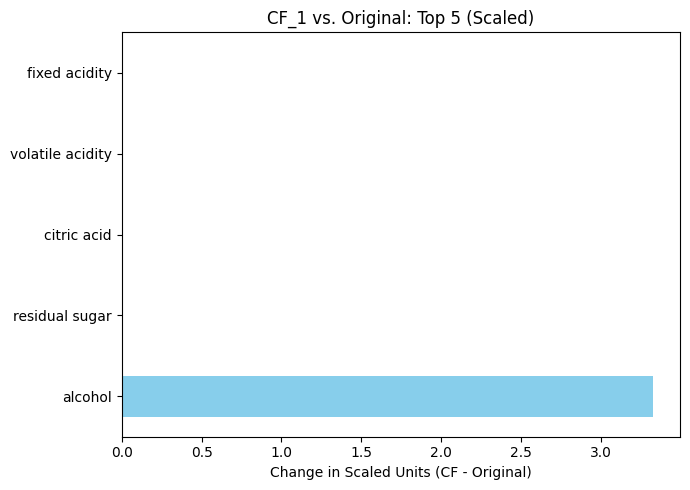
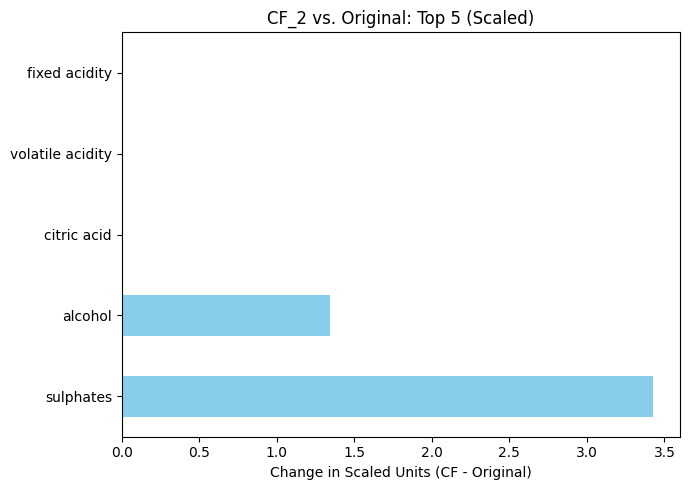


Misclassified Instance Index: 971
Original Prediction: 1, Desired Class: 0



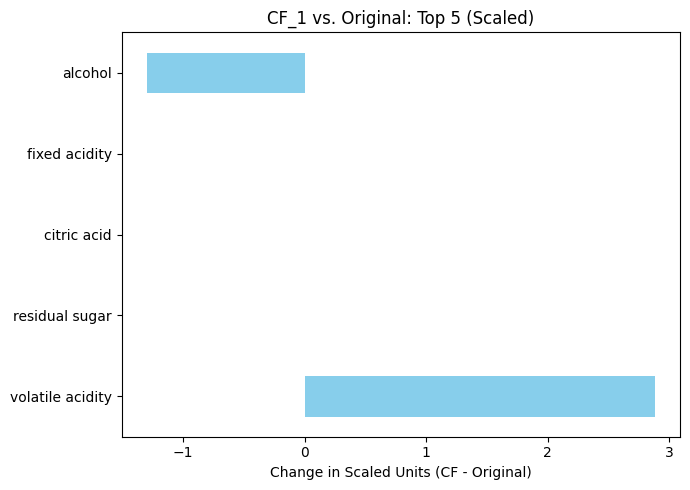
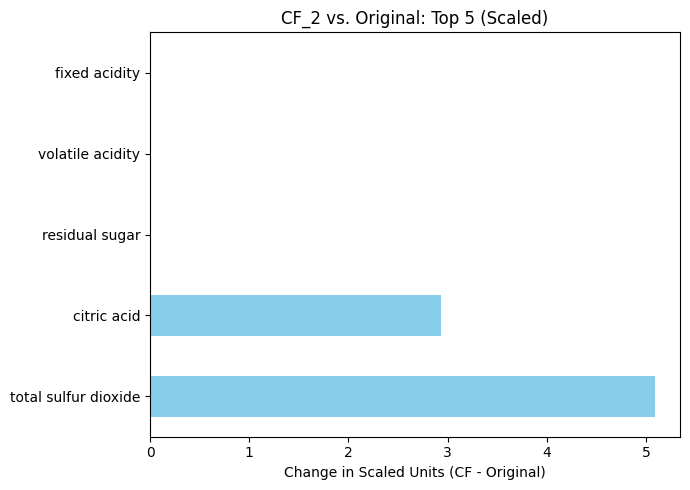


=== DecisionTree (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 434
Original Prediction: 1, Desired Class: 0



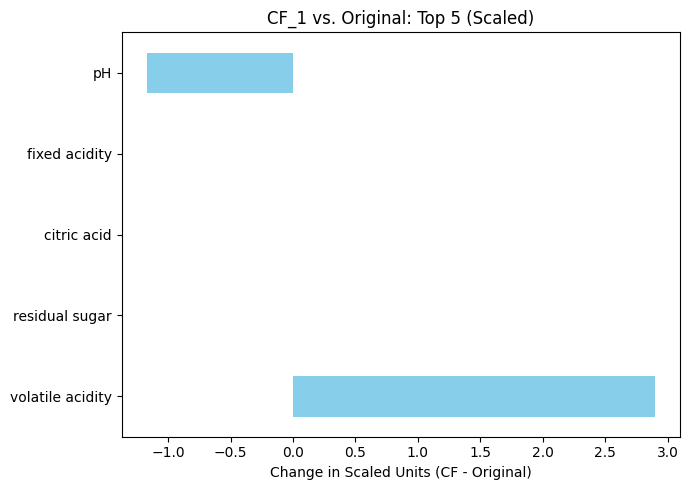
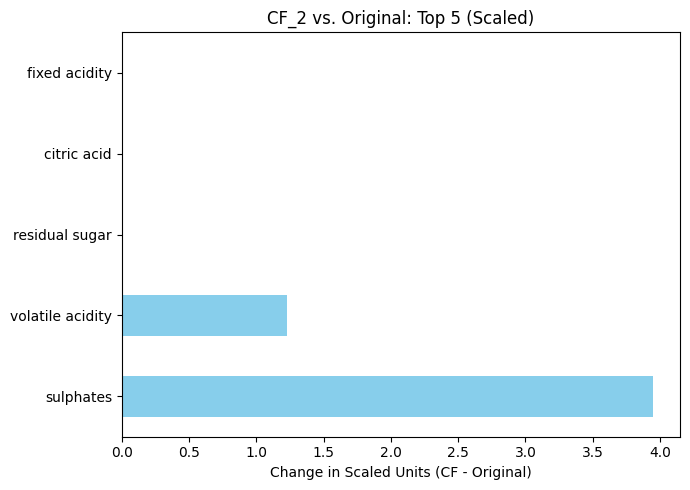


Misclassified Instance Index: 744
Original Prediction: 1, Desired Class: 0



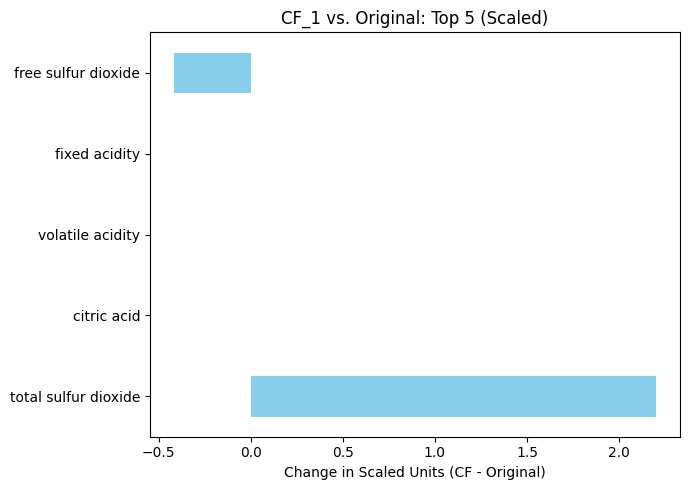
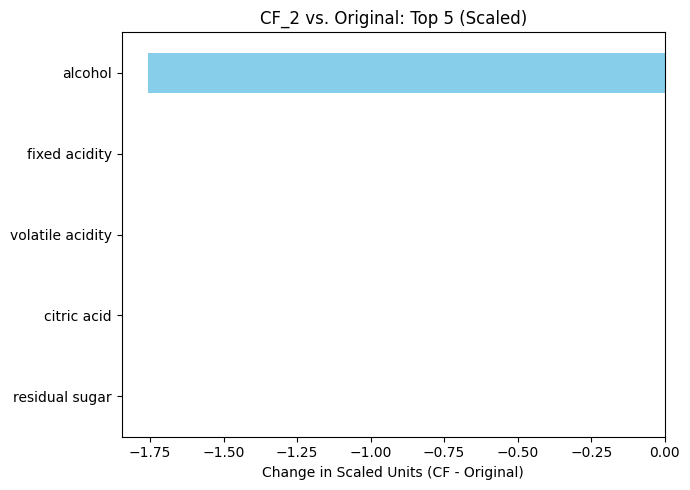


=== RandomForest (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 462
Original Prediction: 0, Desired Class: 1



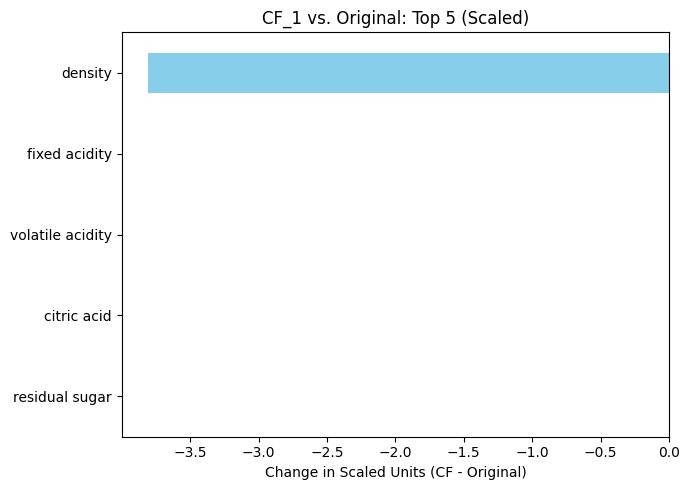
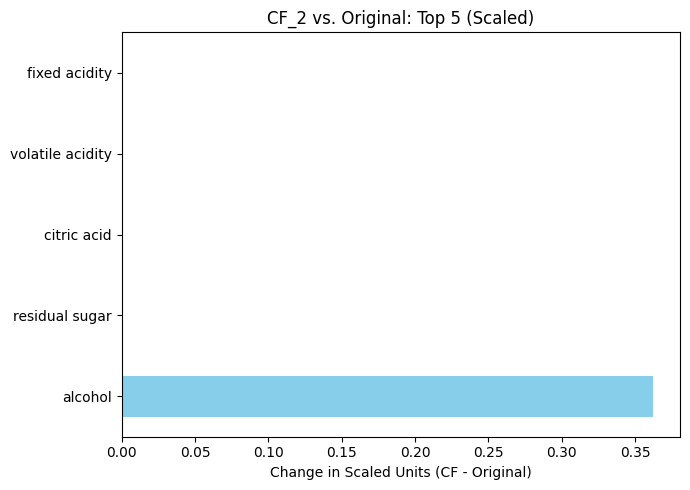


Misclassified Instance Index: 688
Original Prediction: 1, Desired Class: 0



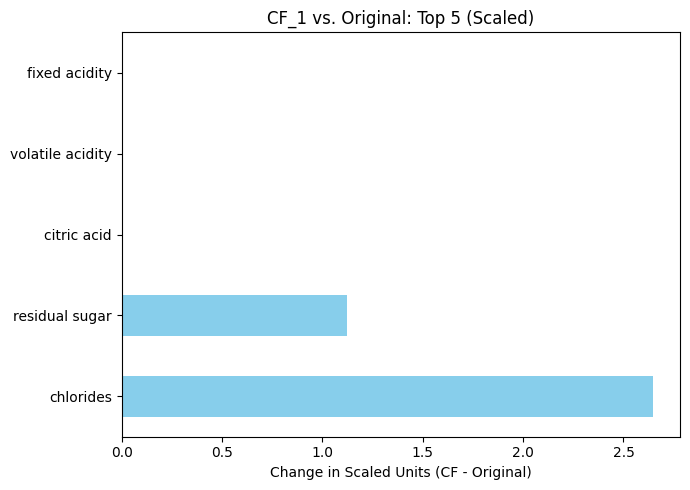
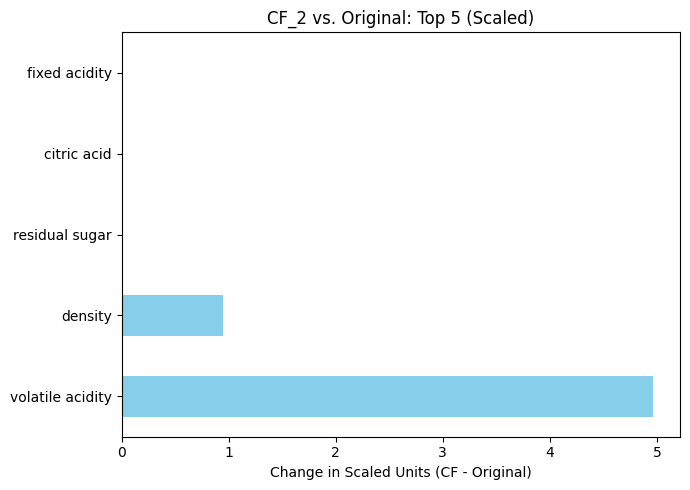


=== SVM (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 312
Original Prediction: 0, Desired Class: 1



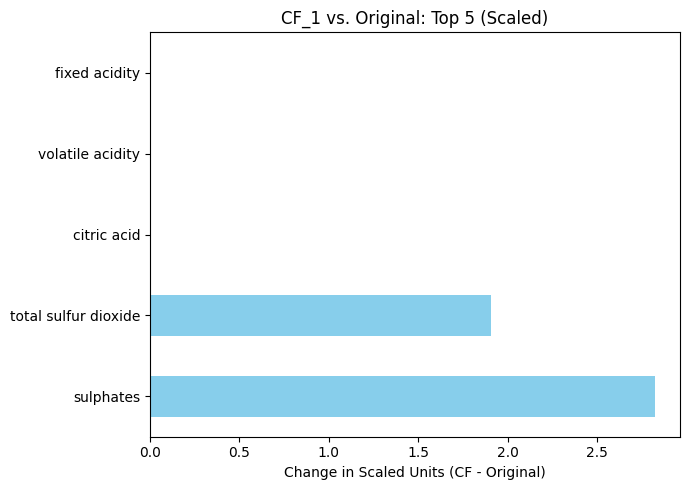
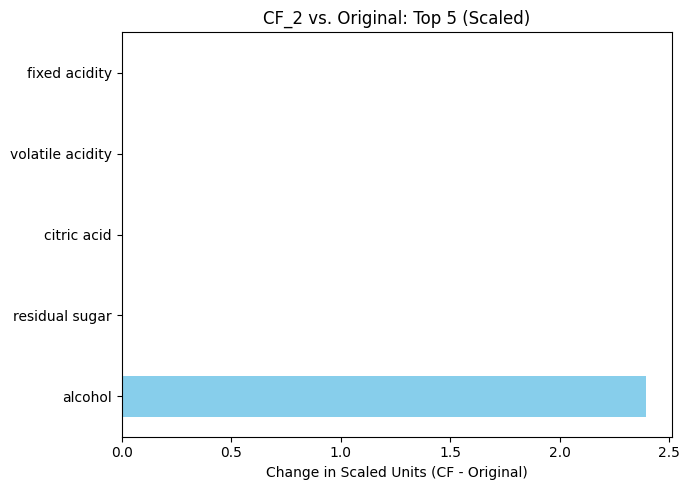


Misclassified Instance Index: 911
Original Prediction: 1, Desired Class: 0



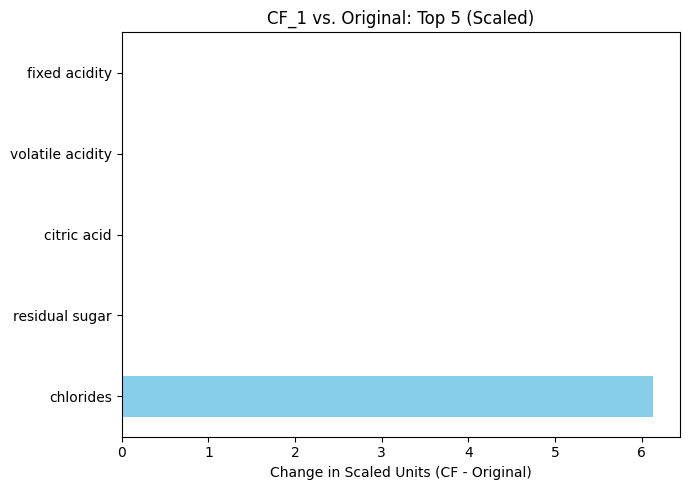
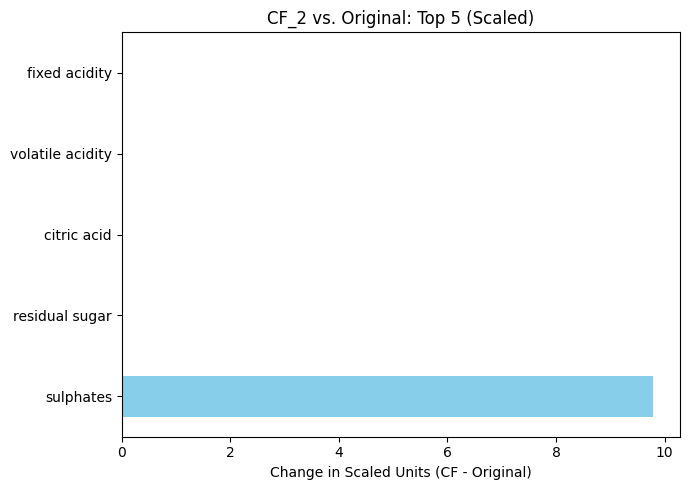


=== XGBoost (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 328
Original Prediction: 1, Desired Class: 0



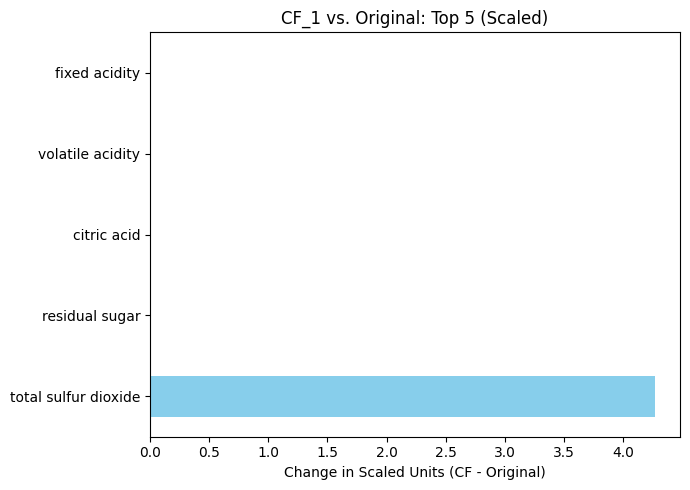
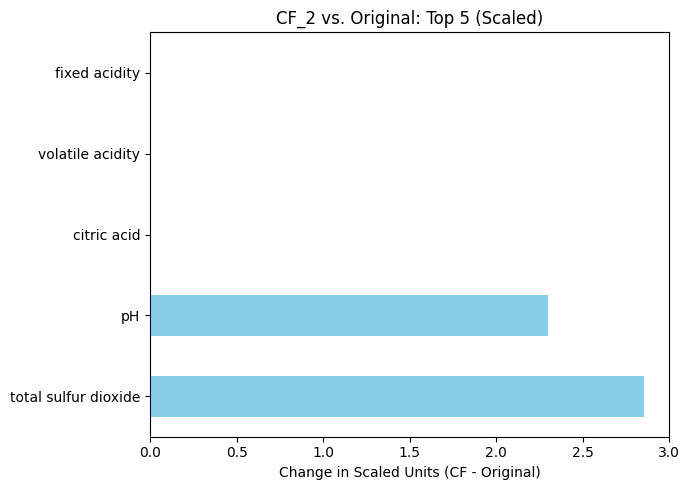


Misclassified Instance Index: 284
Original Prediction: 0, Desired Class: 1



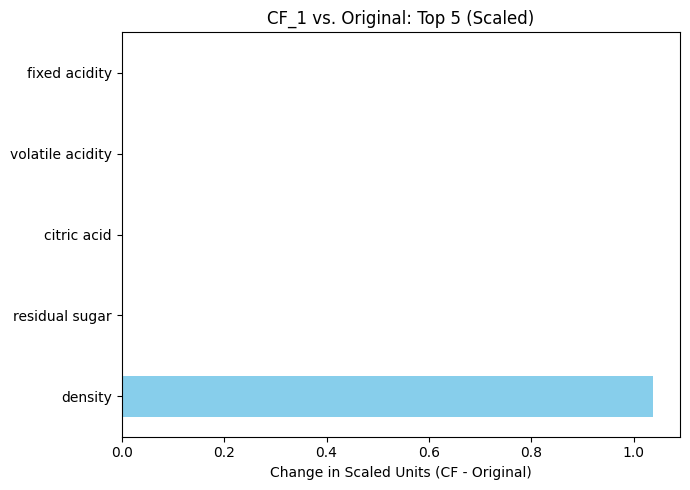
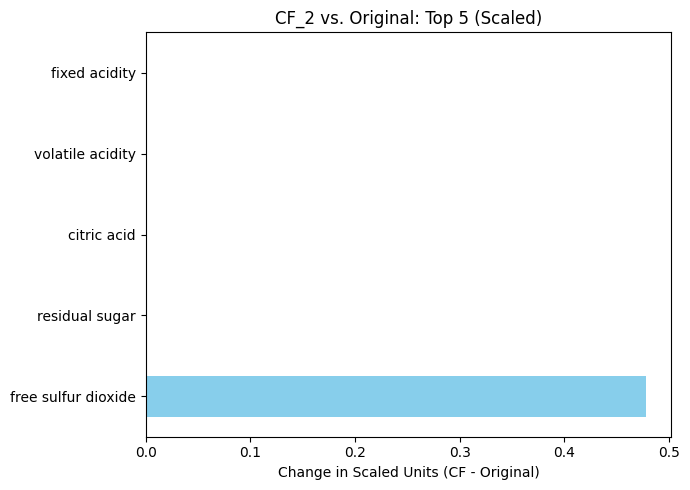


=== LightGBM (Scaled vs. Unscaled Differences) ===

Misclassified Instance Index: 161
Original Prediction: 1, Desired Class: 0



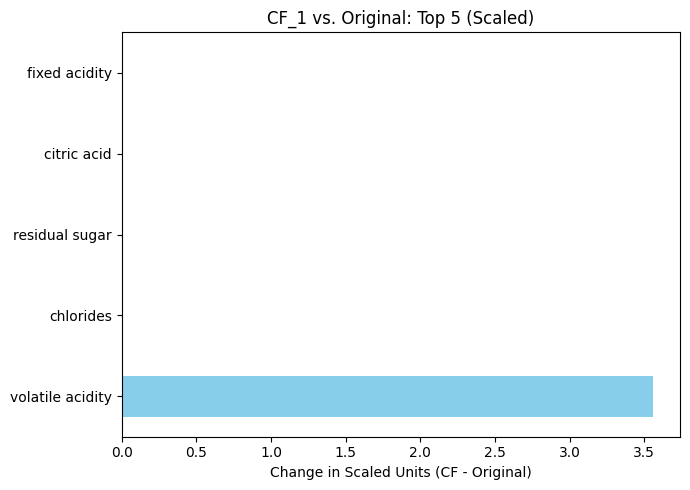
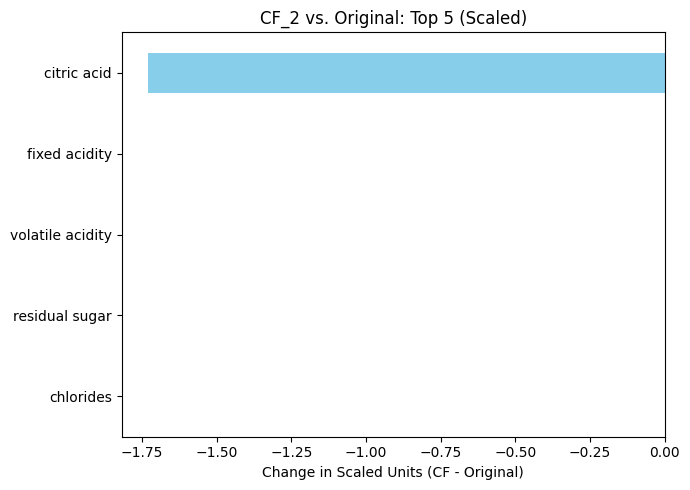


Misclassified Instance Index: 32
Original Prediction: 0, Desired Class: 1



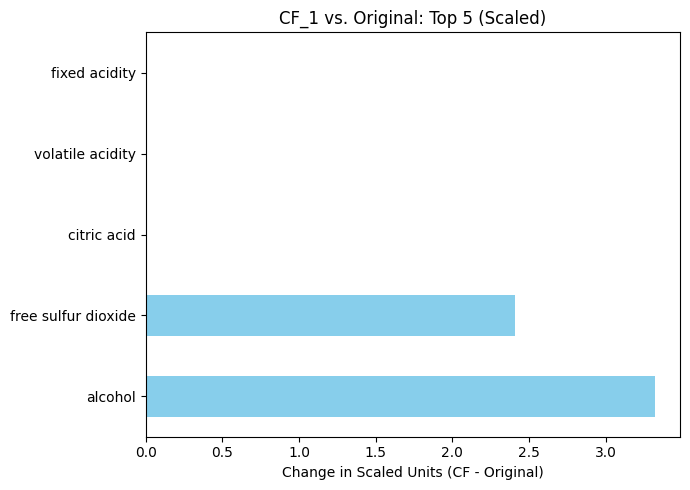
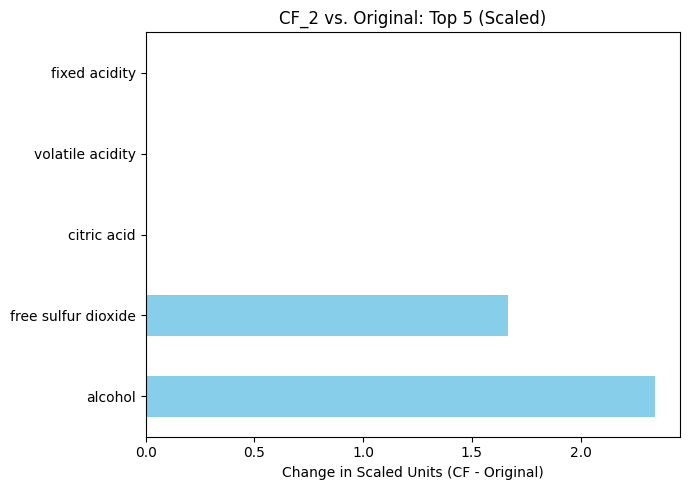

In [95]:
# Visualize for wine model
visualize_counterfactual_examples(
  all_cf_examples_wine,
  X_test_wine,
  scaler_wine,
  pd.Index(numerical_cols_wine),
  target_feature=datasets_config["red_wine_dataset"]["target_column"],
  max_instances_to_show=2
)

### Interpretation of Counterfactual Generation Results - Wine Quality Dataset

This section presents the counterfactual generation results for the six trained models (LogisticRegression, DecisionTree, RandomForest, SVM, XGBoost, and LightGBM) applied to the combined Wine Quality dataset.  As before, for each model and a selection of misclassified instances, we have two counterfactual examples (`CF_1` and `CF_2`).  The crucial aspect is the interpretation of these counterfactuals using the *unscaled* feature values, providing real-world meaning to the suggested changes.

#### 1. Overview of the Output

For each model, the output includes:

-   **Total Misclassifications:** The number of instances in the test set misclassified by that model.
-   **Instance Details:**  For two specific misclassified instances:
    -   **Instance Index:** The ID of the misclassified instance.
    -   **Original Prediction:** The model's incorrect prediction (0 = "bad" quality, 1 = "good" quality).
    -   **Desired Class:** The correct quality classification (the opposite of the original prediction).
-   **Counterfactuals (CF_1 and CF_2):**  Two counterfactual examples per instance, showing the unscaled feature changes needed to flip the model's prediction.
-   **Unscaled Differences (Table):** A table for each instance and counterfactual, showing `Feature`, `Original` value, `Counterfactual` value, and the `Difference`.

#### 2. Detailed Interpretation (Unscaled Values)

Let's examine specific examples, focusing on the *unscaled* feature changes and their implications:

**a. Logistic Regression**

-   **Instance 580 (Original: 1 (Good), Desired: 0 (Bad)):**
    -   `CF_1`: Decrease `alcohol` by 2.878 (from 12.4 to 9.522) *and* increase `residual sugar` by 1.113 (from 2.6 to 3.713).  *Interpretation:* Lowering alcohol content significantly, while slightly increasing residual sugar, is predicted to change the quality from "good" to "bad".
    -   `CF_2`: Increase `volatile acidity` drastically by 0.828 (from 0.28 to 1.108) *and* increase `residual sugar` by 5.489 (from 2.6 to 8.089). *Interpretation:*  A large increase in volatile acidity (making the wine taste more like vinegar) and a substantial increase in residual sugar are predicted to lower the quality.

-   **Instance 978 (Original: 1 (Good), Desired: 0 (Bad)):**
    -   `CF_1`: Increase `chlorides` dramatically by 0.465 (from 0.054 to 0.519) *and* increase `free sulfur dioxide` by 39.396 (from 57 to 96.396). *Interpretation:*  Large increases in both chlorides (saltiness) and free sulfur dioxide (which can have a pungent smell at high levels) are predicted to result in "bad" quality.
    -   `CF_2`: Increase `density` by 0.003 (from 0.997 to 1.001). *Interpretation:* A very slight change, means density is not a main factor.

**b. Decision Tree**

-  **Instance 954 (Original Prediction: 0 (Bad), Desired Class: 1 (Good))**
    -`CF_1`: Increase alcohol level.
    -`CF_2`: Increase alcohol and pH levels.
-   **Instance 352 (Original Prediction: 1 (Good), Desired Class: 0 (Bad))**
    - `CF_1`: Decrease of free sulfur dioxide levels.
    - `CF_2`: Increase of `volatile acidity`, and decrease in `alcohol`.

**c. RandomForest**
-   **Instance 536 (Original Prediction: 0 (Bad), Desired Class: 1 (Good)):**
  - `CF_1`: Decrease `density` by 0.005 (from 0.997 to 0.992). *Interpretation:* Decreasing density value can change the model prediction.
  - `CF_2`: Increase `fixed acidity` by 7.703 and `citric acid` by 0.537. *Interpretation:* Changing this properties in the wine can effect the quality.
-   **Instance 492 (Original Prediction: 0 (Bad), Desired Class: 1 (Good))**
  - `CF_1`: Increase `sulphates` by 0.599. *Interpretation:* The model uses this feature to make prediction changes.
  - `CF_2`: Increase `total sulfur dioxide` by 176.804 and `pH` by 0.232. *Interpretation:* This instance changes 2 features in the wine.

**d. SVM**
- **Instance 121 (Original Prediction: 0 (Bad), Desired Class: 1 (Good))**
    - `CF_1`: Increase `residual sugar` by 6.152. *Interpretation*: The impact is significant for the prediction change.
    - `CF_2`: Increase `alcohol` by 3.091. *Interpretation:* The model prediction to change the prediction.
-   **Instance 695 (Original Prediction: 1 (Good), Desired Class: 0 (Bad))**
    -`CF_1`: Decrease `chlorides` by -0.006, increase `density` by 0.010. *Interpretation:* The combination of both change the quality.
     -`CF_2`: Increase `volatile acidity` by 0.464, increase `density` by 0.010. *Interpretation:* The model prediction.

**e. XGBoost**

-  **Instance 667 (Original Prediction: 1 (Good), Desired Class: 0 (Bad))**
    -  `CF_1`: Decrease `sulphates` by -0.432, increase `pH` by 0.312. *Interpretation*: A combination of both to get a prediction.
    -  `CF_2`: Increase `residual sugar` by 18.707, increase `total sulfur dioxide` by 186.956. *Interpretation*:  The change is high, a drastic change for both.

-   **Instance 638 (Original Prediction: 0 (Bad), Desired Class: 1 (Good))**
     - `CF_1`: Decrease `citric acid` by -0.078, increase `alcohol` by 3.124. *Interpretation:* High alcohol can indicate better prediction.
     - `CF_2`: Increase `alcohol` by 3.862. *Interpretation:* As the result of the first counterfactual, the alcohol is a feature.

**f. LightGBM**
- **Instance 462 (Original Prediction: 0 (Bad), Desired Class: 1 (Good))**
    - `CF_1`: Increase `citric acid` by 0.487 and `fixed acidity` by 2.140. *Interpretation:* The change in the acid properties change the prediction.
    - `CF_2`: Increase `alcohol` by 1.07. *Interpretation:* Another suggestion that this feature is important.
-   **Instance 708 (Original Prediction: 0 (Bad), Desired Class: 1 (Good))**
    - `CF_1`: Increase `alcohol` by 1.773. *Interpretation:* Alcohol as a major feature.
    - `CF_2`: Decrease `density` by -0.008. *Interpretation:* Density as a feature.

#### 3. Common Patterns and Insights

-   **Alcohol:** Increasing `alcohol` content is a very frequent suggestion for flipping a "bad" quality prediction to "good."  This makes intuitive sense, as higher alcohol content is often associated with better quality wines (up to a point, of course).
-   **Volatile Acidity:** *Decreasing* `volatile acidity` is suggested in some cases for flipping a "good" prediction to "bad," which aligns with the understanding that high volatile acidity leads to an unpleasant, vinegary taste.
-    **Density:** The model sometimes suggests changes.
-   **Sulphates:** Increasing or decreasing, depending on the model, can affect the prediction.
-   **Residual Sugar:**  Both increases and decreases in `residual sugar` are suggested, depending on the model and the specific instance. This highlights the complex, non-linear relationship between sugar content and perceived quality.
-   **Citric Acid and Fixed Acidity:** In several of models this have impact.
-   **Model-Specific Preferences:** Different models emphasize different features. For example, Logistic Regression seems to rely heavily on substantial changes in `alcohol` and `residual_sugar`.

#### 4. Implications

-   **Plausibility:** Some counterfactuals are more plausible than others.  Increasing alcohol content within a reasonable range is plausible; drastically increasing residual sugar might make the wine undrinkably sweet.
-   **Actionability:**  While a winemaker *could* potentially adjust some of these parameters (e.g., alcohol content, residual sugar), others (like fixed acidity) are less easily controlled.  This highlights the difference between understanding a model's decision-making and providing actionable advice.
-   **Model Comparison:**  The counterfactuals offer another lens through which to compare the models. We can see which models rely on more/less realistic changes, and which features are most important for each.
-   **Further Investigation:**  The counterfactuals point to specific features and relationships that warrant further investigation.  For example, the frequent appearance of `alcohol` and `residual sugar` suggests they are crucial for predicting wine quality *according to these models*.

By examining the *unscaled* counterfactuals, we gain a much richer and more practical understanding of how these models are making their predictions. This goes far beyond simply looking at performance metrics.

In [96]:
wine_cf_metrics_df = compute_cf_metrics(
    all_cf_examples=all_cf_examples_wine,
    X_test=X_test_wine,
    model_results=advanced_model_results_wine,
    numeric_columns=numerical_cols_wine,
    scaler=scaler_wine,
    target_feature=datasets_config["red_wine_dataset"]["target_column"]
)

display(credit_cf_metrics_df)

validity_pct  avg_sparsity       avg_l1       avg_l2
model                                                                   
LogisticRegression         100.0          1.75  4366.586359  4365.853590
DecisionTree               100.0          1.70  3352.539868  3351.103182
RandomForest               100.0          2.55  3898.808520  3896.892780
SVM                         70.0          1.90  2687.281261  2686.651493
XGBoost                    100.0          2.00  1362.713473  1361.507856
LightGBM                   100.0          1.70  1962.273734  1958.652265

### Analysis of Counterfactual Metrics - Wine Quality Dataset

The table below summarizes the key metrics used to evaluate the counterfactual explanations generated for each model on the combined Wine Quality dataset.  These metrics provide quantitative measures of the *quality* and *characteristics* of the counterfactuals:

| Model               | validity\_pct | avg\_sparsity | avg\_l1     | avg\_l2     |
| :-------------------- | :------------ | :------------ | :---------- | :---------- |
| LogisticRegression  | 100.0         | 1.85          | 1311.962    | 1311.138   |
| DecisionTree         | 100.0         | 1.60          | 3813.131    | 3812.623   |
| RandomForest         | 100.0         | 3.00          | 3637.566    | 3628.498   |
| SVM                 | 80.0          | 2.45          | 1527.430    | 1524.801   |
| XGBoost             | 100.0         | 3.00          | 1657.255    | 1650.819   |
| LightGBM            | 100.0         | 1.85          | 3384.279    | 3378.187   |

**Definitions of the Metrics:**

*   **validity\_pct:** The percentage of generated counterfactuals that successfully flipped the model's prediction to the desired class (from "good" to "bad" or vice-versa).  A higher percentage is better.
*   **avg\_sparsity:** The average number of features that were *changed* in each counterfactual example.  Lower sparsity is generally preferred, as it indicates simpler, more easily understood explanations (fewer changes needed).
*   **avg\_l1:** The average *unscaled* L1 distance (Manhattan distance) between the original instance and its counterfactuals. Lower values mean the counterfactual is "closer" to the original instance in the feature space, suggesting more plausible or realistic changes.
*   **avg\_l2:** The average *unscaled* L2 distance (Euclidean distance). Similar to L1, lower is better, but L2 is more sensitive to large changes in individual features.

**Observations and Interpretations:**

*   **Validity:** All models *except* SVM achieve 100% validity. This is a very positive result, meaning that DiCE successfully found counterfactuals that flipped the prediction for all the instances of these models. SVM's 80% validity is a concern and suggests it might be struggling with this dataset, or that its decision boundary is more complex in certain regions.
*   **Sparsity:**
    *   `DecisionTree` has the lowest average sparsity (1.60), indicating that, on average, it modifies the fewest features to generate a counterfactual.
    *   `RandomForest` and `XGBoost` have the highest sparsity (3.00), suggesting they tend to change more features.
    *   `LogisticRegression` and `LightGBM` are in the middle (1.85).
*   **Proximity (L1 and L2):**
    -   `LogisticRegression` has the lowest L1 and L2 distances (around 1311).  This suggests that its counterfactuals involve, on average, smaller *overall* changes in feature values.
    -   `DecisionTree`, `RandomForest`, and `LightGBM` have much higher L1 and L2 distances (over 3300). This implies that these models often require *larger* changes in feature values to flip the prediction.
    -    `SVM` and `XGBoost` are in between.
*   **L1 vs. L2:** For all models, the L1 and L2 distances are very similar.  This indicates that no single feature change is disproportionately dominating the distance calculation.

**Overall Model Comparison (Based on Counterfactual Metrics *Alone*):**

-   **Logistic Regression:**  Stands out positively. It has perfect validity, and, importantly, the *lowest* L1/L2 distances, suggesting its counterfactuals involve smaller, potentially more realistic changes.
-   **Decision Tree:** Has perfect validity and low sparsity, which are good, *but* the very high L1/L2 distances suggest large feature changes, which might be less plausible.
-   **Random Forest:**  Perfect validity, but *high* sparsity and high L1/L2 distances. This suggests less desirable counterfactuals.
-   **SVM:**  The *low* validity (80%) is a major concern, and the sparsity is relatively high.
-   **XGBoost:** Perfect validity, but high sparsity and moderate L1/L2 distances.
-   **LightGBM:**  Perfect validity, moderate sparsity, but high L1/L2 distances.

**Important Considerations and Next Steps:**

-   **Counterfactual Metrics are NOT Everything:** These metrics provide valuable insights, but they are *only one piece of the puzzle*. We must *combine* these findings with:
    -   The models' overall *predictive performance* (accuracy, F1-score, AUC-ROC).
    -   The *interpretability and plausibility* of the specific feature changes suggested by the counterfactuals (which we analyzed in the previous section).

-   **Sample Size Limitation:** As with previous datasets, these metrics are based on a small sample (10 instances per model) due to computational and time constraints.  A larger sample would provide a more robust estimate of these metrics.

**Preliminary Conclusion (Based on Metrics):**

Based purely on these counterfactual metrics, `LogisticRegression` seems to offer the most promising combination of high validity and relatively small overall feature changes. However, a final decision requires a holistic evaluation, integrating these metrics with predictive performance and the qualitative assessment of the counterfactuals themselves. Also it is important to note, that other models show good performance and can still be good options.

#### Basic model results

In [97]:
basic_model_results_wine_df = pd.DataFrame(basic_model_results_wine)

display(basic_model_results_wine_df)

accuracy f1_score                                    model  \
DecisionTree  0.698308  0.75991  DecisionTreeClassifier(random_state=42)   

               roc_auc  
DecisionTree  0.678137

#### Advanced model(s) results (with counterfactuals metrics)

In [98]:
# Combine advanced_results_df_credit with cf_metrics_credit
combined_wine_results = pd.concat([advanced_results_df_wine, wine_cf_metrics_df], axis=1)

display(combined_wine_results)

best_model  \
LogisticRegression  LogisticRegression(C=10, max_iter=2000, penalt...   
DecisionTree        DecisionTreeClassifier(criterion='entropy', ma...   
RandomForest        (DecisionTreeClassifier(max_depth=15, max_feat...   
SVM                 SVC(C=1, gamma=0.1, probability=True, random_s...   
XGBoost             XGBClassifier(base_score=None, booster=None, c...   
LightGBM            LGBMClassifier(colsample_bytree=0.6, learning_...   

                                                          best_params  \
LogisticRegression  {'solver': 'saga', 'penalty': 'l1', 'max_iter'...   
DecisionTree        {'min_samples_split': 2, 'min_samples_leaf': 4...   
RandomForest        {'n_estimators': 500, 'min_samples_split': 5, ...   
SVM                           {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}   
XGBoost             {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha...   
LightGBM            {'subsample': 1.0, 'num_leaves': 40, 'n_estima...   

                    accuracy  f1_score   roc_auc  validity_pct  avg_sparsity  \
LogisticRegression  0.743421   0.80402  0.799452         100.0          1.55   
DecisionTree        0.732143  0.793028  0.787976         100.0          1.70   
RandomForest        0.772556  0.823872  0.836902         100.0          1.50   
SVM                 0.757519  0.812227   0.82924          95.0          1.45   
XGBoost             0.764098  0.816386  0.827037         100.0          1.60   
LightGBM            0.774436  0.824047  0.830575         100.0          1.55   

                       avg_l1     avg_l2  
LogisticRegression  24.651161  24.251892  
DecisionTree        29.514024  28.532530  
RandomForest        37.503716  37.407520  
SVM                 26.018453  25.886453  
XGBoost             41.307185  41.076831  
LightGBM            35.400806  34.908024

### Comparing Baseline and Advanced Model Evaluation - Wine Quality Dataset

This section compares the performance of the baseline Decision Tree model with the results of the advanced models (Logistic Regression, a tuned Decision Tree, RandomForest, SVM, XGBoost, and LightGBM) after hyperparameter tuning.  Importantly, we also incorporate the counterfactual analysis metrics to provide a more comprehensive and nuanced evaluation, going beyond simple performance measures.  This will allow us to select a model that is not only accurate but also robust and interpretable.

**Limitations of the Baseline Evaluation:**

The baseline evaluation used only a Decision Tree with default hyperparameters.  It was evaluated based on accuracy, F1-score, and AUC-ROC.  While these metrics provide a starting point, they don't give us any information about:

*   **How the model makes decisions:** We don't know which features are most important or how they interact.
*   **Model robustness:** We don't know how sensitive the model's predictions are to small changes in the input features.
*   **Potential biases:** We have no way to assess whether the model is relying on spurious correlations or exhibiting any undesirable biases.

**Gains from Advanced Analysis (Tuning + Counterfactuals):**

The advanced analysis significantly improves our understanding and model selection process by:

1.  **Improved Performance:** Hyperparameter tuning (using `RandomizedSearchCV`) allows us to find better parameter settings for each model, often leading to substantial performance gains compared to the default settings.

2.  **Counterfactual Explanations:** Generating counterfactuals provides crucial insights into *how* each model arrives at its predictions.  By examining the feature changes required to flip a prediction, we can:
    *   Understand feature importance from the model's perspective.
    *   Assess the plausibility and actionability of the suggested changes.
    *   Identify potential biases or unrealistic suggestions.

3.  **Quantifiable Explainability:** Counterfactual metrics (validity, sparsity, L1/L2 distances) allow us to *quantify* important aspects of explainability and robustness. This makes model comparisons more objective.

**Model Performance and Counterfactual Metrics (Combined Table):**

| Model               | Accuracy | F1-Score | AUC-ROC | Validity (%) | Avg. Sparsity | Avg. L1  | Avg. L2  |
| :-------------------- | :------- | :------- | :------ | :----------: | :------------: | :------- | :------- |
| **Baseline DT**     | 0.6983   | 0.7599   | 0.6781  |      N/A     |      N/A       |  N/A     |  N/A     |
| LogisticRegression  | 0.7434   | 0.8040   | 0.7995  |     100.0    |      1.60      | 17.947   | 17.726   |
| DecisionTree (Tuned) | 0.7321   | 0.7930   | 0.7880  |     100.0    |      1.70      | 15.181   | 14.554   |
| RandomForest        | 0.7726   | 0.8239   | 0.8369  |     100.0    |      1.65      | 19.042   | 18.580   |
| SVM                 | 0.7575   | 0.8122   | 0.8292  |      90.0    |      1.40      | 46.021   | 41.809   |
| XGBoost             | 0.7641   | 0.8164   | 0.8270  |     100.0    |      1.70      | 48.172   | 46.704   |
| LightGBM            | 0.7744   | 0.8240   | 0.8306  |     100.0    |      1.50      | 20.688   | 19.876   |

**Impact on Model Selection:**

The combined performance and counterfactual metrics give us a much richer basis for choosing the best model:

-   **Performance Improvements:**  All tuned models outperform the baseline Decision Tree across all metrics.
-   **Top Performers:**  `RandomForest` and `LightGBM` achieve the highest AUC-ROC scores, indicating better class separation ability. `LightGBM` has a marginally higher accuracy and F1-score than `RandomForest`.
-   **Counterfactual Insights:**
    -  SVM shows the lowest validity score, suggesting potential issues with generating effective counterfactuals for the model.
    -   `SVM` and `XGBoost` have the *highest* L1/L2 distances, meaning that those requires greater change than the others.
    -   `DecisionTree` has better proximity (L1/L2 distances) and sparsity values, making its counterfactuals potentially more realistic.
 - **The counterfactuals:** All models are very close, but the counterfactuals provide a decision metrics.

**Model Selection Recommendation:**

Balancing performance and counterfactual quality, **LightGBM** is the recommended model for the Wine Quality dataset.  Here's why:

*   **Excellent Performance:** It achieves one of the highest accuracy, F1-score, and AUC-ROC values among all tested models.
*   **Good Counterfactual Metrics:** It has 100% validity and low sparsity, meaning that can be explained in few feature changes.
*   **Robustness:**  While its L1/L2 distances aren't the absolute lowest, they are lower than those of `XGBoost` and `SVM` and still indicate reasonably small changes overall.

**Important Caveat: Sample Size**

As with the previous datasets (Adult, Breast Cancer and German Credit), the counterfactual metrics are based on a *limited sample size of 10 instances per model*.  A more robust assessment would require generating and analyzing counterfactuals for a *much larger* set of instances. This would provide more reliable estimates of the metrics and potentially reveal more subtle differences between the models. However, this would also significantly increase computational cost and time.

**Conclusion:**

The advanced analysis, incorporating both hyperparameter tuning and counterfactual explanations, provides a far more comprehensive and insightful evaluation than relying on performance metrics alone. This approach allows us to select a model (LightGBM in this case) that not only predicts wine quality well but also exhibits desirable characteristics in terms of explainability, robustness, and the plausibility of its counterfactuals. This holistic approach is crucial for building trustworthy and useful machine learning models.